In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import subprocess
import re
import pickle
from numba import njit
import time

#import PySide6.QtWidgets
#app = PySide6.QtWidgets.QApplication() # Needed to print ovito renderings on screen

from ovito.io import *
from ovito.modifiers import *
from ovito.data import *
from ovito.pipeline import *
from ovito.vis import *
import PySide6.QtCore
import os.path

plt.rcParams.update({'font.size': 12})
import matplotlib.patheffects as pe

In [3]:
def getparams(pattern):
    r1 = re.compile('[_]')
    r2 = re.compile(r'(([-+]?\d+\.\d+)|([-+]?\d+))')
    r3 = re.compile('[-]')
    pattern = pattern.split()[0]
    #pattern = pattern.decode("utf-8")
    
    # Default params
    ts=-1
    real=-1
    Rcylin=-1
    Rcylout=-1
    Rring = -1
    geometry =''
    Lz=-1
    RN = 0
    pAN = 0
    pNN = 0
    pP = 0
    pB = 0
    pS = 0
    pD = 0
    pMA = 0
    pMW = 0
    pMD = 0
    pMDE = 0
    pCA=0
    pCD=0
    pMOC = 0
    nM=0
    nC=0
    eAA=0
    Lx=0
    
    # Read params
    for s in r1.split(pattern):
        if s.startswith('rw'):
            geometry = 'rw'
        elif s.startswith('cw'):
            geometry = 'cw'
        elif s.startswith('r'):
            s3 = s[1:]
            Rcylin = float(r3.split(s3)[0])
            Rcylout = float(r3.split(s3)[1])
            try:
                Rring = float(r3.split(s3)[2])
            except:
                pass
        if s.startswith('Lz'):
            Lz = float(r2.split(s)[1])
        if s.startswith('Lx'):
            Lx = float(r2.split(s)[1])    
        if s.startswith('eAA'):
            eAA = float(r2.split(s)[1])
        if s.startswith('nF'):
            s3 = s[2:]
            nF = int(r3.split(s3)[0])
            lF = int(r3.split(s3)[1])
        if s.startswith('nM'):
            nM = int(r2.split(s)[1])
        if s.startswith('nC'):
            nC = int(r2.split(s)[1])
        if s.startswith('R'):
            s3 = s[1:]
            RN = int(r3.split(s3)[0])
            pAN = float(r3.split(s3)[1])
            pNN = float(r3.split(s3)[2])
            pP = float(r3.split(s3)[3])
            pB = float(r3.split(s3)[4])
            pS = float(r3.split(s3)[5])
            pD = float(r3.split(s3)[6])
            pMA = float(r3.split(s3)[7])
            pMW = float(r3.split(s3)[8])
            pMD = float(r3.split(s3)[9])
            pMDE = float(r3.split(s3)[10])  
            pCA =float(r3.split(s3)[11])
            pCD =float(r3.split(s3)[12])
            pMOC = float(r3.split(s3)[13])  
        if s[0].isdigit():
            real=int(s)
    
    return {'geom':geometry, 'Rcylin':Rcylin, 'Rcylout':Rcylout, 'Rring':Rring, 'Lz':Lz, 'eAA':eAA, 'nF':nF, 'lF':lF, 'nM':nM, 'nC':nC, 'RN':RN, 
            'pAN':pAN,'pNN':pNN,'pP':pP,'pB':pB,'pS':pS,'pD':pD,'pMA':pMA,'pMW':pMW,'pMD':pMD,'pMDE':pMDE,'pCA':pCA,'pCD':pCD,'pMOC':pMOC,
            'real':real}


In [4]:
def sortbyparams(key):
    p = getparams(key)
    return 1e5*p['lF']+p['nM']

In [5]:
def nM2color(nM):
    if nM==19200:
        return 'black'
    if nM==9600:
        return 'navy'
    elif nM==4800:
        return 'royalblue'
    elif nM==2400:
        return 'teal'
    elif nM==1200:
        return 'forestgreen'
    elif nM==600:
        return 'green'
    elif nM==300:
        return 'lime'
    else:
        assert False, 'nM={} not in color palette nM2color'.format(nM)
    

In [6]:
def bin2midpoint(edges):
    return [0.5*(edges[i]+edges[i+1]) for i in range(0,len(edges)-1)]

In [7]:
@njit
def ThetaDiff(th1,th2):
    a = abs(th1-th2)
    if a<np.pi:
        return a
    else:
        return 2*np.pi-a

@njit
def ThetaOverlap(Th1,Th2,ThetaTolerance):
    for th1 in Th1:
        for th2 in Th2:
            if ThetaDiff(th1,th2)<ThetaTolerance:
                return True
    return False

@njit
def zDiffAbs(z1,z2,Lz):
    a = abs(z1-z2)
    if a<0.5*Lz:
        return a
    else:
        return Lz-a
    
@njit
def Distance2_ffp(p,q,Lz):
    assert len(p)==3
    assert len(q)==3
    a = (p[0]-q[0])**2 + (p[1]-q[1])**2 + (zDiffAbs(p[2],q[2],Lz))**2
    return a

@njit
def zDiffSigned(z1,z2,Lz):
    a = (z1-z2)
    if abs(a)<0.5*Lz:
        return a
    elif a<-0.5*Lz:
        return a+Lz
    else:
        return a-Lz

@njit
def zDiffSigned0(a,Lz):
    if abs(a)<0.5*Lz:
        return a
    elif a<-0.5*Lz:
        return a+Lz
    else:
        return a-Lz
    


# Traj analysis

In [8]:
folder='/home/alessandro/ISTA/ivan_original/Test_B15__Alessandro/Test_B15__Alessandro'
MMbondLength =10

In [9]:
oldfiles = subprocess.check_output("ls {:s}/Results/Traj_rw_r0-150*_Lz*_nF*-*_nM*_2[0-1][0-9].xyz | sed 's/.*Traj_//' | sed 's/.xyz//' ".format(folder), shell=True)
oldfiles=oldfiles.split()
oldfiles=[a.decode("utf-8") for a in oldfiles]

In [10]:
middlefiles = subprocess.check_output("ls {:s}/Results/Traj_rw_r0-250*_Lz*_nF*-*_nM*_203.xyz | sed 's/.*Traj_//' | sed 's/.xyz//' ".format(folder), shell=True)
middlefiles=middlefiles.split()
middlefiles=[a.decode("utf-8") for a in middlefiles]

In [11]:
finefiles = subprocess.check_output("ls {:s}/Results/Traj_rw_r0-*_Lz*_nF*-*_nM*_205.xyz | sed 's/.*Traj_//' | sed 's/.xyz//' ".format(folder), shell=True)
finefiles=finefiles.split()
finefiles=[a.decode("utf-8") for a in finefiles]

In [12]:
# Look for all Traj files
folder='/home/alessandro/ISTA/ivan_original/Test_B15__Alessandro/Test_B15__Alessandro'
MMbondLength =10


filestringList = subprocess.check_output("ls {:s}/Results/Traj_rw_r0-*_Lz*_nF*-*_nM*_2[0-1][0-9].xyz | sed 's/.*Traj_//' | sed 's/.xyz//' ".format(folder), shell=True)
filestringList = subprocess.check_output("ls {:s}/Results/Traj_rw_r0-*_Lz10*_nF*-*_nM*_208.xyz | sed 's/.*Traj_//' | sed 's/.xyz//' ".format(folder), shell=True)
#filestringList = subprocess.check_output("ls {:s}/Results/Traj_cw_r*_Lz*_nF*-*_nM*_1[1-9][0-9].xyz | sed 's/.*Traj_//' | sed 's/.xyz//' ".format(folder), shell=True)
filestringList
filestringList=filestringList.split()
filestringList=[a.decode("utf-8") for a in filestringList]
for f in filestringList:
    print(f)
    print(getparams(f))


rw_r0-250-200_Lz10.0_nF200-60_nM0_nC12800_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0.1-0.00001-1_208
{'geom': 'rw', 'Rcylin': 0.0, 'Rcylout': 250.0, 'Rring': 200.0, 'Lz': 10.0, 'eAA': 0, 'nF': 200, 'lF': 60, 'nM': 0, 'nC': 12800, 'RN': 10, 'pAN': 0.0, 'pNN': 0.0, 'pP': 0.0, 'pB': 0.0, 'pS': 0.0, 'pD': 0.0, 'pMA': 0.1, 'pMW': 1.0, 'pMD': 1e-05, 'pMDE': 1e-05, 'pCA': 0.1, 'pCD': 1e-05, 'pMOC': 1.0, 'real': 208}
rw_r0-250-200_Lz10.0_nF200-60_nM0_nC6400_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0.1-0.00001-1_208
{'geom': 'rw', 'Rcylin': 0.0, 'Rcylout': 250.0, 'Rring': 200.0, 'Lz': 10.0, 'eAA': 0, 'nF': 200, 'lF': 60, 'nM': 0, 'nC': 6400, 'RN': 10, 'pAN': 0.0, 'pNN': 0.0, 'pP': 0.0, 'pB': 0.0, 'pS': 0.0, 'pD': 0.0, 'pMA': 0.1, 'pMW': 1.0, 'pMD': 1e-05, 'pMDE': 1e-05, 'pCA': 0.1, 'pCD': 1e-05, 'pMOC': 1.0, 'real': 208}
rw_r0-250-200_Lz10.0_nF240-50_nM0_nC12800_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0.1-0.00001-1_208
{'geom': 'rw', 'Rcylin': 0.0, 'Rcylout': 250.0, 'Rring': 200.0, 'Lz': 10.0, 'eAA': 0

In [13]:
# read dictionary 
#with open('{:s}/Analysis/dicR.pickle'.format(folder), 'rb') as file:
dicR={}
with open('/home/alessandro/ISTA/ivan_original/Test_B15__Alessandro/Test_B15__Alessandro/Analysis/dicR.pickle','rb') as file:
    dicR=pickle.load(file)
dicR.keys()

dict_keys(['rw_r0-250-200_Lz10.0_nF100-20_nM1000_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0-0-0_203', 'rw_r0-250-200_Lz10.0_nF100-30_nM1000_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0-0-0_203', 'rw_r0-250-200_Lz10.0_nF100-40_nM1000_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0-0-0_203', 'rw_r0-250-200_Lz10.0_nF100-50_nM1000_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0-0-0_203', 'rw_r0-250-200_Lz10.0_nF150-20_nM1500_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0-0-0_203', 'rw_r0-250-200_Lz10.0_nF150-30_nM1500_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0-0-0_203', 'rw_r0-250-200_Lz10.0_nF150-40_nM1500_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0-0-0_203', 'rw_r0-250-200_Lz10.0_nF150-50_nM1500_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0-0-0_203', 'rw_r0-250-200_Lz10.0_nF200-20_nM2000_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0-0-0_203', 'rw_r0-250-200_Lz10.0_nF200-30_nM2000_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0-0-0_203', 'rw_r0-250-200_Lz10.0_nF200-40_nM2000_nC0_R10-0-0-0-0-0-0-0.1-1-0.000

In [17]:
def addLocalFilamentDirection(dfm, Lz):
    assert len(dfm.Molec.unique())==1 # all atoms belong to same filament
    dfm = dfm.sort_values(by='PolyTime',ascending=True)
    Directionx = dfm.x.values[:-1]-dfm.x.values[1:]          # Direction goes from Barbed to Pointed end
    Directiony = dfm.y.values[:-1]-dfm.y.values[1:]
    Directionz = dfm.z.values[:-1]-dfm.z.values[1:]
    Directionz = [ zDiffSigned0(z,Lz) for z in Directionz ]
    Direction = np.array([Directionx, Directiony, Directionz]).transpose()
    Direction = np.append(Direction,[Direction[-1]],axis=0)
    Direction = [np.array(d) for d in Direction]
    dfm['Direction'] = Direction
    return dfm


def globalFilamentDirection(dfm, Lz):
    assert len(dfm.Molec.unique())==1 # all atoms belong to same filament
    dfm = dfm.sort_values(by='PolyTime',ascending=True)
    Directionx = dfm.x.values[0]-dfm.x.values[-1]          # Direction goes from Barbed [-1] to Pointed end [0]
    Directiony = dfm.y.values[0]-dfm.y.values[-1]
    Windingz = 0
    z = dfm.z.values
    Lzhalf = 0.5*Lz
    for k in range(len(z)-1):
        if z[k]>Lzhalf and z[k+1]<-Lzhalf:
            Windingz += 1
        elif z[k]<-Lzhalf and z[k+1]>Lzhalf:
            Windingz -= 1
    Directionz = dfm.z.values[0]-(dfm.z.values[-1]+(Windingz*Lz))
    return np.array([Directionx, Directiony, Directionz])


@njit
def countcontacts(dm1,dm2,Distance2Tolerance,ThetaScreeningTolerance,Dir1,Dir2,lF):
    ContactDummyCounter = 0
    ContactCounter = [0,0,0]
    for ja1, a1 in enumerate(dm1):
        for ja2, a2 in enumerate(dm2):
            if ThetaDiff(a1[4],a2[4]) < ThetaScreeningTolerance :     # [4] is ThetaRad
                if Distance2_ffp([a1[1],a1[2],a1[3]],[a2[1],a2[2],a2[3]],Lz) < Distance2Tolerance :     # [1] is x, [2] is y, [3] is z
                    ContactDummyCounter += 1
                    break
    if ContactDummyCounter ==0:
        return ContactCounter
    if np.sign( np.dot(Dir1,Dir2) ) >= 0:    # [5] is Directionx, [6] is Directiony, [7] is Directionz
        ContactFlag = 0    # Parallel 
    else:
        p1 = dm1[0]  # Pointed end of molecule 1
        b1 = dm1[-1] # Barbed end of molecule 1
        p2 = dm2[0]  # Pointed end of molecule 2
        b2 = dm2[-1] # Barbed end of molecule 2
        if Distance2_ffp([p1[1],p1[2],p1[3]],[p2[1],p2[2],p2[3]],Lz) > Distance2_ffp([b1[1],b1[2],b1[3]],[b2[1],b2[2],b2[3]],Lz) : # distance between pointed ends > barbed ends
            ContactFlag=1    # AntiParallelExtensile
            #print("extensile")
        else:
            ContactFlag=2    # AntiParallelContractile
            #print("contractile")
    ContactCounter[ContactFlag] += ContactDummyCounter     # ContactCounter only counts contacts of molecule 1
    return ContactCounter

def MMbond_boundtosamefilaments(dfBondMM,dfBondMM_Reference):
    return dfPart.loc[dfBondMM.TopologyA]['MolecA_Mpart']

In [18]:
@njit
def is_permuation_matrix(x):
    return (x.ndim == 2 and x.shape[0] == x.shape[1] and
            (x.sum(axis=0) == 1).all() and 
            (x.sum(axis=1) == 1).all() and
            ((x == 1) | (x == 0)).all())

@njit
def which_indeces_merge(Matrix):
    if is_permuation_matrix(Matrix):
        return np.array([0,0,-1],dtype=np.int64) # do not sum
    for i in range(Matrix.shape[0]):
            for j1 in range(Matrix.shape[1]):
                for j2 in range(j1+1, Matrix.shape[1]):
                    if Matrix[i,j1]*Matrix[i,j2]==1:
                        return np.array([j1,j2,1],dtype=np.int64) # sum columns
    for j in range(Matrix.shape[1]):
            for i1 in range(Matrix.shape[0]):
                for i2 in range(i1+1, Matrix.shape[0]):
                    if Matrix[i1,j]*Matrix[i2,j]==1:
                        return np.array([i1,i2,0],dtype=np.int64) # sum rows 
    return np.array([0,0,-2],dtype=np.int64) # error

'''def which_indeces_merge(Matrix):
    if is_permuation_matrix(Matrix):
        return [] # do not sum
    for i in range(Matrix.shape[0]):
            for j1 in range(Matrix.shape[1]):
                for j2 in range(j1+1, Matrix.shape[1]):
                    if Matrix[i,j1]*Matrix[i,j2]==1:
                        return [j1,j2,1] # sum columns
    for j in range(Matrix.shape[1]):
            for i1 in range(Matrix.shape[0]):
                for i2 in range(i1+1, Matrix.shape[0]):
                    if Matrix[i1,j]*Matrix[i2,j]==1:
                        return [i1,i2,0] # sum rows '''

def mergeclusters(AdjacencyMatrix):
    clusterdic = 0*AdjacencyMatrix
    Matrix = AdjacencyMatrix
    # Initialise tracking
    Mx, My = Matrix.shape
    Tracker = [ [ [[i,j]] for j in range(My)] for i in range(Mx) ]
    for i in range(Mx):
        for j in range(My):
            if AdjacencyMatrix[i,j]==0:
                Tracker[i][j]=[]
    # Reduce matrix
    indeces = which_indeces_merge(Matrix)
    while(indeces[2]>=0):
        Mx, My = Matrix.shape
        #print(indeces)
        if indeces[2]==1: # sum columns, ie multiply Matrix~(Mx,My) by Mult~(My,My-1) to get NewMatrix~(Mx,My-1) 
            j1, j2 = indeces[:2]
            Mult = np.zeros( (My, My-1), dtype=int)
            for j in range(My):
                if j<j2:
                    Mult[j,j]=1
                elif j==j2:
                    Mult[j2,j1]=1
                else:
                    Mult[j,j-1]=1
            NewMatrix = np.sign(np.dot(Matrix,Mult)) # performs logic OR of columns j1 and j2
            # Update tracker
            '''NewTracker = [ [[] for j in range(My-1)] for i in range(Mx)] 
            for i in range(Mx):
                for j in range(My):
                    if j<j2:
                        NewTracker[i][j] += Tracker[i][j]
                    elif j==j2:
                        NewTracker[i][j1] += Tracker[i][j2]
                    else:
                        NewTracker[i][j-1] += Tracker[i][j]'''
            NewTracker = [[ Tracker[i][j] if (j<j2 and j!=j1)   else   Tracker[i][j1]+Tracker[i][j2] if j==j1   else   Tracker[i][j+1]   for j in range(My-1)] for i in range(Mx)]
            Matrix = NewMatrix
            Tracker = NewTracker
        
        if indeces[2]==0: # sum rows, ie multiply Mult~(Mx-1,Mx) Matrix~(Mx,My) to get NewMatrix~(Mx-1,My) 
            i1, i2 = indeces[:2]
            Mult = np.zeros( (Mx-1, Mx), dtype=int)
            for i in range(Mx):
                if i<i2:
                    Mult[i,i]=1
                elif i==i2:
                    Mult[i1,i2]=1
                else:
                    Mult[i-1,i]=1
            NewMatrix = np.sign(np.dot(Mult,Matrix))
            # Update tracker
            '''NewTracker = [ [[] for j in range(My)] for i in range(Mx-1)] 
            for i in range(Mx):
                for j in range(My):
                    if i<i2:
                        NewTracker[i][j] += Tracker[i][j]
                    elif i==i2:
                        NewTracker[i1][j] += Tracker[i2][j]
                    else:
                        NewTracker[i-1][j] += Tracker[i][j]'''
            NewTracker = [[ Tracker[i][j] if (i<i2 and i!=i1)   else   Tracker[i1][j]+Tracker[i2][j] if i==i1   else   Tracker[i+1][j]   for j in range(My)] for i in range(Mx-1)]
            Matrix = NewMatrix
            Tracker = NewTracker

        indeces = which_indeces_merge(Matrix)
    
    assert is_permuation_matrix(Matrix) # Then also Tracker is 'permutation-like' and I can only extract the one non-empty element from its rows (or columns)
    ClusterMap = [ [] for row in Tracker ]
    for i,row in enumerate(Tracker):
        for j,el in enumerate(row):
            if len(el)>0:
                for jj in range(len(row)):
                    if jj!=j:
                        assert len(row[jj])==0, 'ERROR: Tracker is not permutation-like'
                ClusterMap[i] = el
                
    return ClusterMap

In [15]:
Properties = ['time', 'Ravg', 'Rstd', 'histAdensity', 'histABdensity', 'histAPdensity',
              'histMUdensity', 'histMBdensity', 'RingIntactFlag', 'PercolatedFraction',
              #'histParallelContacts','histAntiparallelExtensileContacts', 'histAntiparallelContractileContacts', 'NActin',
              'histParallelMbond', 'histAntiparallelMbond',
              'ActinStrainAvg','histActinStrainDistr',
              'vdotnActinAvg', 'histvdotnActinDistr','histMDistrAlongActin',
              'histDoubleBoundMDistrAlongActin',
              'MSpeedParallelAvg','MSpeedAntiparallelAvg','MSpeedAvg',
              'MSpeedParallelNotjammedAvg','MSpeedAntiparallelNotjammedAvg','MSpeedNotjammedAvg',
              'JammedMyosins','JammedActins','DBNJMyosinStrainAvg',
              'EndtoendDistance'
              #'DeltaExtensivityRef', 'DeltaExtensivityCont'
             ]
AnalyseEvery = 2000000
TimestepInterval = 100000 #100000

for filestring in filestringList[:]:
    print(filestring)
    if filestring in oldfiles:
        print('oldfile')
        #continue
        AnalyseEvery = 300000
        TimestepInterval = 30000
    elif filestring in middlefiles:
        print('middlefile')
        AnalyseEvery = 500000
        TimestepInterval = 50000
    elif filestring in finefiles:
        print('finefile')
        AnalyseEvery = 30000
        TimestepInterval = 10000
    lastoutstring = subprocess.check_output("tail -n5 {:s}/Results/Log_{:s}.dat".format(folder,filestring), shell=True)
    #if (os.path.isfile(ClusterStatisticsFile)==False) & ("Total wall time" in laststring.decode("utf-8")):
    if True: #("Total wall time" in lastoutstring.decode("utf-8")):

        trajname   = '{:s}/Results/Traj_{:s}.xyz'.format(folder,filestring)
        bondsname  = '{:s}/Results/Bonds_{:s}.dat'.format(folder,filestring)
        configname = '{:s}/Input/Configurations/Config_{:s}.dat'.format(folder,filestring)
        par = getparams(filestring)
        nF, lF, nM, Lz = par['nF'], par['lF'], par['nM'], par['Lz']

        # Data import:
        try:
            pipeline = import_file(trajname, multiple_frames = True, sort_particles = True)
        except:
            continue

        # Manual modifications of the imported data objects:
        def modify_pipeline_input(frame: int, data: DataCollection):
            data.particles_.particle_types_.type_by_id_(4).color = (0.8705882430076599, 0.9254902005195618, 1.0)
            data.particles_.particle_types_.type_by_id_(4).radius = 0.5
            data.particles_.particle_types_.type_by_id_(5).color = (0.0, 0.9768062829971313, 0.0)
            data.particles_.particle_types_.type_by_id_(5).radius = 0.5
            data.particles_.particle_types_.type_by_id_(6).color = (0.07759212702512741, 0.6699779033660889, 0.0)
            data.particles_.particle_types_.type_by_id_(6).radius = 0.5
            try: data.particles_.particle_types_.type_by_id_(7).color = (0.004852368962019682, 0.0960860624909401, 0.574990451335907)
            except KeyError: pass
            try:data.particles_.particle_types_.type_by_id_(7).radius = 0.5
            except KeyError: pass
            try: data.particles_.particle_types_.type_by_id_(8).color = (0.15294118225574493, 0.45098039507865906, 1.0)
            except KeyError: pass
            try: data.particles_.particle_types_.type_by_id_(8).radius = 0.5
            except KeyError: pass
        pipeline.modifiers.append(modify_pipeline_input)

        # Visual element initialization:
        data = pipeline.compute() # Evaluate new pipeline to gain access to visual elements associated with the imported data objects.
        data.particles.vis.radius = 1.0
        data.cell.vis.rendering_color = (0.3019607961177826, 0.5411764979362488, 0.7764706015586853)
        del data # Done accessing input DataCollection of pipeline.

        # Load bonds:
        modBonds = LoadTrajectoryModifier()
        pipeline.modifiers.append(modBonds)
        modBonds.source.load(bondsname, columns = ['BondID','Particle Identifiers.1', 'Particle Identifiers.2', 'Bond Type', 'Length', 'Energy.1'], multiple_frames = True)


        #### Skip file if no new line to add to dicR
        NumberOfFrames = np.min([modBonds.source.num_frames, pipeline.source.num_frames])
        if filestring in dicR.keys():
            dfOld = dicR[filestring]
            if len(dfOld)==int(NumberOfFrames/(AnalyseEvery/TimestepInterval)) and np.array([p in dfOld.columns for p in Properties]).all():
                print("{:s} - Nothing new".format(filestring))
                continue
            else:
                dfOld = {}
                PropertiesToCompute = Properties #[p for p in Properties if p not in dfOld]
        else:
            PropertiesToCompute = Properties

        print("{:s} - Analyse".format(filestring))
        print(PropertiesToCompute)

        #### Define OVITO Modifiers
        # Compute property Rcenter:
        pipeline.modifiers.append(ComputePropertyModifier(
            expressions = ('sqrt(Position.X^2 + Position.Y^2)',), # ((ParticleType>=4)*(ParticleType<=6))
            output_property = 'Rcenter'))

        # Compute molecule ID:
        pipeline.modifiers.append(ComputePropertyModifier(
            expressions = ('(ParticleIdentifier<={nF}*{lF})*rint(ParticleIdentifier/{lF}+0.49999) + (ParticleIdentifier>{nF}*{lF})*({nF}+rint((ParticleIdentifier-{nF}*{lF})/2+0.49999))'.format(nF=nF,lF=lF),),
            output_property = 'Molec'))

        # Compute PolyTime (proxy for filament orientation):
        pipeline.modifiers.append(ComputePropertyModifier(
            expressions = (' ((ParticleType>=4)*(ParticleType<=6)) * (ParticleIdentifier-{lF}*(Molec-1)) '.format(lF=lF),),
            output_property = 'PolyTime'))

        # Compute ThetaRad:
        pipeline.modifiers.append(ComputePropertyModifier(
            expressions = ('atan2(Position.Y,Position.X)',),
            output_property = 'ThetaRad'))

        '''# Color coding
        # Leaving this modifier out, because its modifier group is disabled.
        if False:
            # Visualisation - Select type:
            pipeline.modifiers.append(SelectTypeModifier(types = {4, 5, 6}))
            # Visualisation - Color coding:
            pipeline.modifiers.append(ColorCodingModifier(
                property = 'PolyTime',
                gradient = ColorCodingModifier.BlueWhiteRed(),
                only_selected = True))
            # Visualisation - Clear selection:
            pipeline.modifiers.append(ClearSelectionModifier())
        '''
        '''
        # Compute property PolytimeMB, i.e. which point of the filament are myosin heads bound to:
        pipeline.modifiers.append(ComputePropertyModifier(
        operate_on = 'bonds',
        expressions = ('(BondType==7) * ( @1.PolyTime*(@1.ParticleType==6) + @2.PolyTime*(@2.ParticleType==6) )',),
        output_property = 'PolytimeMB'))
        '''

        if True:
            # Compute property PolytimeBoundActin for AMbond: polytime dell'atomo di actina in un AM bond
            pipeline.modifiers.append(ComputePropertyModifier(
                operate_on = 'bonds',
                expressions = ('(BondType==7) * ( @1.PolyTime*(@1.ParticleType==6) + @2.PolyTime*(@2.ParticleType==6) ) - 1000*(BondType!=7)',),
                output_property = 'PolytimeA_AMbond'))

            # Ale: Compute property PolytimeBoundActin for ACbond: polytime dell'atomo di actina in un AC bond
            pipeline.modifiers.append(ComputePropertyModifier(
                operate_on = 'bonds',
                expressions = ('(BondType==9) * ( @1.PolyTime*(@1.ParticleType==6) + @2.PolyTime*(@2.ParticleType==6) ) - 1000*(BondType!=9)',),
                output_property = 'PolytimeA_ACbond'))

            # Compute property MolecBoundActin for AMbond: id molecolare della actina di un AM bond
            pipeline.modifiers.append(ComputePropertyModifier(
                operate_on = 'bonds',
                expressions = ('(BondType==7) * ( @1.Molec*(@1.ParticleType==6) + @2.Molec*(@2.ParticleType==6) ) - 1000*(BondType!=7)',),
                output_property = 'MolecA_AMbond'))
            
            # Ale: Compute property MolecBoundActin for ACbond: id molecolare della actina di un AC bond
            pipeline.modifiers.append(ComputePropertyModifier(
                operate_on = 'bonds',
                expressions = ('(BondType==9) * ( @1.Molec*(@1.ParticleType==6) + @2.Molec*(@2.ParticleType==6) ) - 1000*(BondType!=9)',),
                output_property = 'MolecA_ACbond'))

            # Direction for AAbond (oriented from barbed to pointed end)
            # Direction - DirectionX:
            if par['geom']=='rw':
                pipeline.modifiers.append(ComputePropertyModifier(
                operate_on = 'bonds',
                expressions = ('(BondType==4) * sign(@2.PolyTime-@1.PolyTime)*(@1.Position.X-@2.Position.X)',
                                '(BondType==4) * sign(@2.PolyTime-@1.PolyTime)*(@1.Position.Y-@2.Position.Y)',
                                '(BondType==4) * sign(@2.PolyTime-@1.PolyTime)*(@1.Position.Z-@2.Position.Z)'),
                output_property = 'DirectionAA_AAbond'))
            else:
                pipeline.modifiers.append(ComputePropertyModifier(
                    operate_on = 'bonds',
                    expressions = ('(BondType==4) * sign(@2.PolyTime-@1.PolyTime)*(@1.Position.X-@2.Position.X)',
                                    '(BondType==4) * sign(@2.PolyTime-@1.PolyTime)*(@1.Position.Y-@2.Position.Y)',
                                    '(BondType==4) * sign(@2.PolyTime-@1.PolyTime)*(@1.Position.Z-@2.Position.Z-PeriodicImage.Z*CellSize.Z)'),
                    output_property = 'DirectionAA_AAbond'))

            # User-defined modifier 'Python script for Direction: spread Direction from Act-Act bond to Act particle':
            def spread_fromAAbond_toApart(frame: int, data: DataCollection):
                if data.particles != None:
                    bonds=data.particles.bonds
                    data.particles_.create_property('DirectionAA_Apart',dtype=float, components=3)
                    for i,bondtype in enumerate(bonds.bond_types[:]):
                        if bondtype==4:
                            j0,j1 = bonds.topology[i]
                            if data.particles['Particle Type'][j0]==5 or data.particles['Particle Type'][j1]==5:
                                IndexList = [j0,j1]
                            else:
                                j = j0 if data.particles['PolyTime'][j0] < data.particles['PolyTime'][j1] else j1
                                IndexList = [j]
                            for j in IndexList:
                                data.particles_['DirectionAA_Apart'][j] = bonds['DirectionAA_AAbond'][i]
            pipeline.modifiers.append(spread_fromAAbond_toApart)

            # Spread Direction from Apart to AMbond, if bound
            # Direction - DirectionX on Myo-Act bond:
            pipeline.modifiers.append(ComputePropertyModifier(
                operate_on = 'bonds',
                expressions = ('(BondType==7) * ( @1.DirectionAA_Apart.1*(@1.ParticleType==6) + @2.DirectionAA_Apart.1*(@2.ParticleType==6) ) - 1000*(BondType!=7)',
                                '(BondType==7) * ( @1.DirectionAA_Apart.2*(@1.ParticleType==6) + @2.DirectionAA_Apart.2*(@2.ParticleType==6) ) - 1000*(BondType!=7)',
                                '(BondType==7) * ( @1.DirectionAA_Apart.3*(@1.ParticleType==6) + @2.DirectionAA_Apart.3*(@2.ParticleType==6) ) - 1000*(BondType!=7)'),
                output_property = 'DirectionAA_AMbond'))
            
            #Ale: spread direction from Apart to ACbond, if bound
            pipeline.modifiers.append(ComputePropertyModifier(
                operate_on = 'bonds',
                expressions = ('(BondType==9) * ( @1.DirectionAA_Apart.1*(@1.ParticleType==6) + @2.DirectionAA_Apart.1*(@2.ParticleType==6) ) - 1000*(BondType!=9)',
                                '(BondType==9) * ( @1.DirectionAA_Apart.2*(@1.ParticleType==6) + @2.DirectionAA_Apart.2*(@2.ParticleType==6) ) - 1000*(BondType!=9)',
                                '(BondType==9) * ( @1.DirectionAA_Apart.3*(@1.ParticleType==6) + @2.DirectionAA_Apart.3*(@2.ParticleType==6) ) - 1000*(BondType!=9)'),
                output_property = 'DirectionAA_ACbond'))

            # User-defined modifier 'Python script for PolytimeOfActinBoundToThisMyo and DirectionOfActinBoundToThisMyo: spread them from AMbond to Mpart':
            def spread_fromAMbond_toMpart(frame: int, data: DataCollection):
                if data.particles != None:
                    bonds=data.particles.bonds
                    data.particles_.create_property('PolytimeA_Mpart',dtype=int, components=1)
                    data.particles_.create_property('MolecA_Mpart',dtype=int, components=1)
                    data.particles_.create_property('DirectionAA_Mpart',dtype=float, components=3)
                    for i,bondtype in enumerate(bonds.bond_types[:]):
                        if bondtype==7:
                            topology = bonds.topology[i]
                            index = topology[0] if data.particles.particle_types[topology[0]]==8 else topology[1]
                            if data.particles.particle_types[index]!=8:
                                print("  Irregular bond: bond index {:}, part index {:d}-{:d}, part id {:d} has type {:d}. Check Bonds file if too many irregular bonds".format(
                                    i, topology[0],topology[1], data.particles.identifiers[index], data.particles.particle_types[index]))
                            data.particles_['PolytimeA_Mpart'][index] = bonds['PolytimeA_AMbond'][i]
                            data.particles_['MolecA_Mpart'][index] = bonds['MolecA_AMbond'][i]
                            data.particles_['DirectionAA_Mpart'][index] = bonds['DirectionAA_AMbond'][i]
            pipeline.modifiers.append(spread_fromAMbond_toMpart)

            #Ale: spread from AMbond to Apart                                                                           !!!!!!!
            def spread_fromAMbond_toApart(frame: int, data: DataCollection):
                if data.particles != None:
                    bonds=data.particles.bonds
                    data.particles_.create_property('BondedM_Apart',dtype=int, components=1)
                    for i,bondtype in enumerate(bonds.bond_types[:]):
                        if bondtype==7:
                            topology = bonds.topology[i]
                            index = topology[0] if data.particles.particle_types[topology[0]]==6 else topology[1]
                            if data.particles.particle_types[index]!=6:
                                print("  Irregular bond: bond index {:}, part index {:d}-{:d}, part id {:d} has type {:d}. Check Bonds file if too many irregular bonds".format(
                                    i, topology[0],topology[1], data.particles.identifiers[index], data.particles.particle_types[index]))
                            data.particles_['BondedM_Apart'][index] = 1 
            pipeline.modifiers.append(spread_fromAMbond_toApart)

            #Ale: spread from ACbond to Apart                                                                       !!!!!!!
            def spread_fromACbond_toApart(frame: int, data: DataCollection):
                if data.particles != None:
                    bonds=data.particles.bonds
                    data.particles_.create_property('BondedC_Apart',dtype=int, components=1)
                    for i , bondtype in enumerate(bonds.bond_types[:]):
                        if bondtype==9:
                            topology = bonds.topology[i]
                            index = topology[0] if data.particles.particle_types[topology[0]]==6 else topology[1] #id of the actin particle
                            if data.particles.particle_types[index]!=6:
                                print("  Irregular bond: bond index {:}, part index {:d}-{:d}, part id {:d} has type {:d}. Check Bonds file if too many irregular bonds".format(
                                    i, topology[0],topology[1], data.particles.identifiers[index], data.particles.particle_types[index]))
                            data.particles_['BondedC_Apart'][index] = 1 
            pipeline.modifiers.append(spread_fromACbond_toApart)

            #Ale: spread from ACbond to Cpart 
            def spread_fromACbond_toCpart(frame: int, data: DataCollection):
                if data.particles != None:
                    bonds=data.particles.bonds
                    data.particles_.create_property('PolytimeA_Cpart',dtype=int, components=1)
                    data.particles_.create_property('MolecA_Cpart',dtype=int, components=1)
                    data.particles_.create_property('DirectionAA_Cpart',dtype=float, components=3)
                    for i,bondtype in enumerate(bonds.bond_types[:]):
                        if bondtype==9:
                            topology = bonds.topology[i]
                            index = topology[0] if data.particles.particle_types[topology[0]]==10 else topology[1]
                            if data.particles.particle_types[index]!=10: #crosslinker bound is type 10
                                print("  Irregular bond: bond index {:}, part index {:d}-{:d}, part id {:d} has type {:d}. Check Bonds file if too many irregular bonds".format(
                                    i, topology[0],topology[1], data.particles.identifiers[index], data.particles.particle_types[index]))
                            data.particles_['PolytimeA_Cpart'][index] = bonds['PolytimeA_ACbond'][i]
                            data.particles_['MolecA_Cpart'][index] = bonds['MolecA_ACbond'][i]
                            data.particles_['DirectionAA_Cpart'][index] = bonds['DirectionAA_ACbond'][i]
            pipeline.modifiers.append(spread_fromACbond_toCpart)


            # Mbonds - Expression selection:
            pipeline.modifiers.append(ExpressionSelectionModifier(
                expression = '(BondType==6)*(@1.ParticleType==8)*(@2.ParticleType==8)',
                operate_on = 'bonds'))
            # Mbonds - Parallel/Antiparallel (=1 if parallel, =-1 if antiparallel):
            pipeline.modifiers.append(ComputePropertyModifier(
                operate_on = 'bonds',
                expressions = ('sign(@1.DirectionAA_Mpart.1 * @2.DirectionAA_Mpart.1 + @1.DirectionAA_Mpart.2 * @2.DirectionAA_Mpart.2 + @1.DirectionAA_Mpart.3 * @2.DirectionAA_Mpart.3)',),
                output_property = 'Parallel_MMbond',
                only_selected = True))
            # Mbonds - Couple (first 2 digits are Polytime of @1, last 2 digits are Polytime of @2):
            pipeline.modifiers.append(ComputePropertyModifier(
                operate_on = 'bonds',
                expressions = ('Parallel_MMbond*(100*min(@1.PolytimeA_Mpart,@2.PolytimeA_Mpart) + max(@1.PolytimeA_Mpart,@2.PolytimeA_Mpart) )',),
                output_property = 'EncodedPolytimeA_MMbond',
                only_selected = True))
            # Mbonds - Extensivity (goes from -50, most contractile, to +50, most extended config. Not very meaningful for parallel) :
            pipeline.modifiers.append(ComputePropertyModifier(
                operate_on = 'bonds',
                expressions = ('(@1.PolytimeA_Mpart + @2.PolytimeA_Mpart - {lF}) * (Parallel_MMbond==-1)  +  (@1.PolytimeA_Mpart + @2.PolytimeA_Mpart - {lF} -1000) * (Parallel_MMbond==1)'.format(lF=lF),),
                output_property = 'Extensivity_MMbond',
                only_selected = True))
            # Mbonds - StaggerStuck (-1 = both Myo at barbed end, 0 = no constriction, >0 = potental constriction) :
            pipeline.modifiers.append(ComputePropertyModifier(
                operate_on = 'bonds',
                expressions = ('-2000 * (Parallel_MMbond!=1 && Parallel_MMbond!=-1)  +  ( ({lF}-@1.PolytimeA_Mpart)*(@2.PolytimeA_Mpart>={lF}-3)*(@1.PolytimeA_Mpart<{lF}-3) + ({lF}-@2.PolytimeA_Mpart)*(@1.PolytimeA_Mpart>={lF}-3)*(@2.PolytimeA_Mpart<{lF}-3) - 1*(@2.PolytimeA_Mpart>={lF}-3)*(@1.PolytimeA_Mpart>={lF}-3) ) * (Parallel_MMbond==1 || Parallel_MMbond==-1)'.format(lF=lF),),
                output_property = 'StaggerStuck_MMbond',
                only_selected = True))
            pipeline.modifiers.append(ClearSelectionModifier(
                operate_on='bonds'))
            
            # set values to nonsense for all non-MMbonds or MMbonds representing not fully bound myosins
            pipeline.modifiers.append(ExpressionSelectionModifier(
                expression = '(BondType==6)*(1-(@1.ParticleType==8)*(@2.ParticleType==8)) + (BondType!=6)',
                operate_on = 'bonds'))
            # Contacts - Parallel (-2000):
            pipeline.modifiers.append(ComputePropertyModifier(
                operate_on = 'bonds',
                expressions = ('-2000',),
                output_property = 'Parallel_MMbond',
                only_selected = True))
            # Contacts - Couple (first 2 digits are Polytime of @1, last 2 digits are Polytime of @2):
            pipeline.modifiers.append(ComputePropertyModifier(
                operate_on = 'bonds',
                expressions = ('(BondType==6)*((@1.ParticleType==8)*@1.PolytimeA_Mpart + (@2.ParticleType==8)*@2.PolytimeA_Mpart)',),
                output_property = 'EncodedPolytimeA_MMbond',
                only_selected = True))
            # Contacts - Extensivity (-2000):
            pipeline.modifiers.append(ComputePropertyModifier(
                operate_on = 'bonds',
                expressions = ('-2000',),
                output_property = 'Extensivity_MMbond',
                only_selected = True))
            # Contacts - StaggerStuck (-2000):
            pipeline.modifiers.append(ComputePropertyModifier(
                operate_on = 'bonds',
                expressions = ('-2000',),
                output_property = 'StaggerStuck_MMbond',
                only_selected = True))
            pipeline.modifiers.append(ClearSelectionModifier(
                operate_on='bonds'))

            # Ale: Cbonds - Expression selection:
            pipeline.modifiers.append(ExpressionSelectionModifier(
                expression = '(BondType==8)*(@1.ParticleType==10)*(@2.ParticleType==10)',
                operate_on = 'bonds'))
            # Mbonds - Parallel/Antiparallel (=1 if parallel, =-1 if antiparallel):
            pipeline.modifiers.append(ComputePropertyModifier(
                operate_on = 'bonds',
                expressions = ('sign(@1.DirectionAA_Cpart.1 * @2.DirectionAA_Cpart.1 + @1.DirectionAA_Cpart.2 * @2.DirectionAA_Cpart.2 + @1.DirectionAA_Cpart.3 * @2.DirectionAA_Cpart.3)',),
                output_property = 'Parallel_CCbond',
                only_selected = True))
            pipeline.modifiers.append(ClearSelectionModifier(
                operate_on='bonds'))
            
            # set values to nonsense for all non-MMbonds or MMbonds representing not fully bound myosins
            pipeline.modifiers.append(ExpressionSelectionModifier(
                expression = '(BondType==8)*(1-(@1.ParticleType==10)*(@2.ParticleType==10)) + (BondType!=8)',
                operate_on = 'bonds'))
            # Contacts - Parallel (-2000):
            pipeline.modifiers.append(ComputePropertyModifier(
                operate_on = 'bonds',
                expressions = ('-2000',),
                output_property = 'Parallel_CCbond',
                only_selected = True))
            pipeline.modifiers.append(ClearSelectionModifier(
                operate_on='bonds'))

            # User-defined modifier 'Python script to spread Extensivity and Parallel from Myo-Myo bond to Myo part':
            def spread_fromMMbond_toMpart(frame: int, data: DataCollection):
                if data.particles != None:
                    bonds=data.particles.bonds
                    data.particles_.create_property('Extensivity_Mpart',dtype=int, components=1)
                    data.particles_.create_property('ParallelMM_Mpart',dtype=int, components=1)
                    for i,bondtype in enumerate(bonds.bond_types[:]):
                        if bondtype==6:
                            topology = bonds.topology[i]
                            for index in topology:
                                assert data.particles.particle_types[index] in [7,8], "{:d}-{:d}  part {:d}  type {:d}".format(topology[0],topology[1], data.particles.identifiers[index], data.particles.particle_types[index])
                                data.particles_['Extensivity_Mpart'][index] = bonds['Extensivity_MMbond'][i]
                                data.particles_['ParallelMM_Mpart'][index] = bonds['Parallel_MMbond'][i]                                
            pipeline.modifiers.append(spread_fromMMbond_toMpart)

            # Ale: User-defined modifier 'Python script to spread Extensivity and Parallel from Myo-Myo bond to Myo part':
            def spread_fromCCbond_toCpart(frame: int, data: DataCollection):
                if data.particles != None:
                    bonds=data.particles.bonds
                    data.particles_.create_property('ParallelCC_Cpart',dtype=int, components=1)
                    for i,bondtype in enumerate(bonds.bond_types[:]):
                        if bondtype==8:
                            topology = bonds.topology[i]
                            for index in topology:
                                assert data.particles.particle_types[index] in [9,10], "{:d}-{:d}  part {:d}  type {:d}".format(topology[0],topology[1], data.particles.identifiers[index], data.particles.particle_types[index])
                                data.particles_['ParallelCC_Cpart'][index] = bonds['Parallel_CCbond'][i]                                
            pipeline.modifiers.append(spread_fromCCbond_toCpart)

            
            # Strain of Myo bonds - Compute property:
            pipeline.modifiers.append(ComputePropertyModifier(
                operate_on = 'bonds',
                expressions = ('Length/{:.1f} * (BondType==6)*(@1.ParticleType==8)*(@2.ParticleType==8)*(Parallel_MMbond==-1)'.format(MMbondLength),),
                output_property = 'Strain'))

        # Cluster actin, first by cutoff (if depletion is on), then by bonds
        if par['eAA']>0:
            pipeline.modifiers.append(SelectTypeModifier(types = {4, 5, 6}))
            pipeline.modifiers.append(ClusterAnalysisModifier(
                cutoff = 1.5,
                sort_by_size = True,
                only_selected = True,
                cluster_coloring = False))
            pipeline.modifiers.append(ComputePropertyModifier(
                expressions = ('Cluster',), # ((ParticleType>=4)*(ParticleType<=6))
                output_property = 'ClusterCutoff'))
        pipeline.modifiers.append(SelectTypeModifier(types = {4, 5, 6, 7, 8, 9, 10}))
        pipeline.modifiers.append(ClusterAnalysisModifier(
            neighbor_mode = ClusterAnalysisModifier.NeighborMode.Bonding,
            sort_by_size = True,
            only_selected = True,
            cluster_coloring = False))
        pipeline.modifiers.append(ComputePropertyModifier(
            expressions = ('Cluster',), # ((ParticleType>=4)*(ParticleType<=6))
            output_property = 'ClusterBond'))
        pipeline.modifiers.append(ClearSelectionModifier())


        # Viewport:
        vp = Viewport(
            type = Viewport.Type.Ortho,
            fov = 125.553126564,
            camera_dir = (-0.217381977313889, 0.5270208842467977, -0.8215802234151132),
            camera_pos = (-1.0869218425781972, 2.6351334073826225, 0.8921086960121469))

        # Initialise
        pipeline.compute(frame=0)
        prevtimestep=-1
        linesPerFrame = []
        RingIntactThisFrame = 1
        dfsPartEarlier = []
        dfsBondMMEarlier = []
        dfPartM_prevts = [] # see where used
        dfPartAB_prevts = []
        dfPartM_prts = [] # see where used
        dfPartMB_prts = []

        # End of modifiers
        ##################


        ##################
        ##################
        # Loop over frames
        sector = False
        for ThisFrame in range(0,NumberOfFrames):
            if (ThisFrame+1)%(AnalyseEvery/TimestepInterval) !=0:
                continue
            print("Frame attempted {:d}".format(ThisFrame))
            data=pipeline.compute(frame=ThisFrame)
            timestep = data.attributes['Timestep']
            print("Frame imported {:d} at timestep {:d}. I analyse every {:d}".format(ThisFrame,timestep, AnalyseEvery))
            if timestep%AnalyseEvery==0 and timestep!=prevtimestep:
                line = []
                linecolumns = []
                print("Frame {:d}, timestep {:d}".format(ThisFrame,timestep))
                line.append(timestep)
                linecolumns.append('time')
                try:
                    dfOld_ts = dfOld[dfOld['time']==timestep].iloc[0]
                except:
                    dfOld_ts = pd.DataFrame([],columns=[])

                # import particle data as dataframe
                columns = []
                dummy = []
                for i in data.particles.properties:
                    '''if i.identifier=='Position':
                        pos=np.array(i[:])
                        columns.append('x')
                        dummy.append(pos[:,0])
                        columns.append('y')
                        dummy.append(pos[:,1])
                        columns.append('z')
                        dummy.append(pos[:,2])'''
                    if i.identifier=='Color':
                        continue
                    else:
                        columns.append(i.identifier.replace(" ", ""))
                        dummy.append(i[:])
                dummy = [[x[i] for x in dummy] for i in range(len(dummy[0]))]
                dfPart = pd.DataFrame(dummy,columns=columns)
                for c in ['ParticleIdentifier','ParticleType','Molec','PolyTime','PolytimeA_Mpart','MolecA_Mpart','BondedM_Apart','Extensivity_Mpart','ClusterCutoff','ClusterBond','Cluster']:
                    try:
                        dfPart[c] = dfPart[c].astype(int)
                    except:
                        pass
                dfPart['Jammed'] = 0
                dfPartA = dfPart[dfPart.ParticleType.isin([4,5,6])] # A = actin
                dfPartA_to_M = dfPartA[dfPartA['BondedM_Apart']==True]
                dfPartA_to_C = dfPartA[dfPartA['BondedC_Apart']==True]
                dfPartAP = dfPart[dfPart.ParticleType.isin([4])] # AP = actin pointed end
                dfPartAB = dfPart[dfPart.ParticleType.isin([5])] # AB = actin barbed end #ATTENZIONE: non è actin bound
                dfPartMU = dfPart[dfPart.ParticleType.isin([7])] # MU = myosin unbound
                dfPartMB = dfPart[dfPart.ParticleType.isin([8])] # MB = myosin bound
                dfPartM = dfPart[dfPart.ParticleType.isin([7,8])] # M = all myosin
                dfPartCU = dfPart[dfPart.ParticleType.isin([9])] # CU = crosslinkers unbound
                dfPartCB = dfPart[dfPart.ParticleType.isin([10])] # CB = crosslinkers bound
                dfPartC = dfPart[dfPart.ParticleType.isin([9,10])] # C = all crosslinkers

                # import bond data as dataframe
                columns = []
                dummy = []
                if data.particles.bonds.count==0:
                    '''linesPerFrame.append([timestep, 0, 0, [], [], [],
                                        [], [], 0, 0, 1,
                                        [], [], [],
                                        [], [],
                                        [], [],
                                        ])
                    continue'''
                    dfBond = pd.DataFrame(np.array([[-1,-1,-1,-1]]),columns=['BondID','BondType','TopologyA','TopologyB'])
                    pass
                else:
                    for i in data.particles.bonds.properties:
                        if i.identifier=='Topology':
                            top=np.array(i[:])
                            top = np.array([[min(x),max(x)] for x in top])  # order Topology such that TopologyA<TopologyB
                            columns.append('TopologyA')
                            dummy.append(top[:,0])
                            columns.append('TopologyB')
                            dummy.append(top[:,1])
                        elif i.identifier=='Periodic Image':
                            continue
                        else:
                            columns.append(i.identifier.replace(" ", ""))
                            dummy.append(i[:])
                    dummy = [[x[i] for x in dummy] for i in range(len(dummy[0]))]
                    dfBond = pd.DataFrame(dummy,columns=columns)
                for c in ['BondID','BondType','TopologyA','TopologyB','PolytimeA_AMbond','MolecA_AMbond','PolytimeA_ACbond','MolecA_ACbond','Parallel_MMbond','Parallel_CCbond','EncodedPolytimeA_MMbond','Extensivity_MMbond']:
                    try:
                        dfBond[c] = dfBond[c].astype(int)
                    except:
                        pass
                dfBondMM = dfBond[dfBond.BondType.isin([6])]
                dfBondAM = dfBond[dfBond.BondType.isin([7])]
                dfBondAA = dfBond[dfBond.BondType.isin([4])]
                dfBondAC = dfBond[dfBond.BondType.isin([9])]

                # merge ClusterBond with ClusterCutoff:
                if len(dfPartA)>0:
                    if 'ClusterCutoff' in dfPartA and 'ClusterBond' in dfPartA:
                        """tic = []
                        ticdescription = []
                        tic.append(time.time())"""
                        Clusterdic = {}
                        ClusterCutoffList = dfPartA['ClusterCutoff'].unique()
                        ClusterCutoffList.sort()
                        NClusterCutoff = len(ClusterCutoffList)
                        assert NClusterCutoff==ClusterCutoffList.max(), "ClusterCutoffList ERROR"
                        ClusterCutoffParts = [[] for i in range(NClusterCutoff)] # Notice that entry i refers to cluster i+i
                        ClusterCutoffSizes = np.zeros(NClusterCutoff) # Notice that entry i refers to cluster i+i

                        ClusterBondList = dfPartA['ClusterBond'].unique()
                        ClusterBondList.sort()
                        NClusterBond = len(ClusterBondList)
                        assert NClusterBond==ClusterBondList.max(), "ClusterBondList ERROR"
                        #ClusterBondParts = [[] for i in range(NClusterBond)] # Notice that entry i refers to cluster i+i
                        #ClusterBondSizes = np.zeros(NClusterBond) # Notice that entry i refers to cluster i+i

                        """tic.append(time.time())
                        ticdescription.append('Init')"""
                        # Build adjacency matrix and create list of particles belonging to a given clusters
                        AdjacencyMatrix = np.zeros((NClusterCutoff,NClusterBond), dtype=int)  # Notice that entry i, j refers to clusters i+i and j+1 !
                        for cc in ClusterCutoffList:
                            cc_=cc-1 # 0-based index
                            dfThisClusterCutoffParts = dfPartA[dfPartA['ClusterCutoff']==cc]
                            ClusterCutoffParts[cc_] = dfThisClusterCutoffParts.index.values.tolist()
                            ClusterCutoffSizes[cc_]=len(ClusterCutoffParts[cc_])
                            for cb in ClusterBondList:
                                cb_ = cb-1 # 0-based index
                                #ClusterBondParts[cb_]=dfPartA[dfPartA['ClusterBond']==cb]['ParticleIdentifier'].values
                                #ClusterBondSizes[cb_]=len(ClusterBondParts[cb_])
                                if len(dfThisClusterCutoffParts[ dfThisClusterCutoffParts['ClusterBond']==cb ])>0:
                                    AdjacencyMatrix[cc_,cb_]=1
                        assert ClusterCutoffSizes.sum()==len(dfPartA)
                        """tic.append(time.time())
                        ticdescription.append('AdjMat')"""

                        # Merge clusters from adjacency matrix and sort them according to new size
                        ClusterMap = mergeclusters(AdjacencyMatrix)
                        """tic.append(time.time())
                        ticdescription.append('mergeclusters')"""

                        Sizes = np.zeros(len(ClusterMap), dtype=int)
                        for c_,row in enumerate(ClusterMap):
                            cclist = list(set([ij[0] for ij in row])) # take all unique cutoffclusters in cluster c_
                            for cc_ in cclist:
                                Sizes[c_] += ClusterCutoffSizes[cc_]
                        """tic.append(time.time())
                        ticdescription.append('NewSizes')"""

                        ClusterMap = [c for s,c in sorted(zip(Sizes,ClusterMap), key=lambda pair: -pair[0])]
                        Sizes = [s for s,c in sorted(zip(Sizes,ClusterMap), key=lambda pair: -pair[0])]
                        assert sum(Sizes)==len(dfPartA)
                        """tic.append(time.time())
                        ticdescription.append('Sort')"""

                        dfClusterColumn = []
                        indexes = []
                        for c_,row in enumerate(ClusterMap):
                            cclist = list(set([ij[0] for ij in row]))
                            for cc_ in cclist:
                                newindexes = ClusterCutoffParts[cc_]
                                indexes += newindexes
                                dfClusterColumn += [c_+1 for i in newindexes]
                        dfClusterColumn = pd.Series(dfClusterColumn)
                        dfClusterColumn.index = indexes
                        dfPartA = dfPartA.copy()
                        dfPartA['Cluster'] = dfClusterColumn
                        print(" Reduced {:d} cutoff-clusters and {:d} bond-clusters to {:d} clusters".format(len(ClusterCutoffList),len(ClusterBondList),len(ClusterMap)))
                        """tic.append(time.time())
                        ticdescription.append('NewDf')"""

                        """tic = [tic[i+1]-tic[i] for i in range(len(tic)-1) ]
                        ticdescription = ['{:s}: {:.5f}'.format(ticdescription[i], tic[i]) for i in range(len(tic))]
                        print(ticdescription)"""
                    elif 'ClusterBond' in dfPartA:
                        dfPartA = dfPartA.copy()
                        dfPartA['Cluster']= dfPartA['ClusterBond']
                    elif 'ClusterCutoff' in dfPartA:
                        dfPartA = dfPartA.copy()
                        dfPartA['Cluster']= dfPartA['ClusterCutoff']


                #######################################
                # Start analysis of PropertiesToCompute

                # check whether ring is intact:
                if RingIntactThisFrame==1:
                    if len(dfPartA.Cluster.unique())>1:
                        if len(dfPartA[dfPartA['Cluster']==1]) < 0.9*par['lF']*par['nF']:
                            print(" RING BROKEN")
                            RingIntactThisFrame = 0
                            #pipeline.add_to_scene()
                            #img = vp.render_image(size=(800,600), background=(1,1,1), filename='{:s}/Analysis/Screenshots/RingBreak_{:s}.png'.format(folder,filestring), frame=ThisFrame)
                    if len(dfPartA)==0:
                        print(" RING BROKEN")
                        RingIntactThisFrame = 0
                #else:
                #    if len(dfPartA[dfPartA['Cluster']==1]) < 0.9*par['lF']*par['nF']:
                #        RingIntactThisFrame = 0
                line.append(RingIntactThisFrame)
                linecolumns.append('RingIntactFlag')
                
                # check actin percolated fraction:              !
                if 'PercolatedFraction' in PropertiesToCompute:
                    if len(dfPartA)==0:
                        PercolatedFraction=0
                    else:
                        PercolatedFraction = len(dfPartA[dfPartA['Cluster']==1])/len(dfPartA)
                    print(" Percolated fraction is {:f}".format(PercolatedFraction))
                else:
                    PercolatedFraction = -1
                line.append(PercolatedFraction)
                linecolumns.append('PercolatedFraction')

                # distance of actin particles from centre                   !
                RavgThisFrame = dfPartA.Rcenter.mean()
                RstdThisFrame = dfPartA.Rcenter.std()
                print(" Ravg is {:f} ±{:f}".format(RavgThisFrame,RstdThisFrame))
                line.append(RavgThisFrame)
                linecolumns.append('Ravg')
                line.append(RstdThisFrame)
                linecolumns.append('Rstd')

                # number of actin particles
                NActin = len(dfPartA)
                line.append(NActin)
                linecolumns.append('NActin')

                # histogram of actin density
                hist, bins = np.histogram(dfPartA['ThetaRad'], bins=24, range=[-np.pi,np.pi], density=False)
                #binsA = [ 0.5*(binsA[i]+binsA[i+1]) for i in range(0,len(binsA)-1)]
                histAdensityThisFrame = [bins, hist]
                line.append(histAdensityThisFrame)
                linecolumns.append('histAdensity')

                # histogram of actin barbed end density
                hist, bins = np.histogram(dfPartAB['ThetaRad'], bins=24, range=[-np.pi,np.pi], density=False)
                histABdensityThisFrame = [bins, hist]
                line.append(histABdensityThisFrame)
                linecolumns.append('histABdensity')

                # histogram of actin pointed end density
                hist, bins = np.histogram(dfPartAP['ThetaRad'], bins=24, range=[-np.pi,np.pi], density=False)
                histAPdensityThisFrame = [bins, hist]
                line.append(histAPdensityThisFrame)
                linecolumns.append('histAPdensity')

                # histogram of unbound myosin density
                hist, bins = np.histogram(dfPartMU['ThetaRad'], bins=24, range=[-np.pi,np.pi], density=False)
                #binsM = [ 0.5*(binsM[i]+binsM[i+1]) for i in range(0,len(binsM)-1)]
                histMUdensityThisFrame = [bins, hist]
                line.append(histMUdensityThisFrame)
                linecolumns.append('histMUdensity')

                # histogram of bound myosin density
                hist, bins = np.histogram(dfPartMB['ThetaRad'], bins=24, range=[-np.pi,np.pi], density=False)
                #binsM = [ 0.5*(binsM[i]+binsM[i+1]) for i in range(0,len(binsM)-1)]
                histMBdensityThisFrame = [bins, hist]
                line.append(histMBdensityThisFrame)
                linecolumns.append('histMBdensity')

                # Ale: histogram of unbound crosslinker density
                hist, bins = np.histogram(dfPartCU['ThetaRad'], bins=24, range=[-np.pi,np.pi], density=False)
                #binsM = [ 0.5*(binsM[i]+binsM[i+1]) for i in range(0,len(binsM)-1)]
                histCUdensityThisFrame = [bins, hist]
                line.append(histCUdensityThisFrame)
                linecolumns.append('histCUdensity')

                # Ale: histogram of bound crosslinker density
                hist, bins = np.histogram(dfPartCB['ThetaRad'], bins=24, range=[-np.pi,np.pi], density=False)
                #binsM = [ 0.5*(binsM[i]+binsM[i+1]) for i in range(0,len(binsM)-1)]
                histCBdensityThisFrame = [bins, hist]
                line.append(histCBdensityThisFrame)
                linecolumns.append('histCBdensity')

                # actin strain distribution and average
                if np.array([x in PropertiesToCompute for x in ['ActinStrainAvg']]).any():
                    hist, bins = np.histogram(dfBondAA['Length'], bins=40, range=[0.80,1.2], density=False)
                    ActinStrainAvg = dfBondAA['Length'].mean()
                    histActinStrainDistr = [bins, hist]
                    line.append(histActinStrainDistr)
                    linecolumns.append('histActinStrainDistr')
                    line.append(ActinStrainAvg)
                    linecolumns.append('ActinStrainAvg')

                # velocity dot direction for actin filaments
                if np.array([x in PropertiesToCompute for x in ['vdotnActinAvg']]).any() and not sector:
                    if len(dfPartAB_prevts)==0:
                        dfPartAB_prevts = dfPartAB
                        timestep_prevts = timestep
                    assert (dfPartAB['ParticleIdentifier'].values ==dfPartAB_prevts['ParticleIdentifier'].values).all()
                    dfPartAB = dfPartAB.copy()
                    if timestep!=timestep_prevts:
                        dfPartAB['DisplacementOverTime'] = (dfPartAB['Position']-dfPartAB_prevts['Position'])/(timestep-timestep_prevts)    
                    else:
                        dfPartAB['DisplacementOverTime'] = (dfPartAB['Position']-dfPartAB_prevts['Position'])/AnalyseEvery 
                    dfPartAB['vdotn'] = [np.dot(x,y)/np.linalg.norm(y) for x, y  in zip(dfPartAB['DisplacementOverTime'],dfPartAB['DirectionAA_Apart'])]
                    #histrange = np.array([0.80,1.12])
                    #histrange = histrange/AnalyseEvery  if timestep==timestep_prevts  else  histrange/(timestep-timestep_prevts)
                    hist, bins = np.histogram(dfPartAB['vdotn'], bins=40, density=False)
                    vdotnActinAvg = dfPartAB['vdotn'].mean()
                    histvdotnActinDistr = [bins, hist]
                    line.append(histvdotnActinDistr)
                    linecolumns.append('histvdotnActinDistr')
                    line.append(vdotnActinAvg)
                    linecolumns.append('vdotnActinAvg')
                    
                    '''dfPartAB['AngularDisplacementOverTime'] = [np.arctan2(w[1],w[0]) for w in dfPartAB['DisplacementOverTime']/dfPartAB['Rcenter']]
                    hist, bins = np.histogram(dfPartAB['DisplacementOverTime'], bins=40, density=False)
                    vActinAvg = dfPartAB['DisplacementOverTime'].mean()
                    histvActinDistr = [bins, hist]
                    line.append(histvActinDistr)
                    linecolumns.append('histvActinDistr')
                    line.append(vActinAvg)
                    linecolumns.append('vActinAvg')'''
                    
                # histogram of PolyTime of actin bound to myosin                
                hist, bins = np.histogram(dfPartMB['PolytimeA_Mpart'], bins=lF, range=[0.5,lF+0.5], density=False)
                histMDistrAlongActin = [bins, hist]
                line.append(histMDistrAlongActin)
                linecolumns.append('histMDistrAlongActin')
                
                hist, bins = np.histogram(dfPartMB['PolytimeA_Mpart'][dfPartMB.ParallelMM_Mpart.isin([-1,1])], bins=lF, range=[0.5,lF+0.5], density=False)
                histDoubleBoundMDistrAlongActin = [bins, hist]
                line.append(histDoubleBoundMDistrAlongActin)
                linecolumns.append('histDoubleBoundMDistrAlongActin')

                # Ale: histogram of PolyTime of actin bound to crosslinker                
                hist, bins = np.histogram(dfPartCB['PolytimeA_Cpart'], bins=lF, range=[0.5,lF+0.5], density=False)
                histCDistrAlongActin = [bins, hist]
                line.append(histCDistrAlongActin)
                linecolumns.append('histCDistrAlongActin')
                
                hist, bins = np.histogram(dfPartCB['PolytimeA_Cpart'][dfPartCB.ParallelCC_Cpart.isin([-1,1])], bins=lF, range=[0.5,lF+0.5], density=False)
                histDoubleBoundCDistrAlongActin = [bins, hist]
                line.append(histDoubleBoundCDistrAlongActin)
                linecolumns.append('histDoubleBoundCDistrAlongActin')
            
                #Ale: number of jammed particles
                if 'JammedMyosins' in PropertiesToCompute  or 'JammedActins' in PropertiesToCompute:
                    JammedMyosins = 0
                    try: 
                        JammedMyosins = dfPartMB['PolytimeA_Mpart'].value_counts()[lF-1]
                    except KeyError: print('none at barbed end')
                    print(f'At barbed end: {JammedMyosins}')

                    line.append(JammedMyosins)
                    linecolumns.append('JammedActins')
                    
                    jammed = []
                    for id, row in dfPart.iterrows():
                        if row.ParticleType != 8: 
                            jammed.append(False)
                            continue
                        jammed.append(row['PolytimeA_Mpart'] == lF -1 or (row['PolytimeA_Mpart']+lF*(row['MolecA_Mpart']-1) in dfPartA_to_M['ParticleIdentifier'] and row['PolytimeA_Mpart']+lF*(row['MolecA_Mpart']-1)+1 % lF != 0))
                    dfPart['Jammed'] = jammed
                    try: JammedMyosins = dfPart['Jammed'].value_counts()[True]
                    except KeyError: pass
                    line.append(JammedMyosins)
                    linecolumns.append('JammedMyosins')

                    JammedDoubleBoundMyosins = 0
                    try: JammedDoubleBoundMyosins = dfPart[(dfPart.ParallelMM_Mpart.isin([-1,1]))*(dfPart.ParticleType.isin([8]))==True]['Jammed'].value_counts()[True]
                    except KeyError: pass
                    line.append(JammedDoubleBoundMyosins)
                    linecolumns.append('JammedDoubleBoundMyosins')

                    print(f'Jammed: {JammedMyosins}')
                    print(f'JammedDoubleBound: {JammedDoubleBoundMyosins}')

                    line.append(len(dfPartMB[dfPartMB.ParallelMM_Mpart.isin([-1,1])])-JammedDoubleBoundMyosins)
                    linecolumns.append('NotjammedDoubleBoundMyosins')

                #Ale: To have the jammed property also in the smaller dataframes
                dfPartMU = dfPart[dfPart.ParticleType.isin([7])] # MU = myosin unbound
                dfPartMB = dfPart[dfPart.ParticleType.isin([8])] # MB = myosin bound
                dfPartM = dfPart[dfPart.ParticleType.isin([7,8])] # M = all myosin

                # Ale: number of other particles
                line.append(len(dfPartMB))
                linecolumns.append('BoundMyosin')
                line.append(len(dfPartMB[dfPartMB.ParallelMM_Mpart.isin([-1,1])]))
                linecolumns.append('DoubleboundMyosin')
                line.append(len(dfPartCB))
                linecolumns.append('BoundCrosslinkers')
                line.append(len(dfPartCB[dfPartCB.ParallelCC_Cpart.isin([-1,1])]))
                linecolumns.append('DoubleboundCrosslinkers')

                #Ale: end to end distance
                if 'EndtoendDistance' in PropertiesToCompute and not sector:
                    EndtoendDistances = []
                    for i in range(1,getparams(filestring)['nF']+1):
                        if len(dfPartAB[dfPartAB['Molec']==i])>0 and len(dfPartAP[dfPartAP['Molec']==i])>0:
                            EndtoendDistances.append(np.sqrt((dfPartAB[dfPartAB['Molec']==i]['Position'].values[0][0]-dfPartAP[dfPartAP['Molec']==i]['Position'].values[0][0])**2
                                                        +(dfPartAB[dfPartAB['Molec']==i]['Position'].values[0][1]-dfPartAP[dfPartAP['Molec']==i]['Position'].values[0][1])**2
                                                        +(dfPartAB[dfPartAB['Molec']==i]['Position'].values[0][2]-dfPartAP[dfPartAP['Molec']==i]['Position'].values[0][2])**2))
                        else: EndtoendDistances.append(np.nan)
                    EndtoendDistances = np.array(EndtoendDistances)
                    #print(EndtoendDistances)
                    EndtoendDistance = np.nanmean(EndtoendDistances)
                    print('Endtoend: '+str(EndtoendDistance))
                    line.append(EndtoendDistance)
                    linecolumns.append('EndtoendDistance')

                    #End to end of filaments bonded to at least one not jammed M and one C
                    mask = np.array([((1-dfPartMB[dfPartMB['MolecA_Mpart']==i]['Jammed']).any() and dfPartA[dfPartA['Molec']==i]['BondedC_Apart'].any())  for i in range(1,getparams(filestring)['nF']+1)])
                    try: 
                        EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])
                    except:
                        EndtoendDistanceBonded = np.nan
                    print('Endtoend Bonded MC ( '+str(np.sum(mask))+' / ' + str(getparams(filestring)['nF']) +' ): '+str(EndtoendDistanceBonded))
                    line.append(EndtoendDistanceBonded)
                    linecolumns.append('EndtoendDistanceBondedMC')

                    try: 
                        EndtoendDistanceNotbonded = np.nanmean(EndtoendDistances[np.invert(mask)])
                    except:
                        EndtoendDistanceNotBonded = np.nan
                    print('Endtoend Not bonded MC ( '+str(np.sum(1-mask))+' / ' + str(getparams(filestring)['nF']) +' ): '+str(EndtoendDistanceNotbonded))
                    line.append(EndtoendDistanceNotbonded)
                    linecolumns.append('EndtoendDistanceNotbondedMC')

                    #End to end of filaments bonded to at least one jammed myosin and one not jammed myosin
                    mask = np.array([(dfPartMB[dfPartMB['MolecA_Mpart']==i]['Jammed'].any() and (1-dfPartMB[dfPartMB['MolecA_Mpart']==i]['Jammed']).any()) for i in range(1,getparams(filestring)['nF']+1)])
                    try: 
                        EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])
                    except:
                        EndtoendDistanceBonded = np.nan
                    print('Endtoend Bonded M jammed M not jammed ( '+str(np.sum(mask))+' / ' + str(getparams(filestring)['nF']) +' ): '+str(EndtoendDistanceBonded))
                    line.append(EndtoendDistanceBonded)
                    linecolumns.append('EndtoendDistanceBondedMM')
                    try: 
                        EndtoendDistanceNotbonded = np.nanmean(EndtoendDistances[np.invert(mask)])
                    except:
                        EndtoendDistanceNotBonded = np.nan
                    print('Endtoend Not bonded M jammed M not jammed ( '+str(np.sum(1-mask))+' / ' + str(getparams(filestring)['nF']) +' ): '+str(EndtoendDistanceNotbonded))
                    line.append(EndtoendDistanceNotbonded)
                    linecolumns.append('EndtoendDistanceNotbondedMM')

                    #End to end distance of filaments bonded to something and not bonded to anything
                    mask = np.array([(dfPartA[dfPartA['Molec']==i]['BondedC_Apart'].any() or dfPartA[dfPartA['Molec']==i]['BondedM_Apart'].any()) for i in range(1,getparams(filestring)['nF']+1)])
                    try: 
                        EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])
                    except:
                        EndtoendDistanceBonded = np.nan
                    print('Endtoend Bonded to smth ( '+str(np.sum(mask))+' / ' + str(getparams(filestring)['nF']) +' ): '+str(EndtoendDistanceBonded))
                    line.append(EndtoendDistanceBonded)
                    linecolumns.append('EndtoendDistanceBonded')
                    try: 
                        EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
                    except:
                        EndtoendDistanceFree = np.nan
                    print('Endtoend Free ( '+str(np.sum(np.invert(mask)))+' / ' + str(getparams(filestring)['nF']) +' ): '+str(EndtoendDistanceFree))
                    line.append(EndtoendDistanceFree)
                    linecolumns.append('EndtoendDistanceFree')

                #Ale: myosin strain distribution and average
                if np.array([x in PropertiesToCompute for x in ['DBNJMyosinStrainAvg','MyosinStrainAvg']]).any():
                    print("i am computing myosin strain avg")
                    df_temp = dfBondMM
                    hist, bins = np.histogram(df_temp['Length'], bins=40, density=False)
                    MyosinStrainAvg = df_temp['Length'].mean()
                    print("Myosin Strain Avg is "+str(MyosinStrainAvg))
                    histMyosinStrainDistr = [bins, hist]
                    line.append(histMyosinStrainDistr)
                    linecolumns.append('histMyosinStrainDistr')
                    line.append(MyosinStrainAvg)
                    linecolumns.append('MyosinStrainAvg')
                    #New stuff:
                    DoubleBoundOnejammedParallelMMbondlengths = []
                    DoubleBoundNeitherjammedParallelMMbondlengths = []
                    DoubleBoundOnejammedAntiparallelMMbondlengths = []
                    DoubleBoundNeitherjammedAntiparallelMMbondlengths = []
                    for id, bond in dfBondMM.iterrows():
                        if (dfPartM.loc[bond['TopologyA']]['Jammed']!=True and dfPartM.loc[bond['TopologyB']]['Jammed']!=True and dfPartM.loc[bond['TopologyA']]['ParticleType']==8 and dfPartM.loc[bond['TopologyB']]['ParticleType']==8): #if both bonded, both not jammed
                            if bond['Parallel_MMbond'] == 1:
                                DoubleBoundNeitherjammedParallelMMbondlengths.append(bond['Length'])
                            elif bond['Parallel_MMbond'] == -1:
                                DoubleBoundNeitherjammedAntiparallelMMbondlengths.append(bond['Length'])
                        elif (dfPartM.loc[bond['TopologyA']]['Jammed']!=True or dfPartM.loc[bond['TopologyB']]['Jammed']!=True) and dfPartM.loc[bond['TopologyA']]['ParticleType']==8 and dfPartM.loc[bond['TopologyB']]['ParticleType']==8:
                            if bond['Parallel_MMbond'] == 1:
                                DoubleBoundOnejammedParallelMMbondlengths.append(bond['Length'])
                            elif bond['Parallel_MMbond'] == -1: 
                                DoubleBoundOnejammedAntiparallelMMbondlengths.append(bond['Length'])
                    try:
                        V = DoubleBoundOnejammedParallelMMbondlengths+DoubleBoundNeitherjammedParallelMMbondlengths+DoubleBoundOnejammedAntiparallelMMbondlengths+DoubleBoundNeitherjammedAntiparallelMMbondlengths
                        hist, bins = np.histogram(V,bins = 40, density = False)
                        MyosinStrainAvg = np.nanmean(V)
                        histDoubleBoundMyosinStrainDistr = [hist,bins]
                        line.append(histDoubleBoundMyosinStrainDistr)
                        linecolumns.append('histDoubleBoundMyosinStrainDistr')
                        line.append(MyosinStrainAvg)
                        linecolumns.append('DoubleBoundMyosinStrainAvg')
                        line.append(len(V))
                        linecolumns.append('DoubleBoundMM')
                        print("Double bonded Myosin Strain Avg is "+str(MyosinStrainAvg)+' with '+str(len(V))+' MM bonds')
                    except:
                        print("couldn't compute double bonded myosin strain")
                        pass
                    try:
                        hist, bins = np.histogram(DoubleBoundOnejammedParallelMMbondlengths,bins = 40, density = False)
                        MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
                        histogram = [hist,bins]
                        line.append(histogram)
                        linecolumns.append('histDoubleBoundOnejammedParallelMyosinStrainDistr')
                        line.append(MyosinStrainAvg)
                        linecolumns.append('DoubleBoundOnejammedParallelMyosinStrainAvg')
                        line.append(len(DoubleBoundOnejammedParallelMMbondlengths))
                        linecolumns.append('DoubleBoundOnejammedParallelMM')
                        print("Double bonded one jammed parallel Myosin Strain Avg is "+str(MyosinStrainAvg)+' with '+str(len(DoubleBoundOnejammedParallelMMbondlengths))+' MM bonds')
                    except:
                        print("couldn't compute double bonded one jammed parallel myosin strain")
                        pass
                    try:
                        hist, bins = np.histogram(DoubleBoundNeitherjammedParallelMMbondlengths,bins = 40, density = False)
                        MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
                        histogram = [hist,bins]
                        line.append(histogram)
                        linecolumns.append('histDoubleBoundNeitherjammedParallelMyosinStrainDistr')
                        line.append(MyosinStrainAvg)
                        linecolumns.append('DoubleBoundNeitherjammedParallelMyosinStrainAvg')
                        line.append(len(DoubleBoundNeitherjammedParallelMMbondlengths))
                        linecolumns.append('DoubleBoundNeitherjammedParallelMM')
                        print("Double bonded neither jammed parallel Myosin Strain Avg is "+str(MyosinStrainAvg)+' with '+str(len(DoubleBoundNeitherjammedParallelMMbondlengths))+' MM bonds')
                    except:
                        print("couldn't compute double bonded neither jammed parallel myosin strain")
                        pass
                    try:
                        hist, bins = np.histogram(DoubleBoundOnejammedAntiparallelMMbondlengths,bins = 40, density = False)
                        MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
                        histogram = [hist,bins]
                        line.append(histogram)
                        linecolumns.append('histDoubleBoundOnejammedAntiparallelMyosinStrainDistr')
                        line.append(MyosinStrainAvg)
                        linecolumns.append('DoubleBoundOnejammedAntiparallelMyosinStrainAvg')
                        line.append(len(DoubleBoundOnejammedAntiparallelMMbondlengths))
                        linecolumns.append('DoubleBoundOnejammedAntiparallelMM')
                        print("Double bonded one jammed antiparallel Myosin Strain Avg is "+str(MyosinStrainAvg)+' with '+str(len(DoubleBoundOnejammedAntiparallelMMbondlengths))+' MM bonds')
                    except:
                        print("couldn't compute double bonded one jammed antiparallel myosin strain")
                        pass
                    try:
                        hist, bins = np.histogram(DoubleBoundNeitherjammedAntiparallelMMbondlengths,bins = 40, density = False)
                        MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)
                        histogram = [hist,bins]
                        line.append(histogram)
                        linecolumns.append('histDoubleBoundNeitherjammedAntiparallelMyosinStrainDistr')
                        line.append(MyosinStrainAvg)
                        linecolumns.append('DoubleBoundNeitherjammedAntiparallelMyosinStrainAvg')
                        line.append(len(DoubleBoundNeitherjammedAntiparallelMMbondlengths))
                        linecolumns.append('DoubleBoundNeitherjammedAntiparallelMM')
                        print("Double bonded neither jammed antiparallel Myosin Strain Avg is "+str(MyosinStrainAvg)+' with '+str(len(DoubleBoundNeitherjammedAntiparallelMMbondlengths))+' MM bonds')
                    except:
                        print("couldn't compute double bonded neither jammed antiparallel myosin strain")
                        pass
                    #Now double bound, not jammed myosins only
                    """lens_dbnj = []
                    for id, bond in dfBondMM.iterrows():
                        if (dfPartM.loc[bond['TopologyA']]['Jammed']!=True and dfPartM.loc[bond['TopologyA']]['ParticleType']==8 and dfPartM.loc[bond['TopologyB']]['ParticleType']==8): #if both bonded, first one not jammed
                            lens_dbnj.append(bond['Length'])
                        if (dfPartM.loc[bond['TopologyB']]['Jammed']!=True and dfPartM.loc[bond['TopologyA']]['ParticleType']==8 and dfPartM.loc[bond['TopologyB']]['ParticleType']==8): #if both bonded, first one not jammed
                            lens_dbnj.append(bond['Length'])
                    hist, bins = np.histogram(lens_dbnj,bins = 40, density = False)
                    MyosinStrainAvg = np.mean(lens_dbnj)
                    print("Double bonded not jammed Myosin Strain Avg is "+str(MyosinStrainAvg))
                    histMyosinStrainDistr = [bins, hist]
                    line.append(histMyosinStrainDistr)
                    linecolumns.append('histDBNJMyosinStrainDistr')
                    line.append(MyosinStrainAvg)
                    linecolumns.append('DBNJMyosinStrainAvg')"""

                # myosin speed (Ale modified!)
                if np.array([x in PropertiesToCompute for x in ['MSpeedParallelAvg']]).any():
                    dfBondMM_ts = dfBondMM.sort_values(by='TopologyA').set_index('TopologyA',drop=False)
                    for c in ['Length','Energy','PolytimeA_AMbond','MolecA_AMbond']:
                        del dfBondMM_ts[c]
                    if len(dfPartM_prts)==0:
                        dfPartM_prts=dfPartM
                        dfBondMM_prts=dfBondMM_ts
                        timestep_prts=timestep

                    if sector:
                        MSpeed = []
                        StillBoundAntiparallel = []
                        StillBoundAntiparallelNotjammed = []
                        StillBoundParallel = []
                        StillBoundParallelNotjammed = []
                        StillBoundParallelNotjammedTojammed = []
                        for _,b in dfBondMM_ts.iterrows():
                            if (b['TopologyA'],b['TopologyB']) in zip(dfBondMM_prts['TopologyA'],dfBondMM_prts['TopologyB']):
                                try: StillBoundAntiparallel.append(((dfPartM.loc[b.TopologyA]['MolecA_Mpart']==dfPartM_prts.loc[b.TopologyA]['MolecA_Mpart']) * (dfPartM.loc[b.TopologyA]['ParticleType']==8) * (dfPartM_prts.loc[b.TopologyA]['ParticleType']==8)) * (
                                                    (dfPartM.loc[b.TopologyB]['MolecA_Mpart']==dfPartM_prts.loc[b.TopologyB]['MolecA_Mpart']) * (dfPartM.loc[b.TopologyB]['ParticleType']==8) * (dfPartM_prts.loc[b.TopologyB]['ParticleType']==8)) * (
                                                        b['Parallel_MMbond']==-1 ))
                                except KeyError: StillBoundAntiparallel.append(False)
                                try: StillBoundAntiparallelNotjammed.append(((dfPartM.loc[b.TopologyA]['Jammed']==False) * (dfPartM.loc[b.TopologyA]['Jammed']==False) * (dfPartM.loc[b.TopologyA]['MolecA_Mpart']==dfPartM_prts.loc[b.TopologyA]['MolecA_Mpart']) * (dfPartM.loc[b.TopologyA]['ParticleType']==8) * (dfPartM_prts.loc[b.TopologyA]['ParticleType']==8)) * (
                                                    (dfPartM.loc[b.TopologyB]['MolecA_Mpart']==dfPartM_prts.loc[b.TopologyB]['MolecA_Mpart']) * (dfPartM.loc[b.TopologyB]['ParticleType']==8) * (dfPartM_prts.loc[b.TopologyB]['ParticleType']==8)) * (
                                                        b['Parallel_MMbond']==-1 ))
                                except KeyError: StillBoundAntiparallelNotjammed.append(False)
                                try: StillBoundParallel.append(((dfPartM.loc[b.TopologyA]['MolecA_Mpart']==dfPartM_prts.loc[b.TopologyA]['MolecA_Mpart']) * (dfPartM.loc[b.TopologyA]['ParticleType']==8) * (dfPartM_prts.loc[b.TopologyA]['ParticleType']==8)) * (
                                                    (dfPartM.loc[b.TopologyB]['MolecA_Mpart']==dfPartM_prts.loc[b.TopologyB]['MolecA_Mpart']) * (dfPartM.loc[b.TopologyB]['ParticleType']==8) * (dfPartM_prts.loc[b.TopologyB]['ParticleType']==8)) * (
                                                        b['Parallel_MMbond']==1 ))
                                except KeyError: StillBoundParallel.append(False)
                                try: StillBoundParallelNotjammed.append(((dfPartM.loc[b.TopologyA]['Jammed']==False) * (dfPartM.loc[b.TopologyA]['Jammed']==False) * (dfPartM.loc[b.TopologyA]['MolecA_Mpart']==dfPartM_prts.loc[b.TopologyA]['MolecA_Mpart']) * (dfPartM.loc[b.TopologyA]['ParticleType']==8) * (dfPartM_prts.loc[b.TopologyA]['ParticleType']==8)) * (
                                                    (dfPartM.loc[b.TopologyB]['MolecA_Mpart']==dfPartM_prts.loc[b.TopologyB]['MolecA_Mpart']) * (dfPartM.loc[b.TopologyB]['ParticleType']==8) * (dfPartM_prts.loc[b.TopologyB]['ParticleType']==8)) * (
                                                        b['Parallel_MMbond']==1 ))
                                except KeyError: StillBoundParallelNotjammed.append(False)
                                try: StillBoundParallelNotjammedTojammed.append(((dfPartM.loc[b.TopologyA]['Jammed']==False) * (dfPartM.loc[b.TopologyA]['Jammed']==False) * (dfPartM.loc[b.TopologyB]['Jammed']==True) * (dfPartM.loc[b.TopologyB]['Jammed']==True) * (dfPartM.loc[b.TopologyA]['MolecA_Mpart']==dfPartM_prts.loc[b.TopologyA]['MolecA_Mpart']) * (dfPartM.loc[b.TopologyA]['ParticleType']==8) * (dfPartM_prts.loc[b.TopologyA]['ParticleType']==8)) * (
                                                    (dfPartM.loc[b.TopologyB]['MolecA_Mpart']==dfPartM_prts.loc[b.TopologyB]['MolecA_Mpart']) * (dfPartM.loc[b.TopologyB]['ParticleType']==8) * (dfPartM_prts.loc[b.TopologyB]['ParticleType']==8)) * (
                                                        b['Parallel_MMbond']==1 ))
                                except KeyError: StillBoundParallelNotjammedTojammed.append(False)
                                if timestep == timestep_prts:
                                    MSpeed.append(0)
                                else: 
                                    try: MSpeed.append((dfPartM.loc[b.TopologyA]['PolytimeA_Mpart']-dfPartM_prts.loc[b.TopologyA]['PolytimeA_Mpart'])/(timestep-timestep_prts))
                                    except KeyError: MSpeed.append(np.nan)
                            else: 
                                MSpeed.append(0)
                                StillBoundAntiparallel.append(False)
                                StillBoundAntiparallelNotjammed.append(False)
                                StillBoundParallel.append(False)
                                StillBoundParallelNotjammed.append(False)
                                StillBoundParallelNotjammedTojammed.append(False)
                    else:
                        assert ( dfPartM.loc[dfBondMM_ts.TopologyA]['ParticleIdentifier'].values == dfPartM_prts.loc[dfBondMM_prts.TopologyA]['ParticleIdentifier'].values ).all(), "Topology of MM bonds does not correspond to reference time frame"
                        dfBondMM_ts['Parallel_MMbond_prts'] = dfBondMM_prts['Parallel_MMbond']
                        # Double bound AND bound to same filaments AND antiparallel:
                        StillBoundAntiparallel = ((dfPartM.loc[dfBondMM_ts.TopologyA]['MolecA_Mpart']==dfPartM_prts.loc[dfBondMM_prts.TopologyA]['MolecA_Mpart']) * (dfPartM.loc[dfBondMM_ts.TopologyA]['ParticleType']==8) * (dfPartM_prts.loc[dfBondMM_prts.TopologyA]['ParticleType']==8)).values * (
                                                    (dfPartM.loc[dfBondMM_ts.TopologyB]['MolecA_Mpart']==dfPartM_prts.loc[dfBondMM_prts.TopologyB]['MolecA_Mpart']) * (dfPartM.loc[dfBondMM_ts.TopologyB]['ParticleType']==8) * (dfPartM_prts.loc[dfBondMM_prts.TopologyB]['ParticleType']==8)).values * (
                                                        dfBondMM_ts['Parallel_MMbond']==-1 ).values
                        StillBoundAntiparallelNotjammed = (dfPartM.loc[dfBondMM_prts.TopologyA]['Jammed']==False).values*(dfPartM.loc[dfBondMM_ts.TopologyA]['Jammed']==False).values*(dfPartM.loc[dfBondMM_ts.TopologyA]['MolecA_Mpart']==dfPartM_prts.loc[dfBondMM_prts.TopologyA]['MolecA_Mpart']) * (dfPartM.loc[dfBondMM_ts.TopologyA]['ParticleType']==8) * (dfPartM_prts.loc[dfBondMM_prts.TopologyA]['ParticleType']==8).values * (
                                                    (dfPartM.loc[dfBondMM_ts.TopologyB]['MolecA_Mpart']==dfPartM_prts.loc[dfBondMM_prts.TopologyB]['MolecA_Mpart']) * (dfPartM.loc[dfBondMM_ts.TopologyB]['ParticleType']==8) * (dfPartM_prts.loc[dfBondMM_prts.TopologyB]['ParticleType']==8)).values * (
                                                        dfBondMM_ts['Parallel_MMbond']==-1 ).values
                        # Double bound AND bound to same filaments AND parallel:
                        StillBoundParallel = ((dfPartM.loc[dfBondMM_ts.TopologyA]['MolecA_Mpart']==dfPartM_prts.loc[dfBondMM_prts.TopologyA]['MolecA_Mpart']) * (dfPartM.loc[dfBondMM_ts.TopologyA]['ParticleType']==8) * (dfPartM_prts.loc[dfBondMM_prts.TopologyA]['ParticleType']==8)).values * (
                                                    (dfPartM.loc[dfBondMM_ts.TopologyB]['MolecA_Mpart']==dfPartM_prts.loc[dfBondMM_prts.TopologyB]['MolecA_Mpart']) * (dfPartM.loc[dfBondMM_ts.TopologyB]['ParticleType']==8) * (dfPartM_prts.loc[dfBondMM_prts.TopologyB]['ParticleType']==8)).values * (
                                                        dfBondMM_ts['Parallel_MMbond']==1 ).values
                        StillBoundParallelNotjammed = (dfPartM.loc[dfBondMM_prts.TopologyA]['Jammed']==False).values*(dfPartM.loc[dfBondMM_ts.TopologyA]['Jammed']==False).values*(dfPartM.loc[dfBondMM_ts.TopologyA]['MolecA_Mpart']==dfPartM_prts.loc[dfBondMM_prts.TopologyA]['MolecA_Mpart']) * (dfPartM.loc[dfBondMM_ts.TopologyA]['ParticleType']==8) * (dfPartM_prts.loc[dfBondMM_prts.TopologyA]['ParticleType']==8).values * (
                                                    (dfPartM.loc[dfBondMM_ts.TopologyB]['MolecA_Mpart']==dfPartM_prts.loc[dfBondMM_prts.TopologyB]['MolecA_Mpart']) * (dfPartM.loc[dfBondMM_ts.TopologyB]['ParticleType']==8) * (dfPartM_prts.loc[dfBondMM_prts.TopologyB]['ParticleType']==8)).values * (
                                                        dfBondMM_ts['Parallel_MMbond']==1 ).values
                        StillBoundParallelNotjammedTojammed = (dfPartM.loc[dfBondMM_prts.TopologyA]['Jammed']==False).values*(dfPartM.loc[dfBondMM_prts.TopologyB]['Jammed']==True).values*(dfPartM.loc[dfBondMM_ts.TopologyA]['Jammed']==False).values*(dfPartM.loc[dfBondMM_ts.TopologyB]['Jammed']==True).values*(dfPartM.loc[dfBondMM_ts.TopologyA]['MolecA_Mpart']==dfPartM_prts.loc[dfBondMM_prts.TopologyA]['MolecA_Mpart']) * (dfPartM.loc[dfBondMM_ts.TopologyA]['ParticleType']==8) * (dfPartM_prts.loc[dfBondMM_prts.TopologyA]['ParticleType']==8).values * (
                                                    (dfPartM.loc[dfBondMM_ts.TopologyB]['MolecA_Mpart']==dfPartM_prts.loc[dfBondMM_prts.TopologyB]['MolecA_Mpart']) * (dfPartM.loc[dfBondMM_ts.TopologyB]['ParticleType']==8) * (dfPartM_prts.loc[dfBondMM_prts.TopologyB]['ParticleType']==8)).values * (
                                                        dfBondMM_ts['Parallel_MMbond']==1 ).values
                        # Compute speed wrt reference
                        if timestep==timestep_prts:
                            MSpeed = np.zeros(len(dfBondMM_ts))
                        else:
                            MSpeed = (dfPartM.loc[dfBondMM_ts.TopologyA]['PolytimeA_Mpart']-dfPartM_prts.loc[dfBondMM_prts.TopologyA]['PolytimeA_Mpart'])/(timestep-timestep_prts)

                    dfBondMM_ts['StillBoundAntiparallel'] = StillBoundAntiparallel
                    dfBondMM_ts['StillBoundAntiparallelNotjammed'] = StillBoundAntiparallelNotjammed
                    dfBondMM_ts['StillBoundParallel'] = StillBoundParallel
                    dfBondMM_ts['StillBoundParallelNotjammed'] = StillBoundParallelNotjammed
                    dfBondMM_ts['StillBoundParallelNotjammedTojammed'] = StillBoundParallelNotjammedTojammed #!
                    dfBondMM_ts['MSpeed'] = MSpeed

                    dfBondMM_ts_Antiparallel = dfBondMM_ts[dfBondMM_ts['StillBoundAntiparallel']==True]
                    dfBondMM_ts_Parallel = dfBondMM_ts[dfBondMM_ts['StillBoundParallel']==True]
                    dfBondMM_ts_Antiparallel_Notjammed = dfBondMM_ts[dfBondMM_ts['StillBoundAntiparallelNotjammed']==True]
                    dfBondMM_ts_Parallel_Notjammed = dfBondMM_ts[dfBondMM_ts['StillBoundParallelNotjammed']==True]
                    dfBondMM_ts_Parallel_Notjammed_Tojammed = dfBondMM_ts[dfBondMM_ts['StillBoundParallelNotjammedTojammed']==True] #!
                    dfPartM_prts=dfPartM
                    dfBondMM_prts=dfBondMM_ts
                    timestep_prts = timestep
                    # store data
                    MSpeedAntiparallelAvg = np.nanmean(dfBondMM_ts_Antiparallel['MSpeed'])
                    MSpeedParallelAvg  = np.nanmean(dfBondMM_ts_Parallel['MSpeed'])
                    MSpeedAntiparallelNotjammedAvg = np.nanmean(dfBondMM_ts_Antiparallel_Notjammed['MSpeed'])
                    MSpeedParallelNotjammedAvg = np.nanmean(dfBondMM_ts_Parallel_Notjammed['MSpeed'])
                    if len(dfBondMM_ts_Parallel_Notjammed_Tojammed)>0: MSpeedParallelNotjammedTojammedAvg = np.nanmean(dfBondMM_ts_Parallel_Notjammed_Tojammed['MSpeed'])
                    else: MSpeedParallelNotjammedTojammedAvg = np.nan
                    if len(dfBondMM_ts_Parallel_Notjammed_Tojammed) == 0: MSpeedRelevantAvg = MSpeedAntiparallelNotjammedAvg
                    elif len(dfBondMM_ts_Antiparallel_Notjammed) == 0: MSpeedRelevantAvg = MSpeedAntiparallelNotjammedAvg
                    else: MSpeedRelevantAvg = (MSpeedAntiparallelNotjammedAvg*len(dfBondMM_ts_Antiparallel_Notjammed)+MSpeedParallelNotjammedTojammedAvg*len(dfBondMM_ts_Parallel_Notjammed_Tojammed))/(len(dfBondMM_ts_Antiparallel_Notjammed)+len(dfBondMM_ts_Parallel_Notjammed_Tojammed))
                    MSpeedAvg = (MSpeedAntiparallelAvg*len(dfBondMM_ts_Parallel)+MSpeedParallelAvg*len(dfBondMM_ts_Antiparallel))/(len(dfBondMM_ts_Parallel)+len(dfBondMM_ts_Antiparallel)) if (len(dfBondMM_ts_Parallel)+len(dfBondMM_ts_Antiparallel)) != 0 else np.nan
                    MSpeedNotjammedAvg = (MSpeedAntiparallelNotjammedAvg*len(dfBondMM_ts_Parallel_Notjammed)+MSpeedParallelNotjammedAvg*len(dfBondMM_ts_Antiparallel_Notjammed))/(len(dfBondMM_ts_Parallel_Notjammed)+len(dfBondMM_ts_Antiparallel_Notjammed)) if (len(dfBondMM_ts_Parallel_Notjammed)+len(dfBondMM_ts_Antiparallel_Notjammed)) != 0 else np.nan
                    histrange = [-(lF+0.5)/AnalyseEvery, (lF+0.5)/AnalyseEvery]  if timestep==timestep_prts  else [-(lF+0.5)/(timestep-timestep_prts), (lF+0.5)/(timestep-timestep_prts)]
                    hist, bins = np.histogram(dfBondMM_ts_Antiparallel['MSpeed'], bins=2*lF+1, range=histrange, density=False)
                    histMSpeedAntiparallel = [bins,hist]
                    hist, bins = np.histogram(dfBondMM_ts_Parallel['MSpeed'], bins=2*lF+1, range=histrange, density=False)
                    histMSpeedParallel = [bins,hist]
                    hist, bins = np.histogram(dfBondMM_ts_Antiparallel_Notjammed['MSpeed'], bins=2*lF+1, range=histrange, density=False)
                    histMSpeedAntiparallelNotjammed = [bins,hist]
                    hist, bins = np.histogram(dfBondMM_ts_Parallel_Notjammed['MSpeed'], bins=2*lF+1, range=histrange, density=False)
                    histMSpeedParallelNotjammed = [bins,hist]
                    line.append(MSpeedAntiparallelAvg)
                    linecolumns.append('MSpeedAntiparallelAvg')
                    line.append(MSpeedParallelAvg)
                    linecolumns.append('MSpeedParallelAvg')
                    line.append(MSpeedAntiparallelNotjammedAvg)
                    linecolumns.append('MSpeedAntiparallelNotjammedAvg')
                    line.append(MSpeedParallelNotjammedAvg)
                    linecolumns.append('MSpeedParallelNotjammedAvg')
                    line.append(histMSpeedAntiparallel)
                    linecolumns.append('histMSpeedAntiparallel')
                    line.append(histMSpeedParallel)
                    linecolumns.append('histMSpeedParallel')
                    line.append(histMSpeedAntiparallelNotjammed)
                    linecolumns.append('histMSpeedAntiparallelNotjammed')
                    line.append(histMSpeedParallelNotjammed)
                    linecolumns.append('histMSpeedParallelNotjammed')
                    line.append(MSpeedAvg)
                    linecolumns.append('MSpeedAvg')
                    line.append(MSpeedNotjammedAvg)
                    linecolumns.append('MSpeedNotjammedAvg')
                    line.append(MSpeedRelevantAvg)
                    linecolumns.append('MSpeedRelevantAvg')
                    print(' MSpeedParallelAvg is {:g}, MSpeedAntiparallelAvg is {:g}'.format(MSpeedParallelAvg,MSpeedAntiparallelAvg))
                    print(' MSpeedParallelNotjammedAvg is {:g}, MSpeedAntiparallelNotjammedAvg is {:g}'.format(MSpeedParallelNotjammedAvg,MSpeedAntiparallelNotjammedAvg))
                    print("Parallel not jammed to jammed: "+str(len(dfBondMM_ts_Parallel_Notjammed_Tojammed)))
                    print("Antiparallel not jammed: "+str(len(dfBondMM_ts_Antiparallel_Notjammed)))
                    print(' MSpeedRelevantAvg is {:g}'.format(MSpeedRelevantAvg))
                
                # histogram of contacts between parallel and antiparallel molecules
                if np.array([x in PropertiesToCompute for x in ['histParallelContacts','histAntiparallelExtensileContacts', 'histAntiparallelContractileContacts']]).any() and not sector:
                                # adfOldtimestep not in dfOld['time']):
                    print(" Contacts")
                    ThetaScreeningTolerance = np.pi/18 # particles considered possible neighbours if closer than 10 deg
                    Distance2Tolerance = (2)**2 # It used to be MMbondLength+3, I changed it to 2, so that it counts really contacts
                    MolecList = dfPartA.Molec.unique()
                    ContactData = [[],[],[]]
                    for jm1, m1 in enumerate(MolecList):
                        dfm1 = dfPartA[dfPartA['Molec']==m1]
                        #dfm1 = addFilamentDirection(dfm1,Lz)
                        Dir1 = dfm1.DirectionAA_Apart.mean() #globalFilamentDirection(dfm1, Lz)
                        Positions = np.array([[x[0],x[1],x[2]] for x in dfm1.Position.values])
                        dm1 = np.array([dfm1.ParticleIdentifier.values, Positions[:,0], Positions[:,1], Positions[:,2], dfm1.ThetaRad.values]).transpose()
                        for m2 in MolecList[(jm1+1):]:
                            dfm2 = dfPartA[dfPartA['Molec']==m2]
                            if ThetaOverlap(dfm1.ThetaRad.values, dfm2.ThetaRad.values, 0.1):
                                # dfm2 = addFilamentDirection(dfm2,Lz)
                                Dir2 = dfm2.DirectionAA_Apart.mean() #globalFilamentDirection(dfm2, Lz)
                                Positions = np.array([[x[0],x[1],x[2]] for x in dfm2.Position.values])
                                dm2 = np.array([dfm2.ParticleIdentifier.values, Positions[:,0], Positions[:,1], Positions[:,2], dfm2.ThetaRad.values]).transpose()
                                ContactCounter = countcontacts(dm1,dm2,Distance2Tolerance,ThetaScreeningTolerance,Dir1,Dir2,lF)
                                for ContactFlag in [0,1,2]:
                                    if ContactCounter[ContactFlag]>0:
                                        ContactData[ContactFlag].append(ContactCounter[ContactFlag])

                    # parallel
                    hist, bins = np.histogram(ContactData[0], bins=lF, range=[0,lF], density=False)
                    histParallelContactsThisFrame = [bins, hist]
                    # antiparallel extensile
                    hist, bins = np.histogram(ContactData[1], bins=lF, range=[0,lF], density=False)
                    histAntiparallelExtensileContactsThisFrame = [bins, hist]
                    # antiparallel contractile
                    hist, bins = np.histogram(ContactData[2], bins=lF, range=[0,lF], density=False)
                    histAntiparallelContractileContactsThisFrame = [bins, hist]
                elif 'histParallelContacts' in dfOld_ts.keys() :
                    histParallelContactsThisFrame, histAntiparallelExtensileContactsThisFrame, histAntiparallelContractileContactsThisFrame = dfOld_ts['histParallelContacts'], dfOld_ts['histAntiparallelExtensileContacts'], dfOld_ts['histAntiparallelContractileContacts']
                else:
                    histParallelContactsThisFrame, histAntiparallelExtensileContactsThisFrame, histAntiparallelContractileContactsThisFrame = [],[],[]
                if len(histParallelContactsThisFrame)>0:
                    line.append(histParallelContactsThisFrame)
                    linecolumns.append('histParallelContacts')
                    line.append(histAntiparallelExtensileContactsThisFrame)
                    linecolumns.append('histAntiparallelExtensileContacts')
                    line.append(histAntiparallelContractileContactsThisFrame)
                    linecolumns.append('histAntiparallelContractileContacts')

                # Compute myosin contact map
                if np.array([x in PropertiesToCompute for x in ['histParallelMbond','histAntiparallelMbond']]).any() and not sector:
                    hist, bins = np.histogram(dfBondMM[dfBondMM['Parallel_MMbond']==-1]['Extensivity_MMbond'], bins=2*lF+1, range=[-lF-0.5,lF+0.5], density=False)
                    histAntiparallelMbondThisFrame = [bins,hist]
                    hist, bins = np.histogram(dfBondMM[dfBondMM['Parallel_MMbond']==-1]['StaggerStuck_MMbond'], bins=lF+2, range=[-1.5,lF+0.5], density=False)
                    histAntiparallelMbondThisFrame.append(bins)
                    histAntiparallelMbondThisFrame.append(hist)
                    hist, bins = np.histogram(dfBondMM[dfBondMM['Parallel_MMbond']==1]['Extensivity_MMbond'], bins=2*lF+1, range=[-lF-0.5-1000,lF+0.5-1000], density=False)
                    histParallelMbondThisFrame = [ [x+1000 for x in bins], hist]
                    hist, bins = np.histogram(dfBondMM[dfBondMM['Parallel_MMbond']==1]['StaggerStuck_MMbond'], bins=lF+2, range=[-1.5,lF+0.5], density=False)
                    histParallelMbondThisFrame.append(bins)
                    histParallelMbondThisFrame.append(hist)
                    # histParallelMbondThisFrame columns=['binsExtensivity', 'histExtensivity', 'binsStaggerStack', 'histStaggerStuck'])
                elif np.array([x in dfOld_ts.keys() for x in ['histParallelMbond','histAntiparallelMbond']]).all() and not sector:
                    histParallelMbondThisFrame, histAntiparallelMbondThisFrame = dfOld_ts['histParallelMbond'], dfOld_ts['histAntiparallelMbond']
                else:
                    histParallelMbondThisFrame, histAntiparallelMbondThisFrame = [], []
                if len(histParallelMbondThisFrame)>0:
                    line.append(histParallelMbondThisFrame)
                    linecolumns.append('histParallelMbond')
                    line.append(histAntiparallelMbondThisFrame)
                    linecolumns.append('histAntiparallelMbond')

                # Compute advancement in extensivity in time, wrt to previous timestep, considering only myosins that stay bounded to the 2 filaments to which they are bound at the reference time step.
                # I.e. how much do myosins contribute to contraction/extension before coming off?
                if np.array([x in PropertiesToCompute for x in ['DeltaExtensivityRef']]).any() and not sector:
                    print(" DeltaExtensivityRef")
                    #By how much myosins have moved, wrt to timestep say 1000000, as a function of Extensivity_MMbond, parallel/antiparallel state and one end being bound to barbed end or not
                    ReferenceTimestep = 1000000
                    dfBondMM_ts = dfBondMM.sort_values(by='TopologyA').set_index('TopologyA',drop=False)
                    for c in ['Length','Energy','PolytimeA_AMbond','MolecA_AMbond']:
                        del dfBondMM_ts[c]
                    if timestep==ReferenceTimestep:
                        dfPartM_Reference=dfPartM
                        dfBondMM_Reference=dfBondMM_ts
                        dfPartM_prets=dfPartM
                        dfBondMM_prets=dfBondMM_ts
                    if timestep>=ReferenceTimestep and timestep<=ReferenceTimestep+2000000:
                        assert ( dfPartM.loc[dfBondMM_ts.TopologyA]['ParticleIdentifier'].values == dfPartM_Reference.loc[dfBondMM_Reference.TopologyA]['ParticleIdentifier'].values ).all(), "Topology of MM bonds does not correspond to reference time frame"
                        dfBondMM_ts['Extensivity_MMbond_Reference'] = dfBondMM_Reference['Extensivity_MMbond']
                        # Double bound AND still bound to same filaments AND antiparallel:
                        StillBound = ((dfPartM.loc[dfBondMM_ts.TopologyA]['MolecA_Mpart']==dfPartM_Reference.loc[dfBondMM_Reference.TopologyA]['MolecA_Mpart']) * (dfPartM.loc[dfBondMM_ts.TopologyA]['ParticleType']==8)).values * (
                            (dfPartM.loc[dfBondMM_ts.TopologyB]['MolecA_Mpart']==dfPartM_Reference.loc[dfBondMM_Reference.TopologyB]['MolecA_Mpart']) * (dfPartM.loc[dfBondMM_ts.TopologyB]['ParticleType']==8)).values * (
                            dfBondMM_ts['Extensivity_MMbond']>=-(lF+1) ).values
                        if timestep==ReferenceTimestep:
                            dfBondMM_Reference['StillBound'] = StillBound
                        else:
                            dfBondMM_Reference['StillBound'] = dfBondMM_Reference['StillBound'] * StillBound
                        # Compute DeltaExtensivity wrt reference
                        dfBondMM_ts['DeltaExtensivity_MMbond'] = (dfBondMM_ts['Extensivity_MMbond'] - dfBondMM_prets['Extensivity_MMbond']) * dfBondMM_Reference['StillBound'].astype(int) - 1000 *(1-dfBondMM_Reference['StillBound'].astype(int))
                        dfBondMM_ts_stripped = dfBondMM_ts[dfBondMM_Reference['StillBound']==True]
                        dfmean = dfBondMM_ts_stripped.groupby(['Extensivity_MMbond_Reference']).mean(numeric_only=True)
                        dfstd = dfBondMM_ts_stripped.groupby(['Extensivity_MMbond_Reference']).std(numeric_only=True)
                        dfsum = dfBondMM_ts_stripped.groupby(['Extensivity_MMbond_Reference']).sum(numeric_only=True)
                        dfcount = dfBondMM_ts_stripped.groupby(['Extensivity_MMbond_Reference']).count()
                        InitialExtensivity=np.arange(-lF,lF+1,1)
                        DeltaMean = []
                        DeltaStd = []
                        DeltaSum = []
                        DeltaCount = []
                        for x in InitialExtensivity:
                            try:
                                DeltaMean.append(dfmean.loc[x].DeltaExtensivity_MMbond)
                                DeltaStd.append(dfstd.loc[x].DeltaExtensivity_MMbond)
                                DeltaSum.append(dfsum.loc[x].DeltaExtensivity_MMbond)
                                DeltaCount.append(dfcount.loc[x].DeltaExtensivity_MMbond)
                            except:
                                DeltaMean.append(-1)
                                DeltaStd.append(-1)
                                DeltaSum.append(0)
                                DeltaCount.append(0)
                        DeltaExtensivityRefThisFrame = pd.DataFrame(np.array([InitialExtensivity,DeltaMean,DeltaStd,DeltaSum,DeltaCount]).transpose(), columns=['InitialExtensivity','DeltaMean','DeltaStd','DeltaSum','DeltaCount'])
                        dfPartM_prets=dfPartM
                        dfBondMM_prets=dfBondMM_ts
                    else:
                        DeltaExtensivityRefThisFrame = []
                elif 'DeltaExtensivityRef' in dfOld_ts.keys():
                    DeltaExtensivityRefThisFrame = dfOld_ts['DeltaExtensivityRef']
                else:
                    DeltaExtensivityRefThisFrame = []
                if len(DeltaExtensivityRefThisFrame)>0:
                    line.append(DeltaExtensivityRefThisFrame)
                    linecolumns.append('DeltaExtensivityRef')

                # Compute DeltaExtensivity in time, wrt to previous frame, considering all myosins
                if np.array([x in PropertiesToCompute for x in ['DeltaExtensivityCont']]).any() and not sector:

                    #By how much myosins have moved, wrt to timestep say 1000000, as a function of Extensivity_MMbond, parallel/antiparallel state and one end being bound to barbed end or not
                    dfBondMM_ts = dfBondMM.sort_values(by='TopologyA').set_index('TopologyA',drop=False)
                    for c in ['Length','Energy','PolytimeA_AMbond','MolecA_AMbond']:
                        del dfBondMM_ts[c]
                    if len(dfPartM_prevts)==0:
                        dfPartM_prevts=dfPartM
                        dfBondMM_prevts=dfBondMM_ts
                    assert ( dfPartM.loc[dfBondMM_ts.TopologyA]['ParticleIdentifier'].values == dfPartM_prevts.loc[dfBondMM_prevts.TopologyA]['ParticleIdentifier'].values ).all(), "Topology of MM bonds does not correspond to reference time frame"
                    dfBondMM_ts['Extensivity_MMbond_prevts'] = dfBondMM_prevts['Extensivity_MMbond']
                    # Double bound AND bound to same filaments AND antiparallel:
                    StillBound = ((dfPartM.loc[dfBondMM_ts.TopologyA]['MolecA_Mpart']==dfPartM_prevts.loc[dfBondMM_prevts.TopologyA]['MolecA_Mpart']) * (dfPartM.loc[dfBondMM_ts.TopologyA]['ParticleType']==8) * (dfPartM_prevts.loc[dfBondMM_prevts.TopologyA]['ParticleType']==8)).values * (
                        (dfPartM.loc[dfBondMM_ts.TopologyB]['MolecA_Mpart']==dfPartM_prevts.loc[dfBondMM_prevts.TopologyB]['MolecA_Mpart']) * (dfPartM.loc[dfBondMM_ts.TopologyB]['ParticleType']==8) * (dfPartM_prevts.loc[dfBondMM_prevts.TopologyB]['ParticleType']==8)).values * (
                            dfBondMM_ts['Extensivity_MMbond']>=-(lF+1) ).values
                    dfBondMM_ts['StillBound'] = StillBound
                    # Compute DeltaExtensivity wrt reference
                    dfBondMM_ts['DeltaExtensivity_MMbond'] = (dfBondMM_ts['Extensivity_MMbond'] - dfBondMM_prevts['Extensivity_MMbond']) * dfBondMM_ts['StillBound'].astype(int) - 1000 *(1-dfBondMM_ts['StillBound'].astype(int))
                    dfBondMM_ts_stripped = dfBondMM_ts[dfBondMM_ts['StillBound']==True]
                    dfmean = dfBondMM_ts_stripped.groupby(['Extensivity_MMbond_prevts']).mean(numeric_only=True)
                    dfstd = dfBondMM_ts_stripped.groupby(['Extensivity_MMbond_prevts']).std(numeric_only=True)
                    dfsum = dfBondMM_ts_stripped.groupby(['Extensivity_MMbond_prevts']).sum(numeric_only=True)
                    dfcount = dfBondMM_ts_stripped.groupby(['Extensivity_MMbond_prevts']).count()
                    PreviousExtensivity=np.arange(-lF,lF+1,1)
                    DeltaMean = []
                    DeltaStd = []
                    DeltaSum = []
                    DeltaCount = []
                    for x in PreviousExtensivity:
                        try:
                            DeltaMean.append(dfmean.loc[x].DeltaExtensivity_MMbond)
                            DeltaStd.append(dfstd.loc[x].DeltaExtensivity_MMbond)
                            DeltaSum.append(dfsum.loc[x].DeltaExtensivity_MMbond)
                            DeltaCount.append(dfcount.loc[x].DeltaExtensivity_MMbond)
                        except:
                            DeltaMean.append(-1)
                            DeltaStd.append(-1)
                            DeltaSum.append(0)
                            DeltaCount.append(0)
                    DeltaExtensivityContThisFrame = pd.DataFrame(np.array([PreviousExtensivity,DeltaMean,DeltaStd,DeltaSum,DeltaCount]).transpose(), columns=['PreviousExtensivity','DeltaMean','DeltaStd','DeltaSum','DeltaCount'])
                    dfPartM_prevts=dfPartM
                    dfBondMM_prevts=dfBondMM_ts
                elif 'DeltaExtensivityCont' in dfOld_ts.keys():
                    DeltaExtensivityContThisFrame = dfOld_ts['DeltaExtensivityCont']
                else:
                    DeltaExtensivityContThisFrame = []
                if len(DeltaExtensivityContThisFrame)>0:
                    line.append(DeltaExtensivityContThisFrame)
                    linecolumns.append('DeltaExtensivityCont')

                ############################################
                # put everyting in one line of the dataframe
                linesPerFrame.append(line)
                prevtimestep=timestep
                #print(' {:d}-{:d}'.format(len(line),len(linecolumns)))

        if len(linesPerFrame)>0:
            df = pd.DataFrame(linesPerFrame, columns=linecolumns)
            dicR[filestring] = df
        with open('{:s}/Analysis/dicR.pickle'.format(folder), 'wb') as file:
            pickle.dump(dicR, file)


rw_r0-250-200_Lz10.0_nF200-60_nM0_nC12800_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0.1-0.00001-1_208
rw_r0-250-200_Lz10.0_nF200-60_nM0_nC12800_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0.1-0.00001-1_208 - Analyse
['time', 'Ravg', 'Rstd', 'histAdensity', 'histABdensity', 'histAPdensity', 'histMUdensity', 'histMBdensity', 'RingIntactFlag', 'PercolatedFraction', 'histParallelMbond', 'histAntiparallelMbond', 'ActinStrainAvg', 'histActinStrainDistr', 'vdotnActinAvg', 'histvdotnActinDistr', 'histMDistrAlongActin', 'histDoubleBoundMDistrAlongActin', 'MSpeedParallelAvg', 'MSpeedAntiparallelAvg', 'MSpeedAvg', 'MSpeedParallelNotjammedAvg', 'MSpeedAntiparallelNotjammedAvg', 'MSpeedNotjammedAvg', 'JammedMyosins', 'JammedActins', 'DBNJMyosinStrainAvg', 'EndtoendDistance']
Frame attempted 19
Frame imported 19 at timestep 2000000. I analyse every 2000000
Frame 19, timestep 2000000
 Percolated fraction is 1.000000
 Ravg is 208.886345 ±3.781337
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 

/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])
/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded M jammed M not jammed ( 0 / 200 ): nan
Endtoend Not bonded M jammed M not jammed ( 200 / 200 ): 58.70104189151692
Endtoend Bonded to smth ( 200 / 200 ): 58.70104189151692
Endtoend Free ( 0 / 200 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 39


/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBon

Frame imported 39 at timestep 4000000. I analyse every 2000000
Frame 39, timestep 4000000
 Percolated fraction is 1.000000
 Ravg is 209.683436 ±4.443020
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 58.681834484566295
Endtoend Bonded MC ( 0 / 200 ): nan
Endtoend Not bonded MC ( 200 / 200 ): 58.681834484566295


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])
/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded M jammed M not jammed ( 0 / 200 ): nan
Endtoend Not bonded M jammed M not jammed ( 200 / 200 ): 58.681834484566295
Endtoend Bonded to smth ( 200 / 200 ): 58.681834484566295
Endtoend Free ( 0 / 200 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 59


/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBon

Frame imported 59 at timestep 6000000. I analyse every 2000000
Frame 59, timestep 6000000
 Percolated fraction is 1.000000
 Ravg is 209.899329 ±4.592353
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 58.67732784093346
Endtoend Bonded MC ( 0 / 200 ): nan
Endtoend Not bonded MC ( 200 / 200 ): 58.67732784093346


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])
/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded M jammed M not jammed ( 0 / 200 ): nan
Endtoend Not bonded M jammed M not jammed ( 200 / 200 ): 58.67732784093346
Endtoend Bonded to smth ( 200 / 200 ): 58.67732784093346
Endtoend Free ( 0 / 200 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 79


/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBon

Frame imported 79 at timestep 8000000. I analyse every 2000000
Frame 79, timestep 8000000
 Percolated fraction is 1.000000
 Ravg is 210.175473 ±4.885467
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 58.718706811281066


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])
/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded MC ( 0 / 200 ): nan
Endtoend Not bonded MC ( 200 / 200 ): 58.718706811281066
Endtoend Bonded M jammed M not jammed ( 0 / 200 ): nan
Endtoend Not bonded M jammed M not jammed ( 200 / 200 ): 58.718706811281066
Endtoend Bonded to smth ( 200 / 200 ): 58.718706811281066
Endtoend Free ( 0 / 200 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 99


/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBon

Frame imported 99 at timestep 10000000. I analyse every 2000000
Frame 99, timestep 10000000
 Percolated fraction is 1.000000
 Ravg is 209.989046 ±5.076941
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 58.756352577685576


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded MC ( 0 / 200 ): nan
Endtoend Not bonded MC ( 200 / 200 ): 58.756352577685576


/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])
/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntipar

Endtoend Bonded M jammed M not jammed ( 0 / 200 ): nan
Endtoend Not bonded M jammed M not jammed ( 200 / 200 ): 58.756352577685576
Endtoend Bonded to smth ( 200 / 200 ): 58.756352577685576
Endtoend Free ( 0 / 200 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 119
Frame imported 119 at timestep 12000000. I analyse every 2000000
Frame 119, timestep 12000000
 Percolated fraction 

/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])
/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded M jammed M not jammed ( 0 / 200 ): nan
Endtoend Not bonded M jammed M not jammed ( 200 / 200 ): 58.69684759452135
Endtoend Bonded to smth ( 200 / 200 ): 58.69684759452135
Endtoend Free ( 0 / 200 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 139


/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBon

Frame imported 139 at timestep 14000000. I analyse every 2000000
Frame 139, timestep 14000000
 Percolated fraction is 1.000000
 Ravg is 209.726742 ±5.456231
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 58.667059824270616
Endtoend Bonded MC ( 0 / 200 ): nan
Endtoend Not bonded MC ( 200 / 200 ): 58.667059824270616


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])
/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded M jammed M not jammed ( 0 / 200 ): nan
Endtoend Not bonded M jammed M not jammed ( 200 / 200 ): 58.667059824270616
Endtoend Bonded to smth ( 200 / 200 ): 58.667059824270616
Endtoend Free ( 0 / 200 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 159


/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBon

Frame imported 159 at timestep 16000000. I analyse every 2000000
Frame 159, timestep 16000000
 Percolated fraction is 1.000000
 Ravg is 209.968588 ±5.636068
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 58.75248483161474
Endtoend Bonded MC ( 0 / 200 ): nan
Endtoend Not bonded MC ( 200 / 200 ): 58.75248483161474


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])
/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded M jammed M not jammed ( 0 / 200 ): nan
Endtoend Not bonded M jammed M not jammed ( 200 / 200 ): 58.75248483161474
Endtoend Bonded to smth ( 200 / 200 ): 58.75248483161474
Endtoend Free ( 0 / 200 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 179


/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBon

Frame imported 179 at timestep 18000000. I analyse every 2000000
Frame 179, timestep 18000000
 Percolated fraction is 1.000000
 Ravg is 210.359144 ±5.738439
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 58.70685928226767
Endtoend Bonded MC ( 0 / 200 ): nan
Endtoend Not bonded MC ( 200 / 200 ): 58.70685928226767


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])
/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded M jammed M not jammed ( 0 / 200 ): nan
Endtoend Not bonded M jammed M not jammed ( 200 / 200 ): 58.70685928226767
Endtoend Bonded to smth ( 200 / 200 ): 58.70685928226767
Endtoend Free ( 0 / 200 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 199


/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBon

Frame imported 199 at timestep 20000000. I analyse every 2000000
Frame 199, timestep 20000000
 Percolated fraction is 1.000000
 Ravg is 210.035460 ±5.982419
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 58.72283176395408
Endtoend Bonded MC ( 0 / 200 ): nan
Endtoend Not bonded MC ( 200 / 200 ): 58.72283176395408


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])
/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded M jammed M not jammed ( 0 / 200 ): nan
Endtoend Not bonded M jammed M not jammed ( 200 / 200 ): 58.72283176395408
Endtoend Bonded to smth ( 200 / 200 ): 58.72283176395408
Endtoend Free ( 0 / 200 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan


/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBon

rw_r0-250-200_Lz10.0_nF200-60_nM0_nC6400_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0.1-0.00001-1_208
rw_r0-250-200_Lz10.0_nF200-60_nM0_nC6400_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0.1-0.00001-1_208 - Analyse
['time', 'Ravg', 'Rstd', 'histAdensity', 'histABdensity', 'histAPdensity', 'histMUdensity', 'histMBdensity', 'RingIntactFlag', 'PercolatedFraction', 'histParallelMbond', 'histAntiparallelMbond', 'ActinStrainAvg', 'histActinStrainDistr', 'vdotnActinAvg', 'histvdotnActinDistr', 'histMDistrAlongActin', 'histDoubleBoundMDistrAlongActin', 'MSpeedParallelAvg', 'MSpeedAntiparallelAvg', 'MSpeedAvg', 'MSpeedParallelNotjammedAvg', 'MSpeedAntiparallelNotjammedAvg', 'MSpeedNotjammedAvg', 'JammedMyosins', 'JammedActins', 'DBNJMyosinStrainAvg', 'EndtoendDistance']
Frame attempted 19
Frame imported 19 at timestep 2000000. I analyse every 2000000
Frame 19, timestep 2000000
 Percolated fraction is 1.000000
 Ravg is 202.715581 ±3.567461
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])
/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded M jammed M not jammed ( 0 / 200 ): nan
Endtoend Not bonded M jammed M not jammed ( 200 / 200 ): 58.67869373271918
Endtoend Bonded to smth ( 200 / 200 ): 58.67869373271918
Endtoend Free ( 0 / 200 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 39


/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBon

Frame imported 39 at timestep 4000000. I analyse every 2000000
Frame 39, timestep 4000000
 Percolated fraction is 1.000000
 Ravg is 202.514543 ±3.881140
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 58.67365998836005
Endtoend Bonded MC ( 0 / 200 ): nan
Endtoend Not bonded MC ( 200 / 200 ): 58.67365998836005


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])
/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded M jammed M not jammed ( 0 / 200 ): nan
Endtoend Not bonded M jammed M not jammed ( 200 / 200 ): 58.67365998836005
Endtoend Bonded to smth ( 200 / 200 ): 58.67365998836005
Endtoend Free ( 0 / 200 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 59


/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBon

Frame imported 59 at timestep 6000000. I analyse every 2000000
Frame 59, timestep 6000000
 Percolated fraction is 1.000000
 Ravg is 202.679237 ±3.888966
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 58.72908312033612


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded MC ( 0 / 200 ): nan
Endtoend Not bonded MC ( 200 / 200 ): 58.72908312033612


/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])
/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntipar

Endtoend Bonded M jammed M not jammed ( 0 / 200 ): nan
Endtoend Not bonded M jammed M not jammed ( 200 / 200 ): 58.72908312033612
Endtoend Bonded to smth ( 200 / 200 ): 58.72908312033612
Endtoend Free ( 0 / 200 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds


/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBondMM_ts_Antiparallel['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1117: RuntimeWarning: Mean of empty slice
  MSpeedParallelAvg  = np.nanmean(dfBondMM_ts_Parallel['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1118: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelNotjammedAvg = np.nanmean(dfBondMM_ts_Antiparallel_Notjammed['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1119: RuntimeWarning: Mean of empty slice
  MSpeedParallelNotjammedAvg = np.nanmean(dfBondMM_ts_Parallel_Notjammed['MSpeed'])


 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 79
Frame imported 79 at timestep 8000000. I analyse every 2000000
Frame 79, timestep 8000000
 Percolated fraction is 1.000000
 Ravg is 202.606477 ±4.092412
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 58.7005273769973
Endtoend Bonded MC ( 0 / 200 ): nan
Endtoend Not bonded MC ( 200 / 200 ): 58.7005273769973


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])
/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded M jammed M not jammed ( 0 / 200 ): nan
Endtoend Not bonded M jammed M not jammed ( 200 / 200 ): 58.7005273769973
Endtoend Bonded to smth ( 200 / 200 ): 58.7005273769973
Endtoend Free ( 0 / 200 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 99


/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBon

Frame imported 99 at timestep 10000000. I analyse every 2000000
Frame 99, timestep 10000000
 Percolated fraction is 1.000000
 Ravg is 202.316432 ±4.258831
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 58.69719211048576
Endtoend Bonded MC ( 0 / 200 ): nan
Endtoend Not bonded MC ( 200 / 200 ): 58.69719211048576


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])
/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded M jammed M not jammed ( 0 / 200 ): nan
Endtoend Not bonded M jammed M not jammed ( 200 / 200 ): 58.69719211048576
Endtoend Bonded to smth ( 200 / 200 ): 58.69719211048576
Endtoend Free ( 0 / 200 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 119


/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBon

Frame imported 119 at timestep 12000000. I analyse every 2000000
Frame 119, timestep 12000000
 Percolated fraction is 1.000000
 Ravg is 203.263634 ±4.352204
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 58.70324903581709
Endtoend Bonded MC ( 0 / 200 ): nan
Endtoend Not bonded MC ( 200 / 200 ): 58.70324903581709


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])
/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded M jammed M not jammed ( 0 / 200 ): nan
Endtoend Not bonded M jammed M not jammed ( 200 / 200 ): 58.70324903581709
Endtoend Bonded to smth ( 200 / 200 ): 58.70324903581709
Endtoend Free ( 0 / 200 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 139


/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBon

Frame imported 139 at timestep 14000000. I analyse every 2000000
Frame 139, timestep 14000000
 Percolated fraction is 1.000000
 Ravg is 202.708188 ±4.424039
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 58.69247897903169
Endtoend Bonded MC ( 0 / 200 ): nan
Endtoend Not bonded MC ( 200 / 200 ): 58.69247897903169


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])
/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded M jammed M not jammed ( 0 / 200 ): nan
Endtoend Not bonded M jammed M not jammed ( 200 / 200 ): 58.69247897903169
Endtoend Bonded to smth ( 200 / 200 ): 58.69247897903169
Endtoend Free ( 0 / 200 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 159


/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBon

Frame imported 159 at timestep 16000000. I analyse every 2000000
Frame 159, timestep 16000000
 Percolated fraction is 1.000000
 Ravg is 202.800384 ±4.920299
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 58.69796089070919
Endtoend Bonded MC ( 0 / 200 ): nan
Endtoend Not bonded MC ( 200 / 200 ): 58.69796089070919


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])
/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded M jammed M not jammed ( 0 / 200 ): nan
Endtoend Not bonded M jammed M not jammed ( 200 / 200 ): 58.69796089070919
Endtoend Bonded to smth ( 200 / 200 ): 58.69796089070919
Endtoend Free ( 0 / 200 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 179


/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBon

Frame imported 179 at timestep 18000000. I analyse every 2000000
Frame 179, timestep 18000000
 Percolated fraction is 1.000000
 Ravg is 203.123576 ±5.270886
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 58.696523652533976
Endtoend Bonded MC ( 0 / 200 ): nan
Endtoend Not bonded MC ( 200 / 200 ): 58.696523652533976


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])
/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])
/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)

Endtoend Bonded M jammed M not jammed ( 0 / 200 ): nan
Endtoend Not bonded M jammed M not jammed ( 200 / 200 ): 58.696523652533976
Endtoend Bonded to smth ( 200 / 200 ): 58.696523652533976
Endtoend Free ( 0 / 200 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 199
Frame imported 199 at timestep 20000000. I analyse every 2000000
Frame 199, timestep 20000000
 Percolated fraction 

/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])
/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded M jammed M not jammed ( 0 / 200 ): nan
Endtoend Not bonded M jammed M not jammed ( 200 / 200 ): 58.75117123239697
Endtoend Bonded to smth ( 200 / 200 ): 58.75117123239697
Endtoend Free ( 0 / 200 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan


/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBon

rw_r0-250-200_Lz10.0_nF240-50_nM0_nC12800_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0.1-0.00001-1_208
rw_r0-250-200_Lz10.0_nF240-50_nM0_nC12800_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0.1-0.00001-1_208 - Analyse
['time', 'Ravg', 'Rstd', 'histAdensity', 'histABdensity', 'histAPdensity', 'histMUdensity', 'histMBdensity', 'RingIntactFlag', 'PercolatedFraction', 'histParallelMbond', 'histAntiparallelMbond', 'ActinStrainAvg', 'histActinStrainDistr', 'vdotnActinAvg', 'histvdotnActinDistr', 'histMDistrAlongActin', 'histDoubleBoundMDistrAlongActin', 'MSpeedParallelAvg', 'MSpeedAntiparallelAvg', 'MSpeedAvg', 'MSpeedParallelNotjammedAvg', 'MSpeedAntiparallelNotjammedAvg', 'MSpeedNotjammedAvg', 'JammedMyosins', 'JammedActins', 'DBNJMyosinStrainAvg', 'EndtoendDistance']
Frame attempted 19
Frame imported 19 at timestep 2000000. I analyse every 2000000
Frame 19, timestep 2000000
 Percolated fraction is 1.000000
 Ravg is 209.126889 ±3.997110
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 

/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])
/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded M jammed M not jammed ( 0 / 240 ): nan
Endtoend Not bonded M jammed M not jammed ( 240 / 240 ): 48.74884375005687
Endtoend Bonded to smth ( 240 / 240 ): 48.74884375005687
Endtoend Free ( 0 / 240 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 39


/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBon

Frame imported 39 at timestep 4000000. I analyse every 2000000
Frame 39, timestep 4000000
 Percolated fraction is 1.000000
 Ravg is 210.306046 ±4.852901
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 48.79634443151562
Endtoend Bonded MC ( 0 / 240 ): nan
Endtoend Not bonded MC ( 240 / 240 ): 48.79634443151562


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])
/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded M jammed M not jammed ( 0 / 240 ): nan
Endtoend Not bonded M jammed M not jammed ( 240 / 240 ): 48.79634443151562
Endtoend Bonded to smth ( 240 / 240 ): 48.79634443151562
Endtoend Free ( 0 / 240 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 59


/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBon

Frame imported 59 at timestep 6000000. I analyse every 2000000
Frame 59, timestep 6000000
 Percolated fraction is 1.000000
 Ravg is 210.179832 ±5.260132
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 48.80106229016802
Endtoend Bonded MC ( 0 / 240 ): nan
Endtoend Not bonded MC ( 240 / 240 ): 48.80106229016802


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])
/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded M jammed M not jammed ( 0 / 240 ): nan
Endtoend Not bonded M jammed M not jammed ( 240 / 240 ): 48.80106229016802
Endtoend Bonded to smth ( 240 / 240 ): 48.80106229016802
Endtoend Free ( 0 / 240 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 79


/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBon

Frame imported 79 at timestep 8000000. I analyse every 2000000
Frame 79, timestep 8000000
 Percolated fraction is 1.000000
 Ravg is 210.485950 ±5.410659
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 48.81090488238644
Endtoend Bonded MC ( 0 / 240 ): nan
Endtoend Not bonded MC ( 240 / 240 ): 48.81090488238644


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])
/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded M jammed M not jammed ( 0 / 240 ): nan
Endtoend Not bonded M jammed M not jammed ( 240 / 240 ): 48.81090488238644
Endtoend Bonded to smth ( 240 / 240 ): 48.81090488238644
Endtoend Free ( 0 / 240 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 99


/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBon

Frame imported 99 at timestep 10000000. I analyse every 2000000
Frame 99, timestep 10000000
 Percolated fraction is 1.000000
 Ravg is 210.512132 ±5.876940
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 48.809849984768526
Endtoend Bonded MC ( 0 / 240 ): nan
Endtoend Not bonded MC ( 240 / 240 ): 48.809849984768526


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])
/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded M jammed M not jammed ( 0 / 240 ): nan
Endtoend Not bonded M jammed M not jammed ( 240 / 240 ): 48.809849984768526
Endtoend Bonded to smth ( 240 / 240 ): 48.809849984768526
Endtoend Free ( 0 / 240 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 119


/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBon

Frame imported 119 at timestep 12000000. I analyse every 2000000
Frame 119, timestep 12000000
 Percolated fraction is 1.000000
 Ravg is 210.568704 ±6.164285
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 48.810214932618024
Endtoend Bonded MC ( 0 / 240 ): nan
Endtoend Not bonded MC ( 240 / 240 ): 48.810214932618024


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])
/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded M jammed M not jammed ( 0 / 240 ): nan
Endtoend Not bonded M jammed M not jammed ( 240 / 240 ): 48.810214932618024
Endtoend Bonded to smth ( 240 / 240 ): 48.810214932618024
Endtoend Free ( 0 / 240 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 139


/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBon

Frame imported 139 at timestep 14000000. I analyse every 2000000
Frame 139, timestep 14000000
 Percolated fraction is 1.000000
 Ravg is 210.353039 ±6.320143
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 48.7581265764386


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded MC ( 0 / 240 ): nan
Endtoend Not bonded MC ( 240 / 240 ): 48.7581265764386


/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])
/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntipar

Endtoend Bonded M jammed M not jammed ( 0 / 240 ): nan
Endtoend Not bonded M jammed M not jammed ( 240 / 240 ): 48.7581265764386
Endtoend Bonded to smth ( 240 / 240 ): 48.7581265764386
Endtoend Free ( 0 / 240 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds


/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBondMM_ts_Antiparallel['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1117: RuntimeWarning: Mean of empty slice
  MSpeedParallelAvg  = np.nanmean(dfBondMM_ts_Parallel['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1118: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelNotjammedAvg = np.nanmean(dfBondMM_ts_Antiparallel_Notjammed['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1119: RuntimeWarning: Mean of empty slice
  MSpeedParallelNotjammedAvg = np.nanmean(dfBondMM_ts_Parallel_Notjammed['MSpeed'])


 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 159
Frame imported 159 at timestep 16000000. I analyse every 2000000
Frame 159, timestep 16000000
 Percolated fraction is 1.000000
 Ravg is 210.456043 ±6.201243
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 48.81322704548024


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])
/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded MC ( 0 / 240 ): nan
Endtoend Not bonded MC ( 240 / 240 ): 48.81322704548024
Endtoend Bonded M jammed M not jammed ( 0 / 240 ): nan
Endtoend Not bonded M jammed M not jammed ( 240 / 240 ): 48.81322704548024
Endtoend Bonded to smth ( 240 / 240 ): 48.81322704548024
Endtoend Free ( 0 / 240 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 179


/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBon

Frame imported 179 at timestep 18000000. I analyse every 2000000
Frame 179, timestep 18000000
 Percolated fraction is 1.000000
 Ravg is 210.734694 ±6.177453
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 48.78840911336477


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])
/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded MC ( 0 / 240 ): nan
Endtoend Not bonded MC ( 240 / 240 ): 48.78840911336477
Endtoend Bonded M jammed M not jammed ( 0 / 240 ): nan
Endtoend Not bonded M jammed M not jammed ( 240 / 240 ): 48.78840911336477
Endtoend Bonded to smth ( 240 / 240 ): 48.78840911336477
Endtoend Free ( 0 / 240 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 199


/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBon

Frame imported 199 at timestep 20000000. I analyse every 2000000
Frame 199, timestep 20000000
 Percolated fraction is 1.000000
 Ravg is 210.773621 ±6.476071
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 48.78328579717092


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded MC ( 0 / 240 ): nan
Endtoend Not bonded MC ( 240 / 240 ): 48.78328579717092


/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])
/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntipar

Endtoend Bonded M jammed M not jammed ( 0 / 240 ): nan
Endtoend Not bonded M jammed M not jammed ( 240 / 240 ): 48.78328579717092
Endtoend Bonded to smth ( 240 / 240 ): 48.78328579717092
Endtoend Free ( 0 / 240 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
rw_r0-250-200_Lz10.0_nF240-50_nM0_nC1600_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0.1-0.00001-0_208
rw_r0-250-200_Lz10.0_nF240-50_nM0_nC1600

/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded MC ( 0 / 240 ): nan
Endtoend Not bonded MC ( 240 / 240 ): 48.75844074056067


/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBondMM_ts_An

Endtoend Bonded M jammed M not jammed ( 0 / 240 ): nan
Endtoend Not bonded M jammed M not jammed ( 240 / 240 ): 48.75844074056067
Endtoend Bonded to smth ( 236 / 240 ): 48.75483371489871
Endtoend Free ( 4 / 240 ): 48.97125525461639
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 39
Frame imported 39 at timestep 4000000. I analyse every 2000000
Frame 39, timestep 4000000
 Percolated fr

/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])
/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded M jammed M not jammed ( 0 / 240 ): nan
Endtoend Not bonded M jammed M not jammed ( 240 / 240 ): 48.75713798541933
Endtoend Bonded to smth ( 238 / 240 ): 48.757876911775675
Endtoend Free ( 2 / 240 ): 48.66920574901438
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan


/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBondMM_ts_Antiparallel['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1117: RuntimeWarning: Mean of empty slice
  MSpeedParallelAvg  = np.nanmean(dfBond

rw_r0-250-200_Lz10.0_nF240-50_nM0_nC3200_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0.1-0.00001-0_208
rw_r0-250-200_Lz10.0_nF240-50_nM0_nC3200_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0.1-0.00001-0_208 - Analyse
['time', 'Ravg', 'Rstd', 'histAdensity', 'histABdensity', 'histAPdensity', 'histMUdensity', 'histMBdensity', 'RingIntactFlag', 'PercolatedFraction', 'histParallelMbond', 'histAntiparallelMbond', 'ActinStrainAvg', 'histActinStrainDistr', 'vdotnActinAvg', 'histvdotnActinDistr', 'histMDistrAlongActin', 'histDoubleBoundMDistrAlongActin', 'MSpeedParallelAvg', 'MSpeedAntiparallelAvg', 'MSpeedAvg', 'MSpeedParallelNotjammedAvg', 'MSpeedAntiparallelNotjammedAvg', 'MSpeedNotjammedAvg', 'JammedMyosins', 'JammedActins', 'DBNJMyosinStrainAvg', 'EndtoendDistance']
Frame attempted 19
Frame imported 19 at timestep 2000000. I analyse every 2000000
Frame 19, timestep 2000000
 Percolated fraction is 0.979167
 Ravg is 200.657105 ±4.828600
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])
/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded M jammed M not jammed ( 0 / 240 ): nan
Endtoend Not bonded M jammed M not jammed ( 240 / 240 ): 48.78302150330556
Endtoend Bonded to smth ( 237 / 240 ): 48.78033953306917
Endtoend Free ( 3 / 240 ): 48.994897151980354
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds


/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBondMM_ts_Antiparallel['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1117: RuntimeWarning: Mean of empty slice
  MSpeedParallelAvg  = np.nanmean(dfBond

 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 39
Frame imported 39 at timestep 4000000. I analyse every 2000000
Frame 39, timestep 4000000
 Percolated fraction is 0.983333
 Ravg is 199.673801 ±5.853318
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 48.78336099968248
Endtoend Bonded MC ( 0 / 240 ): nan
Endtoend Not bonded MC ( 240 / 240 ): 48.78336099968248


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])
/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded M jammed M not jammed ( 0 / 240 ): nan
Endtoend Not bonded M jammed M not jammed ( 240 / 240 ): 48.78336099968248
Endtoend Bonded to smth ( 238 / 240 ): 48.78639140359843
Endtoend Free ( 2 / 240 ): 48.42274293368287
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan


/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBondMM_ts_Antiparallel['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1117: RuntimeWarning: Mean of empty slice
  MSpeedParallelAvg  = np.nanmean(dfBond

rw_r0-250-200_Lz10.0_nF240-50_nM0_nC400_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0.1-0.00001-0_208
rw_r0-250-200_Lz10.0_nF240-50_nM0_nC400_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0.1-0.00001-0_208 - Analyse
['time', 'Ravg', 'Rstd', 'histAdensity', 'histABdensity', 'histAPdensity', 'histMUdensity', 'histMBdensity', 'RingIntactFlag', 'PercolatedFraction', 'histParallelMbond', 'histAntiparallelMbond', 'ActinStrainAvg', 'histActinStrainDistr', 'vdotnActinAvg', 'histvdotnActinDistr', 'histMDistrAlongActin', 'histDoubleBoundMDistrAlongActin', 'MSpeedParallelAvg', 'MSpeedAntiparallelAvg', 'MSpeedAvg', 'MSpeedParallelNotjammedAvg', 'MSpeedAntiparallelNotjammedAvg', 'MSpeedNotjammedAvg', 'JammedMyosins', 'JammedActins', 'DBNJMyosinStrainAvg', 'EndtoendDistance']
Frame attempted 19
Frame imported 19 at timestep 2000000. I analyse every 2000000
Frame 19, timestep 2000000
 RING BROKEN
 Percolated fraction is 0.083333
 Ravg is 201.079271 ±9.628818
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoub

/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])
/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded M jammed M not jammed ( 0 / 240 ): nan
Endtoend Not bonded M jammed M not jammed ( 240 / 240 ): 48.7560259015193
Endtoend Bonded to smth ( 195 / 240 ): 48.75804770444648
Endtoend Free ( 45 / 240 ): 48.74726475550155
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds


/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBondMM_ts_Antiparallel['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1117: RuntimeWarning: Mean of empty slice
  MSpeedParallelAvg  = np.nanmean(dfBond

 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 39
Frame imported 39 at timestep 4000000. I analyse every 2000000
Frame 39, timestep 4000000
 Percolated fraction is 0.045833
 Ravg is 201.801646 ±13.632473
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 48.684681510803145
Endtoend Bonded MC ( 0 / 240 ): nan
Endtoend Not bonded MC ( 240 / 240 ): 48.684681510803145


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])
/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded M jammed M not jammed ( 0 / 240 ): nan
Endtoend Not bonded M jammed M not jammed ( 240 / 240 ): 48.684681510803145
Endtoend Bonded to smth ( 198 / 240 ): 48.69330462747176
Endtoend Free ( 42 / 240 ): 48.64402967507966
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan


/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBondMM_ts_Antiparallel['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1117: RuntimeWarning: Mean of empty slice
  MSpeedParallelAvg  = np.nanmean(dfBond

rw_r0-250-200_Lz10.0_nF240-50_nM0_nC6400_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0.1-0.00001-1_208
rw_r0-250-200_Lz10.0_nF240-50_nM0_nC6400_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0.1-0.00001-1_208 - Analyse
['time', 'Ravg', 'Rstd', 'histAdensity', 'histABdensity', 'histAPdensity', 'histMUdensity', 'histMBdensity', 'RingIntactFlag', 'PercolatedFraction', 'histParallelMbond', 'histAntiparallelMbond', 'ActinStrainAvg', 'histActinStrainDistr', 'vdotnActinAvg', 'histvdotnActinDistr', 'histMDistrAlongActin', 'histDoubleBoundMDistrAlongActin', 'MSpeedParallelAvg', 'MSpeedAntiparallelAvg', 'MSpeedAvg', 'MSpeedParallelNotjammedAvg', 'MSpeedAntiparallelNotjammedAvg', 'MSpeedNotjammedAvg', 'JammedMyosins', 'JammedActins', 'DBNJMyosinStrainAvg', 'EndtoendDistance']
Frame attempted 19
Frame imported 19 at timestep 2000000. I analyse every 2000000
Frame 19, timestep 2000000
 Percolated fraction is 0.995833
 Ravg is 203.533886 ±3.659600
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])
/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded M jammed M not jammed ( 0 / 240 ): nan
Endtoend Not bonded M jammed M not jammed ( 240 / 240 ): 48.821229696386474
Endtoend Bonded to smth ( 240 / 240 ): 48.821229696386474
Endtoend Free ( 0 / 240 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 39


/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBon

Frame imported 39 at timestep 4000000. I analyse every 2000000
Frame 39, timestep 4000000
 Percolated fraction is 0.995833
 Ravg is 203.705597 ±4.560612
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 48.79066610407893
Endtoend Bonded MC ( 0 / 240 ): nan
Endtoend Not bonded MC ( 240 / 240 ): 48.79066610407893


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])
/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded M jammed M not jammed ( 0 / 240 ): nan
Endtoend Not bonded M jammed M not jammed ( 240 / 240 ): 48.79066610407893
Endtoend Bonded to smth ( 240 / 240 ): 48.79066610407893
Endtoend Free ( 0 / 240 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 59


/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBon

Frame imported 59 at timestep 6000000. I analyse every 2000000
Frame 59, timestep 6000000
 Percolated fraction is 0.995833
 Ravg is 203.784720 ±4.893807
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 48.81180984441359
Endtoend Bonded MC ( 0 / 240 ): nan
Endtoend Not bonded MC ( 240 / 240 ): 48.81180984441359


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])
/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded M jammed M not jammed ( 0 / 240 ): nan
Endtoend Not bonded M jammed M not jammed ( 240 / 240 ): 48.81180984441359
Endtoend Bonded to smth ( 240 / 240 ): 48.81180984441359
Endtoend Free ( 0 / 240 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 79


/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBon

Frame imported 79 at timestep 8000000. I analyse every 2000000
Frame 79, timestep 8000000
 Percolated fraction is 1.000000
 Ravg is 203.673006 ±4.965990
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 48.81755001218429


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])
/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded MC ( 0 / 240 ): nan
Endtoend Not bonded MC ( 240 / 240 ): 48.81755001218429
Endtoend Bonded M jammed M not jammed ( 0 / 240 ): nan
Endtoend Not bonded M jammed M not jammed ( 240 / 240 ): 48.81755001218429
Endtoend Bonded to smth ( 240 / 240 ): 48.81755001218429
Endtoend Free ( 0 / 240 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 99


/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBon

Frame imported 99 at timestep 10000000. I analyse every 2000000
Frame 99, timestep 10000000
 Percolated fraction is 1.000000
 Ravg is 203.554507 ±5.379044
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 48.807735752318294
Endtoend Bonded MC ( 0 / 240 ): nan
Endtoend Not bonded MC ( 240 / 240 ): 48.807735752318294


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])
/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded M jammed M not jammed ( 0 / 240 ): nan
Endtoend Not bonded M jammed M not jammed ( 240 / 240 ): 48.807735752318294
Endtoend Bonded to smth ( 240 / 240 ): 48.807735752318294
Endtoend Free ( 0 / 240 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 119


/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBon

Frame imported 119 at timestep 12000000. I analyse every 2000000
Frame 119, timestep 12000000
 Percolated fraction is 1.000000
 Ravg is 204.248771 ±5.401910
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 48.78774777801591
Endtoend Bonded MC ( 0 / 240 ): nan
Endtoend Not bonded MC ( 240 / 240 ): 48.78774777801591


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])
/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded M jammed M not jammed ( 0 / 240 ): nan
Endtoend Not bonded M jammed M not jammed ( 240 / 240 ): 48.78774777801591
Endtoend Bonded to smth ( 240 / 240 ): 48.78774777801591
Endtoend Free ( 0 / 240 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 139


/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBon

Frame imported 139 at timestep 14000000. I analyse every 2000000
Frame 139, timestep 14000000
 Percolated fraction is 1.000000
 Ravg is 203.561669 ±5.859809
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 48.80547444676409
Endtoend Bonded MC ( 0 / 240 ): nan
Endtoend Not bonded MC ( 240 / 240 ): 48.80547444676409


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])
/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded M jammed M not jammed ( 0 / 240 ): nan
Endtoend Not bonded M jammed M not jammed ( 240 / 240 ): 48.80547444676409
Endtoend Bonded to smth ( 240 / 240 ): 48.80547444676409
Endtoend Free ( 0 / 240 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds


/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBon

 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 159
Frame imported 159 at timestep 16000000. I analyse every 2000000
Frame 159, timestep 16000000
 Percolated fraction is 1.000000
 Ravg is 203.284450 ±5.690477
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 48.80476804531877
Endtoend Bonded MC ( 0 / 240 ): nan
Endtoend Not bonded MC ( 240 / 240 ): 48.80476804531877


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])
/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])
/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)

Endtoend Bonded M jammed M not jammed ( 0 / 240 ): nan
Endtoend Not bonded M jammed M not jammed ( 240 / 240 ): 48.80476804531877
Endtoend Bonded to smth ( 240 / 240 ): 48.80476804531877
Endtoend Free ( 0 / 240 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds


/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBondMM_ts_Antiparallel['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1117: RuntimeWarning: Mean of empty slice
  MSpeedParallelAvg  = np.nanmean(dfBondMM_ts_Parallel['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1118: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelNotjammedAvg = np.nanmean(dfBondMM_ts_Antiparallel_Notjammed['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1119: RuntimeWarning: Mean of empty slice
  MSpeedParallelNotjammedAvg = np.nanmean(dfBondMM_ts_Parallel_Notjammed['MSpeed'])


 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 179
Frame imported 179 at timestep 18000000. I analyse every 2000000
Frame 179, timestep 18000000
 Percolated fraction is 1.000000
 Ravg is 203.738796 ±5.382287
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 48.77450664806414
Endtoend Bonded MC ( 0 / 240 ): nan
Endtoend Not bonded MC ( 240 / 240 ): 48.77450664806414


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])
/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded M jammed M not jammed ( 0 / 240 ): nan
Endtoend Not bonded M jammed M not jammed ( 240 / 240 ): 48.77450664806414
Endtoend Bonded to smth ( 240 / 240 ): 48.77450664806414
Endtoend Free ( 0 / 240 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 199


/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBon

Frame imported 199 at timestep 20000000. I analyse every 2000000
Frame 199, timestep 20000000
 Percolated fraction is 1.000000
 Ravg is 203.632670 ±5.745626
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 48.804517646722374
Endtoend Bonded MC ( 0 / 240 ): nan
Endtoend Not bonded MC ( 240 / 240 ): 48.804517646722374


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])
/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded M jammed M not jammed ( 0 / 240 ): nan
Endtoend Not bonded M jammed M not jammed ( 240 / 240 ): 48.804517646722374
Endtoend Bonded to smth ( 240 / 240 ): 48.804517646722374
Endtoend Free ( 0 / 240 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan


/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBon

rw_r0-250-200_Lz10.0_nF240-50_nM0_nC6400_R10-0-0-0-0-0-0-0.1-1-0.00001-0-0.1-0.00001-0_208
rw_r0-250-200_Lz10.0_nF240-50_nM0_nC6400_R10-0-0-0-0-0-0-0.1-1-0.00001-0-0.1-0.00001-0_208 - Analyse
['time', 'Ravg', 'Rstd', 'histAdensity', 'histABdensity', 'histAPdensity', 'histMUdensity', 'histMBdensity', 'RingIntactFlag', 'PercolatedFraction', 'histParallelMbond', 'histAntiparallelMbond', 'ActinStrainAvg', 'histActinStrainDistr', 'vdotnActinAvg', 'histvdotnActinDistr', 'histMDistrAlongActin', 'histDoubleBoundMDistrAlongActin', 'MSpeedParallelAvg', 'MSpeedAntiparallelAvg', 'MSpeedAvg', 'MSpeedParallelNotjammedAvg', 'MSpeedAntiparallelNotjammedAvg', 'MSpeedNotjammedAvg', 'JammedMyosins', 'JammedActins', 'DBNJMyosinStrainAvg', 'EndtoendDistance']
Frame attempted 19
Frame imported 19 at timestep 2000000. I analyse every 2000000
Frame 19, timestep 2000000
 Percolated fraction is 0.995833
 Ravg is 203.533886 ±3.659600
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 48

/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded MC ( 0 / 240 ): nan
Endtoend Not bonded MC ( 240 / 240 ): 48.821229696386474


/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])
/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntipar

Endtoend Bonded M jammed M not jammed ( 0 / 240 ): nan
Endtoend Not bonded M jammed M not jammed ( 240 / 240 ): 48.821229696386474
Endtoend Bonded to smth ( 240 / 240 ): 48.821229696386474
Endtoend Free ( 0 / 240 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds


/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBondMM_ts_Antiparallel['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1117: RuntimeWarning: Mean of empty slice
  MSpeedParallelAvg  = np.nanmean(dfBondMM_ts_Parallel['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1118: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelNotjammedAvg = np.nanmean(dfBondMM_ts_Antiparallel_Notjammed['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1119: RuntimeWarning: Mean of empty slice
  MSpeedParallelNotjammedAvg = np.nanmean(dfBondMM_ts_Parallel_Notjammed['MSpeed'])


 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 39
Frame imported 39 at timestep 4000000. I analyse every 2000000
Frame 39, timestep 4000000
 Percolated fraction is 0.995833
 Ravg is 203.705597 ±4.560612
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 48.79066610407893
Endtoend Bonded MC ( 0 / 240 ): nan
Endtoend Not bonded MC ( 240 / 240 ): 48.79066610407893


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])
/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded M jammed M not jammed ( 0 / 240 ): nan
Endtoend Not bonded M jammed M not jammed ( 240 / 240 ): 48.79066610407893
Endtoend Bonded to smth ( 240 / 240 ): 48.79066610407893
Endtoend Free ( 0 / 240 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 59


/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBon

Frame imported 59 at timestep 6000000. I analyse every 2000000
Frame 59, timestep 6000000
 Percolated fraction is 0.995833
 Ravg is 203.784720 ±4.893807
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 48.81180984441359


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])
/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded MC ( 0 / 240 ): nan
Endtoend Not bonded MC ( 240 / 240 ): 48.81180984441359
Endtoend Bonded M jammed M not jammed ( 0 / 240 ): nan
Endtoend Not bonded M jammed M not jammed ( 240 / 240 ): 48.81180984441359
Endtoend Bonded to smth ( 240 / 240 ): 48.81180984441359
Endtoend Free ( 0 / 240 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 79


/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBon

Frame imported 79 at timestep 8000000. I analyse every 2000000
Frame 79, timestep 8000000
 Percolated fraction is 1.000000
 Ravg is 203.673006 ±4.965990
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 48.81755001218429


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded MC ( 0 / 240 ): nan
Endtoend Not bonded MC ( 240 / 240 ): 48.81755001218429


/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])
/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntipar

Endtoend Bonded M jammed M not jammed ( 0 / 240 ): nan
Endtoend Not bonded M jammed M not jammed ( 240 / 240 ): 48.81755001218429
Endtoend Bonded to smth ( 240 / 240 ): 48.81755001218429
Endtoend Free ( 0 / 240 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 99
Frame imported 99 at timestep 10000000. I analyse every 2000000
Frame 99, timestep 10000000
 Percolated fraction is 1.

/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded MC ( 0 / 240 ): nan
Endtoend Not bonded MC ( 240 / 240 ): 48.807735752318294


/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])
/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntipar

Endtoend Bonded M jammed M not jammed ( 0 / 240 ): nan
Endtoend Not bonded M jammed M not jammed ( 240 / 240 ): 48.807735752318294
Endtoend Bonded to smth ( 240 / 240 ): 48.807735752318294
Endtoend Free ( 0 / 240 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds


/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBondMM_ts_Antiparallel['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1117: RuntimeWarning: Mean of empty slice
  MSpeedParallelAvg  = np.nanmean(dfBondMM_ts_Parallel['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1118: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelNotjammedAvg = np.nanmean(dfBondMM_ts_Antiparallel_Notjammed['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1119: RuntimeWarning: Mean of empty slice
  MSpeedParallelNotjammedAvg = np.nanmean(dfBondMM_ts_Parallel_Notjammed['MSpeed'])


 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 119
Frame imported 119 at timestep 12000000. I analyse every 2000000
Frame 119, timestep 12000000
 Percolated fraction is 1.000000
 Ravg is 204.248771 ±5.401910
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 48.78774777801591


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded MC ( 0 / 240 ): nan
Endtoend Not bonded MC ( 240 / 240 ): 48.78774777801591


/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded M jammed M not jammed ( 0 / 240 ): nan
Endtoend Not bonded M jammed M not jammed ( 240 / 240 ): 48.78774777801591
Endtoend Bonded to smth ( 240 / 240 ): 48.78774777801591
Endtoend Free ( 0 / 240 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 139


/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBon

Frame imported 139 at timestep 14000000. I analyse every 2000000
Frame 139, timestep 14000000
 Percolated fraction is 1.000000
 Ravg is 203.561669 ±5.859809
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 48.80547444676409


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded MC ( 0 / 240 ): nan
Endtoend Not bonded MC ( 240 / 240 ): 48.80547444676409


/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])
/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntipar

Endtoend Bonded M jammed M not jammed ( 0 / 240 ): nan
Endtoend Not bonded M jammed M not jammed ( 240 / 240 ): 48.80547444676409
Endtoend Bonded to smth ( 240 / 240 ): 48.80547444676409
Endtoend Free ( 0 / 240 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds


/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBondMM_ts_Antiparallel['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1117: RuntimeWarning: Mean of empty slice
  MSpeedParallelAvg  = np.nanmean(dfBondMM_ts_Parallel['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1118: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelNotjammedAvg = np.nanmean(dfBondMM_ts_Antiparallel_Notjammed['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1119: RuntimeWarning: Mean of empty slice
  MSpeedParallelNotjammedAvg = np.nanmean(dfBondMM_ts_Parallel_Notjammed['MSpeed'])


 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 159
Frame imported 159 at timestep 16000000. I analyse every 2000000
Frame 159, timestep 16000000
 Percolated fraction is 1.000000
 Ravg is 203.284450 ±5.690477
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 48.80476804531877


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])
/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded MC ( 0 / 240 ): nan
Endtoend Not bonded MC ( 240 / 240 ): 48.80476804531877
Endtoend Bonded M jammed M not jammed ( 0 / 240 ): nan
Endtoend Not bonded M jammed M not jammed ( 240 / 240 ): 48.80476804531877
Endtoend Bonded to smth ( 240 / 240 ): 48.80476804531877
Endtoend Free ( 0 / 240 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 179


/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBon

Frame imported 179 at timestep 18000000. I analyse every 2000000
Frame 179, timestep 18000000
 Percolated fraction is 1.000000
 Ravg is 203.738796 ±5.382287
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 48.77450664806414


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded MC ( 0 / 240 ): nan
Endtoend Not bonded MC ( 240 / 240 ): 48.77450664806414


/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])
/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntipar

Endtoend Bonded M jammed M not jammed ( 0 / 240 ): nan
Endtoend Not bonded M jammed M not jammed ( 240 / 240 ): 48.77450664806414
Endtoend Bonded to smth ( 240 / 240 ): 48.77450664806414
Endtoend Free ( 0 / 240 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds


/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBondMM_ts_Antiparallel['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1117: RuntimeWarning: Mean of empty slice
  MSpeedParallelAvg  = np.nanmean(dfBondMM_ts_Parallel['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1118: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelNotjammedAvg = np.nanmean(dfBondMM_ts_Antiparallel_Notjammed['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1119: RuntimeWarning: Mean of empty slice
  MSpeedParallelNotjammedAvg = np.nanmean(dfBondMM_ts_Parallel_Notjammed['MSpeed'])


 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 199
Frame imported 199 at timestep 20000000. I analyse every 2000000
Frame 199, timestep 20000000
 Percolated fraction is 1.000000
 Ravg is 203.632670 ±5.745626
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 48.804517646722374


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])
/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded MC ( 0 / 240 ): nan
Endtoend Not bonded MC ( 240 / 240 ): 48.804517646722374
Endtoend Bonded M jammed M not jammed ( 0 / 240 ): nan
Endtoend Not bonded M jammed M not jammed ( 240 / 240 ): 48.804517646722374
Endtoend Bonded to smth ( 240 / 240 ): 48.804517646722374
Endtoend Free ( 0 / 240 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan


/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBon

rw_r0-250-200_Lz10.0_nF240-50_nM0_nC800_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0.1-0.00001-0_208
rw_r0-250-200_Lz10.0_nF240-50_nM0_nC800_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0.1-0.00001-0_208 - Analyse
['time', 'Ravg', 'Rstd', 'histAdensity', 'histABdensity', 'histAPdensity', 'histMUdensity', 'histMBdensity', 'RingIntactFlag', 'PercolatedFraction', 'histParallelMbond', 'histAntiparallelMbond', 'ActinStrainAvg', 'histActinStrainDistr', 'vdotnActinAvg', 'histvdotnActinDistr', 'histMDistrAlongActin', 'histDoubleBoundMDistrAlongActin', 'MSpeedParallelAvg', 'MSpeedAntiparallelAvg', 'MSpeedAvg', 'MSpeedParallelNotjammedAvg', 'MSpeedAntiparallelNotjammedAvg', 'MSpeedNotjammedAvg', 'JammedMyosins', 'JammedActins', 'DBNJMyosinStrainAvg', 'EndtoendDistance']
Frame attempted 19
Frame imported 19 at timestep 2000000. I analyse every 2000000
Frame 19, timestep 2000000
 RING BROKEN
 Percolated fraction is 0.408333
 Ravg is 201.177668 ±8.416690
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoub

/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])
/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbo

Endtoend Bonded M jammed M not jammed ( 0 / 240 ): nan
Endtoend Not bonded M jammed M not jammed ( 240 / 240 ): 48.71156180956484
Endtoend Bonded to smth ( 230 / 240 ): 48.712107370646336
Endtoend Free ( 10 / 240 ): 48.69901390469052
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds


/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBondMM_ts_Antiparallel['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1117: RuntimeWarning: Mean of empty slice
  MSpeedParallelAvg  = np.nanmean(dfBondMM_ts_Parallel['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1118: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelNotjammedAvg = np.nanmean(dfBondMM_ts_Antiparallel_Notjammed['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1119: RuntimeWarning: Mean of empty slice
  MSpeedParallelNotjammedAvg = np.nanmean(dfBondMM_ts_Parallel_Notjammed['MSpeed'])


 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 39
Frame imported 39 at timestep 4000000. I analyse every 2000000
Frame 39, timestep 4000000
 Percolated fraction is 0.375000
 Ravg is 201.487433 ±10.558645
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 48.77088060904451


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded MC ( 0 / 240 ): nan
Endtoend Not bonded MC ( 240 / 240 ): 48.77088060904451


/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBondMM_ts_An

Endtoend Bonded M jammed M not jammed ( 0 / 240 ): nan
Endtoend Not bonded M jammed M not jammed ( 240 / 240 ): 48.77088060904451
Endtoend Bonded to smth ( 236 / 240 ): 48.77126629546631
Endtoend Free ( 4 / 240 ): 48.748125110158554
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
rw_r0-250-200_Lz10.0_nF300-40_nM0_nC12800_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0.1-0.00001-1_208
rw_r0-250-200_Lz10.0_nF3

/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded MC ( 0 / 300 ): nan
Endtoend Not bonded MC ( 300 / 300 ): 38.87260462237213


/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])
/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntipar

Endtoend Bonded M jammed M not jammed ( 0 / 300 ): nan
Endtoend Not bonded M jammed M not jammed ( 300 / 300 ): 38.87260462237213
Endtoend Bonded to smth ( 300 / 300 ): 38.87260462237213
Endtoend Free ( 0 / 300 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 39
Frame imported 39 at timestep 4000000. I analyse every 2000000
Frame 39, timestep 4000000
 Percolated fraction is 1.00

/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded MC ( 0 / 300 ): nan
Endtoend Not bonded MC ( 300 / 300 ): 38.89768709024414


/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])
/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntipar

Endtoend Bonded M jammed M not jammed ( 0 / 300 ): nan
Endtoend Not bonded M jammed M not jammed ( 300 / 300 ): 38.89768709024414
Endtoend Bonded to smth ( 300 / 300 ): 38.89768709024414
Endtoend Free ( 0 / 300 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds


/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBondMM_ts_Antiparallel['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1117: RuntimeWarning: Mean of empty slice
  MSpeedParallelAvg  = np.nanmean(dfBondMM_ts_Parallel['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1118: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelNotjammedAvg = np.nanmean(dfBondMM_ts_Antiparallel_Notjammed['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1119: RuntimeWarning: Mean of empty slice
  MSpeedParallelNotjammedAvg = np.nanmean(dfBondMM_ts_Parallel_Notjammed['MSpeed'])


 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 59
Frame imported 59 at timestep 6000000. I analyse every 2000000
Frame 59, timestep 6000000
 Percolated fraction is 1.000000
 Ravg is 210.889922 ±5.607757
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 38.87130306087969


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded MC ( 0 / 300 ): nan
Endtoend Not bonded MC ( 300 / 300 ): 38.87130306087969


/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])
/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntipar

Endtoend Bonded M jammed M not jammed ( 0 / 300 ): nan
Endtoend Not bonded M jammed M not jammed ( 300 / 300 ): 38.87130306087969
Endtoend Bonded to smth ( 300 / 300 ): 38.87130306087969
Endtoend Free ( 0 / 300 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds


/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBondMM_ts_Antiparallel['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1117: RuntimeWarning: Mean of empty slice
  MSpeedParallelAvg  = np.nanmean(dfBondMM_ts_Parallel['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1118: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelNotjammedAvg = np.nanmean(dfBondMM_ts_Antiparallel_Notjammed['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1119: RuntimeWarning: Mean of empty slice
  MSpeedParallelNotjammedAvg = np.nanmean(dfBondMM_ts_Parallel_Notjammed['MSpeed'])


 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 79
Frame imported 79 at timestep 8000000. I analyse every 2000000
Frame 79, timestep 8000000
 Percolated fraction is 1.000000
 Ravg is 211.241421 ±5.708011
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 38.87235987611517


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded MC ( 0 / 300 ): nan
Endtoend Not bonded MC ( 300 / 300 ): 38.87235987611517


/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])
/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntipar

Endtoend Bonded M jammed M not jammed ( 0 / 300 ): nan
Endtoend Not bonded M jammed M not jammed ( 300 / 300 ): 38.87235987611517
Endtoend Bonded to smth ( 300 / 300 ): 38.87235987611517
Endtoend Free ( 0 / 300 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 99
Frame imported 99 at timestep 10000000. I analyse every 2000000
Frame 99, timestep 10000000
 Percolated fraction is 0.

/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded MC ( 0 / 300 ): nan
Endtoend Not bonded MC ( 300 / 300 ): 38.88385411797386


/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])
/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntipar

Endtoend Bonded M jammed M not jammed ( 0 / 300 ): nan
Endtoend Not bonded M jammed M not jammed ( 300 / 300 ): 38.88385411797386
Endtoend Bonded to smth ( 300 / 300 ): 38.88385411797386
Endtoend Free ( 0 / 300 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds


/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBondMM_ts_Antiparallel['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1117: RuntimeWarning: Mean of empty slice
  MSpeedParallelAvg  = np.nanmean(dfBondMM_ts_Parallel['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1118: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelNotjammedAvg = np.nanmean(dfBondMM_ts_Antiparallel_Notjammed['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1119: RuntimeWarning: Mean of empty slice
  MSpeedParallelNotjammedAvg = np.nanmean(dfBondMM_ts_Parallel_Notjammed['MSpeed'])


 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 119
Frame imported 119 at timestep 12000000. I analyse every 2000000
Frame 119, timestep 12000000
 Percolated fraction is 0.996667
 Ravg is 211.466397 ±6.482578
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 38.87098523380223


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])
/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded MC ( 0 / 300 ): nan
Endtoend Not bonded MC ( 300 / 300 ): 38.87098523380223
Endtoend Bonded M jammed M not jammed ( 0 / 300 ): nan
Endtoend Not bonded M jammed M not jammed ( 300 / 300 ): 38.87098523380223
Endtoend Bonded to smth ( 300 / 300 ): 38.87098523380223
Endtoend Free ( 0 / 300 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 139


/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBon

Frame imported 139 at timestep 14000000. I analyse every 2000000
Frame 139, timestep 14000000
 Percolated fraction is 1.000000
 Ravg is 211.214088 ±6.931363
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 38.87992260940227


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])
/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded MC ( 0 / 300 ): nan
Endtoend Not bonded MC ( 300 / 300 ): 38.87992260940227
Endtoend Bonded M jammed M not jammed ( 0 / 300 ): nan
Endtoend Not bonded M jammed M not jammed ( 300 / 300 ): 38.87992260940227
Endtoend Bonded to smth ( 300 / 300 ): 38.87992260940227
Endtoend Free ( 0 / 300 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 159


/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBon

Frame imported 159 at timestep 16000000. I analyse every 2000000
Frame 159, timestep 16000000
 Percolated fraction is 0.973333
 Ravg is 211.549501 ±7.447045
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 38.88354405508383


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded MC ( 0 / 300 ): nan
Endtoend Not bonded MC ( 300 / 300 ): 38.88354405508383


/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])
/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntipar

Endtoend Bonded M jammed M not jammed ( 0 / 300 ): nan
Endtoend Not bonded M jammed M not jammed ( 300 / 300 ): 38.88354405508383
Endtoend Bonded to smth ( 300 / 300 ): 38.88354405508383
Endtoend Free ( 0 / 300 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 179
Frame imported 179 at timestep 18000000. I analyse every 2000000
Frame 179, timestep 18000000
 Percolated fraction is

/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])
/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded MC ( 0 / 300 ): nan
Endtoend Not bonded MC ( 300 / 300 ): 38.86095062626612
Endtoend Bonded M jammed M not jammed ( 0 / 300 ): nan
Endtoend Not bonded M jammed M not jammed ( 300 / 300 ): 38.86095062626612
Endtoend Bonded to smth ( 300 / 300 ): 38.86095062626612
Endtoend Free ( 0 / 300 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 199


/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBon

Frame imported 199 at timestep 20000000. I analyse every 2000000
Frame 199, timestep 20000000
 Percolated fraction is 0.973333
 Ravg is 211.239795 ±7.936378
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 38.86559899436629


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded MC ( 0 / 300 ): nan
Endtoend Not bonded MC ( 300 / 300 ): 38.86559899436629


/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])
/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntipar

Endtoend Bonded M jammed M not jammed ( 0 / 300 ): nan
Endtoend Not bonded M jammed M not jammed ( 300 / 300 ): 38.86559899436629
Endtoend Bonded to smth ( 300 / 300 ): 38.86559899436629
Endtoend Free ( 0 / 300 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds


/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBondMM_ts_Antiparallel['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1117: RuntimeWarning: Mean of empty slice
  MSpeedParallelAvg  = np.nanmean(dfBondMM_ts_Parallel['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1118: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelNotjammedAvg = np.nanmean(dfBondMM_ts_Antiparallel_Notjammed['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1119: RuntimeWarning: Mean of empty slice
  MSpeedParallelNotjammedAvg = np.nanmean(dfBondMM_ts_Parallel_Notjammed['MSpeed'])


 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
rw_r0-250-200_Lz10.0_nF300-40_nM0_nC1600_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0.1-0.00001-0_208
rw_r0-250-200_Lz10.0_nF300-40_nM0_nC1600_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0.1-0.00001-0_208 - Analyse
['time', 'Ravg', 'Rstd', 'histAdensity', 'histABdensity', 'histAPdensity', 'histMUdensity', 'histMBdensity', 'RingIntactFlag', 'PercolatedFraction', 'histParallelMbond', 'histAntiparallelMbond', 'ActinStrainAvg', 'histActinStrainDistr', 'vdotnActinAvg', 'histvdotnActinDistr', 'histMDistrAlongActin', 'histDoubleBoundMDistrAlongActin', 'MSpeedParallelAvg', 'MSpeedAntiparallelAvg', 'MSpeedAvg', 'MSpeedParallelNotjammedAvg', 'MSpeedAntiparallelNotjammedAvg', 'MSpeedNotjammedAvg', 'JammedMyosins', 'JammedActins', 'DBNJMyosinStrainAvg', 'EndtoendDistance']
Frame attempted 19
Fram

/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])
/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded MC ( 0 / 300 ): nan
Endtoend Not bonded MC ( 300 / 300 ): 38.86207036510632
Endtoend Bonded M jammed M not jammed ( 0 / 300 ): nan
Endtoend Not bonded M jammed M not jammed ( 300 / 300 ): 38.86207036510632
Endtoend Bonded to smth ( 295 / 300 ): 38.86250492704957
Endtoend Free ( 5 / 300 ): 38.836431210454535
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 39


/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBondMM_ts_Antiparallel['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1117: RuntimeWarning: Mean of empty slice
  MSpeedParallelAvg  = np.nanmean(dfBond

Frame imported 39 at timestep 4000000. I analyse every 2000000
Frame 39, timestep 4000000
 Percolated fraction is 0.926667
 Ravg is 201.432763 ±8.333604
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 38.86802297920395


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])
/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded MC ( 0 / 300 ): nan
Endtoend Not bonded MC ( 300 / 300 ): 38.86802297920395
Endtoend Bonded M jammed M not jammed ( 0 / 300 ): nan
Endtoend Not bonded M jammed M not jammed ( 300 / 300 ): 38.86802297920395
Endtoend Bonded to smth ( 295 / 300 ): 38.86698662548159
Endtoend Free ( 5 / 300 ): 38.929167848822814
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan


/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBondMM_ts_Antiparallel['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1117: RuntimeWarning: Mean of empty slice
  MSpeedParallelAvg  = np.nanmean(dfBond

rw_r0-250-200_Lz10.0_nF300-40_nM0_nC3200_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0.1-0.00001-0_208
rw_r0-250-200_Lz10.0_nF300-40_nM0_nC3200_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0.1-0.00001-0_208 - Analyse
['time', 'Ravg', 'Rstd', 'histAdensity', 'histABdensity', 'histAPdensity', 'histMUdensity', 'histMBdensity', 'RingIntactFlag', 'PercolatedFraction', 'histParallelMbond', 'histAntiparallelMbond', 'ActinStrainAvg', 'histActinStrainDistr', 'vdotnActinAvg', 'histvdotnActinDistr', 'histMDistrAlongActin', 'histDoubleBoundMDistrAlongActin', 'MSpeedParallelAvg', 'MSpeedAntiparallelAvg', 'MSpeedAvg', 'MSpeedParallelNotjammedAvg', 'MSpeedAntiparallelNotjammedAvg', 'MSpeedNotjammedAvg', 'JammedMyosins', 'JammedActins', 'DBNJMyosinStrainAvg', 'EndtoendDistance']
Frame attempted 19
Frame imported 19 at timestep 2000000. I analyse every 2000000
Frame 19, timestep 2000000
 Percolated fraction is 0.980000
 Ravg is 200.846223 ±5.297265
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded MC ( 0 / 300 ): nan
Endtoend Not bonded MC ( 300 / 300 ): 38.84019946851159


/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)


Endtoend Bonded M jammed M not jammed ( 0 / 300 ): nan
Endtoend Not bonded M jammed M not jammed ( 300 / 300 ): 38.84019946851159
Endtoend Bonded to smth ( 296 / 300 ): 38.843277061853456
Endtoend Free ( 4 / 300 ): 38.61245756121389
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds


/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBondMM_ts_Antiparallel['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1117: RuntimeWarning: Mean of empty slice
  MSpeedParallelAvg  = np.nanmean(dfBondMM_ts_Parallel['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1118: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelNotjammedAvg = np.nanmean(dfBondMM_ts_Antiparallel_Notjammed['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1119: RuntimeWarning: Mean of empty slice
  MSpeedParallelNotjammedAvg = np.nanmean(dfBondMM_ts_Parallel_Notjammed['MSpeed'])


 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 39
Frame imported 39 at timestep 4000000. I analyse every 2000000
Frame 39, timestep 4000000
 Percolated fraction is 0.986667
 Ravg is 200.118794 ±5.489154
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 38.865910678292764


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded MC ( 0 / 300 ): nan
Endtoend Not bonded MC ( 300 / 300 ): 38.865910678292764


/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)


Endtoend Bonded M jammed M not jammed ( 0 / 300 ): nan
Endtoend Not bonded M jammed M not jammed ( 300 / 300 ): 38.865910678292764
Endtoend Bonded to smth ( 298 / 300 ): 38.86782477332366
Endtoend Free ( 2 / 300 ): 38.580710518687596
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds


/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBondMM_ts_Antiparallel['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1117: RuntimeWarning: Mean of empty slice
  MSpeedParallelAvg  = np.nanmean(dfBondMM_ts_Parallel['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1118: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelNotjammedAvg = np.nanmean(dfBondMM_ts_Antiparallel_Notjammed['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1119: RuntimeWarning: Mean of empty slice
  MSpeedParallelNotjammedAvg = np.nanmean(dfBondMM_ts_Parallel_Notjammed['MSpeed'])


 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
rw_r0-250-200_Lz10.0_nF300-40_nM0_nC400_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0.1-0.00001-0_208
rw_r0-250-200_Lz10.0_nF300-40_nM0_nC400_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0.1-0.00001-0_208 - Analyse
['time', 'Ravg', 'Rstd', 'histAdensity', 'histABdensity', 'histAPdensity', 'histMUdensity', 'histMBdensity', 'RingIntactFlag', 'PercolatedFraction', 'histParallelMbond', 'histAntiparallelMbond', 'ActinStrainAvg', 'histActinStrainDistr', 'vdotnActinAvg', 'histvdotnActinDistr', 'histMDistrAlongActin', 'histDoubleBoundMDistrAlongActin', 'MSpeedParallelAvg', 'MSpeedAntiparallelAvg', 'MSpeedAvg', 'MSpeedParallelNotjammedAvg', 'MSpeedAntiparallelNotjammedAvg', 'MSpeedNotjammedAvg', 'JammedMyosins', 'JammedActins', 'DBNJMyosinStrainAvg', 'EndtoendDistance']
Frame attempted 19
Frame 

/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded MC ( 0 / 300 ): nan
Endtoend Not bonded MC ( 300 / 300 ): 38.83328927349722


/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)


Endtoend Bonded M jammed M not jammed ( 0 / 300 ): nan
Endtoend Not bonded M jammed M not jammed ( 300 / 300 ): 38.83328927349722
Endtoend Bonded to smth ( 233 / 300 ): 38.844401905379485
Endtoend Free ( 67 / 300 ): 38.79464385217535
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds


/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBondMM_ts_Antiparallel['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1117: RuntimeWarning: Mean of empty slice
  MSpeedParallelAvg  = np.nanmean(dfBondMM_ts_Parallel['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1118: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelNotjammedAvg = np.nanmean(dfBondMM_ts_Antiparallel_Notjammed['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1119: RuntimeWarning: Mean of empty slice
  MSpeedParallelNotjammedAvg = np.nanmean(dfBondMM_ts_Parallel_Notjammed['MSpeed'])


 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 39
Frame imported 39 at timestep 4000000. I analyse every 2000000
Frame 39, timestep 4000000
 Percolated fraction is 0.036667
 Ravg is 201.298724 ±14.927369
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 38.82461649900566


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded MC ( 0 / 300 ): nan
Endtoend Not bonded MC ( 300 / 300 ): 38.82461649900566


/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded M jammed M not jammed ( 0 / 300 ): nan
Endtoend Not bonded M jammed M not jammed ( 300 / 300 ): 38.82461649900566
Endtoend Bonded to smth ( 225 / 300 ): 38.81360912159807
Endtoend Free ( 75 / 300 ): 38.857638631228404
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan


/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBondMM_ts_Antiparallel['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1117: RuntimeWarning: Mean of empty slice
  MSpeedParallelAvg  = np.nanmean(dfBond

rw_r0-250-200_Lz10.0_nF300-40_nM0_nC6400_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0.1-0.00001-1_208
rw_r0-250-200_Lz10.0_nF300-40_nM0_nC6400_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0.1-0.00001-1_208 - Analyse
['time', 'Ravg', 'Rstd', 'histAdensity', 'histABdensity', 'histAPdensity', 'histMUdensity', 'histMBdensity', 'RingIntactFlag', 'PercolatedFraction', 'histParallelMbond', 'histAntiparallelMbond', 'ActinStrainAvg', 'histActinStrainDistr', 'vdotnActinAvg', 'histvdotnActinDistr', 'histMDistrAlongActin', 'histDoubleBoundMDistrAlongActin', 'MSpeedParallelAvg', 'MSpeedAntiparallelAvg', 'MSpeedAvg', 'MSpeedParallelNotjammedAvg', 'MSpeedAntiparallelNotjammedAvg', 'MSpeedNotjammedAvg', 'JammedMyosins', 'JammedActins', 'DBNJMyosinStrainAvg', 'EndtoendDistance']
Frame attempted 19
Frame imported 19 at timestep 2000000. I analyse every 2000000
Frame 19, timestep 2000000
 Percolated fraction is 0.996667
 Ravg is 203.116416 ±4.170052
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded MC ( 0 / 300 ): nan
Endtoend Not bonded MC ( 300 / 300 ): 38.872943198340685


/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)


Endtoend Bonded M jammed M not jammed ( 0 / 300 ): nan
Endtoend Not bonded M jammed M not jammed ( 300 / 300 ): 38.872943198340685
Endtoend Bonded to smth ( 299 / 300 ): 38.87506478839859
Endtoend Free ( 1 / 300 ): 38.238587771026545
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds


/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBondMM_ts_Antiparallel['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1117: RuntimeWarning: Mean of empty slice
  MSpeedParallelAvg  = np.nanmean(dfBondMM_ts_Parallel['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1118: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelNotjammedAvg = np.nanmean(dfBondMM_ts_Antiparallel_Notjammed['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1119: RuntimeWarning: Mean of empty slice
  MSpeedParallelNotjammedAvg = np.nanmean(dfBondMM_ts_Parallel_Notjammed['MSpeed'])


 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 39
Frame imported 39 at timestep 4000000. I analyse every 2000000
Frame 39, timestep 4000000
 Percolated fraction is 0.996667
 Ravg is 203.042691 ±4.609353
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 38.881926774856865


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded MC ( 0 / 300 ): nan
Endtoend Not bonded MC ( 300 / 300 ): 38.881926774856865


/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])
/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntipar

Endtoend Bonded M jammed M not jammed ( 0 / 300 ): nan
Endtoend Not bonded M jammed M not jammed ( 300 / 300 ): 38.881926774856865
Endtoend Bonded to smth ( 300 / 300 ): 38.881926774856865
Endtoend Free ( 0 / 300 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds


/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBondMM_ts_Antiparallel['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1117: RuntimeWarning: Mean of empty slice
  MSpeedParallelAvg  = np.nanmean(dfBondMM_ts_Parallel['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1118: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelNotjammedAvg = np.nanmean(dfBondMM_ts_Antiparallel_Notjammed['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1119: RuntimeWarning: Mean of empty slice
  MSpeedParallelNotjammedAvg = np.nanmean(dfBondMM_ts_Parallel_Notjammed['MSpeed'])


 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 59
Frame imported 59 at timestep 6000000. I analyse every 2000000
Frame 59, timestep 6000000
 Percolated fraction is 0.996667
 Ravg is 203.145060 ±4.825575
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 38.8731803475182


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded MC ( 0 / 300 ): nan
Endtoend Not bonded MC ( 300 / 300 ): 38.8731803475182


/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])
/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntipar

Endtoend Bonded M jammed M not jammed ( 0 / 300 ): nan
Endtoend Not bonded M jammed M not jammed ( 300 / 300 ): 38.8731803475182
Endtoend Bonded to smth ( 300 / 300 ): 38.8731803475182
Endtoend Free ( 0 / 300 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds


/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBondMM_ts_Antiparallel['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1117: RuntimeWarning: Mean of empty slice
  MSpeedParallelAvg  = np.nanmean(dfBondMM_ts_Parallel['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1118: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelNotjammedAvg = np.nanmean(dfBondMM_ts_Antiparallel_Notjammed['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1119: RuntimeWarning: Mean of empty slice
  MSpeedParallelNotjammedAvg = np.nanmean(dfBondMM_ts_Parallel_Notjammed['MSpeed'])


 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 79
Frame imported 79 at timestep 8000000. I analyse every 2000000
Frame 79, timestep 8000000
 Percolated fraction is 0.996667
 Ravg is 203.419076 ±4.666476
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 38.869281522537804


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded MC ( 0 / 300 ): nan
Endtoend Not bonded MC ( 300 / 300 ): 38.869281522537804


/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])
/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntipar

Endtoend Bonded M jammed M not jammed ( 0 / 300 ): nan
Endtoend Not bonded M jammed M not jammed ( 300 / 300 ): 38.869281522537804
Endtoend Bonded to smth ( 300 / 300 ): 38.869281522537804
Endtoend Free ( 0 / 300 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds


/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBondMM_ts_Antiparallel['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1117: RuntimeWarning: Mean of empty slice
  MSpeedParallelAvg  = np.nanmean(dfBondMM_ts_Parallel['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1118: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelNotjammedAvg = np.nanmean(dfBondMM_ts_Antiparallel_Notjammed['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1119: RuntimeWarning: Mean of empty slice
  MSpeedParallelNotjammedAvg = np.nanmean(dfBondMM_ts_Parallel_Notjammed['MSpeed'])


 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 99
Frame imported 99 at timestep 10000000. I analyse every 2000000
Frame 99, timestep 10000000
 Percolated fraction is 0.996667
 Ravg is 203.557479 ±4.846727
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 38.850436416879546


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded MC ( 0 / 300 ): nan
Endtoend Not bonded MC ( 300 / 300 ): 38.850436416879546


/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])
/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntipar

Endtoend Bonded M jammed M not jammed ( 0 / 300 ): nan
Endtoend Not bonded M jammed M not jammed ( 300 / 300 ): 38.850436416879546
Endtoend Bonded to smth ( 300 / 300 ): 38.850436416879546
Endtoend Free ( 0 / 300 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds


/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBondMM_ts_Antiparallel['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1117: RuntimeWarning: Mean of empty slice
  MSpeedParallelAvg  = np.nanmean(dfBondMM_ts_Parallel['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1118: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelNotjammedAvg = np.nanmean(dfBondMM_ts_Antiparallel_Notjammed['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1119: RuntimeWarning: Mean of empty slice
  MSpeedParallelNotjammedAvg = np.nanmean(dfBondMM_ts_Parallel_Notjammed['MSpeed'])


 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 119
Frame imported 119 at timestep 12000000. I analyse every 2000000
Frame 119, timestep 12000000
 Percolated fraction is 1.000000
 Ravg is 204.145136 ±4.953125
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 38.883983493486


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded MC ( 0 / 300 ): nan
Endtoend Not bonded MC ( 300 / 300 ): 38.883983493486


/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])
/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntipar

Endtoend Bonded M jammed M not jammed ( 0 / 300 ): nan
Endtoend Not bonded M jammed M not jammed ( 300 / 300 ): 38.883983493486
Endtoend Bonded to smth ( 300 / 300 ): 38.883983493486
Endtoend Free ( 0 / 300 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds


/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBondMM_ts_Antiparallel['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1117: RuntimeWarning: Mean of empty slice
  MSpeedParallelAvg  = np.nanmean(dfBondMM_ts_Parallel['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1118: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelNotjammedAvg = np.nanmean(dfBondMM_ts_Antiparallel_Notjammed['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1119: RuntimeWarning: Mean of empty slice
  MSpeedParallelNotjammedAvg = np.nanmean(dfBondMM_ts_Parallel_Notjammed['MSpeed'])


 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 139
Frame imported 139 at timestep 14000000. I analyse every 2000000
Frame 139, timestep 14000000
 Percolated fraction is 1.000000
 Ravg is 204.083114 ±5.049450
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 38.882595216595625


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded MC ( 0 / 300 ): nan
Endtoend Not bonded MC ( 300 / 300 ): 38.882595216595625


/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])
/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntipar

Endtoend Bonded M jammed M not jammed ( 0 / 300 ): nan
Endtoend Not bonded M jammed M not jammed ( 300 / 300 ): 38.882595216595625
Endtoend Bonded to smth ( 300 / 300 ): 38.882595216595625
Endtoend Free ( 0 / 300 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds


/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBondMM_ts_Antiparallel['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1117: RuntimeWarning: Mean of empty slice
  MSpeedParallelAvg  = np.nanmean(dfBondMM_ts_Parallel['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1118: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelNotjammedAvg = np.nanmean(dfBondMM_ts_Antiparallel_Notjammed['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1119: RuntimeWarning: Mean of empty slice
  MSpeedParallelNotjammedAvg = np.nanmean(dfBondMM_ts_Parallel_Notjammed['MSpeed'])


 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 159
Frame imported 159 at timestep 16000000. I analyse every 2000000
Frame 159, timestep 16000000
 Percolated fraction is 1.000000
 Ravg is 203.691811 ±5.514520
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 38.87481570823192


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded MC ( 0 / 300 ): nan
Endtoend Not bonded MC ( 300 / 300 ): 38.87481570823192


/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])
/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntipar

Endtoend Bonded M jammed M not jammed ( 0 / 300 ): nan
Endtoend Not bonded M jammed M not jammed ( 300 / 300 ): 38.87481570823192
Endtoend Bonded to smth ( 300 / 300 ): 38.87481570823192
Endtoend Free ( 0 / 300 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds


/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBondMM_ts_Antiparallel['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1117: RuntimeWarning: Mean of empty slice
  MSpeedParallelAvg  = np.nanmean(dfBondMM_ts_Parallel['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1118: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelNotjammedAvg = np.nanmean(dfBondMM_ts_Antiparallel_Notjammed['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1119: RuntimeWarning: Mean of empty slice
  MSpeedParallelNotjammedAvg = np.nanmean(dfBondMM_ts_Parallel_Notjammed['MSpeed'])


 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 179
Frame imported 179 at timestep 18000000. I analyse every 2000000
Frame 179, timestep 18000000
 Percolated fraction is 1.000000
 Ravg is 203.869321 ±5.726407
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 38.88877035210762


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded MC ( 0 / 300 ): nan
Endtoend Not bonded MC ( 300 / 300 ): 38.88877035210762


/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])
/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntipar

Endtoend Bonded M jammed M not jammed ( 0 / 300 ): nan
Endtoend Not bonded M jammed M not jammed ( 300 / 300 ): 38.88877035210762
Endtoend Bonded to smth ( 300 / 300 ): 38.88877035210762
Endtoend Free ( 0 / 300 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds


/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBondMM_ts_Antiparallel['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1117: RuntimeWarning: Mean of empty slice
  MSpeedParallelAvg  = np.nanmean(dfBondMM_ts_Parallel['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1118: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelNotjammedAvg = np.nanmean(dfBondMM_ts_Antiparallel_Notjammed['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1119: RuntimeWarning: Mean of empty slice
  MSpeedParallelNotjammedAvg = np.nanmean(dfBondMM_ts_Parallel_Notjammed['MSpeed'])


 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 199
Frame imported 199 at timestep 20000000. I analyse every 2000000
Frame 199, timestep 20000000
 Percolated fraction is 1.000000
 Ravg is 203.562892 ±5.322797
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 38.88015897659484


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded MC ( 0 / 300 ): nan
Endtoend Not bonded MC ( 300 / 300 ): 38.88015897659484


/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])
/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntipar

Endtoend Bonded M jammed M not jammed ( 0 / 300 ): nan
Endtoend Not bonded M jammed M not jammed ( 300 / 300 ): 38.88015897659484
Endtoend Bonded to smth ( 300 / 300 ): 38.88015897659484
Endtoend Free ( 0 / 300 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds


/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBondMM_ts_Antiparallel['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1117: RuntimeWarning: Mean of empty slice
  MSpeedParallelAvg  = np.nanmean(dfBondMM_ts_Parallel['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1118: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelNotjammedAvg = np.nanmean(dfBondMM_ts_Antiparallel_Notjammed['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1119: RuntimeWarning: Mean of empty slice
  MSpeedParallelNotjammedAvg = np.nanmean(dfBondMM_ts_Parallel_Notjammed['MSpeed'])


 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
rw_r0-250-200_Lz10.0_nF300-40_nM0_nC800_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0.1-0.00001-0_208
rw_r0-250-200_Lz10.0_nF300-40_nM0_nC800_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0.1-0.00001-0_208 - Analyse
['time', 'Ravg', 'Rstd', 'histAdensity', 'histABdensity', 'histAPdensity', 'histMUdensity', 'histMBdensity', 'RingIntactFlag', 'PercolatedFraction', 'histParallelMbond', 'histAntiparallelMbond', 'ActinStrainAvg', 'histActinStrainDistr', 'vdotnActinAvg', 'histvdotnActinDistr', 'histMDistrAlongActin', 'histDoubleBoundMDistrAlongActin', 'MSpeedParallelAvg', 'MSpeedAntiparallelAvg', 'MSpeedAvg', 'MSpeedParallelNotjammedAvg', 'MSpeedAntiparallelNotjammedAvg', 'MSpeedNotjammedAvg', 'JammedMyosins', 'JammedActins', 'DBNJMyosinStrainAvg', 'EndtoendDistance']
Frame attempted 19
Frame 

/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])
/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded MC ( 0 / 300 ): nan
Endtoend Not bonded MC ( 300 / 300 ): 38.85723243884622
Endtoend Bonded M jammed M not jammed ( 0 / 300 ): nan
Endtoend Not bonded M jammed M not jammed ( 300 / 300 ): 38.85723243884622
Endtoend Bonded to smth ( 280 / 300 ): 38.85690442580981
Endtoend Free ( 20 / 300 ): 38.86182462135601
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 39


/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBondMM_ts_Antiparallel['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1117: RuntimeWarning: Mean of empty slice
  MSpeedParallelAvg  = np.nanmean(dfBond

Frame imported 39 at timestep 4000000. I analyse every 2000000
Frame 39, timestep 4000000
 Percolated fraction is 0.203333
 Ravg is 201.756477 ±12.177149
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 38.862804217923006


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded MC ( 0 / 300 ): nan
Endtoend Not bonded MC ( 300 / 300 ): 38.862804217923006


/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)


Endtoend Bonded M jammed M not jammed ( 0 / 300 ): nan
Endtoend Not bonded M jammed M not jammed ( 300 / 300 ): 38.862804217923006
Endtoend Bonded to smth ( 278 / 300 ): 38.8638049353982
Endtoend Free ( 22 / 300 ): 38.850158788009175
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds


/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBondMM_ts_Antiparallel['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1117: RuntimeWarning: Mean of empty slice
  MSpeedParallelAvg  = np.nanmean(dfBondMM_ts_Parallel['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1118: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelNotjammedAvg = np.nanmean(dfBondMM_ts_Antiparallel_Notjammed['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1119: RuntimeWarning: Mean of empty slice
  MSpeedParallelNotjammedAvg = np.nanmean(dfBondMM_ts_Parallel_Notjammed['MSpeed'])


 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
rw_r0-250-200_Lz10.0_nF400-30_nM0_nC12800_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0.1-0.00001-1_208
rw_r0-250-200_Lz10.0_nF400-30_nM0_nC12800_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0.1-0.00001-1_208 - Analyse
['time', 'Ravg', 'Rstd', 'histAdensity', 'histABdensity', 'histAPdensity', 'histMUdensity', 'histMBdensity', 'RingIntactFlag', 'PercolatedFraction', 'histParallelMbond', 'histAntiparallelMbond', 'ActinStrainAvg', 'histActinStrainDistr', 'vdotnActinAvg', 'histvdotnActinDistr', 'histMDistrAlongActin', 'histDoubleBoundMDistrAlongActin', 'MSpeedParallelAvg', 'MSpeedAntiparallelAvg', 'MSpeedAvg', 'MSpeedParallelNotjammedAvg', 'MSpeedAntiparallelNotjammedAvg', 'MSpeedNotjammedAvg', 'JammedMyosins', 'JammedActins', 'DBNJMyosinStrainAvg', 'EndtoendDistance']
Frame attempted 19
Fr

/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded MC ( 0 / 400 ): nan
Endtoend Not bonded MC ( 400 / 400 ): 28.943411467926488


/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded M jammed M not jammed ( 0 / 400 ): nan
Endtoend Not bonded M jammed M not jammed ( 400 / 400 ): 28.943411467926488
Endtoend Bonded to smth ( 400 / 400 ): 28.943411467926488
Endtoend Free ( 0 / 400 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 39


/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBon

Frame imported 39 at timestep 4000000. I analyse every 2000000
Frame 39, timestep 4000000
 Percolated fraction is 1.000000
 Ravg is 211.327931 ±5.557327
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 28.93322236496437


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded MC ( 0 / 400 ): nan
Endtoend Not bonded MC ( 400 / 400 ): 28.93322236496437


/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])
/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntipar

Endtoend Bonded M jammed M not jammed ( 0 / 400 ): nan
Endtoend Not bonded M jammed M not jammed ( 400 / 400 ): 28.93322236496437
Endtoend Bonded to smth ( 400 / 400 ): 28.93322236496437
Endtoend Free ( 0 / 400 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds


/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBondMM_ts_Antiparallel['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1117: RuntimeWarning: Mean of empty slice
  MSpeedParallelAvg  = np.nanmean(dfBondMM_ts_Parallel['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1118: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelNotjammedAvg = np.nanmean(dfBondMM_ts_Antiparallel_Notjammed['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1119: RuntimeWarning: Mean of empty slice
  MSpeedParallelNotjammedAvg = np.nanmean(dfBondMM_ts_Parallel_Notjammed['MSpeed'])


 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 59
Frame imported 59 at timestep 6000000. I analyse every 2000000
Frame 59, timestep 6000000
 Percolated fraction is 1.000000
 Ravg is 211.583489 ±6.551089
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 28.915002534687986


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded MC ( 0 / 400 ): nan
Endtoend Not bonded MC ( 400 / 400 ): 28.915002534687986


/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded M jammed M not jammed ( 0 / 400 ): nan
Endtoend Not bonded M jammed M not jammed ( 400 / 400 ): 28.915002534687986
Endtoend Bonded to smth ( 400 / 400 ): 28.915002534687986
Endtoend Free ( 0 / 400 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 79


/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBon

Frame imported 79 at timestep 8000000. I analyse every 2000000
Frame 79, timestep 8000000
 Percolated fraction is 0.705000
 Ravg is 211.527601 ±7.370714
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 28.943886734261373


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded MC ( 0 / 400 ): nan
Endtoend Not bonded MC ( 400 / 400 ): 28.943886734261373


/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded M jammed M not jammed ( 0 / 400 ): nan
Endtoend Not bonded M jammed M not jammed ( 400 / 400 ): 28.943886734261373
Endtoend Bonded to smth ( 400 / 400 ): 28.943886734261373
Endtoend Free ( 0 / 400 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 99


/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBon

Frame imported 99 at timestep 10000000. I analyse every 2000000
Frame 99, timestep 10000000
 Percolated fraction is 0.687500
 Ravg is 211.536910 ±8.430257
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 28.93206397924682


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded MC ( 0 / 400 ): nan
Endtoend Not bonded MC ( 400 / 400 ): 28.93206397924682


/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded M jammed M not jammed ( 0 / 400 ): nan
Endtoend Not bonded M jammed M not jammed ( 400 / 400 ): 28.93206397924682
Endtoend Bonded to smth ( 400 / 400 ): 28.93206397924682
Endtoend Free ( 0 / 400 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 119


/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBon

Frame imported 119 at timestep 12000000. I analyse every 2000000
Frame 119, timestep 12000000
 Percolated fraction is 0.287500
 Ravg is 211.848162 ±9.321549
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 28.93022963696787


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded MC ( 0 / 400 ): nan
Endtoend Not bonded MC ( 400 / 400 ): 28.93022963696787


/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded M jammed M not jammed ( 0 / 400 ): nan
Endtoend Not bonded M jammed M not jammed ( 400 / 400 ): 28.93022963696787
Endtoend Bonded to smth ( 400 / 400 ): 28.93022963696787
Endtoend Free ( 0 / 400 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 139


/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBon

Frame imported 139 at timestep 14000000. I analyse every 2000000
Frame 139, timestep 14000000
 Percolated fraction is 0.470000
 Ravg is 212.036055 ±9.702318
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 28.92885411939559


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded MC ( 0 / 400 ): nan
Endtoend Not bonded MC ( 400 / 400 ): 28.92885411939559


/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded M jammed M not jammed ( 0 / 400 ): nan
Endtoend Not bonded M jammed M not jammed ( 400 / 400 ): 28.92885411939559
Endtoend Bonded to smth ( 400 / 400 ): 28.92885411939559
Endtoend Free ( 0 / 400 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 159


/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBon

Frame imported 159 at timestep 16000000. I analyse every 2000000
Frame 159, timestep 16000000
 Percolated fraction is 0.577500
 Ravg is 212.549038 ±10.367139
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 28.94106002402356


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded MC ( 0 / 400 ): nan
Endtoend Not bonded MC ( 400 / 400 ): 28.94106002402356


/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded M jammed M not jammed ( 0 / 400 ): nan
Endtoend Not bonded M jammed M not jammed ( 400 / 400 ): 28.94106002402356
Endtoend Bonded to smth ( 400 / 400 ): 28.94106002402356
Endtoend Free ( 0 / 400 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 179


/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBon

Frame imported 179 at timestep 18000000. I analyse every 2000000
Frame 179, timestep 18000000
 Percolated fraction is 0.565000
 Ravg is 213.028003 ±10.711549
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 28.947231011919158


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded MC ( 0 / 400 ): nan
Endtoend Not bonded MC ( 400 / 400 ): 28.947231011919158


/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded M jammed M not jammed ( 0 / 400 ): nan
Endtoend Not bonded M jammed M not jammed ( 400 / 400 ): 28.947231011919158
Endtoend Bonded to smth ( 400 / 400 ): 28.947231011919158
Endtoend Free ( 0 / 400 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 199


/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBon

Frame imported 199 at timestep 20000000. I analyse every 2000000
Frame 199, timestep 20000000
 Percolated fraction is 0.432500
 Ravg is 212.972220 ±11.432659
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 28.937924699168942


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded MC ( 0 / 400 ): nan
Endtoend Not bonded MC ( 400 / 400 ): 28.937924699168942


/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded M jammed M not jammed ( 0 / 400 ): nan
Endtoend Not bonded M jammed M not jammed ( 400 / 400 ): 28.937924699168942
Endtoend Bonded to smth ( 400 / 400 ): 28.937924699168942
Endtoend Free ( 0 / 400 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan


/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBon

rw_r0-250-200_Lz10.0_nF400-30_nM0_nC1600_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0.1-0.00001-0_208
rw_r0-250-200_Lz10.0_nF400-30_nM0_nC1600_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0.1-0.00001-0_208 - Analyse
['time', 'Ravg', 'Rstd', 'histAdensity', 'histABdensity', 'histAPdensity', 'histMUdensity', 'histMBdensity', 'RingIntactFlag', 'PercolatedFraction', 'histParallelMbond', 'histAntiparallelMbond', 'ActinStrainAvg', 'histActinStrainDistr', 'vdotnActinAvg', 'histvdotnActinDistr', 'histMDistrAlongActin', 'histDoubleBoundMDistrAlongActin', 'MSpeedParallelAvg', 'MSpeedAntiparallelAvg', 'MSpeedAvg', 'MSpeedParallelNotjammedAvg', 'MSpeedAntiparallelNotjammedAvg', 'MSpeedNotjammedAvg', 'JammedMyosins', 'JammedActins', 'DBNJMyosinStrainAvg', 'EndtoendDistance']
Frame attempted 19
Frame imported 19 at timestep 2000000. I analyse every 2000000
Frame 19, timestep 2000000
 RING BROKEN
 Percolated fraction is 0.417500
 Ravg is 200.925169 ±8.377570
none at barbed end
At barbed end: 0
Jammed: 0
JammedDo

/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded MC ( 0 / 400 ): nan
Endtoend Not bonded MC ( 400 / 400 ): 28.92466292618841


/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded M jammed M not jammed ( 0 / 400 ): nan
Endtoend Not bonded M jammed M not jammed ( 400 / 400 ): 28.92466292618841
Endtoend Bonded to smth ( 376 / 400 ): 28.925186732888843
Endtoend Free ( 24 / 400 ): 28.916456621214987
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 39


/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBondMM_ts_Antiparallel['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1117: RuntimeWarning: Mean of empty slice
  MSpeedParallelAvg  = np.nanmean(dfBond

Frame imported 39 at timestep 4000000. I analyse every 2000000
Frame 39, timestep 4000000
 Percolated fraction is 0.207500
 Ravg is 200.818656 ±10.991823
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 28.907212718205837


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded MC ( 0 / 400 ): nan
Endtoend Not bonded MC ( 400 / 400 ): 28.907212718205837


/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded M jammed M not jammed ( 0 / 400 ): nan
Endtoend Not bonded M jammed M not jammed ( 400 / 400 ): 28.907212718205837
Endtoend Bonded to smth ( 377 / 400 ): 28.908903539350113
Endtoend Free ( 23 / 400 ): 28.87949795423231
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan


/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBondMM_ts_Antiparallel['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1117: RuntimeWarning: Mean of empty slice
  MSpeedParallelAvg  = np.nanmean(dfBond

rw_r0-250-200_Lz10.0_nF400-30_nM0_nC3200_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0.1-0.00001-0_208
rw_r0-250-200_Lz10.0_nF400-30_nM0_nC3200_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0.1-0.00001-0_208 - Analyse
['time', 'Ravg', 'Rstd', 'histAdensity', 'histABdensity', 'histAPdensity', 'histMUdensity', 'histMBdensity', 'RingIntactFlag', 'PercolatedFraction', 'histParallelMbond', 'histAntiparallelMbond', 'ActinStrainAvg', 'histActinStrainDistr', 'vdotnActinAvg', 'histvdotnActinDistr', 'histMDistrAlongActin', 'histDoubleBoundMDistrAlongActin', 'MSpeedParallelAvg', 'MSpeedAntiparallelAvg', 'MSpeedAvg', 'MSpeedParallelNotjammedAvg', 'MSpeedAntiparallelNotjammedAvg', 'MSpeedNotjammedAvg', 'JammedMyosins', 'JammedActins', 'DBNJMyosinStrainAvg', 'EndtoendDistance']
Frame attempted 19
Frame imported 19 at timestep 2000000. I analyse every 2000000
Frame 19, timestep 2000000
 Percolated fraction is 0.967500
 Ravg is 201.520903 ±6.321472
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded MC ( 0 / 400 ): nan
Endtoend Not bonded MC ( 400 / 400 ): 28.942274099065624


/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded M jammed M not jammed ( 0 / 400 ): nan
Endtoend Not bonded M jammed M not jammed ( 400 / 400 ): 28.942274099065624
Endtoend Bonded to smth ( 392 / 400 ): 28.940759058792928
Endtoend Free ( 8 / 400 ): 29.016511072427974
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 39


/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBondMM_ts_Antiparallel['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1117: RuntimeWarning: Mean of empty slice
  MSpeedParallelAvg  = np.nanmean(dfBond

Frame imported 39 at timestep 4000000. I analyse every 2000000
Frame 39, timestep 4000000
 Percolated fraction is 0.970000
 Ravg is 200.610824 ±6.972423
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 28.919152756680088


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded MC ( 0 / 400 ): nan
Endtoend Not bonded MC ( 400 / 400 ): 28.919152756680088


/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded M jammed M not jammed ( 0 / 400 ): nan
Endtoend Not bonded M jammed M not jammed ( 400 / 400 ): 28.919152756680088
Endtoend Bonded to smth ( 392 / 400 ): 28.918933414421105
Endtoend Free ( 8 / 400 ): 28.929900527370386
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan


/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBondMM_ts_Antiparallel['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1117: RuntimeWarning: Mean of empty slice
  MSpeedParallelAvg  = np.nanmean(dfBond

rw_r0-250-200_Lz10.0_nF400-30_nM0_nC400_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0.1-0.00001-0_208
rw_r0-250-200_Lz10.0_nF400-30_nM0_nC400_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0.1-0.00001-0_208 - Analyse
['time', 'Ravg', 'Rstd', 'histAdensity', 'histABdensity', 'histAPdensity', 'histMUdensity', 'histMBdensity', 'RingIntactFlag', 'PercolatedFraction', 'histParallelMbond', 'histAntiparallelMbond', 'ActinStrainAvg', 'histActinStrainDistr', 'vdotnActinAvg', 'histvdotnActinDistr', 'histMDistrAlongActin', 'histDoubleBoundMDistrAlongActin', 'MSpeedParallelAvg', 'MSpeedAntiparallelAvg', 'MSpeedAvg', 'MSpeedParallelNotjammedAvg', 'MSpeedAntiparallelNotjammedAvg', 'MSpeedNotjammedAvg', 'JammedMyosins', 'JammedActins', 'DBNJMyosinStrainAvg', 'EndtoendDistance']
Frame attempted 19
Frame imported 19 at timestep 2000000. I analyse every 2000000
Frame 19, timestep 2000000
 RING BROKEN
 Percolated fraction is 0.027500
 Ravg is 201.330460 ±12.979333
none at barbed end
At barbed end: 0
Jammed: 0
JammedDou

/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded MC ( 0 / 400 ): nan
Endtoend Not bonded MC ( 400 / 400 ): 28.935359336838857


/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded M jammed M not jammed ( 0 / 400 ): nan
Endtoend Not bonded M jammed M not jammed ( 400 / 400 ): 28.935359336838857
Endtoend Bonded to smth ( 284 / 400 ): 28.935924110110637
Endtoend Free ( 116 / 400 ): 28.933976616070023
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 39


/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBondMM_ts_Antiparallel['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1117: RuntimeWarning: Mean of empty slice
  MSpeedParallelAvg  = np.nanmean(dfBond

Frame imported 39 at timestep 4000000. I analyse every 2000000
Frame 39, timestep 4000000
 Percolated fraction is 0.017500
 Ravg is 202.303041 ±16.898689
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 28.9272870719178


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded MC ( 0 / 400 ): nan
Endtoend Not bonded MC ( 400 / 400 ): 28.9272870719178


/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded M jammed M not jammed ( 0 / 400 ): nan
Endtoend Not bonded M jammed M not jammed ( 400 / 400 ): 28.9272870719178
Endtoend Bonded to smth ( 282 / 400 ): 28.92302325520736
Endtoend Free ( 118 / 400 ): 28.937476871174944
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan


/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBondMM_ts_Antiparallel['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1117: RuntimeWarning: Mean of empty slice
  MSpeedParallelAvg  = np.nanmean(dfBond

rw_r0-250-200_Lz10.0_nF400-30_nM0_nC6400_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0.1-0.00001-1_208
rw_r0-250-200_Lz10.0_nF400-30_nM0_nC6400_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0.1-0.00001-1_208 - Analyse
['time', 'Ravg', 'Rstd', 'histAdensity', 'histABdensity', 'histAPdensity', 'histMUdensity', 'histMBdensity', 'RingIntactFlag', 'PercolatedFraction', 'histParallelMbond', 'histAntiparallelMbond', 'ActinStrainAvg', 'histActinStrainDistr', 'vdotnActinAvg', 'histvdotnActinDistr', 'histMDistrAlongActin', 'histDoubleBoundMDistrAlongActin', 'MSpeedParallelAvg', 'MSpeedAntiparallelAvg', 'MSpeedAvg', 'MSpeedParallelNotjammedAvg', 'MSpeedAntiparallelNotjammedAvg', 'MSpeedNotjammedAvg', 'JammedMyosins', 'JammedActins', 'DBNJMyosinStrainAvg', 'EndtoendDistance']
Frame attempted 19
Frame imported 19 at timestep 2000000. I analyse every 2000000
Frame 19, timestep 2000000
 Percolated fraction is 0.997500
 Ravg is 203.684645 ±4.341418
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded MC ( 0 / 400 ): nan
Endtoend Not bonded MC ( 400 / 400 ): 28.931206043981888


/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded M jammed M not jammed ( 0 / 400 ): nan
Endtoend Not bonded M jammed M not jammed ( 400 / 400 ): 28.931206043981888
Endtoend Bonded to smth ( 399 / 400 ): 28.931462455498853
Endtoend Free ( 1 / 400 ): 28.828897848714224
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 39


/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBondMM_ts_Antiparallel['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1117: RuntimeWarning: Mean of empty slice
  MSpeedParallelAvg  = np.nanmean(dfBond

Frame imported 39 at timestep 4000000. I analyse every 2000000
Frame 39, timestep 4000000
 Percolated fraction is 1.000000
 Ravg is 203.734696 ±4.919398
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 28.927070143004823


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded MC ( 0 / 400 ): nan
Endtoend Not bonded MC ( 400 / 400 ): 28.927070143004823


/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded M jammed M not jammed ( 0 / 400 ): nan
Endtoend Not bonded M jammed M not jammed ( 400 / 400 ): 28.927070143004823
Endtoend Bonded to smth ( 400 / 400 ): 28.927070143004823
Endtoend Free ( 0 / 400 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 59


/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBon

Frame imported 59 at timestep 6000000. I analyse every 2000000
Frame 59, timestep 6000000
 Percolated fraction is 1.000000
 Ravg is 204.218955 ±5.242388
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 28.934642124103483


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded MC ( 0 / 400 ): nan
Endtoend Not bonded MC ( 400 / 400 ): 28.934642124103483


/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])
/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntipar

Endtoend Bonded M jammed M not jammed ( 0 / 400 ): nan
Endtoend Not bonded M jammed M not jammed ( 400 / 400 ): 28.934642124103483
Endtoend Bonded to smth ( 400 / 400 ): 28.934642124103483
Endtoend Free ( 0 / 400 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds


/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBondMM_ts_Antiparallel['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1117: RuntimeWarning: Mean of empty slice
  MSpeedParallelAvg  = np.nanmean(dfBondMM_ts_Parallel['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1118: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelNotjammedAvg = np.nanmean(dfBondMM_ts_Antiparallel_Notjammed['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1119: RuntimeWarning: Mean of empty slice
  MSpeedParallelNotjammedAvg = np.nanmean(dfBondMM_ts_Parallel_Notjammed['MSpeed'])


 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 79
Frame imported 79 at timestep 8000000. I analyse every 2000000
Frame 79, timestep 8000000
 Percolated fraction is 1.000000
 Ravg is 204.617267 ±5.505699
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 28.932185539211687


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded MC ( 0 / 400 ): nan
Endtoend Not bonded MC ( 400 / 400 ): 28.932185539211687


/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])
/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntipar

Endtoend Bonded M jammed M not jammed ( 0 / 400 ): nan
Endtoend Not bonded M jammed M not jammed ( 400 / 400 ): 28.932185539211687
Endtoend Bonded to smth ( 400 / 400 ): 28.932185539211687
Endtoend Free ( 0 / 400 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds


/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBondMM_ts_Antiparallel['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1117: RuntimeWarning: Mean of empty slice
  MSpeedParallelAvg  = np.nanmean(dfBondMM_ts_Parallel['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1118: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelNotjammedAvg = np.nanmean(dfBondMM_ts_Antiparallel_Notjammed['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1119: RuntimeWarning: Mean of empty slice
  MSpeedParallelNotjammedAvg = np.nanmean(dfBondMM_ts_Parallel_Notjammed['MSpeed'])


 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 99
Frame imported 99 at timestep 10000000. I analyse every 2000000
Frame 99, timestep 10000000
 Percolated fraction is 1.000000
 Ravg is 204.602863 ±6.019499
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 28.939803233313224


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded MC ( 0 / 400 ): nan
Endtoend Not bonded MC ( 400 / 400 ): 28.939803233313224


/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])
/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntipar

Endtoend Bonded M jammed M not jammed ( 0 / 400 ): nan
Endtoend Not bonded M jammed M not jammed ( 400 / 400 ): 28.939803233313224
Endtoend Bonded to smth ( 400 / 400 ): 28.939803233313224
Endtoend Free ( 0 / 400 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds


/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBondMM_ts_Antiparallel['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1117: RuntimeWarning: Mean of empty slice
  MSpeedParallelAvg  = np.nanmean(dfBondMM_ts_Parallel['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1118: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelNotjammedAvg = np.nanmean(dfBondMM_ts_Antiparallel_Notjammed['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1119: RuntimeWarning: Mean of empty slice
  MSpeedParallelNotjammedAvg = np.nanmean(dfBondMM_ts_Parallel_Notjammed['MSpeed'])


 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 119
Frame imported 119 at timestep 12000000. I analyse every 2000000
Frame 119, timestep 12000000
 Percolated fraction is 1.000000
 Ravg is 205.153855 ±6.437110
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 28.9466685396363


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded MC ( 0 / 400 ): nan
Endtoend Not bonded MC ( 400 / 400 ): 28.9466685396363


/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded M jammed M not jammed ( 0 / 400 ): nan
Endtoend Not bonded M jammed M not jammed ( 400 / 400 ): 28.9466685396363
Endtoend Bonded to smth ( 400 / 400 ): 28.9466685396363
Endtoend Free ( 0 / 400 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 139


/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBon

Frame imported 139 at timestep 14000000. I analyse every 2000000
Frame 139, timestep 14000000
 Percolated fraction is 1.000000
 Ravg is 205.577196 ±6.522806
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 28.941093411634924


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded MC ( 0 / 400 ): nan
Endtoend Not bonded MC ( 400 / 400 ): 28.941093411634924


/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded M jammed M not jammed ( 0 / 400 ): nan
Endtoend Not bonded M jammed M not jammed ( 400 / 400 ): 28.941093411634924
Endtoend Bonded to smth ( 400 / 400 ): 28.941093411634924
Endtoend Free ( 0 / 400 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 159


/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBon

Frame imported 159 at timestep 16000000. I analyse every 2000000
Frame 159, timestep 16000000
 Percolated fraction is 1.000000
 Ravg is 205.619970 ±7.167383
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 28.941866100001345


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded MC ( 0 / 400 ): nan
Endtoend Not bonded MC ( 400 / 400 ): 28.941866100001345


/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])
/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntipar

Endtoend Bonded M jammed M not jammed ( 0 / 400 ): nan
Endtoend Not bonded M jammed M not jammed ( 400 / 400 ): 28.941866100001345
Endtoend Bonded to smth ( 400 / 400 ): 28.941866100001345
Endtoend Free ( 0 / 400 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds


/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBondMM_ts_Antiparallel['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1117: RuntimeWarning: Mean of empty slice
  MSpeedParallelAvg  = np.nanmean(dfBondMM_ts_Parallel['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1118: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelNotjammedAvg = np.nanmean(dfBondMM_ts_Antiparallel_Notjammed['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1119: RuntimeWarning: Mean of empty slice
  MSpeedParallelNotjammedAvg = np.nanmean(dfBondMM_ts_Parallel_Notjammed['MSpeed'])


 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 179
Frame imported 179 at timestep 18000000. I analyse every 2000000
Frame 179, timestep 18000000
 Percolated fraction is 1.000000
 Ravg is 205.281626 ±6.976908
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 28.929787028138353


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded MC ( 0 / 400 ): nan
Endtoend Not bonded MC ( 400 / 400 ): 28.929787028138353


/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])
/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntipar

Endtoend Bonded M jammed M not jammed ( 0 / 400 ): nan
Endtoend Not bonded M jammed M not jammed ( 400 / 400 ): 28.929787028138353
Endtoend Bonded to smth ( 400 / 400 ): 28.929787028138353
Endtoend Free ( 0 / 400 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds


/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBondMM_ts_Antiparallel['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1117: RuntimeWarning: Mean of empty slice
  MSpeedParallelAvg  = np.nanmean(dfBondMM_ts_Parallel['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1118: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelNotjammedAvg = np.nanmean(dfBondMM_ts_Antiparallel_Notjammed['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1119: RuntimeWarning: Mean of empty slice
  MSpeedParallelNotjammedAvg = np.nanmean(dfBondMM_ts_Parallel_Notjammed['MSpeed'])


 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 199
Frame imported 199 at timestep 20000000. I analyse every 2000000
Frame 199, timestep 20000000
 RING BROKEN
 Percolated fraction is 0.807500
 Ravg is 205.608574 ±7.412410
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 28.933455846084808


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded MC ( 0 / 400 ): nan
Endtoend Not bonded MC ( 400 / 400 ): 28.933455846084808


/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])
/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntipar

Endtoend Bonded M jammed M not jammed ( 0 / 400 ): nan
Endtoend Not bonded M jammed M not jammed ( 400 / 400 ): 28.933455846084808
Endtoend Bonded to smth ( 400 / 400 ): 28.933455846084808
Endtoend Free ( 0 / 400 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds


/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBondMM_ts_Antiparallel['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1117: RuntimeWarning: Mean of empty slice
  MSpeedParallelAvg  = np.nanmean(dfBondMM_ts_Parallel['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1118: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelNotjammedAvg = np.nanmean(dfBondMM_ts_Antiparallel_Notjammed['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1119: RuntimeWarning: Mean of empty slice
  MSpeedParallelNotjammedAvg = np.nanmean(dfBondMM_ts_Parallel_Notjammed['MSpeed'])


 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
rw_r0-250-200_Lz10.0_nF400-30_nM0_nC800_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0.1-0.00001-0_208
rw_r0-250-200_Lz10.0_nF400-30_nM0_nC800_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0.1-0.00001-0_208 - Analyse
['time', 'Ravg', 'Rstd', 'histAdensity', 'histABdensity', 'histAPdensity', 'histMUdensity', 'histMBdensity', 'RingIntactFlag', 'PercolatedFraction', 'histParallelMbond', 'histAntiparallelMbond', 'ActinStrainAvg', 'histActinStrainDistr', 'vdotnActinAvg', 'histvdotnActinDistr', 'histMDistrAlongActin', 'histDoubleBoundMDistrAlongActin', 'MSpeedParallelAvg', 'MSpeedAntiparallelAvg', 'MSpeedAvg', 'MSpeedParallelNotjammedAvg', 'MSpeedAntiparallelNotjammedAvg', 'MSpeedNotjammedAvg', 'JammedMyosins', 'JammedActins', 'DBNJMyosinStrainAvg', 'EndtoendDistance']
Frame attempted 19
Frame 

/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded MC ( 0 / 400 ): nan
Endtoend Not bonded MC ( 400 / 400 ): 28.93105364184016


/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded M jammed M not jammed ( 0 / 400 ): nan
Endtoend Not bonded M jammed M not jammed ( 400 / 400 ): 28.93105364184016
Endtoend Bonded to smth ( 355 / 400 ): 28.927154253825016
Endtoend Free ( 45 / 400 ): 28.9618154806263
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 39


/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBondMM_ts_Antiparallel['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1117: RuntimeWarning: Mean of empty slice
  MSpeedParallelAvg  = np.nanmean(dfBond

Frame imported 39 at timestep 4000000. I analyse every 2000000
Frame 39, timestep 4000000
 Percolated fraction is 0.110000
 Ravg is 202.077478 ±14.707526
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 28.92001407276186


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded MC ( 0 / 400 ): nan
Endtoend Not bonded MC ( 400 / 400 ): 28.92001407276186


/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded M jammed M not jammed ( 0 / 400 ): nan
Endtoend Not bonded M jammed M not jammed ( 400 / 400 ): 28.92001407276186
Endtoend Bonded to smth ( 358 / 400 ): 28.91602194685241
Endtoend Free ( 42 / 400 ): 28.954042193609087
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan


/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBondMM_ts_Antiparallel['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1117: RuntimeWarning: Mean of empty slice
  MSpeedParallelAvg  = np.nanmean(dfBond

rw_r0-250-200_Lz10.0_nF600-20_nM0_nC12800_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0.1-0.00001-1_208
rw_r0-250-200_Lz10.0_nF600-20_nM0_nC12800_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0.1-0.00001-1_208 - Analyse
['time', 'Ravg', 'Rstd', 'histAdensity', 'histABdensity', 'histAPdensity', 'histMUdensity', 'histMBdensity', 'RingIntactFlag', 'PercolatedFraction', 'histParallelMbond', 'histAntiparallelMbond', 'ActinStrainAvg', 'histActinStrainDistr', 'vdotnActinAvg', 'histvdotnActinDistr', 'histMDistrAlongActin', 'histDoubleBoundMDistrAlongActin', 'MSpeedParallelAvg', 'MSpeedAntiparallelAvg', 'MSpeedAvg', 'MSpeedParallelNotjammedAvg', 'MSpeedAntiparallelNotjammedAvg', 'MSpeedNotjammedAvg', 'JammedMyosins', 'JammedActins', 'DBNJMyosinStrainAvg', 'EndtoendDistance']
Frame attempted 19
Frame imported 19 at timestep 2000000. I analyse every 2000000
Frame 19, timestep 2000000
 RING BROKEN
 Percolated fraction is 0.220000
 Ravg is 210.535496 ±5.738499
none at barbed end
At barbed end: 0
Jammed: 0
Jammed

/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded MC ( 0 / 600 ): nan
Endtoend Not bonded MC ( 600 / 600 ): 18.99349867601418


/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded M jammed M not jammed ( 0 / 600 ): nan
Endtoend Not bonded M jammed M not jammed ( 600 / 600 ): 18.99349867601418
Endtoend Bonded to smth ( 600 / 600 ): 18.99349867601418
Endtoend Free ( 0 / 600 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 39


/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBon

Frame imported 39 at timestep 4000000. I analyse every 2000000
Frame 39, timestep 4000000
 Percolated fraction is 0.158333
 Ravg is 211.658042 ±7.562399
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 18.978095104551496


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded MC ( 0 / 600 ): nan
Endtoend Not bonded MC ( 600 / 600 ): 18.978095104551496


/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded M jammed M not jammed ( 0 / 600 ): nan
Endtoend Not bonded M jammed M not jammed ( 600 / 600 ): 18.978095104551496
Endtoend Bonded to smth ( 600 / 600 ): 18.978095104551496
Endtoend Free ( 0 / 600 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 59


/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBon

Frame imported 59 at timestep 6000000. I analyse every 2000000
Frame 59, timestep 6000000
 Percolated fraction is 0.208333
 Ravg is 211.787313 ±9.349632
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 18.9872680942895


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded MC ( 0 / 600 ): nan
Endtoend Not bonded MC ( 600 / 600 ): 18.9872680942895


/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded M jammed M not jammed ( 0 / 600 ): nan
Endtoend Not bonded M jammed M not jammed ( 600 / 600 ): 18.9872680942895
Endtoend Bonded to smth ( 600 / 600 ): 18.9872680942895
Endtoend Free ( 0 / 600 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 79


/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBon

Frame imported 79 at timestep 8000000. I analyse every 2000000
Frame 79, timestep 8000000
 Percolated fraction is 0.141667
 Ravg is 212.057953 ±11.013026
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 18.98790025672762


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded MC ( 0 / 600 ): nan
Endtoend Not bonded MC ( 600 / 600 ): 18.98790025672762


/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded M jammed M not jammed ( 0 / 600 ): nan
Endtoend Not bonded M jammed M not jammed ( 600 / 600 ): 18.98790025672762
Endtoend Bonded to smth ( 600 / 600 ): 18.98790025672762
Endtoend Free ( 0 / 600 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 99


/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBon

Frame imported 99 at timestep 10000000. I analyse every 2000000
Frame 99, timestep 10000000
 Percolated fraction is 0.115000
 Ravg is 211.622431 ±12.511373
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 18.98282138895884


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded MC ( 0 / 600 ): nan
Endtoend Not bonded MC ( 600 / 600 ): 18.98282138895884


/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded M jammed M not jammed ( 0 / 600 ): nan
Endtoend Not bonded M jammed M not jammed ( 600 / 600 ): 18.98282138895884
Endtoend Bonded to smth ( 600 / 600 ): 18.98282138895884
Endtoend Free ( 0 / 600 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 119


/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBon

Frame imported 119 at timestep 12000000. I analyse every 2000000
Frame 119, timestep 12000000
 Percolated fraction is 0.145000
 Ravg is 211.843276 ±14.168048
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 18.976248345212262


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded MC ( 0 / 600 ): nan
Endtoend Not bonded MC ( 600 / 600 ): 18.976248345212262


/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded M jammed M not jammed ( 0 / 600 ): nan
Endtoend Not bonded M jammed M not jammed ( 600 / 600 ): 18.976248345212262
Endtoend Bonded to smth ( 600 / 600 ): 18.976248345212262
Endtoend Free ( 0 / 600 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 139


/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBon

Frame imported 139 at timestep 14000000. I analyse every 2000000
Frame 139, timestep 14000000
 Percolated fraction is 0.101667
 Ravg is 211.489992 ±15.335631
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 19.00001861826302


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded MC ( 0 / 600 ): nan
Endtoend Not bonded MC ( 600 / 600 ): 19.00001861826302


/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded M jammed M not jammed ( 0 / 600 ): nan
Endtoend Not bonded M jammed M not jammed ( 600 / 600 ): 19.00001861826302
Endtoend Bonded to smth ( 600 / 600 ): 19.00001861826302
Endtoend Free ( 0 / 600 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 159


/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBon

Frame imported 159 at timestep 16000000. I analyse every 2000000
Frame 159, timestep 16000000
 Percolated fraction is 0.086667
 Ravg is 210.955011 ±16.088853
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 18.992415319341053


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded MC ( 0 / 600 ): nan
Endtoend Not bonded MC ( 600 / 600 ): 18.992415319341053


/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded M jammed M not jammed ( 0 / 600 ): nan
Endtoend Not bonded M jammed M not jammed ( 600 / 600 ): 18.992415319341053
Endtoend Bonded to smth ( 600 / 600 ): 18.992415319341053
Endtoend Free ( 0 / 600 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 179


/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBon

Frame imported 179 at timestep 18000000. I analyse every 2000000
Frame 179, timestep 18000000
 Percolated fraction is 0.088333
 Ravg is 210.927939 ±17.301820
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 18.980122313633508


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded MC ( 0 / 600 ): nan
Endtoend Not bonded MC ( 600 / 600 ): 18.980122313633508


/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded M jammed M not jammed ( 0 / 600 ): nan
Endtoend Not bonded M jammed M not jammed ( 600 / 600 ): 18.980122313633508
Endtoend Bonded to smth ( 600 / 600 ): 18.980122313633508
Endtoend Free ( 0 / 600 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 199


/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBon

Frame imported 199 at timestep 20000000. I analyse every 2000000
Frame 199, timestep 20000000
 Percolated fraction is 0.088333
 Ravg is 210.917665 ±18.127493
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 18.981711084963038


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded MC ( 0 / 600 ): nan
Endtoend Not bonded MC ( 600 / 600 ): 18.981711084963038


/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded M jammed M not jammed ( 0 / 600 ): nan
Endtoend Not bonded M jammed M not jammed ( 600 / 600 ): 18.981711084963038
Endtoend Bonded to smth ( 600 / 600 ): 18.981711084963038
Endtoend Free ( 0 / 600 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan


/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBon

rw_r0-250-200_Lz10.0_nF600-20_nM0_nC1600_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0.1-0.00001-0_208
rw_r0-250-200_Lz10.0_nF600-20_nM0_nC1600_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0.1-0.00001-0_208 - Analyse
['time', 'Ravg', 'Rstd', 'histAdensity', 'histABdensity', 'histAPdensity', 'histMUdensity', 'histMBdensity', 'RingIntactFlag', 'PercolatedFraction', 'histParallelMbond', 'histAntiparallelMbond', 'ActinStrainAvg', 'histActinStrainDistr', 'vdotnActinAvg', 'histvdotnActinDistr', 'histMDistrAlongActin', 'histDoubleBoundMDistrAlongActin', 'MSpeedParallelAvg', 'MSpeedAntiparallelAvg', 'MSpeedAvg', 'MSpeedParallelNotjammedAvg', 'MSpeedAntiparallelNotjammedAvg', 'MSpeedNotjammedAvg', 'JammedMyosins', 'JammedActins', 'DBNJMyosinStrainAvg', 'EndtoendDistance']
Frame attempted 19
Frame imported 19 at timestep 2000000. I analyse every 2000000
Frame 19, timestep 2000000
 RING BROKEN
 Percolated fraction is 0.076667
 Ravg is 201.332896 ±9.889399
none at barbed end
At barbed end: 0
Jammed: 0
JammedDo

/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded MC ( 0 / 600 ): nan
Endtoend Not bonded MC ( 600 / 600 ): 18.99247853344697


/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded M jammed M not jammed ( 0 / 600 ): nan
Endtoend Not bonded M jammed M not jammed ( 600 / 600 ): 18.99247853344697
Endtoend Bonded to smth ( 548 / 600 ): 18.991100274113215
Endtoend Free ( 52 / 600 ): 19.00700326642578
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 39


/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBondMM_ts_Antiparallel['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1117: RuntimeWarning: Mean of empty slice
  MSpeedParallelAvg  = np.nanmean(dfBond

Frame imported 39 at timestep 4000000. I analyse every 2000000
Frame 39, timestep 4000000
 Percolated fraction is 0.053333
 Ravg is 201.464181 ±13.156777
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 18.97967396029845


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded MC ( 0 / 600 ): nan
Endtoend Not bonded MC ( 600 / 600 ): 18.97967396029845


/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded M jammed M not jammed ( 0 / 600 ): nan
Endtoend Not bonded M jammed M not jammed ( 600 / 600 ): 18.97967396029845
Endtoend Bonded to smth ( 558 / 600 ): 18.979398685741312
Endtoend Free ( 42 / 600 ): 18.98333117941473
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan


/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBondMM_ts_Antiparallel['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1117: RuntimeWarning: Mean of empty slice
  MSpeedParallelAvg  = np.nanmean(dfBond

rw_r0-250-200_Lz10.0_nF600-20_nM0_nC3200_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0.1-0.00001-0_208
rw_r0-250-200_Lz10.0_nF600-20_nM0_nC3200_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0.1-0.00001-0_208 - Analyse
['time', 'Ravg', 'Rstd', 'histAdensity', 'histABdensity', 'histAPdensity', 'histMUdensity', 'histMBdensity', 'RingIntactFlag', 'PercolatedFraction', 'histParallelMbond', 'histAntiparallelMbond', 'ActinStrainAvg', 'histActinStrainDistr', 'vdotnActinAvg', 'histvdotnActinDistr', 'histMDistrAlongActin', 'histDoubleBoundMDistrAlongActin', 'MSpeedParallelAvg', 'MSpeedAntiparallelAvg', 'MSpeedAvg', 'MSpeedParallelNotjammedAvg', 'MSpeedAntiparallelNotjammedAvg', 'MSpeedNotjammedAvg', 'JammedMyosins', 'JammedActins', 'DBNJMyosinStrainAvg', 'EndtoendDistance']
Frame attempted 19
Frame imported 19 at timestep 2000000. I analyse every 2000000
Frame 19, timestep 2000000
 RING BROKEN
 Percolated fraction is 0.540000
 Ravg is 201.555175 ±7.156828
none at barbed end
At barbed end: 0
Jammed: 0
JammedDo

/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded MC ( 0 / 600 ): nan
Endtoend Not bonded MC ( 600 / 600 ): 18.977831120802698


/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded M jammed M not jammed ( 0 / 600 ): nan
Endtoend Not bonded M jammed M not jammed ( 600 / 600 ): 18.977831120802698
Endtoend Bonded to smth ( 587 / 600 ): 18.978804622409452
Endtoend Free ( 13 / 600 ): 18.933873779020775
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 39


/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBondMM_ts_Antiparallel['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1117: RuntimeWarning: Mean of empty slice
  MSpeedParallelAvg  = np.nanmean(dfBond

Frame imported 39 at timestep 4000000. I analyse every 2000000
Frame 39, timestep 4000000
 Percolated fraction is 0.523333
 Ravg is 201.027059 ±8.878502
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 18.982453799428445


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded MC ( 0 / 600 ): nan
Endtoend Not bonded MC ( 600 / 600 ): 18.982453799428445


/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded M jammed M not jammed ( 0 / 600 ): nan
Endtoend Not bonded M jammed M not jammed ( 600 / 600 ): 18.982453799428445
Endtoend Bonded to smth ( 588 / 600 ): 18.982511131217446
Endtoend Free ( 12 / 600 ): 18.97964454176744
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan


/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBondMM_ts_Antiparallel['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1117: RuntimeWarning: Mean of empty slice
  MSpeedParallelAvg  = np.nanmean(dfBond

rw_r0-250-200_Lz10.0_nF600-20_nM0_nC400_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0.1-0.00001-0_208
rw_r0-250-200_Lz10.0_nF600-20_nM0_nC400_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0.1-0.00001-0_208 - Analyse
['time', 'Ravg', 'Rstd', 'histAdensity', 'histABdensity', 'histAPdensity', 'histMUdensity', 'histMBdensity', 'RingIntactFlag', 'PercolatedFraction', 'histParallelMbond', 'histAntiparallelMbond', 'ActinStrainAvg', 'histActinStrainDistr', 'vdotnActinAvg', 'histvdotnActinDistr', 'histMDistrAlongActin', 'histDoubleBoundMDistrAlongActin', 'MSpeedParallelAvg', 'MSpeedAntiparallelAvg', 'MSpeedAvg', 'MSpeedParallelNotjammedAvg', 'MSpeedAntiparallelNotjammedAvg', 'MSpeedNotjammedAvg', 'JammedMyosins', 'JammedActins', 'DBNJMyosinStrainAvg', 'EndtoendDistance']
Frame attempted 19
Frame imported 19 at timestep 2000000. I analyse every 2000000
Frame 19, timestep 2000000
 RING BROKEN
 Percolated fraction is 0.010000
 Ravg is 201.445226 ±15.942439
none at barbed end
At barbed end: 0
Jammed: 0
JammedDou

/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded MC ( 0 / 600 ): nan
Endtoend Not bonded MC ( 600 / 600 ): 18.972535640856716


/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded M jammed M not jammed ( 0 / 600 ): nan
Endtoend Not bonded M jammed M not jammed ( 600 / 600 ): 18.972535640856716
Endtoend Bonded to smth ( 338 / 600 ): 18.967390793804036
Endtoend Free ( 262 / 600 ): 18.979172886291092
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 39


/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBondMM_ts_Antiparallel['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1117: RuntimeWarning: Mean of empty slice
  MSpeedParallelAvg  = np.nanmean(dfBond

Frame imported 39 at timestep 4000000. I analyse every 2000000
Frame 39, timestep 4000000
 Percolated fraction is 0.011667
 Ravg is 202.235379 ±19.602575
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 18.98141596037926


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded MC ( 0 / 600 ): nan
Endtoend Not bonded MC ( 600 / 600 ): 18.98141596037926


/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded M jammed M not jammed ( 0 / 600 ): nan
Endtoend Not bonded M jammed M not jammed ( 600 / 600 ): 18.98141596037926
Endtoend Bonded to smth ( 328 / 600 ): 18.980835536780287
Endtoend Free ( 272 / 600 ): 18.982115882954492
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan


/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBondMM_ts_Antiparallel['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1117: RuntimeWarning: Mean of empty slice
  MSpeedParallelAvg  = np.nanmean(dfBond

rw_r0-250-200_Lz10.0_nF600-20_nM0_nC6400_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0.1-0.00001-1_208
rw_r0-250-200_Lz10.0_nF600-20_nM0_nC6400_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0.1-0.00001-1_208 - Analyse
['time', 'Ravg', 'Rstd', 'histAdensity', 'histABdensity', 'histAPdensity', 'histMUdensity', 'histMBdensity', 'RingIntactFlag', 'PercolatedFraction', 'histParallelMbond', 'histAntiparallelMbond', 'ActinStrainAvg', 'histActinStrainDistr', 'vdotnActinAvg', 'histvdotnActinDistr', 'histMDistrAlongActin', 'histDoubleBoundMDistrAlongActin', 'MSpeedParallelAvg', 'MSpeedAntiparallelAvg', 'MSpeedAvg', 'MSpeedParallelNotjammedAvg', 'MSpeedAntiparallelNotjammedAvg', 'MSpeedNotjammedAvg', 'JammedMyosins', 'JammedActins', 'DBNJMyosinStrainAvg', 'EndtoendDistance']
Frame attempted 19
Frame imported 19 at timestep 2000000. I analyse every 2000000
Frame 19, timestep 2000000
 RING BROKEN
 Percolated fraction is 0.361667
 Ravg is 204.423752 ±5.508264
none at barbed end
At barbed end: 0
Jammed: 0
JammedDo

/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded MC ( 0 / 600 ): nan
Endtoend Not bonded MC ( 600 / 600 ): 18.98530009618438


/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded M jammed M not jammed ( 0 / 600 ): nan
Endtoend Not bonded M jammed M not jammed ( 600 / 600 ): 18.98530009618438
Endtoend Bonded to smth ( 600 / 600 ): 18.98530009618438
Endtoend Free ( 0 / 600 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 39


/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBon

Frame imported 39 at timestep 4000000. I analyse every 2000000
Frame 39, timestep 4000000
 Percolated fraction is 0.440000
 Ravg is 204.181862 ±6.545870
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 18.9837427161227


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded MC ( 0 / 600 ): nan
Endtoend Not bonded MC ( 600 / 600 ): 18.9837427161227


/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded M jammed M not jammed ( 0 / 600 ): nan
Endtoend Not bonded M jammed M not jammed ( 600 / 600 ): 18.9837427161227
Endtoend Bonded to smth ( 600 / 600 ): 18.9837427161227
Endtoend Free ( 0 / 600 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 59


/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBon

Frame imported 59 at timestep 6000000. I analyse every 2000000
Frame 59, timestep 6000000
 Percolated fraction is 0.191667
 Ravg is 204.766943 ±7.871520
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 18.99096543948025


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded MC ( 0 / 600 ): nan
Endtoend Not bonded MC ( 600 / 600 ): 18.99096543948025


/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded M jammed M not jammed ( 0 / 600 ): nan
Endtoend Not bonded M jammed M not jammed ( 600 / 600 ): 18.99096543948025
Endtoend Bonded to smth ( 600 / 600 ): 18.99096543948025
Endtoend Free ( 0 / 600 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 79


/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBon

Frame imported 79 at timestep 8000000. I analyse every 2000000
Frame 79, timestep 8000000
 Percolated fraction is 0.195000
 Ravg is 205.259407 ±8.522164
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 18.984039309605773


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded MC ( 0 / 600 ): nan
Endtoend Not bonded MC ( 600 / 600 ): 18.984039309605773


/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded M jammed M not jammed ( 0 / 600 ): nan
Endtoend Not bonded M jammed M not jammed ( 600 / 600 ): 18.984039309605773
Endtoend Bonded to smth ( 600 / 600 ): 18.984039309605773
Endtoend Free ( 0 / 600 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 99


/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBon

Frame imported 99 at timestep 10000000. I analyse every 2000000
Frame 99, timestep 10000000
 Percolated fraction is 0.191667
 Ravg is 205.538100 ±9.621805
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 18.986953128813948


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded MC ( 0 / 600 ): nan
Endtoend Not bonded MC ( 600 / 600 ): 18.986953128813948


/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded M jammed M not jammed ( 0 / 600 ): nan
Endtoend Not bonded M jammed M not jammed ( 600 / 600 ): 18.986953128813948
Endtoend Bonded to smth ( 600 / 600 ): 18.986953128813948
Endtoend Free ( 0 / 600 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 119


/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBon

Frame imported 119 at timestep 12000000. I analyse every 2000000
Frame 119, timestep 12000000
 Percolated fraction is 0.173333
 Ravg is 206.215730 ±9.719432
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 18.985275823465443


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded MC ( 0 / 600 ): nan
Endtoend Not bonded MC ( 600 / 600 ): 18.985275823465443


/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded M jammed M not jammed ( 0 / 600 ): nan
Endtoend Not bonded M jammed M not jammed ( 600 / 600 ): 18.985275823465443
Endtoend Bonded to smth ( 600 / 600 ): 18.985275823465443
Endtoend Free ( 0 / 600 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 139


/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBon

Frame imported 139 at timestep 14000000. I analyse every 2000000
Frame 139, timestep 14000000
 Percolated fraction is 0.178333
 Ravg is 206.931927 ±10.232094
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 18.989028002064273


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded MC ( 0 / 600 ): nan
Endtoend Not bonded MC ( 600 / 600 ): 18.989028002064273


/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded M jammed M not jammed ( 0 / 600 ): nan
Endtoend Not bonded M jammed M not jammed ( 600 / 600 ): 18.989028002064273
Endtoend Bonded to smth ( 600 / 600 ): 18.989028002064273
Endtoend Free ( 0 / 600 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 159


/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBon

Frame imported 159 at timestep 16000000. I analyse every 2000000
Frame 159, timestep 16000000
 Percolated fraction is 0.166667
 Ravg is 206.455019 ±10.681905
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 18.986339390017143


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded MC ( 0 / 600 ): nan
Endtoend Not bonded MC ( 600 / 600 ): 18.986339390017143


/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded M jammed M not jammed ( 0 / 600 ): nan
Endtoend Not bonded M jammed M not jammed ( 600 / 600 ): 18.986339390017143
Endtoend Bonded to smth ( 600 / 600 ): 18.986339390017143
Endtoend Free ( 0 / 600 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 179


/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBon

Frame imported 179 at timestep 18000000. I analyse every 2000000
Frame 179, timestep 18000000
 Percolated fraction is 0.166667
 Ravg is 206.073995 ±11.337244
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 18.987150627445065


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded MC ( 0 / 600 ): nan
Endtoend Not bonded MC ( 600 / 600 ): 18.987150627445065


/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded M jammed M not jammed ( 0 / 600 ): nan
Endtoend Not bonded M jammed M not jammed ( 600 / 600 ): 18.987150627445065
Endtoend Bonded to smth ( 600 / 600 ): 18.987150627445065
Endtoend Free ( 0 / 600 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 199


/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBon

Frame imported 199 at timestep 20000000. I analyse every 2000000
Frame 199, timestep 20000000
 Percolated fraction is 0.176667
 Ravg is 205.693011 ±11.702049
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 18.9821394743188


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded MC ( 0 / 600 ): nan
Endtoend Not bonded MC ( 600 / 600 ): 18.9821394743188


/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded M jammed M not jammed ( 0 / 600 ): nan
Endtoend Not bonded M jammed M not jammed ( 600 / 600 ): 18.9821394743188
Endtoend Bonded to smth ( 600 / 600 ): 18.9821394743188
Endtoend Free ( 0 / 600 ): nan
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan


/tmp/ipykernel_203242/1294327313.py:901: RuntimeWarning: Mean of empty slice
  EndtoendDistanceFree = np.nanmean(EndtoendDistances[np.invert(mask)])
/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBon

rw_r0-250-200_Lz10.0_nF600-20_nM0_nC800_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0.1-0.00001-0_208
rw_r0-250-200_Lz10.0_nF600-20_nM0_nC800_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0.1-0.00001-0_208 - Analyse
['time', 'Ravg', 'Rstd', 'histAdensity', 'histABdensity', 'histAPdensity', 'histMUdensity', 'histMBdensity', 'RingIntactFlag', 'PercolatedFraction', 'histParallelMbond', 'histAntiparallelMbond', 'ActinStrainAvg', 'histActinStrainDistr', 'vdotnActinAvg', 'histvdotnActinDistr', 'histMDistrAlongActin', 'histDoubleBoundMDistrAlongActin', 'MSpeedParallelAvg', 'MSpeedAntiparallelAvg', 'MSpeedAvg', 'MSpeedParallelNotjammedAvg', 'MSpeedAntiparallelNotjammedAvg', 'MSpeedNotjammedAvg', 'JammedMyosins', 'JammedActins', 'DBNJMyosinStrainAvg', 'EndtoendDistance']
Frame attempted 19
Frame imported 19 at timestep 2000000. I analyse every 2000000
Frame 19, timestep 2000000
 RING BROKEN
 Percolated fraction is 0.036667
 Ravg is 201.521694 ±12.879771
none at barbed end
At barbed end: 0
Jammed: 0
JammedDou

/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded MC ( 0 / 600 ): nan
Endtoend Not bonded MC ( 600 / 600 ): 18.987259306872314


/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded M jammed M not jammed ( 0 / 600 ): nan
Endtoend Not bonded M jammed M not jammed ( 600 / 600 ): 18.987259306872314
Endtoend Bonded to smth ( 469 / 600 ): 18.98988183914429
Endtoend Free ( 131 / 600 ): 18.977870240952036
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan
Frame attempted 39


/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBondMM_ts_Antiparallel['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1117: RuntimeWarning: Mean of empty slice
  MSpeedParallelAvg  = np.nanmean(dfBond

Frame imported 39 at timestep 4000000. I analyse every 2000000
Frame 39, timestep 4000000
 Percolated fraction is 0.021667
 Ravg is 202.033602 ±17.306208
none at barbed end
At barbed end: 0
Jammed: 0
JammedDoubleBound: 0
Endtoend: 18.973514267769755


/tmp/ipykernel_203242/1294327313.py:859: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded MC ( 0 / 600 ): nan
Endtoend Not bonded MC ( 600 / 600 ): 18.973514267769755


/tmp/ipykernel_203242/1294327313.py:877: RuntimeWarning: Mean of empty slice
  EndtoendDistanceBonded = np.nanmean(EndtoendDistances[mask])


Endtoend Bonded M jammed M not jammed ( 0 / 600 ): nan
Endtoend Not bonded M jammed M not jammed ( 600 / 600 ): 18.973514267769755
Endtoend Bonded to smth ( 461 / 600 ): 18.97249528835014
Endtoend Free ( 139 / 600 ): 18.976893760665007
i am computing myosin strain avg
Myosin Strain Avg is nan
Double bonded Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed parallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded one jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
Double bonded neither jammed antiparallel Myosin Strain Avg is nan with 0 MM bonds
 MSpeedParallelAvg is nan, MSpeedAntiparallelAvg is nan
 MSpeedParallelNotjammedAvg is nan, MSpeedAntiparallelNotjammedAvg is nan
Parallel not jammed to jammed: 0
Antiparallel not jammed: 0
 MSpeedRelevantAvg is nan


/tmp/ipykernel_203242/1294327313.py:939: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(V)
/tmp/ipykernel_203242/1294327313.py:953: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:967: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedParallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:981: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundOnejammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:995: RuntimeWarning: Mean of empty slice
  MyosinStrainAvg = np.nanmean(DoubleBoundNeitherjammedAntiparallelMMbondlengths)
/tmp/ipykernel_203242/1294327313.py:1116: RuntimeWarning: Mean of empty slice
  MSpeedAntiparallelAvg = np.nanmean(dfBondMM_ts_Antiparallel['MSpeed'])
/tmp/ipykernel_203242/1294327313.py:1117: RuntimeWarning: Mean of empty slice
  MSpeedParallelAvg  = np.nanmean(dfBond

# Plots

In [16]:
def plots(keyss,labels):
    print('\t Ring constriction and percolated fraction\n')
    fig, [ax1,ax2] = plt.subplots(1,2)
    for key, lab in zip(keyss,labels):
        ax1.plot(dicR[key]['Ravg'], linewidth= 0, markersize = 10, marker = '.', label= lab)
    ax1.legend()
    for key, lab in zip(keyss,labels):
        ax2.plot(dicR[key]['PercolatedFraction'], linewidth= 0, markersize = 10, marker = '.', label = lab)
    ax2.legend()
    fig.set_figwidth(10)
    plt.show()

    print('\t Jammed Myosin \n')
    for key, lab in zip(keyss,labels):
        plt.plot(dicR[key]['JammedMyosins']/2./float(key[key.find('nM')+2:key.find('nM')+6]), linewidth= 0, markersize = 10, marker = '.', label = lab)
    plt.legend()
    plt.show()

    print('\t Myosin speed and not jammed myosin speed \n')
    fig, [ax1,ax2] = plt.subplots(1,2,sharey=True)
    for key, lab in zip(keyss,labels):
        ax1.plot(dicR[key]['MSpeedAvg'], linewidth= 0, markersize = 10, marker = '.', label= lab)
    ax1.legend()
    for key, lab in zip(keyss,labels):
        ax2.plot(dicR[key]['MSpeedNotjammedAvg'], linewidth= 0, markersize = 10, marker = '.', label = lab)
    ax2.legend()
    fig.set_figwidth(10)
    plt.show()

	 Ring constriction and percolated fraction



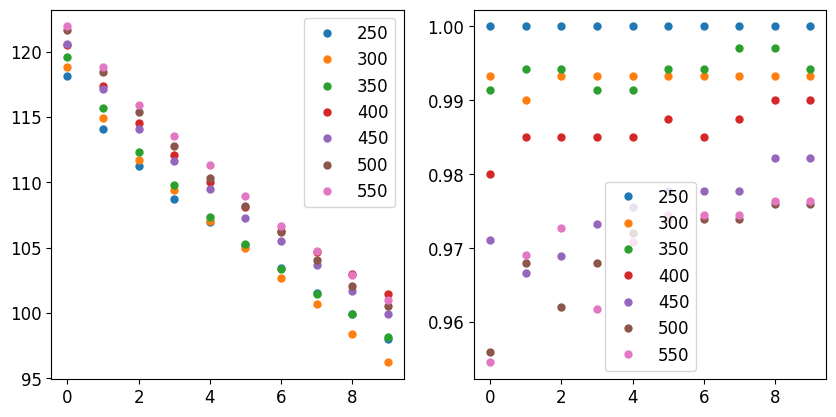

	 Jammed Myosin 



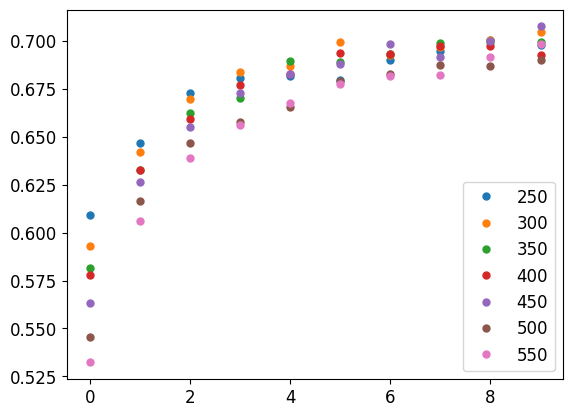

	 Myosin speed and not jammed myosin speed 



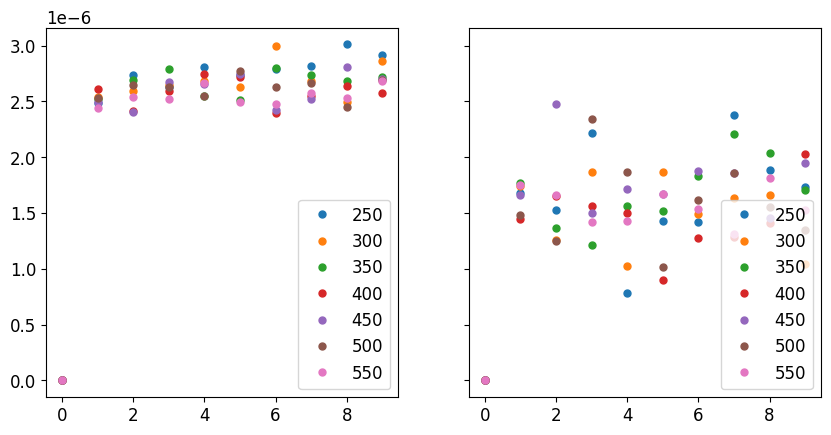

"print('\t histMDistrAlongActin \n')\nfor key in keyss:\n    print(key)\n    conta = 0\n    for axis, hist in dicR[key]['histMDistrAlongActin']:\n        conta += 1\n        if conta%2 == 0 : continue\n        M = 1\n        plt.step(np.array([np.sum(axis[i:i+M]) for i in range(0,48,M)])/M,np.array([np.sum(hist[i:i+M]) for i in range(0,48,M)])/M,label = conta)\n        #print(f'{hist[48]} {np.sum(np.array(hist))}')\n    plt.legend()\n    plt.show()\n\nprint('\t histDoubleBoundMDistrAlongActin \n')\nfor key in keyss:\n    print(key)\n    conta = 0\n    for axis, hist in dicR[key]['histDoubleBoundMDistrAlongActin']:\n        conta += 1\n        if conta % 2 == 0 : continue\n        M = 1\n        plt.step(np.array([np.sum(axis[i:i+M]) for i in range(0,48,M)])/M,np.array([np.sum(hist[i:i+M]) for i in range(0,48,M)])/M,label = conta)\n        #print(f'{hist[48]} {np.sum(np.array(hist))}')\n    plt.legend()\n    plt.show()\n\nprint('\t histMSpeedAntiparallel \n')\nfor key in keyss:\n    pri

In [17]:
#NUMERO FILAMENTI: DENSITA'
Lz_temp = '10.0'
lF_temp = '30'
v_temp = '1'
pMDE_temp = '0.00001'
labels = []
keyss = []
for nF_temp  in [250,300,350,400,450,500,550]:
    nM_temp = 10*nF_temp
    nC_temp = 2*nF_temp
    keyss.append('rw_r0-150-120_Lz'+Lz_temp+'_nF'+str(nF_temp)+'-'+lF_temp+'_nM'+str(nM_temp)+'_nC'+str(nC_temp)+'_R10-0-0-0-0-0-0-0.1-'+v_temp+'-0.00001-'+pMDE_temp+'-0.1-0.00001-0_203')
    labels.append(nF_temp)
plots(keyss, labels)

"""print('\t histMDistrAlongActin \n')
for key in keyss:
    print(key)
    conta = 0
    for axis, hist in dicR[key]['histMDistrAlongActin']:
        conta += 1
        if conta%2 == 0 : continue
        M = 1
        plt.step(np.array([np.sum(axis[i:i+M]) for i in range(0,48,M)])/M,np.array([np.sum(hist[i:i+M]) for i in range(0,48,M)])/M,label = conta)
        #print(f'{hist[48]} {np.sum(np.array(hist))}')
    plt.legend()
    plt.show()

print('\t histDoubleBoundMDistrAlongActin \n')
for key in keyss:
    print(key)
    conta = 0
    for axis, hist in dicR[key]['histDoubleBoundMDistrAlongActin']:
        conta += 1
        if conta % 2 == 0 : continue
        M = 1
        plt.step(np.array([np.sum(axis[i:i+M]) for i in range(0,48,M)])/M,np.array([np.sum(hist[i:i+M]) for i in range(0,48,M)])/M,label = conta)
        #print(f'{hist[48]} {np.sum(np.array(hist))}')
    plt.legend()
    plt.show()

print('\t histMSpeedAntiparallel \n')
for key in keyss:
    print(key)
    conta = 0
    for axis, hist in dicR[key]['histMSpeedAntiparallel']:
        conta += 1
        if conta % 2 == 1 : continue
        plt.step(axis[25:40],hist[25:40],label = conta)
        #print(f'{hist[50]} {np.sum(np.array(hist))}')
    plt.legend()
    plt.show()

print('\t histMSpeedParallel \n')
for key in keyss:
    print(key)
    conta = 0
    for axis, hist in dicR[key]['histMSpeedParallel']:
        conta += 1
        if conta % 2 == 1 : continue
        M = 1
        plt.step(np.array([np.sum(axis[i:i+M]) for i in range(25,40,M)])/M,np.array([np.sum(hist[i:i+M]) for i in range(25,40,M)])/M,label = conta)
        #print(f'{hist[50]} {np.sum(np.array(hist))}')
    plt.legend()
    plt.show()

print('\t histParallelMbond \n')
for key in keyss:
    print(key)
    fig, [ax1,ax2] = plt.subplots(1,2)
    conta = 0
    for axis1, hist1, axis2, hist2 in dicR[key]['histParallelMbond']:
        conta += 1
        if conta % 2 == 0 : continue
        M = 5
        ax1.step(np.array([np.sum(axis1[i:i+M]) for i in range(0,100,M)])/M,np.array([np.sum(hist1[i:i+M]) for i in range(0,100,M)])/M,label = conta)
        ax2.step(axis2[0:30],hist2[0:30],label = conta)
    fig.set_figwidth(10)
    ax2.legend()
    plt.show()

print('\t histAntiparallelMbond \n')
for key in keyss:
    print(key)
    fig, [ax1,ax2] = plt.subplots(1,2)
    conta = 0
    for axis1, hist1, axis2, hist2 in dicR[key]['histAntiparallelMbond']:
        conta += 1
        if conta % 2 == 0 : continue
        M = 5
        ax1.step(np.array([np.sum(axis1[i:i+M]) for i in range(0,100,M)])/M,np.array([np.sum(hist1[i:i+M]) for i in range(0,100,M)])/M,label = conta)
        ax2.step(axis2[0:30],hist2[0:30],label = conta)
    fig.set_figwidth(10)
    ax2.legend()
    plt.show()"""

	 Ring constriction and percolated fraction



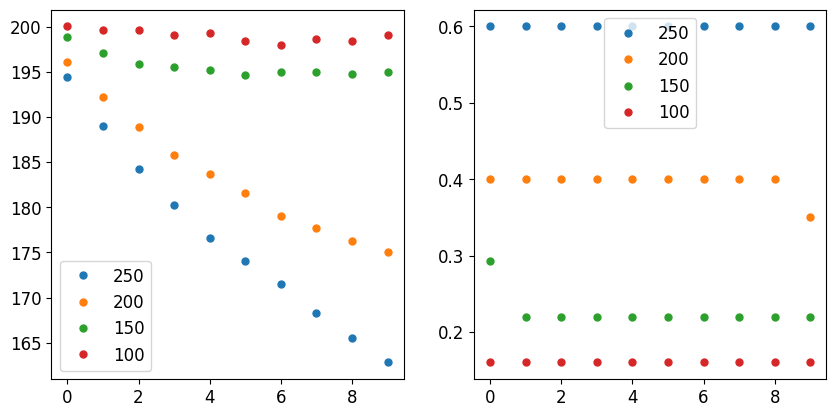

	 Jammed Myosin 



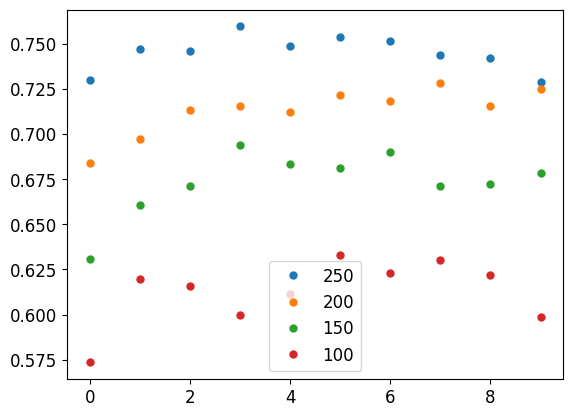

	 Myosin speed and not jammed myosin speed 



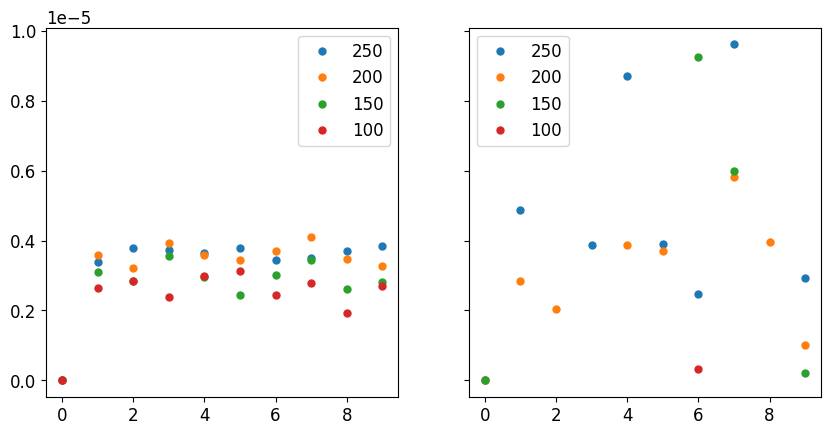

In [18]:
#NUMERO FILAMENTI: ANELLO SPEZZATO
Lz_temp = '10.0'
lF_temp = '30'
v_temp = '1'
pMDE_temp = '0.00001'
labels = []
keyss = []
for nF_temp  in [250,200,150,100]:
    nM_temp = 10*nF_temp
    keyss.append('rw_r0-250-200_Lz'+Lz_temp+'_nF'+str(nF_temp)+'-'+lF_temp+'_nM'+str(nM_temp)+'_nC0_R10-0-0-0-0-0-0-0.1-'+v_temp+'-0.00001-'+pMDE_temp+'-0-0-0_203')
    labels.append(nF_temp)
plots(keyss, labels)

	 Ring constriction and percolated fraction



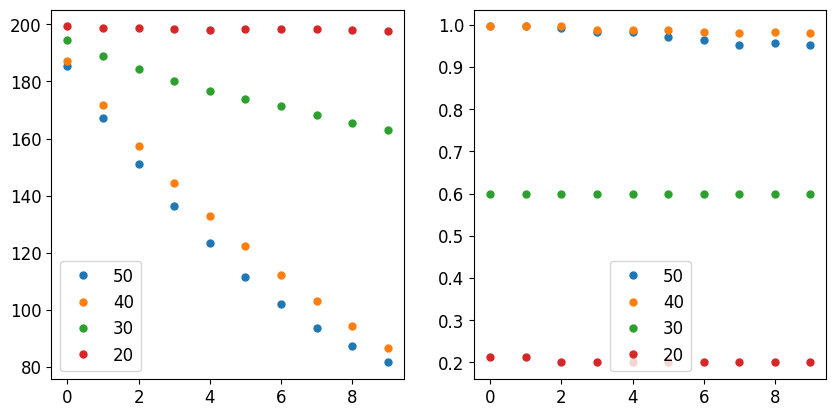

	 Jammed Myosin 



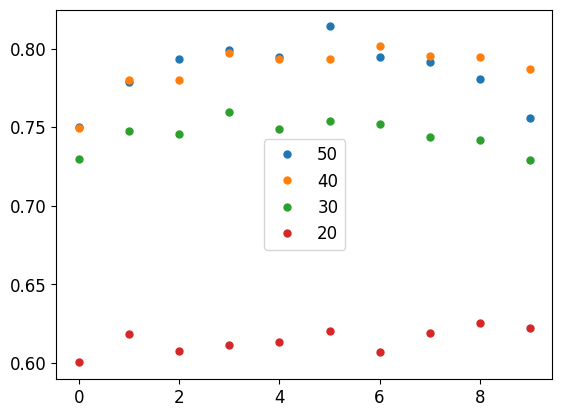

	 Myosin speed and not jammed myosin speed 



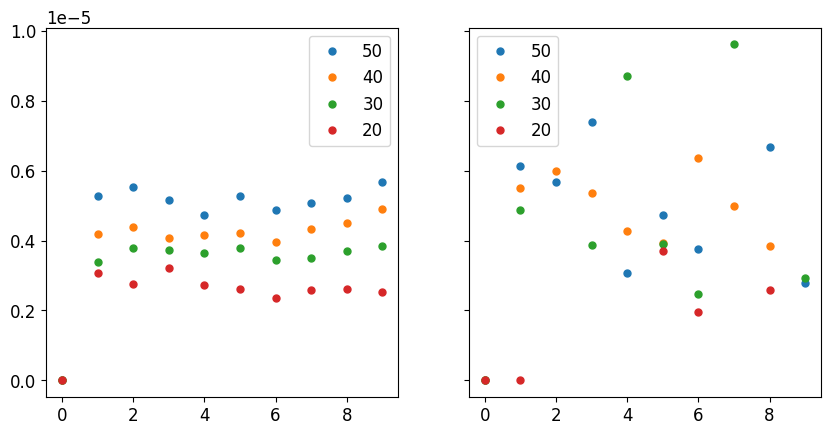

In [19]:
#LUNGHEZZA FILAMENTI
keyss = []
labels = []
Lz_temp = '10.0'
v_temp = '1'
pMDE_temp = '0.00001'
nF_temp = 250
nM_temp = 10*nF_temp
for lF_temp in ['50','40','30','20']:
    labels.append(lF_temp)
    keyss.append('rw_r0-250-200_Lz'+Lz_temp+'_nF'+str(nF_temp)+'-'+lF_temp+'_nM'+str(nM_temp)+'_nC0_R10-0-0-0-0-0-0-0.1-'+v_temp+'-0.00001-'+pMDE_temp+'-0-0-0_203')
plots(keyss, labels)

	 Ring constriction and percolated fraction



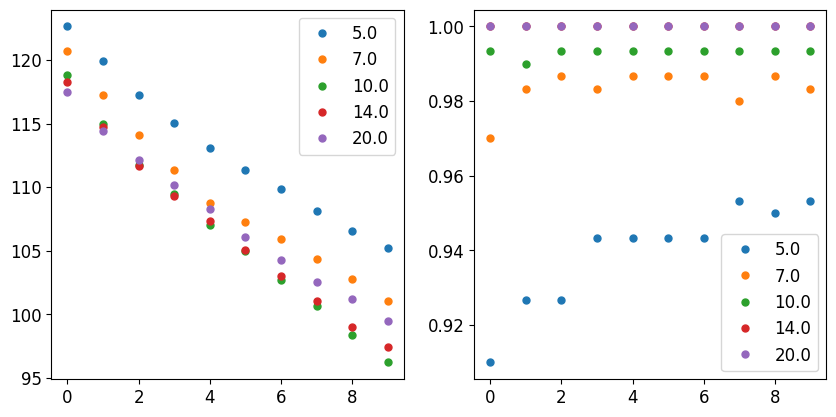

	 Jammed Myosin 



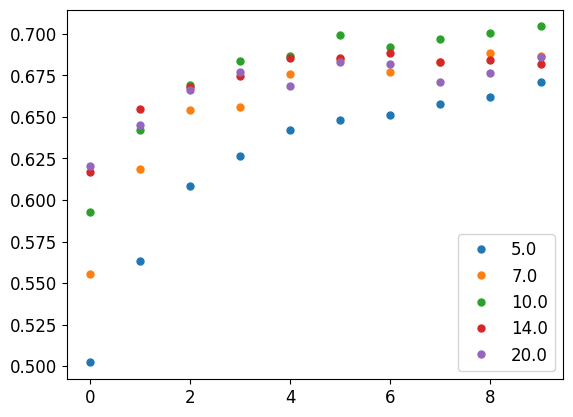

	 Myosin speed and not jammed myosin speed 



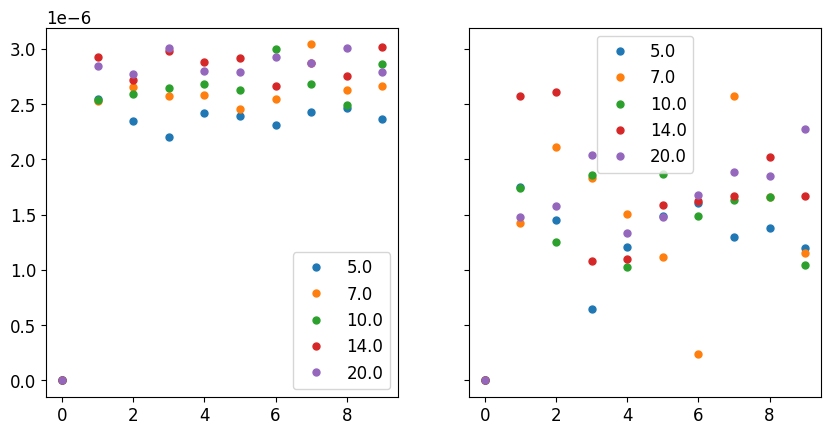

In [20]:
nF_temp = 300
#ALTEZZA BOX Lz
Lz_temp = '10.0'
lF_temp = '30'
v_temp = '1'
pMDE_temp = '0.00001'
labels = []
keyss = []
for Lz_temp in ['5.0','7.0','10.0','14.0','20.0']:
    nM_temp = 10*nF_temp
    nC_temp = 2*nF_temp
    keyss.append('rw_r0-150-120_Lz'+Lz_temp+'_nF'+str(nF_temp)+'-'+lF_temp+'_nM'+str(nM_temp)+'_nC'+str(nC_temp)+'_R10-0-0-0-0-0-0-0.1-'+v_temp+'-0.00001-'+pMDE_temp+'-0.1-0.00001-0_203')
    labels.append(Lz_temp)
plots(keyss, labels)

	 Ring constriction and percolated fraction



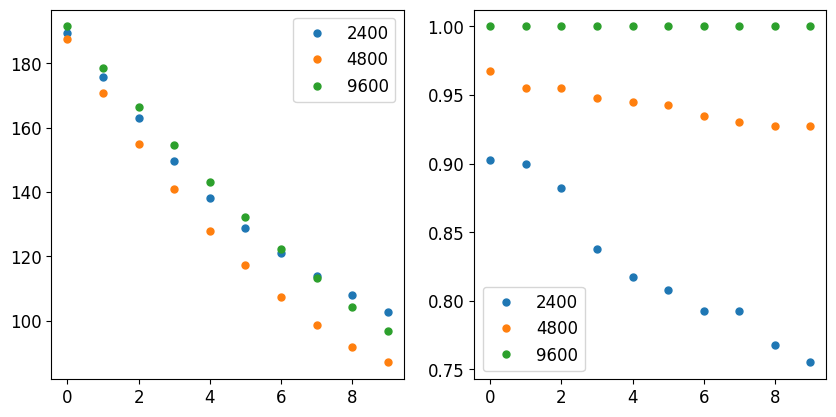

	 Jammed Myosin 



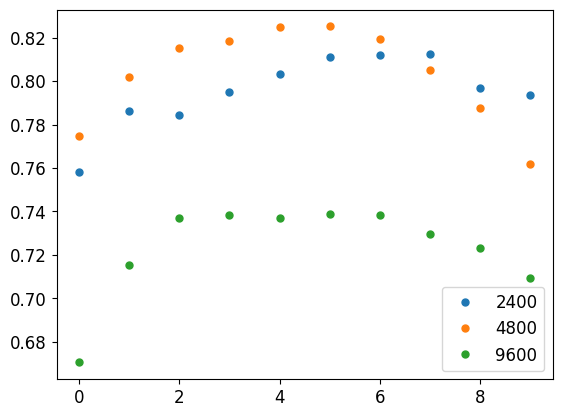

	 Myosin speed and not jammed myosin speed 



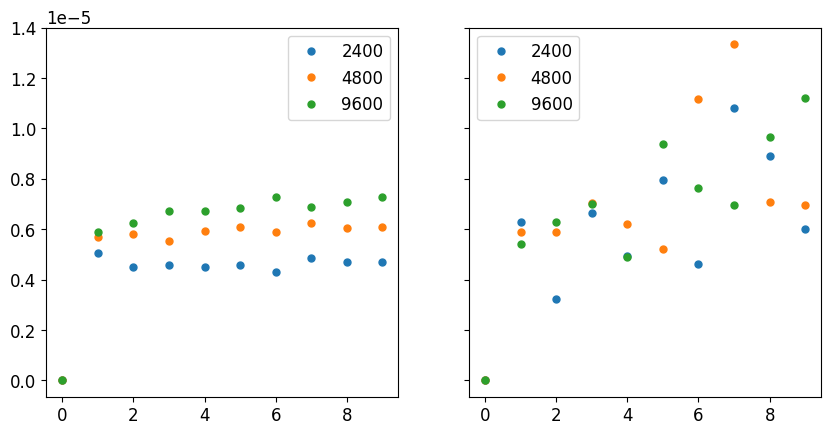

In [21]:
#NUMERO MiOSINE
keyss =  []
labels = []
for n_mot_temp in [2400,4800,9600]:
    labels.append(n_mot_temp)
    keyss.append('rw_r0-250-200_Lz10.0_nF400-50_nM'+str(n_mot_temp)+'_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0-0-0_203')

plots(keyss, labels)

	 Ring constriction and percolated fraction



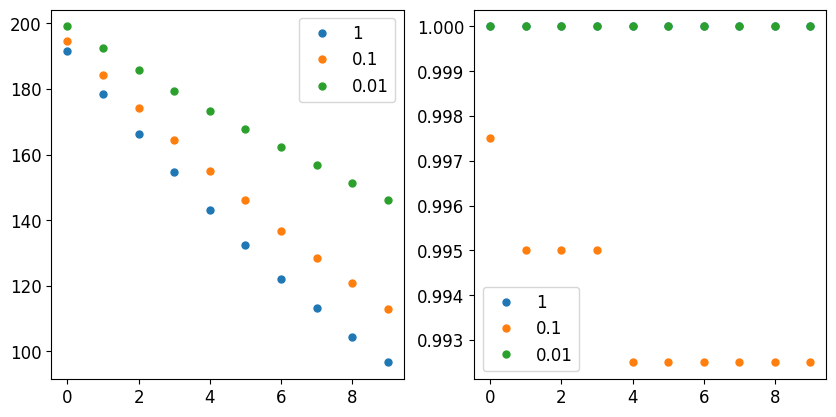

	 Jammed Myosin 



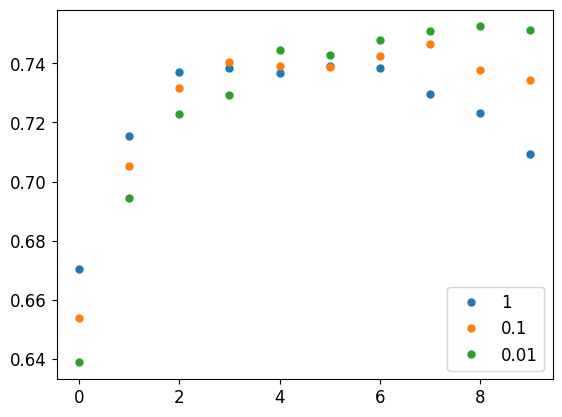

	 Myosin speed and not jammed myosin speed 



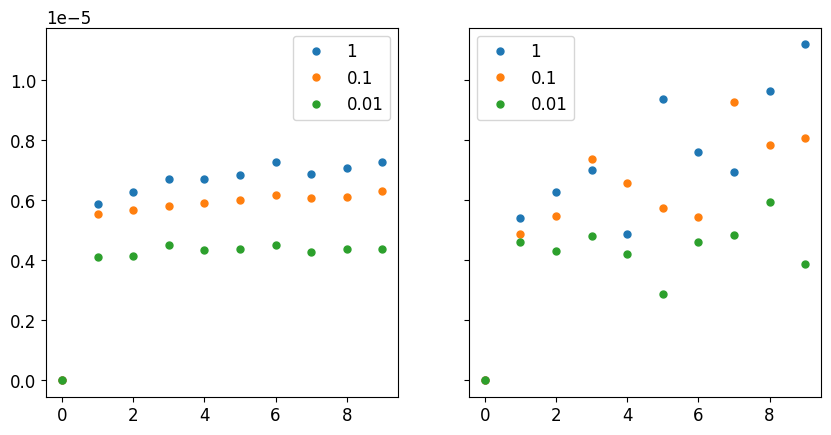

In [22]:
#VELOCITA': pMW
keyss = []
labels = []
Lz_temp = '10.0'
lF_temp = '50'
pMDE_temp = '0.00001'
nF_temp = 400
nM_temp = 9600
for v_temp in ['1','0.1','0.01']:
    labels.append(v_temp)
    keyss.append('rw_r0-250-200_Lz'+Lz_temp+'_nF'+str(nF_temp)+'-'+lF_temp+'_nM'+str(nM_temp)+'_nC0_R10-0-0-0-0-0-0-0.1-'+v_temp+'-0.00001-'+pMDE_temp+'-0-0-0_203')
plots(keyss, labels)

	 Ring constriction and percolated fraction



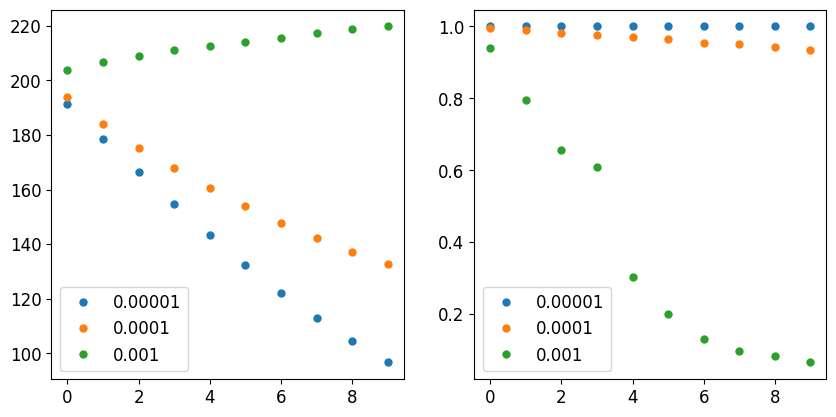

	 Jammed Myosin 



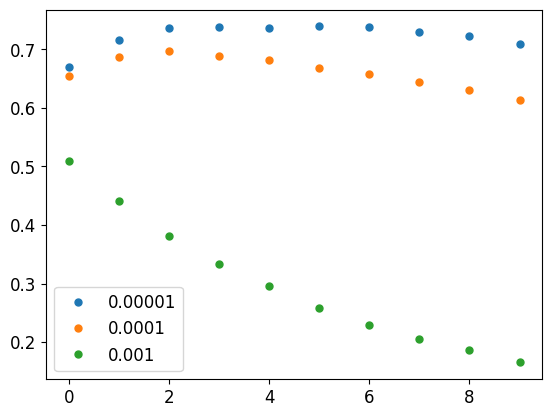

	 Myosin speed and not jammed myosin speed 



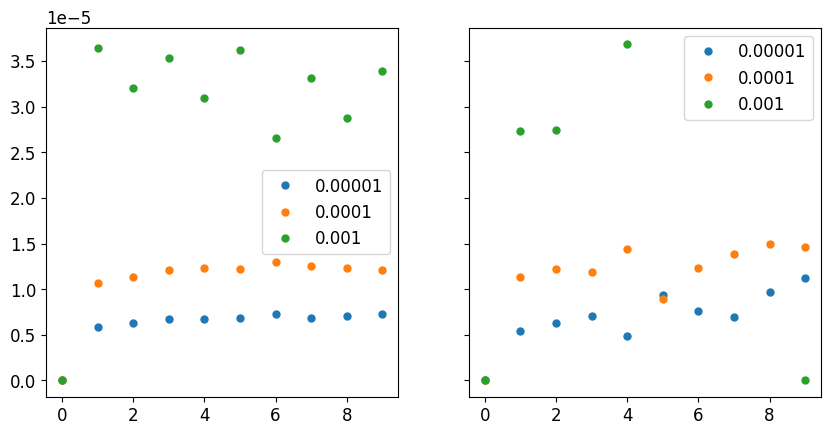

In [23]:
#DWELLING : pMDE
Lz_temp = '10.0'
lF_temp = '50'
v_temp = '1'
nF_temp = 400
nM_temp = 9600
keyss = []
labels = []
for pMDE_temp in ['0.00001','0.0001','0.001']:
    keyss.append('rw_r0-250-200_Lz'+Lz_temp+'_nF'+str(nF_temp)+'-'+lF_temp+'_nM'+str(nM_temp)+'_nC0_R10-0-0-0-0-0-0-0.1-'+v_temp+'-0.00001-'+pMDE_temp+'-0-0-0_203')
    labels.append(pMDE_temp)
plots(keyss, labels)

In [24]:
import seaborn as sns
def ale_colorplot(x_values,y_values,F,cmap,vmin,vmax,g=None,ax=None,lab = '',l=.92,b=.2,w=.03,h=.65, logay = False, logax = False, ymax = None, xmax = None):
    if g == None:
        g, ax = plt.subplots(1,1)
    f = np.zeros((len(y_values),len(x_values)))
    for i in range(len(y_values)):
        for j in range(len(x_values)):
            f[i,j] = F(x_values[j],y_values[i])
    X_grid, Y_grid = np.meshgrid(np.array(x_values).astype(np.float64),np.array(y_values).astype(np.float64))
    p = ax.pcolormesh(X_grid,Y_grid,f,cmap = cmap, vmin = vmin, vmax = vmax, shading = 'auto')
    if logax:
        ax.set_xscale('log')
        ax.set_xlim([min(x_values),xmax])
    if logay:
        ax.set_yscale('log')
        ax.set_ylim([min(np.array(y_values).astype(float)),ymax])
    g.figure.subplots_adjust(right=l)
    cax = g.figure.add_axes([l+0.02,b,w,h])
    points = plt.scatter(x=[],y=[],c=[],cmap = cmap, vmin = vmin, vmax = vmax)
    g.figure.colorbar(points,cax = cax,label = lab)

def ale_Ravg(key, timestep):
    for id, row in dicR[key].iterrows():
        if row['time'] > timestep:
            return row['Ravg']
        
def ale_PercFrac(key, timestep):
    for id, row in dicR[key].iterrows():
        if row['time'] > timestep:
            return row['PercolatedFraction']

def ale_rate_constrict(key,timestep_max):
    data_temp = dicR[key][dicR[key]['time']<=timestep_max]
    m, q = np.polyfit(x = data_temp['time'],y = data_temp['Ravg'],deg = 1)
    return m

def ale_jammed(key,timestep):
    nM_temp = getparams(key)['nM']
    for id, row in dicR[key].iterrows():
        if row['time'] > timestep:
            return row['JammedMyosins']/2./nM_temp
        
def ale_avgspeed(key):
    return dicR[key]['MSpeedAvg'].mean()

def ale_notjammedavgspeed(key):
    return dicR[key]['MSpeedNotjammedAvg'].mean()

def ale_ring_intact_flag(key,timestep=4000000):
    for id, row in dicR[key].iterrows():
        if row['time'] > timestep:
            return row['RingIntactFlag']
        
def ale_wierd_prod(key, timestep):
    nM_temp = getparams(key)['nM']
    for id, row in dicR[key].iterrows():
        if row['time'] > timestep:
            return row['MSpeedAvg']*(row['JammedMyosins']/2./nM_temp)**3

In [25]:
def build_key(Lz_temp = '10.0',lF_temp = 50, nF_temp=400,nM_temp=9600,v_temp = '1',pMDE_temp='0.00001', sd = 204):
    key = 'rw_r0-250-200_Lz'+Lz_temp+'_nF'+str(nF_temp)+'-'+str(lF_temp)+'_nM'+str(nM_temp)+'_nC0_R10-0-0-0-0-0-0-0.1-'+v_temp+'-0.00001-'+pMDE_temp+'-0-0-0_'+str(sd)
    return key

In [26]:
#non serve
v_temp = '1'
Lz_temp = '10.0'
pMDE_temp = '0.00001'
data = []
percfrac = np.zeros((8,7))
ravg = np.zeros((8,7))
lFs = np.array([10,15,20,25,30,40,50])
nFs = np.array([50,70,100,150,200,250,350,500])
for i in range(7):
    for j in range(8):
        lF_temp = lFs[i]
        nF_temp = nFs[j]
        nM_temp = 10*nF_temp
        key = 'rw_r0-250-200_Lz'+Lz_temp+'_nF'+str(nF_temp)+'-'+str(lF_temp)+'_nM'+str(nM_temp)+'_nC0_R10-0-0-0-0-0-0-0.1-'+v_temp+'-0.00001-'+pMDE_temp+'-0-0-0_203'
        if key not in middlefiles:
            key = 'rw_r0-250-200_Lz'+Lz_temp+'_nF'+str(nF_temp)+'-'+str(lF_temp)+'_nM'+str(nM_temp)+'_nC0_R10-0-0-0-0-0-0-0.1-'+v_temp+'-0.00001-'+pMDE_temp+'-0-0-0_204'
        #print(key)
        data.append([lF_temp,nF_temp,dicR[key]['Ravg'].mean(),dicR[key]['PercolatedFraction'].mean()])
        percfrac[j,i] = dicR[key]['PercolatedFraction'].mean()
        ravg[j,i] = dicR[key]['Ravg'].mean()
df_temp = pd.DataFrame(data,columns=['lF','nF','Ravg','PercFrac'])
df_temp['actin'] = df_temp['lF']*df_temp['nF']
print(df_temp)


    lF   nF        Ravg  PercFrac  actin
0   10   50  199.951691  0.100000    500
1   10   70  199.792869  0.085714    700
2   10  100  199.251416  0.083333   1000
3   10  150  200.375731  0.090667   1500
4   10  200  201.280905  0.079500   2000
5   10  250  202.587936  0.091600   2500
6   10  350  200.620633  0.114286   3500
7   10  500  202.100261  0.160200   5000
8   15   50  200.293920  0.096000    750
9   15   70  199.280103  0.095714   1050
10  15  100  198.804818  0.090000   1500
11  15  150  198.625914  0.094667   2250
12  15  200  199.113210  0.100000   3000
13  15  250  200.054881  0.119600   3750
14  15  350  198.611756  0.173429   5250
15  15  500  198.733456  0.307600   7500
16  20   50  199.371160  0.178000   1000
17  20   70  199.219461  0.117143   1400
18  20  100  199.102659  0.100000   2000
19  20  150  199.123947  0.106667   3000
20  20  200  198.552747  0.165000   4000
21  20  250  198.383674  0.202400   5000
22  20  350  195.572162  0.407429   7000
23  20  500  190

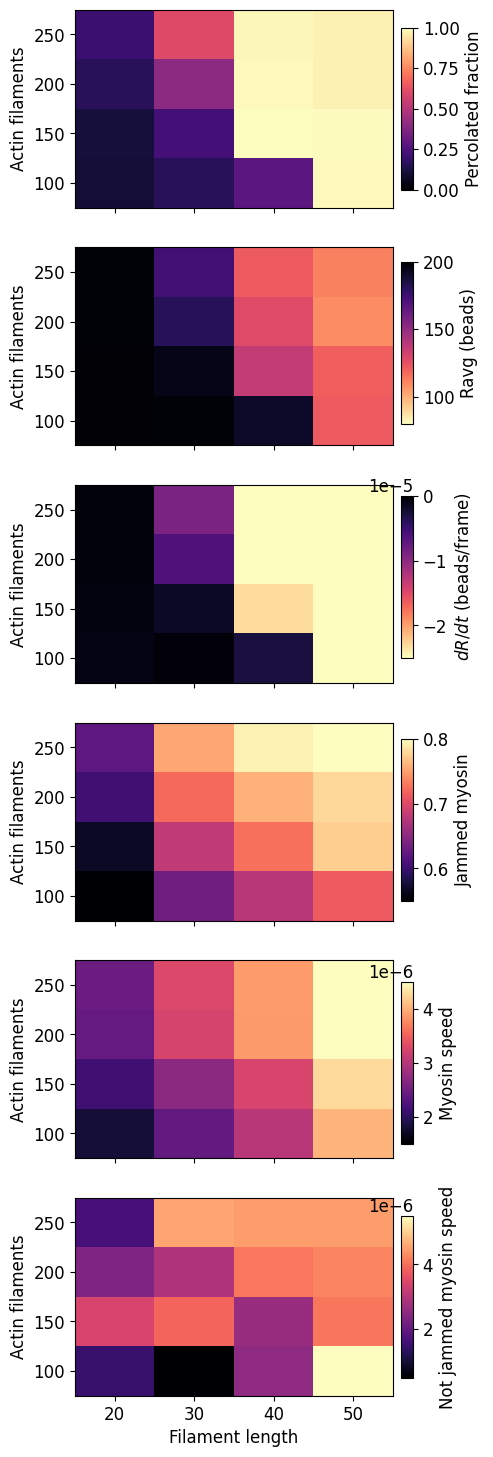

In [27]:
lFs = np.array([20,30,40,50])
nFs = np.array([100,150,200,250])

g, [ax1, ax2, ax3, ax4, ax5, ax6] = plt.subplots(6,1, sharex=True)
timestep_temp = 2500000
cmap = sns.color_palette('magma',as_cmap = True)
def PercFrac_temp(lF_temp,nF_temp):
    return ale_PercFrac(build_key(lF_temp = lF_temp, nF_temp = nF_temp, nM_temp = 10*nF_temp, sd = 203),timestep_temp)
ale_colorplot(lFs,nFs,PercFrac_temp,cmap,0.,1,g=g,ax=ax1,l=.92,b=.78 ,w=.03,h=0.09,lab='Percolated fraction')

cmap = sns.color_palette('magma_r',as_cmap = True)
def Ravg_temp(lF_temp,nF_temp):
    return ale_Ravg(build_key(lF_temp = lF_temp, nF_temp = nF_temp, nM_temp = 10*nF_temp, sd = 203),timestep_temp)
ale_colorplot(lFs,nFs,Ravg_temp,cmap,80,200,g=g,ax=ax2,l=.92,b=.65,w=.03,h=.09,lab='Ravg (beads)')

cmap = sns.color_palette('magma_r',as_cmap = True)
def rate_temp(lF_temp,nF_temp):
    return ale_rate_constrict(build_key(lF_temp = lF_temp, nF_temp = nF_temp, nM_temp = 10*nF_temp, sd = 203),timestep_temp)
ale_colorplot(lFs,nFs,rate_temp,cmap,-2.5*10**(-5),0,g=g,ax=ax3,l=.92,b=.52,w=.03,h=.09,lab='$dR/dt$ (beads/frame)')

cmap = sns.color_palette('magma',as_cmap = True)
def jammed_temp(lF_temp,nF_temp):
    return ale_jammed(build_key(lF_temp = lF_temp, nF_temp = nF_temp, nM_temp = 10*nF_temp, sd = 203),timestep_temp)
ale_colorplot(lFs,nFs,jammed_temp,cmap,0.55,0.8,g=g,ax=ax4,l=.92,b=.385,w=.03,h=.09,lab='Jammed myosin')

cmap = sns.color_palette('magma',as_cmap = True)
def avgspeed_temp(lF_temp,nF_temp):
    return ale_avgspeed(build_key(lF_temp = lF_temp, nF_temp = nF_temp, nM_temp = 10*nF_temp, sd = 203))
ale_colorplot(lFs,nFs,avgspeed_temp,cmap,1.5*10**(-6),4.5*10**(-6),g=g,ax=ax5,l=.92,b=.25,w=.03,h=.09,lab='Myosin speed')

cmap = sns.color_palette('magma',as_cmap = True)
def notjammedavgspeed_temp(lF_temp,nF_temp):
    return ale_notjammedavgspeed(build_key(lF_temp = lF_temp, nF_temp = nF_temp, nM_temp = 10*nF_temp, sd = 203))
ale_colorplot(lFs,nFs,notjammedavgspeed_temp,cmap,0.5*10**(-6),5.5*10**(-6),g=g,ax=ax6,l=.92,b=.12,w=.03,h=.09,lab='Not jammed myosin speed')

ax1.set_ylabel('Actin filaments')
ax2.set_ylabel('Actin filaments')
ax3.set_ylabel('Actin filaments')
ax4.set_ylabel('Actin filaments')
ax5.set_ylabel('Actin filaments')
ax6.set_ylabel('Actin filaments')
ax6.set_xlabel('Filament length')
g.figure.set_figwidth(4)
g.figure.set_figheight(18)

/tmp/ipykernel_1126472/2479016388.py:34: RankWarning: Polyfit may be poorly conditioned
  m, q = np.polyfit(x = data_temp['time'],y = data_temp['Ravg'],deg = 1)


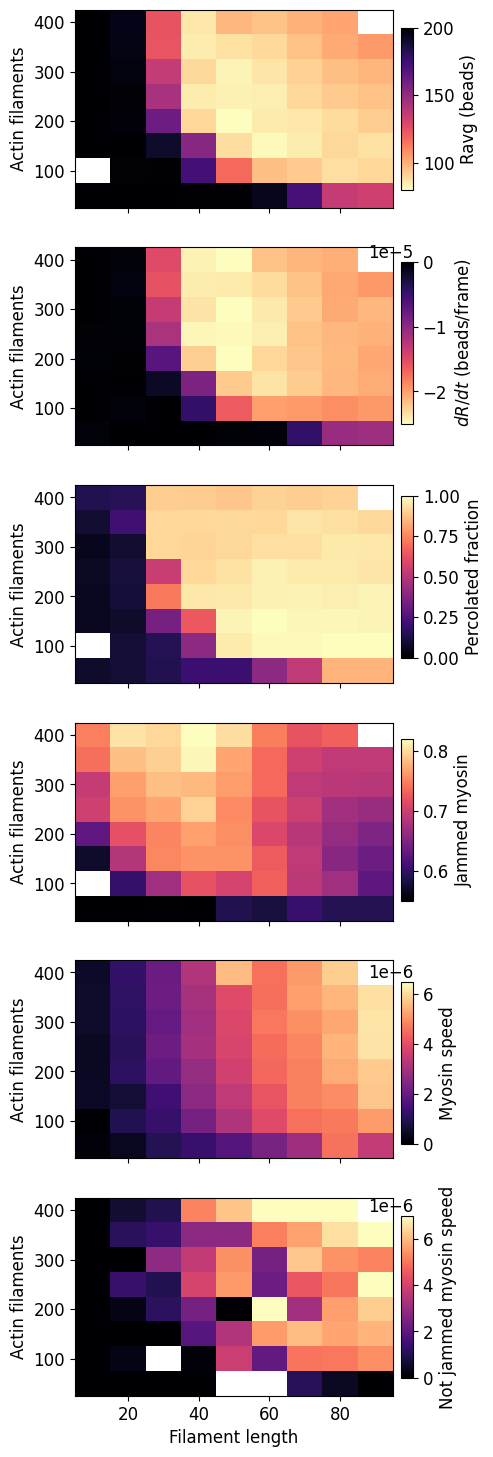

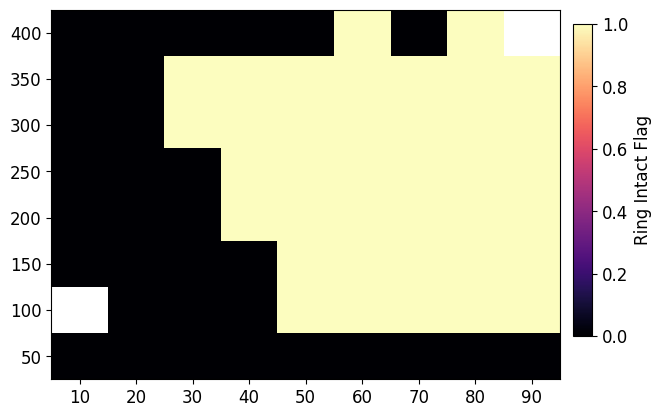

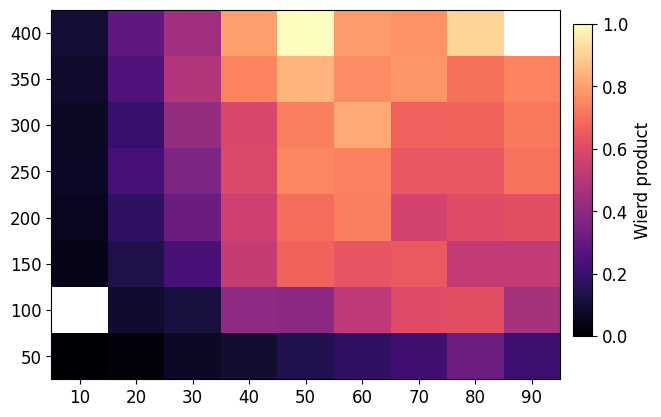

In [28]:
lFs = np.array([10,20,30,40,50,60,70,80,90])
nFs = np.array([50,100,150,200,250,300,350,400])

g, [ax1, ax2, ax3, ax4, ax5, ax6] = plt.subplots(6,1, sharex=True)
timestep_temp= 4000000

cmap = sns.color_palette('magma_r',as_cmap = True)
def Ravg_temp(lF_temp,nF_temp):
    try: return ale_Ravg(build_key(lF_temp = lF_temp, nF_temp = nF_temp, nM_temp = int(nF_temp*lF_temp/5)),timestep_temp)
    except KeyError: return np.nan
ale_colorplot(lFs,nFs,Ravg_temp,cmap,80,200,g=g,ax=ax1,l=.92,b=.78 ,w=.03,h=0.09,lab='Ravg (beads)')

cmap = sns.color_palette('magma_r',as_cmap = True)
def rate_temp(lF_temp,nF_temp):
    try: return ale_rate_constrict(build_key(lF_temp = lF_temp, nF_temp = nF_temp, nM_temp = int(nF_temp*lF_temp/5)),timestep_temp)
    except KeyError: return np.nan
ale_colorplot(lFs,nFs,rate_temp,cmap,-2.5*10**(-5),0,g=g,ax=ax2,l=.92,b=.65,w=.03,h=.09,lab='$dR/dt$ (beads/frame)')

cmap = sns.color_palette('magma',as_cmap = True)
def PercFrac_temp(lF_temp,nF_temp):
    try: return ale_PercFrac(build_key(lF_temp = lF_temp, nF_temp = nF_temp, nM_temp = int(nF_temp*lF_temp/5)),timestep_temp)
    except KeyError: return np.nan
ale_colorplot(lFs,nFs,PercFrac_temp,cmap,0.,1,g=g,ax=ax3,l=.92,b=.52,w=.03,h=.09,lab='Percolated fraction')

cmap = sns.color_palette('magma',as_cmap = True)
def jammed_temp(lF_temp,nF_temp):
    try: return ale_jammed(build_key(lF_temp = lF_temp, nF_temp = nF_temp, nM_temp = int(nF_temp*lF_temp/5)),timestep_temp)
    except KeyError: return np.nan
ale_colorplot(lFs,nFs,jammed_temp,cmap,0.55,0.82,g=g,ax=ax4,l=.92,b=.385,w=.03,h=.09,lab='Jammed myosin')

cmap = sns.color_palette('magma',as_cmap = True)
def avgspeed_temp(lF_temp,nF_temp):
    try: return ale_avgspeed(build_key(lF_temp = lF_temp, nF_temp = nF_temp, nM_temp = int(nF_temp*lF_temp/5)))
    except KeyError: return np.nan
ale_colorplot(lFs,nFs,avgspeed_temp,cmap,0,6.5*10**(-6),g=g,ax=ax5,l=.92,b=.25,w=.03,h=.09,lab='Myosin speed')

cmap = sns.color_palette('magma',as_cmap = True)
def notjammedavgspeed_temp(lF_temp,nF_temp):
    try: return ale_notjammedavgspeed(build_key(lF_temp = lF_temp, nF_temp = nF_temp, nM_temp = int(nF_temp*lF_temp/5)))
    except KeyError: return np.nan
ale_colorplot(lFs,nFs,notjammedavgspeed_temp,cmap,0,7*10**(-6),g=g,ax=ax6,l=.92,b=.12,w=.03,h=.09,lab='Not jammed myosin speed')

ax1.set_ylabel('Actin filaments')
ax2.set_ylabel('Actin filaments')
ax3.set_ylabel('Actin filaments')
ax4.set_ylabel('Actin filaments')
ax5.set_ylabel('Actin filaments')
ax6.set_ylabel('Actin filaments')
ax6.set_xlabel('Filament length')
g.figure.set_figwidth(4)
g.figure.set_figheight(18)
plt.show()

cmap = sns.color_palette('magma',as_cmap = True)
def ring_intact_temp(lF_temp,nF_temp):
    try: return ale_ring_intact_flag(build_key(lF_temp = lF_temp, nF_temp = nF_temp, nM_temp = int(nF_temp*lF_temp/5)))
    except KeyError: return np.nan
ale_colorplot(lFs,nFs,ring_intact_temp,cmap,0,1,lab='Ring Intact Flag')

cmap = sns.color_palette('magma',as_cmap = True)
def wierd_prod_temp(lF_temp,nF_temp):
    try: return ale_wierd_prod(build_key(lF_temp = lF_temp, nF_temp = nF_temp, nM_temp = int(nF_temp*lF_temp/5)),timestep_temp)
    except KeyError: return np.nan
ale_colorplot(lFs,nFs,wierd_prod_temp,cmap,None,None,lab='Wierd product')

In [29]:
nMs = np.array([300,600,1200,2400,3600,4800,6000,7200,8400,9600,12000,15600])
pMDEs = np.array(['0.00001','0.00002','0.00004','0.00008','0.00016','0.00032','0.00064','0.00128'])

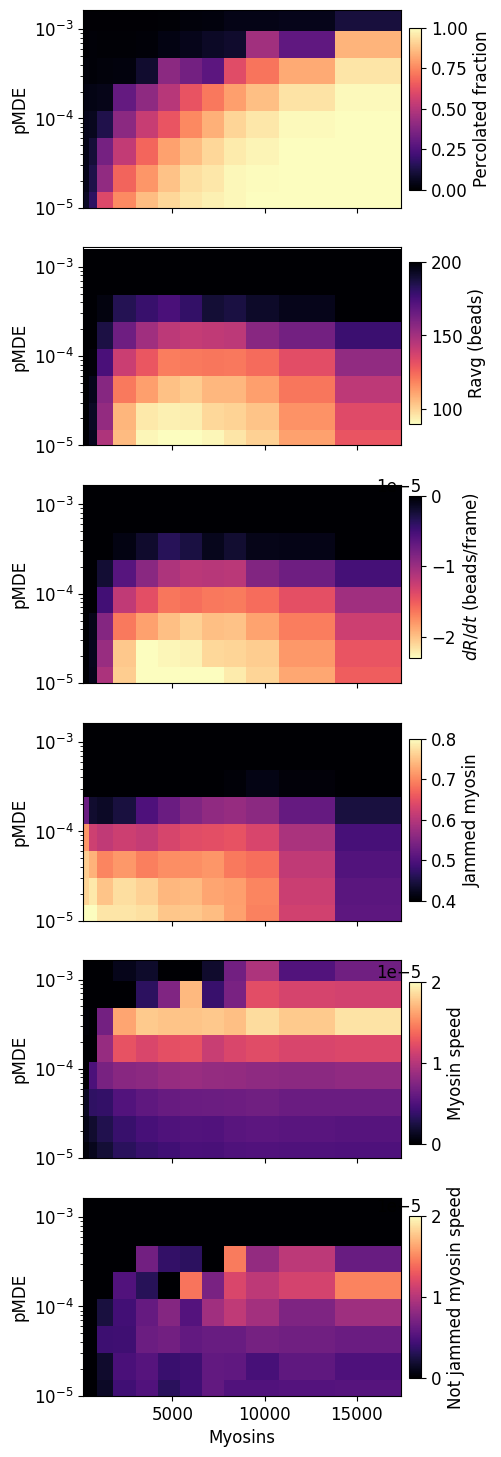

In [30]:
g, [ax1, ax2, ax3, ax4, ax5, ax6] = plt.subplots(6,1, sharex=True)

cmap = sns.color_palette('magma',as_cmap = True)
def PercFrac_temp(nM_temp,pMDE_temp):
    return ale_PercFrac(build_key(pMDE_temp = pMDE_temp, nM_temp = nM_temp),4000000)
ale_colorplot(nMs,pMDEs,PercFrac_temp,cmap,0.,1,g=g,ax=ax1,l=.92,b=.78 ,w=.03,h=0.09,lab='Percolated fraction',logay = True,ymax = 0.00165)

cmap = sns.color_palette('magma_r',as_cmap = True)
def Ravg_temp(nM_temp,pMDE_temp):
    return ale_Ravg(build_key(pMDE_temp = pMDE_temp, nM_temp = nM_temp),4000000)
ale_colorplot(nMs,pMDEs,Ravg_temp,cmap,90,200,g=g,ax=ax2,l=.92,b=.65,w=.03,h=.09,lab='Ravg (beads)',logay = True,ymax = 0.00165)

cmap = sns.color_palette('magma_r',as_cmap = True)
def rate_temp(nM_temp,pMDE_temp):
    return ale_rate_constrict(build_key(pMDE_temp = pMDE_temp, nM_temp = nM_temp),4000000)
ale_colorplot(nMs,pMDEs,rate_temp,cmap,-2.3*10**(-5),0,g=g,ax=ax3,l=.92,b=.52,w=.03,h=.09,lab='$dR/dt$ (beads/frame)',logay = True,ymax = 0.00165)

cmap = sns.color_palette('magma',as_cmap = True)
def jammed_temp(nM_temp,pMDE_temp):
    return ale_jammed(build_key(pMDE_temp = pMDE_temp, nM_temp = nM_temp),4000000)
ale_colorplot(nMs,pMDEs,jammed_temp,cmap,0.4,0.8,g=g,ax=ax4,l=.92,b=.385,w=.03,h=.09,lab='Jammed myosin',logay = True,ymax = 0.00165)

cmap = sns.color_palette('magma',as_cmap = True)
def avgspeed_temp(nM_temp,pMDE_temp):
    return ale_avgspeed(build_key(pMDE_temp = pMDE_temp, nM_temp = nM_temp))
ale_colorplot(nMs,pMDEs,avgspeed_temp,cmap,0,2*10**(-5),g=g,ax=ax5,l=.92,b=.25,w=.03,h=.09,lab='Myosin speed',logay = True,ymax = 0.00165)

cmap = sns.color_palette('magma',as_cmap = True)
def notjammedavgspeed_temp(nM_temp,pMDE_temp):
    return ale_notjammedavgspeed(build_key(pMDE_temp = pMDE_temp, nM_temp = nM_temp))
ale_colorplot(nMs,pMDEs,notjammedavgspeed_temp,cmap,0,2*10**(-5),g=g,ax=ax6,l=.92,b=.12,w=.03,h=.09,lab='Not jammed myosin speed',logay = True,ymax = 0.00165)

ax1.set_ylabel('pMDE')
ax2.set_ylabel('pMDE')
ax3.set_ylabel('pMDE')
ax4.set_ylabel('pMDE')
ax5.set_ylabel('pMDE')
ax6.set_ylabel('pMDE')
ax6.set_xlabel('Myosins')
g.figure.set_figwidth(4)
g.figure.set_figheight(18)

KeyError: 'rw_r0-250-200_Lz10.0_nF50-60_nM500_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0-0-0_204'

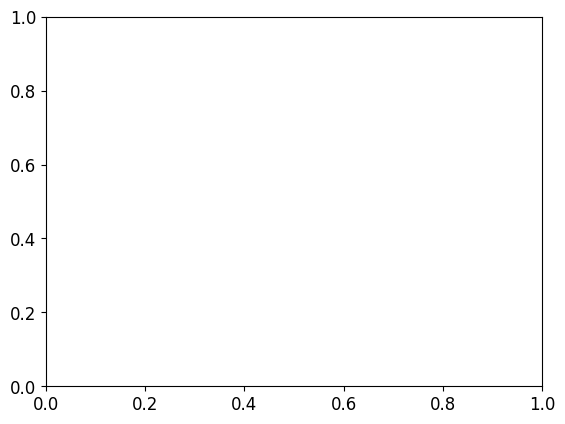

In [32]:
cmap = sns.color_palette('magma',as_cmap = True)
def PercFrac_temp(lF_temp,nF_temp):
    return ale_PercFrac(build_key(lF_temp = lF_temp, nF_temp = nF_temp, nM_temp = 10*nF_temp),4000000)
ale_colorplot(lFs,nFs,PercFrac_temp,cmap,0.,1,lab='PercFrac')

cmap = sns.color_palette('magma_r',as_cmap = True)
def Ravg_temp(lF_temp,nF_temp):
    return ale_Ravg(build_key(lF_temp = lF_temp, nF_temp = nF_temp, nM_temp = 10*nF_temp),4000000)
ale_colorplot(lFs,nFs,Ravg_temp,cmap,80,200,lab='Ravg')

cmap = sns.color_palette('magma_r',as_cmap = True)
def rate_temp(lF_temp,nF_temp):
    return ale_rate_constrict(build_key(lF_temp = lF_temp, nF_temp = nF_temp, nM_temp = 10*nF_temp))
ale_colorplot(lFs,nFs,rate_temp,cmap,-2.5*10**(-5),0,lab='rate')

cmap = sns.color_palette('magma',as_cmap = True)
def jammed_temp(lF_temp,nF_temp):
    return ale_jammed(build_key(lF_temp = lF_temp, nF_temp = nF_temp, nM_temp = 10*nF_temp),4000000)
ale_colorplot(lFs,nFs,jammed_temp,cmap,0.6,0.8,lab='jammed')

actin = np.zeros((4,4))
for i in range(4):
    for j in range(4):
        actin[j,i] = lFs[i]*nFs[j]
g, ax = plt.subplots(1,1)
cmap = sns.color_palette('magma',as_cmap = True)
X_grid, Y_grid = np.meshgrid(lFs,nFs)
p = ax.pcolormesh(X_grid,Y_grid,actin,cmap='magma', vmin = 2000, vmax = 12000)
plt.xlabel('Filament length')
g.figure.subplots_adjust(right=.92)
cax = g.figure.add_axes([.94,.2,.03,.65])
points = plt.scatter(x=[],y=[],c=[],cmap = cmap, vmin = 2000, vmax = 12000)
g.figure.colorbar(points,cax = cax,label = 'actins')
plt.show()

In [33]:
rate = []
lFs = [10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100]
for lF_temp in lFs:
    nF_temp = int(6000/lF_temp)
    key = build_key(nF_temp = nF_temp, lF_temp = lF_temp, nM_temp = int(nF_temp*lF_temp/5))
    rate.append(ale_rate_constrict(key))
plt.plot(lFs,rate)
plt.title('Constriction rate')
plt.show()

smth = []
for lF_temp in lFs:
    nF_temp = int(6000/lF_temp)
    key = build_key(nF_temp = nF_temp, lF_temp = lF_temp, nM_temp = int(nF_temp*lF_temp/5))
    smth.append(ale_PercFrac(key,4000000))
plt.plot(lFs,smth)
plt.title('PercFrac')
plt.show()

smth = []
for lF_temp in lFs:
    nF_temp = int(6000/lF_temp)
    key = build_key(nF_temp = nF_temp, lF_temp = lF_temp, nM_temp = int(nF_temp*lF_temp/5))
    smth.append(ale_jammed(key,4000000))
plt.plot(lFs,smth)
plt.title('Jammed Myosin')
plt.show()

smth = []
for lF_temp in lFs:
    nF_temp = int(6000/lF_temp)
    key = build_key(nF_temp = nF_temp, lF_temp = lF_temp, nM_temp = int(nF_temp*lF_temp/5))
    smth.append(ale_avgspeed(key))
plt.plot(lFs,smth)
plt.title('AvgSpeed')
plt.show()

smth = []
for lF_temp in lFs:
    nF_temp = int(6000/lF_temp)
    key = build_key(nF_temp = nF_temp, lF_temp = lF_temp, nM_temp = int(nF_temp*lF_temp/5))
    smth.append(ale_notjammedavgspeed(key))
plt.plot(lFs,smth)
plt.title('AvgSpeed not jammed')
plt.show()

TypeError: ale_rate_constrict() missing 1 required positional argument: 'timestep_max'

In [34]:
rate = []
lFs = [10,15,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100]
for lF_temp in lFs:
    nF_temp = int(20000/lF_temp)
    key = build_key(nF_temp = nF_temp, lF_temp = lF_temp, nM_temp = int(nF_temp*lF_temp/5))
    rate.append(ale_rate_constrict(key))
plt.plot(lFs,rate)
plt.title('Constriction rate')
plt.show()

smth = []
for lF_temp in lFs:
    nF_temp = int(20000/lF_temp)
    key = build_key(nF_temp = nF_temp, lF_temp = lF_temp, nM_temp = int(nF_temp*lF_temp/5))
    smth.append(ale_PercFrac(key,4000000))
plt.plot(lFs,smth)
plt.title('PercFrac')
plt.show()

smth = []
for lF_temp in lFs:
    nF_temp = int(20000/lF_temp)
    key = build_key(nF_temp = nF_temp, lF_temp = lF_temp, nM_temp = int(nF_temp*lF_temp/5))
    smth.append(ale_jammed(key,4000000))
plt.plot(lFs,smth)
plt.title('Jammed Myosin')
plt.show()

smth = []
for lF_temp in lFs:
    nF_temp = int(20000/lF_temp)
    key = build_key(nF_temp = nF_temp, lF_temp = lF_temp, nM_temp = int(nF_temp*lF_temp/5))
    smth.append(ale_avgspeed(key))
plt.plot(lFs,smth)
plt.title('AvgSpeed')
plt.show()

smth = []
for lF_temp in lFs:
    nF_temp = int(20000/lF_temp)
    key = build_key(nF_temp = nF_temp, lF_temp = lF_temp, nM_temp = int(nF_temp*lF_temp/5))
    smth.append(ale_notjammedavgspeed(key))
plt.plot(lFs,smth)
plt.title('AvgSpeed not jammed')
plt.show()

TypeError: ale_rate_constrict() missing 1 required positional argument: 'timestep_max'

In [ ]:
dicR.keys()

dict_keys(['rw_r0-250-200_Lz10.0_nF100-20_nM1000_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0-0-0_203', 'rw_r0-250-200_Lz10.0_nF100-30_nM1000_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0-0-0_203', 'rw_r0-250-200_Lz10.0_nF100-40_nM1000_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0-0-0_203', 'rw_r0-250-200_Lz10.0_nF100-50_nM1000_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0-0-0_203', 'rw_r0-250-200_Lz10.0_nF150-20_nM1500_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0-0-0_203', 'rw_r0-250-200_Lz10.0_nF150-30_nM1500_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0-0-0_203', 'rw_r0-250-200_Lz10.0_nF150-40_nM1500_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0-0-0_203', 'rw_r0-250-200_Lz10.0_nF150-50_nM1500_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0-0-0_203', 'rw_r0-250-200_Lz10.0_nF200-20_nM2000_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0-0-0_203', 'rw_r0-250-200_Lz10.0_nF200-30_nM2000_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0-0-0_203', 'rw_r0-250-200_Lz10.0_nF200-40_nM2000_nC0_R10-0-0-0-0-0-0-0.1-1-0.000

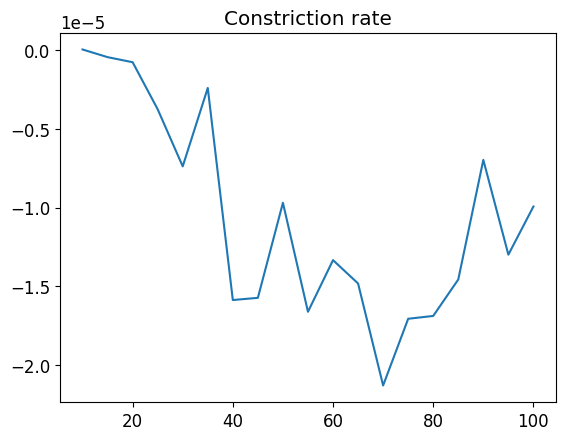

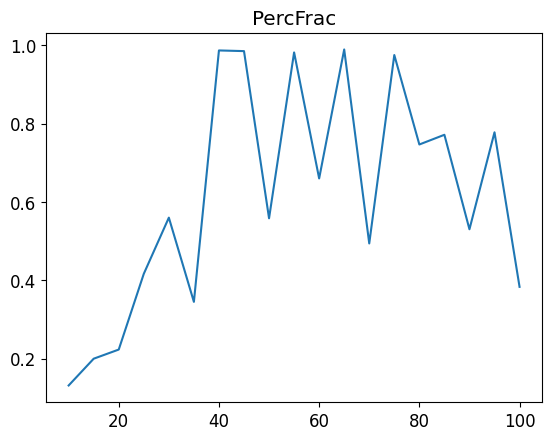

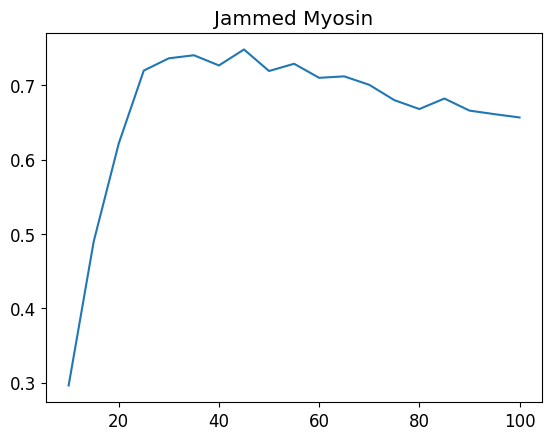

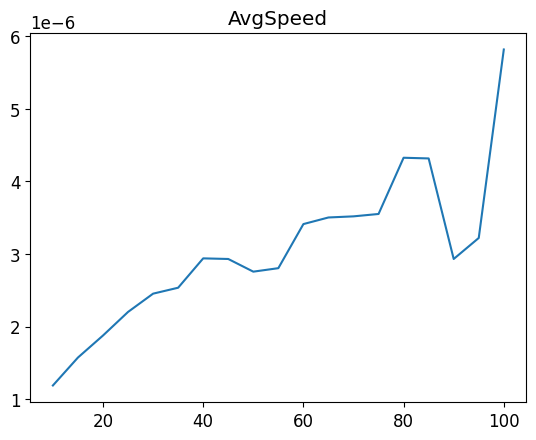

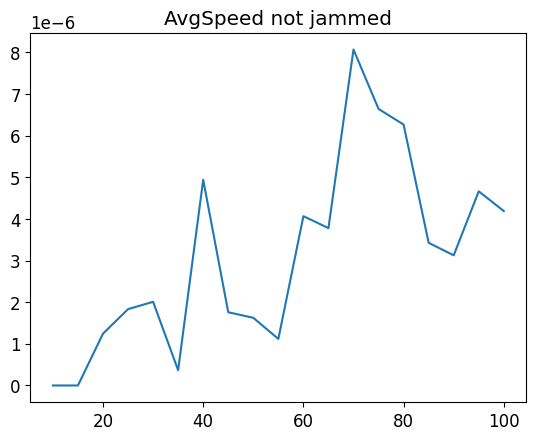

In [ ]:
rate = []
lFs = [10,15,20,25,30,35,40,45,50,55,60,65,70,75,80,85,90,95,100]
for lF_temp in lFs:
    nF_temp = int(6000/lF_temp)
    key = build_key(nF_temp = nF_temp, lF_temp = lF_temp, nM_temp = 10*nF_temp, sd = 206)
    rate.append(ale_rate_constrict(key,4000000))
plt.plot(lFs,rate)
plt.title('Constriction rate')
plt.show()

smth = []
for lF_temp in lFs:
    nF_temp = int(6000/lF_temp)
    key = build_key(nF_temp = nF_temp, lF_temp = lF_temp, nM_temp = 10*nF_temp, sd = 206)
    smth.append(ale_PercFrac(key,4000000))
plt.plot(lFs,smth)
plt.title('PercFrac')
plt.show()

smth = []
for lF_temp in lFs:
    nF_temp = int(6000/lF_temp)
    key = build_key(nF_temp = nF_temp, lF_temp = lF_temp, nM_temp = 10*nF_temp, sd = 206)
    smth.append(ale_jammed(key,4000000))
plt.plot(lFs,smth)
plt.title('Jammed Myosin')
plt.show()

smth = []
for lF_temp in lFs:
    nF_temp = int(6000/lF_temp)
    key = build_key(nF_temp = nF_temp, lF_temp = lF_temp, nM_temp = 10*nF_temp, sd = 206)
    smth.append(ale_avgspeed(key))
plt.plot(lFs,smth)
plt.title('AvgSpeed')
plt.show()

smth = []
for lF_temp in lFs:
    nF_temp = int(6000/lF_temp)
    key = build_key(nF_temp = nF_temp, lF_temp = lF_temp, nM_temp = 10*nF_temp, sd = 206)
    smth.append(ale_notjammedavgspeed(key))
plt.plot(lFs,smth)
plt.title('AvgSpeed not jammed')
plt.show()

## Myosin speed

	 Ring constriction and percolated fraction



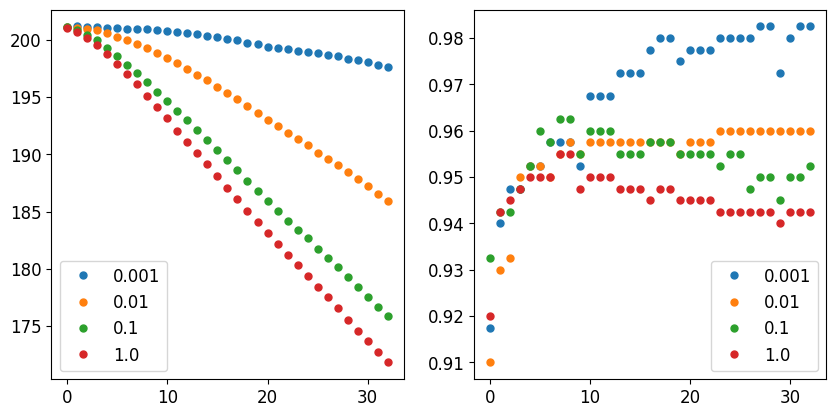

	 Jammed Myosin 



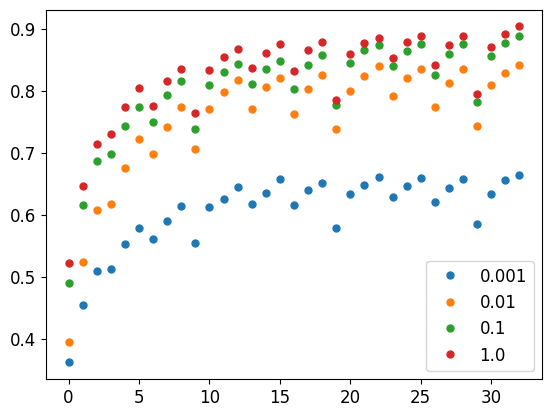

	 Myosin speed and not jammed myosin speed 



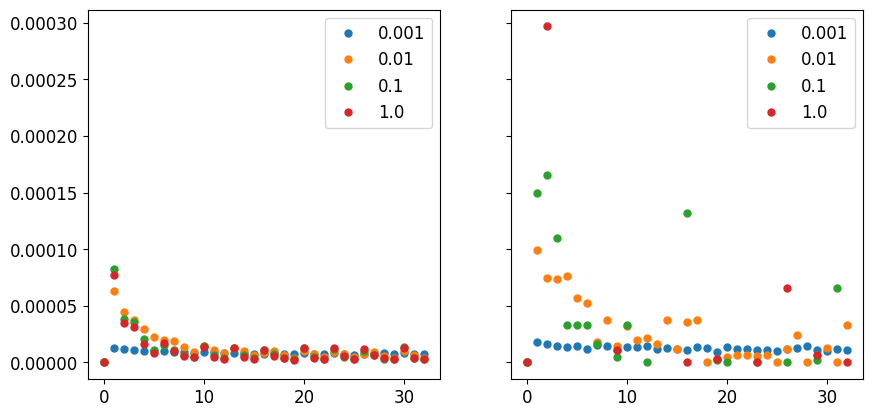

In [ ]:
labels = []
for key in finefiles:
    labels.append(getparams(key)['pMW'])
plots(finefiles,labels)

In [33]:
nodwell = subprocess.check_output("ls {:s}/Results/Traj_rw_r0-*_Lz*_nF*-*_nM*_nC*_R10-*-0.1-1-0.00001-1*_2[0-1][0-9].xyz | sed 's/.*Traj_//' | sed 's/.xyz//' ".format(folder), shell=True)
nodwell=nodwell.split()
nodwell=[a.decode("utf-8") for a in nodwell]

ls: cannot access '/home/alessandro/ISTA/ivan_original/Test_B15__Alessandro/Test_B15__Alessandro/Results/Traj_rw_r0-*_Lz*_nF*-*_nM*_nC*_R10-*-0.1-1-0.00001-1*_2[0-1][0-9].xyz': No such file or directory


In [40]:
getparams(key)

{'geom': 'rw',
 'Rcylin': 0.0,
 'Rcylout': 250.0,
 'Rring': 200.0,
 'Lz': 10.0,
 'eAA': 0,
 'nF': 100,
 'lF': 20,
 'nM': 1000,
 'nC': 0,
 'RN': 10,
 'pAN': 0.0,
 'pNN': 0.0,
 'pP': 0.0,
 'pB': 0.0,
 'pS': 0.0,
 'pD': 0.0,
 'pMA': 0.1,
 'pMW': 1.0,
 'pMD': 1e-05,
 'pMDE': 1e-05,
 'pCA': 0.0,
 'pCD': 0.0,
 'pMOC': 0.0,
 'real': 203}

In [42]:
for key in dicR.keys():
    if getparams(key)['pMDE'] == 0.00001 and getparams(key)['Rring']==200 and getparams(key)['nM']==600:
        print(key)

rw_r0-250-200_Lz10.0_nF100-30_nM600_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0-0-0_204
rw_r0-250-200_Lz10.0_nF150-20_nM600_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0-0-0_204
rw_r0-250-200_Lz10.0_nF300-10_nM600_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0-0-0_204
rw_r0-250-200_Lz10.0_nF50-60_nM600_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0-0-0_204
rw_r0-250-200_Lz10.0_nF400-50_nM600_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0-0-0_204
rw_r0-250-200_Lz10.0_nF60-100_nM600_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0-0-0_206


## Plots rw

In [27]:
# Read dictionary

with open('/home/alessandro/ISTA/ivan_original/Test_B15__Alessandro/Test_B15__Alessandro/Analysis/dicR.pickle', 'rb') as file:
    dicR=pickle.load(file)
print(len(dicR))
dicR.keys()

83


dict_keys(['rw_r0-250-100_Lz10.0_eAA1.0_nF50-50_nM1200_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-0-0-0-0_202', 'rw_r0-250-100_Lz10.0_eAA1.0_nF50-50_nM1200_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0-0-0_202', 'rw_r0-250-100_Lz10.0_eAA1.0_nF50-50_nM1200_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-1-0-0-0_202', 'rw_r0-250-100_Lz10.0_eAA1.0_nF50-50_nM300_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-0-0-0-0_202', 'rw_r0-250-100_Lz10.0_eAA1.0_nF50-50_nM300_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0-0-0_202', 'rw_r0-250-100_Lz10.0_eAA1.0_nF50-50_nM300_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-1-0-0-0_202', 'rw_r0-250-100_Lz10.0_eAA1.0_nF50-50_nM600_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-0-0-0-0_202', 'rw_r0-250-100_Lz10.0_eAA1.0_nF50-50_nM600_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0-0-0_202', 'rw_r0-250-100_Lz10.0_eAA1.0_nF50-50_nM600_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-1-0-0-0_202', 'rw_r0-250-200_Lz10.0_eAA1.0_nF100-50_nM2400_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-0-0-0-0_201', 'rw_r0-250-200_Lz10.0_eAA1.0_nF100-50_nM2400_nC0_R10-0-0

### Heat plots pMW vs pMD vd pMDE

rw_r0-250-200_Lz10.0_nF400-50_nM2400_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0-0-0_203
rw_r0-250-200_Lz10.0_nF400-50_nM2400_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-0.0001-0-0-0_203
rw_r0-250-200_Lz10.0_nF400-50_nM2400_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-0.001-0-0-0_203


KeyError: 0.001

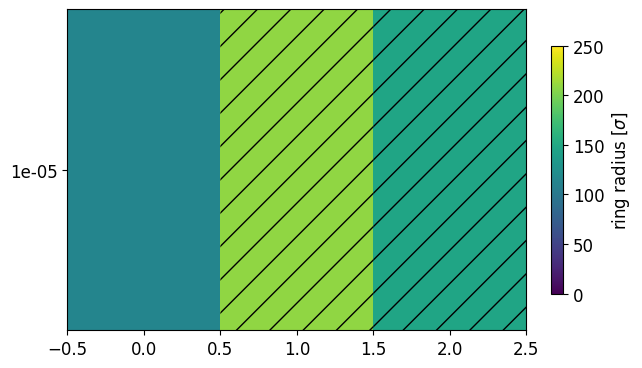

In [184]:
# Plots rw

TimestepThreshold = 4000000 # Only consider files going beyond this timestep
iavg = 1
pMWplot = 1
nCplot = 0
lFplot = 50
Rringplot = 200

if True: #for pMDplot in [0.001,0.0001,0.00001]:
    for nMplot in [2400,4800,9600]: #pMDEplot in [0,1,pMDplot]:
        for nFplot in [400]:
            for pMDEplot in [0.00001,0.0001,0.001]:

                data = []
                for filestring in dicR.keys():
                    par = getparams(filestring)
                    if par['nM']==nMplot and par['nC']==nCplot and par['nF']==nFplot and par['eAA']==0 \
                    and par['pMW']==pMWplot and par['lF']==lFplot and par['Rring']==Rringplot and par['geom']=='rw':   #par['pMD']==pMDplot and par['pMDE']==pMDEplot
                        print(filestring)
                        Df = dicR[filestring]
                        if Df.iloc[-1].time<TimestepThreshold:
                            continue
                        its = Df.index[Df['time']==TimestepThreshold].tolist()[0] + 1
                        Ravg = (Df['Ravg'].iloc[its-iavg:its]).mean()
                        RingIntactFlag = True if Df.RingIntactFlag.iloc[its-iavg:its].mean()>0.5 else False
                        RingIntactFlag = Df.PercolatedFraction.iloc[its-iavg:its].mean()
                        if par['pMDE']==par['pMD']:
                            pMDEmap = 0.5
                        else:
                            pMDEmap = par['pMDE']
                        #assert pMDEmap in [par['pMW'],0,0.5], "wrong pMDEmap"
                        BoundMyosin = Df['histAntiparallelMbond'].iloc[-1][1].sum() + Df['histParallelMbond'].iloc[-1][1].sum()  
                        data.append([par['pMD'],pMDEmap,Ravg,BoundMyosin,      RingIntactFlag])  #y,x,... ringintactflag
                        dicpMDElabel = {0:'0', 1:'1', par['pMW']:'pMW', 0.5:'pMD'}
                        pMDElabels = ['0','pMDE','1']
                data = np.array(data)
                if len(data)==0:
                    continue
                
                ylist, xlist, datadfplt = [],[],[]
                ylist = np.unique(data[:,0]).tolist()
                xlist = np.unique(data[:,1]).tolist()
                datadfplotdic = {}
                PlotLabelList = ['Rring', 'BoundMyosin']
                PlotStringDic = {'Rring':r'ring radius [$\sigma$]', 'BoundMyosin':'# bound myosin'}
                PlotVminmaxDic = {'Rring':[0,250], 'BoundMyosin':[0,nMplot]}
                PlotColormapDic = {'Rring':'viridis', 'BoundMyosin':'magma'}
                for l in PlotLabelList:
                    datadfplotdic[l] = np.NaN*np.ones((len(ylist), len(xlist)))
                datadfplotRingIntactFlag = np.NaN*np.ones((len(ylist), len(xlist)))
                for x in data:
                    i = ylist.index(x[0])
                    c = xlist.index(x[1])
                    for lindex, l in enumerate(PlotLabelList):
                        if not np.isnan(datadfplotdic[l][i,c]):
                            print("WARNING: two files for same box! x = {}, y = {}".format(x[0], x[1]))
                        datadfplotdic[l][i,c] = x[2+lindex]
                    datadfplotRingIntactFlag[i,c] = x[-1] 
                dfpltRingIntactFlag = pd.DataFrame(datadfplotRingIntactFlag, index=ylist, columns=xlist)
                #print(dfpltRingIntactFlag)
                dfpltRingIntactFlag = dfpltRingIntactFlag.sort_index(axis=1,ascending=False)
                dfpltRingIntactFlag = dfpltRingIntactFlag.sort_index(axis=0,ascending=False)
                #print(dfpltRingIntactFlag)

                        
                for l in PlotLabelList:
                    dfplt = pd.DataFrame(datadfplotdic[l], index=ylist, columns=xlist)
                    #print(dfplt)
                    #dfplt.columns = dfplt.columns.astype(int)
                    dfplt = dfplt.sort_index(axis=1,ascending=False)
                    dfplt = dfplt.sort_index(axis=0,ascending=False)
                    #dfplt = dfplt.sort_index(ascending=False)
                    #print(dfplt)

                    fig = plt.figure()
                    plt.imshow(dfplt, vmin=PlotVminmaxDic[l][0], vmax=PlotVminmaxDic[l][1], aspect=len(dfplt.columns)/len(dfplt.index)*0.7,cmap=PlotColormapDic[l])
                    ax = plt.gca()
                    colorbar = plt.colorbar(ax=ax,fraction=0.025,label=PlotStringDic[l],aspect=20)

                    # plot hashes for broken ring
                    assert (dfpltRingIntactFlag.columns==dfpltRingIntactFlag.columns).all()
                    assert (dfpltRingIntactFlag.index==dfpltRingIntactFlag.index).all()
                    y, x = np.mgrid[slice(0-0.5, len(dfpltRingIntactFlag.index) + 1-0.5, 1), slice(-0.5, len(dfpltRingIntactFlag.columns) + 1-0.5, 1)]
                    zm = np.ma.masked_greater(np.array(dfpltRingIntactFlag), 0.5)
                    plt.pcolor(x, y, zm, hatch='/', alpha=0.)  # hashed means PercolatedFlag<0.5, i.e. more than 1 cluster in sims
                
                    # Show all ticks and label them with the respective list entries
                    ax.set_yticks(np.arange(len(dfplt.index)), labels=[x for x in dfplt.index])
                    ax.set_xticks(np.arange(len(dfplt.columns)), labels=[dicpMDElabel[x] for x in dfplt.columns])
                    
                    # Rotate the tick labels and set their alignment.
                    #plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
                    # Loop over data dimensions and create text annotations.
                    #for i in range(len(nMlist)):
                    #    for j in range(len(nClist)):
                    #        text = ax.text(j, i, datadfplt[i, j],
                    #                       ha="center", va="center", color="w")
                    plt.ylabel('myosin detachment rate', size=15)
                    plt.xlabel('end detachment rate',size=15)
                    #colorbar.set_label(r'in-plane stress [kT/$\sigma^3$]',size=15)

                    texts = []
                    texts.append('nM = {:d}'.format(nMplot))
                    texts.append('nC = {:d}'.format(nCplot))
                    texts.append('eAA = {:.1f}'.format(eAAplot))
                    texts.append('nF = {:d}'.format(nFplot))
                    texts.append('pMW = {:g}'.format(pMWplot))
                    for it,text in enumerate(texts):
                        plt.annotate(text, xy=(0.95,0.95-it*0.07), xycoords='axes fraction', ha='right', va='top', size=12, c='w')
                    plt.tight_layout()

                    #plt.savefig('{:s}/Analysis/Graphs/StressHeatmap_Lx{:.0f}_pMD{:g}_pLD{:g}_pMOL{:g}_lF{:g}.pdf'.format(folder,Lxplot,pMDplot,pLDplot,pMOLplot,lFplot))
                    plt.savefig('{:s}/Analysis/Graphs/{:s}_rw_nM{:d}_nC{:d}_eAA{:.1f}_nF{:d}_pMW{:g}_ts{:d}.pdf'.format(folder,l,nMplot,nCplot,eAAplot,nFplot,pMWplot,TimestepThreshold),transparent=True)
                    plt.show()
                    plt.close()# Plot quantities from dicR

In [17]:
# Plots rw, xlist = pW

TimestepThreshold = 5000000 # Only consider files going beyond this timestep
iavg = 1
pMDplot = 0.00001
nCplot = 0
lFplot = 50
Rringplot = 200

if True: #for pMDplot in [0.001,0.0001,0.00001]:
    for nMplot in [9600]: #pMDEplot in [0,1,pMDplot]:
        for nFplot in [400]:
            for eAAplot in [0]:

                data = []
                for filestring in dicR.keys():
                    par = getparams(filestring)
                    if par['nM']==nMplot and par['nC']==nCplot and par['nF']==nFplot and par['eAA']==eAAplot \
                    and par['pMD']==pMDplot and par['lF']==lFplot and par['Rring']==Rringplot and par['geom']=='rw':   #par['pMD']==pMDplot and par['pMDE']==pMDEplot
                        print(filestring)
                        Df = dicR[filestring]
                        if Df.iloc[-1].time<TimestepThreshold:
                            continue
                        its = Df.index[Df['time']==TimestepThreshold].tolist()[0] + 1
                        Ravg = (Df['Ravg'].iloc[its-iavg:its]).mean()
                        RingIntactFlag = True if Df.RingIntactFlag.iloc[its-iavg:its].mean()>0.5 else False
                        RingIntactFlag = Df.PercolatedFraction.iloc[its-iavg:its].mean()
                        if par['pMDE']==par['pMD']:
                            pMDEmap = 0.5
                        elif par['pMDE']==par['pMW']:
                            pMDEmap = 1
                        else:
                            pMDEmap = par['pMDE']
                        assert pMDEmap in [1,0,0.5], "wrong pMDEmap"
                        BoundMyosin = Df['histAntiparallelMbond'].iloc[-1][1].sum() + Df['histParallelMbond'].iloc[-1][1].sum()  
                        data.append([par['pMW'],pMDEmap,Ravg,BoundMyosin,      RingIntactFlag])  #y,x,... ringintactflag
                        dicpMDElabel = {0:'0', 1:'pMW', 0.5:'pMD'}
                data = np.array(data)
                if len(data)==0:
                    continue
                
                ylist, xlist, datadfplt = [],[],[]
                ylist = np.unique(data[:,0]).tolist()
                xlist = np.unique(data[:,1]).tolist()
                datadfplotdic = {}
                PlotLabelList = ['Rring', 'BoundMyosin']
                PlotStringDic = {'Rring':r'ring radius [$\sigma$]', 'BoundMyosin':'# bound myosin'}
                PlotVminmaxDic = {'Rring':[0,250], 'BoundMyosin':[0,nMplot]}
                PlotColormapDic = {'Rring':'viridis', 'BoundMyosin':'magma'}
                for l in PlotLabelList:
                    datadfplotdic[l] = np.NaN*np.ones((len(ylist), len(xlist)))
                datadfplotRingIntactFlag = np.NaN*np.ones((len(ylist), len(xlist)))
                for x in data:
                    i = ylist.index(x[0])
                    c = xlist.index(x[1])
                    for lindex, l in enumerate(PlotLabelList):
                        if not np.isnan(datadfplotdic[l][i,c]):
                            print("WARNING: two files for same box! x = {}, y = {}".format(x[0], x[1]))
                        datadfplotdic[l][i,c] = x[2+lindex]
                    datadfplotRingIntactFlag[i,c] = x[-1] 
                dfpltRingIntactFlag = pd.DataFrame(datadfplotRingIntactFlag, index=ylist, columns=xlist)
                print(dfpltRingIntactFlag)
                dfpltRingIntactFlag = dfpltRingIntactFlag.sort_index(axis=1,ascending=False)
                dfpltRingIntactFlag = dfpltRingIntactFlag.sort_index(axis=0,ascending=False)
                print(dfpltRingIntactFlag)

                        
                for l in PlotLabelList:
                    dfplt = pd.DataFrame(datadfplotdic[l], index=ylist, columns=xlist)
                    print(dfplt)
                    #dfplt.columns = dfplt.columns.astype(int)
                    dfplt = dfplt.sort_index(axis=1,ascending=False)
                    dfplt = dfplt.sort_index(axis=0,ascending=False)
                    #dfplt = dfplt.sort_index(ascending=False)
                    print(dfplt)

                    fig = plt.figure()
                    plt.imshow(dfplt, vmin=PlotVminmaxDic[l][0], vmax=PlotVminmaxDic[l][1], aspect=len(dfplt.columns)/len(dfplt.index)*0.7,cmap=PlotColormapDic[l])
                    ax = plt.gca()
                    colorbar = plt.colorbar(ax=ax,fraction=0.025,label=PlotStringDic[l],aspect=20)

                    # plot hashes for broken ring
                    assert (dfpltRingIntactFlag.columns==dfpltRingIntactFlag.columns).all()
                    assert (dfpltRingIntactFlag.index==dfpltRingIntactFlag.index).all()
                    y, x = np.mgrid[slice(0-0.5, len(dfpltRingIntactFlag.index) + 1-0.5, 1), slice(-0.5, len(dfpltRingIntactFlag.columns) + 1-0.5, 1)]
                    zm = np.ma.masked_greater(np.array(dfpltRingIntactFlag), 0.5)
                    plt.pcolor(x, y, zm, hatch='/', alpha=0.)  # hashed means PercolatedFlag<0.5, i.e. more than 1 cluster in sims
                
                    # Show all ticks and label them with the respective list entries
                    ax.set_yticks(np.arange(len(dfplt.index)), labels=[x for x in dfplt.index])
                    ax.set_xticks(np.arange(len(dfplt.columns)), labels=[dicpMDElabel[x] for x in dfplt.columns])
                    
                    # Rotate the tick labels and set their alignment.
                    #plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")
                    # Loop over data dimensions and create text annotations.
                    #for i in range(len(nMlist)):
                    #    for j in range(len(nClist)):
                    #        text = ax.text(j, i, datadfplt[i, j],
                    #                       ha="center", va="center", color="w")
                    plt.ylabel('myosin walking rate', size=15)
                    plt.xlabel('end detachment rate',size=15)
                    #colorbar.set_label(r'in-plane stress [kT/$\sigma^3$]',size=15)

                    texts = []
                    texts.append('nM = {:d}'.format(nMplot))
                    texts.append('nC = {:d}'.format(nCplot))
                    texts.append('eAA = {:.1f}'.format(eAAplot))
                    texts.append('nF = {:d}'.format(nFplot))
                    texts.append('pMD = {:g}'.format(pMDplot))
                    for it,text in enumerate(texts):
                        plt.annotate(text, xy=(0.95,0.95-it*0.07), xycoords='axes fraction', ha='right', va='top', size=12, c='w')
                    plt.tight_layout()

                    #plt.savefig('{:s}/Analysis/Graphs/StressHeatmap_Lx{:.0f}_pMD{:g}_pLD{:g}_pMOL{:g}_lF{:g}.pdf'.format(folder,Lxplot,pMDplot,pLDplot,pMOLplot,lFplot))
                    plt.savefig('{:s}/Analysis/Graphs/{:s}_rw_nM{:d}_nC{:d}_eAA{:.1f}_nF{:d}_pMD{:g}_ts{:d}.pdf'.format(folder,l,nMplot,nCplot,eAAplot,nFplot,pMDplot,TimestepThreshold),transparent=True)
                    plt.show()
                    plt.close()# Plot quantities from dicR

### Correlation nM vs rAvg

rw_r0-250-200_Lz10.0_eAA1.0_nF400-50_nM1200_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-0-0-0-0_201
rw_r0-250-200_Lz10.0_eAA1.0_nF400-50_nM1200_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0-0-0_201
rw_r0-250-200_Lz10.0_eAA1.0_nF400-50_nM1200_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-1-0-0-0_201
rw_r0-250-200_Lz10.0_eAA1.0_nF400-50_nM1200_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-0-0-0-0_201
rw_r0-250-200_Lz10.0_eAA1.0_nF400-50_nM1200_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-0.0001-0-0-0_201
rw_r0-250-200_Lz10.0_eAA1.0_nF400-50_nM1200_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-1-0-0-0_201
rw_r0-250-200_Lz10.0_eAA1.0_nF400-50_nM1200_nC0_R10-0-0-0-0-0-0-0.1-1-0.001-0-0-0-0_201
rw_r0-250-200_Lz10.0_eAA1.0_nF400-50_nM1200_nC0_R10-0-0-0-0-0-0-0.1-1-0.001-0.001-0-0-0_201
rw_r0-250-200_Lz10.0_eAA1.0_nF400-50_nM1200_nC0_R10-0-0-0-0-0-0-0.1-1-0.001-1-0-0-0_201
rw_r0-250-200_Lz10.0_eAA1.0_nF400-50_nM2400_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-0-0-0-0_201
rw_r0-250-200_Lz10.0_eAA1.0_nF400-50_nM2400_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0-0-0_20

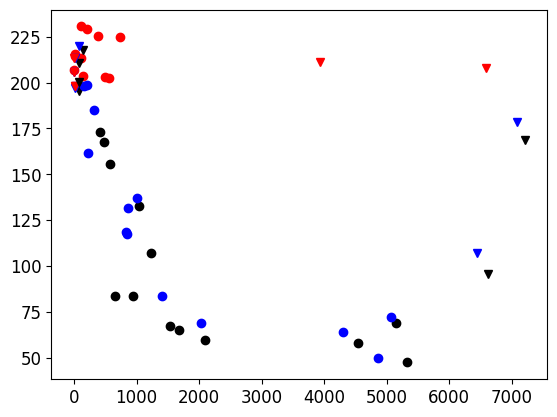

In [28]:
TimestepThreshold=10000000
iavg=1
Rringplot=200
lFplot=50
nCplot=0
nFplot=400
for filestring in dicR.keys():
    par = getparams(filestring)
    if par['nC']==nCplot and par['nF']==nFplot and par['lF']==lFplot and par['Rring']==Rringplot and par['geom']=='rw':   #par['pMD']==pMDplot and par['pMDE']==pMDEplot
        print(filestring)
        Df = dicR[filestring]
        if Df.iloc[-1].time<TimestepThreshold:
            continue
        its = Df.index[Df['time']==TimestepThreshold].tolist()[0] + 1
        Ravg = (Df['Ravg'].iloc[its-iavg:its]).mean()
        RingIntactFlag = True if Df.RingIntactFlag.iloc[its-iavg:its].mean()>0.5 else False
        RingIntactFlag = Df.PercolatedFraction.iloc[its-iavg:its].mean()
        BoundMyosin = Df['histAntiparallelMbond'].iloc[-1][1].sum() + Df['histParallelMbond'].iloc[-1][1].sum()  
        if par['pMDE']==par['pMD']:
            color='b'
        elif par['pMDE']<par['pMD']:
            color='k'
        else:
            color='r'
        if par['pMD']>0.0001*par['pMW']:
            marker='v'
        else:
            marker='o'
        plt.plot(BoundMyosin,Ravg,marker,c=color)  #y,x,... ringintactflag

In [32]:
def update_annot(ind):
    x,y = line.get_data()
    annot.xy = (x[ind["ind"][0]], y[ind["ind"][0]])
    text = "{}, {}".format(" ".join(list(map(str,ind["ind"]))), 
                           " ".join([names[n] for n in ind["ind"]]))
    annot.set_text(text)
    annot.get_bbox_patch().set_alpha(0.4)


def hover(event):
    vis = annot.get_visible()
    if event.inaxes == ax:
        cont, ind = line.contains(event)
        if cont:
            update_annot(ind)
            annot.set_visible(True)
            fig.canvas.draw_idle()
        else:
            if vis:
                annot.set_visible(False)
                fig.canvas.draw_idle()


rw_r0-250-200_Lz10.0_eAA1.0_nF400-50_nM1200_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-0-0-0-0_201
rw_r0-250-200_Lz10.0_eAA1.0_nF400-50_nM1200_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0-0-0_201
rw_r0-250-200_Lz10.0_eAA1.0_nF400-50_nM1200_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-1-0-0-0_201
rw_r0-250-200_Lz10.0_eAA1.0_nF400-50_nM1200_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-0-0-0-0_201
rw_r0-250-200_Lz10.0_eAA1.0_nF400-50_nM1200_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-0.0001-0-0-0_201
rw_r0-250-200_Lz10.0_eAA1.0_nF400-50_nM1200_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-1-0-0-0_201
rw_r0-250-200_Lz10.0_eAA1.0_nF400-50_nM1200_nC0_R10-0-0-0-0-0-0-0.1-1-0.001-0-0-0-0_201
rw_r0-250-200_Lz10.0_eAA1.0_nF400-50_nM1200_nC0_R10-0-0-0-0-0-0-0.1-1-0.001-0.001-0-0-0_201
rw_r0-250-200_Lz10.0_eAA1.0_nF400-50_nM1200_nC0_R10-0-0-0-0-0-0-0.1-1-0.001-1-0-0-0_201
rw_r0-250-200_Lz10.0_eAA1.0_nF400-50_nM2400_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-0-0-0-0_201
rw_r0-250-200_Lz10.0_eAA1.0_nF400-50_nM2400_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0-0-0_20

'\nfor ifig in [1,2]:\n    fig = plt.figure(ifig)\n    fig.canvas.mpl_connect("motion_notify_event", hover)\n    plt.show()\n    '

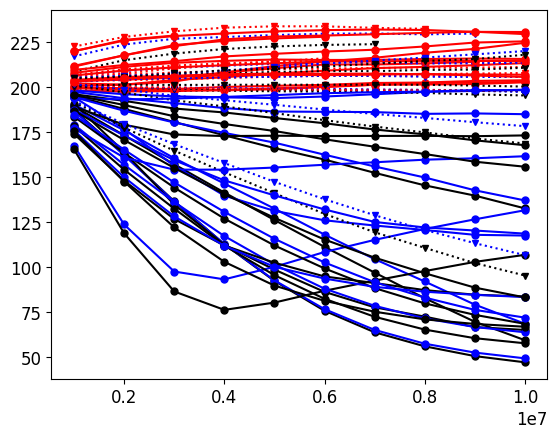

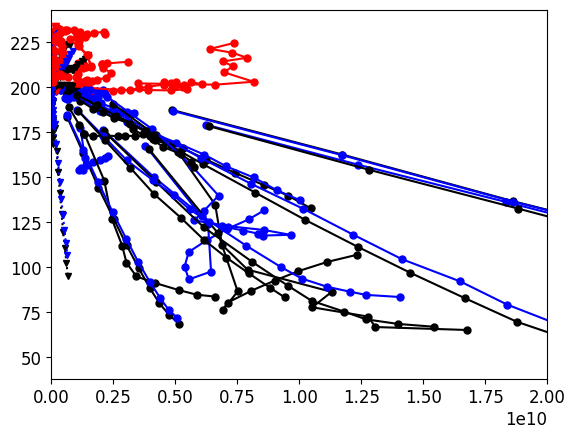

In [33]:
# rescaled time vs rAvg
Rringplot=200
lFplot=50
nCplot=0
nFplot=400
for filestring in dicR.keys():
    par = getparams(filestring)
    if par['nC']==nCplot and par['nF']==nFplot and par['lF']==lFplot and par['Rring']==Rringplot and par['geom']=='rw':   #par['pMD']==pMDplot and par['pMDE']==pMDEplot
        print(filestring)
        Df = dicR[filestring]
        time = Df.time
        Ravg = Df['Ravg']
        BoundMyosin = []
        for i,Dfline in Df.iterrows():
            BoundMyosin.append( Dfline['histAntiparallelMbond'][1].sum() + Dfline['histParallelMbond'][1].sum()  )
        
        if par['pMDE']==par['pMD']:
            color='b'
        elif par['pMDE']<par['pMD']:
            color='k'
        else:
            color='r'
        if par['pMD']>=0.001*par['pMW']:
            marker='v:'
        else:
            marker='o-'
        plt.figure(1)
        plt.plot(time*BoundMyosin*par['pMW'],Ravg,marker,c=color,ms=5)  #y,x,... ringintactflag
        plt.figure(2)
        plt.plot(time,Ravg,marker,c=color,ms=5)  #y,x,... ringintactflag

plt.figure(1)
plt.xlim([0,2e10])
'''
for ifig in [1,2]:
    fig = plt.figure(ifig)
    fig.canvas.mpl_connect("motion_notify_event", hover)
    plt.show()
    '''

### Plots per sim

rw_r0-250-200_Lz10.0_eAA1.0_nF400-50_nM1200_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0-0-0_201
rw_r0-250-200_Lz10.0_eAA1.0_nF400-50_nM1200_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-1-0-0-0_201


/var/folders/r9/smk0v8f53xz3gxjck33br70w0000gn/T/ipykernel_70998/3172493566.py:157: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig101,axs=plt.subplots(1,3,sharey=True, figsize=(3*3,2))


rw_r0-250-200_Lz10.0_eAA1.0_nF400-50_nM2400_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0-0-0_201
rw_r0-250-200_Lz10.0_eAA1.0_nF400-50_nM2400_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-1-0-0-0_201
rw_r0-250-200_Lz10.0_eAA1.0_nF400-50_nM9600_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-0.00001-0-0-0_201
rw_r0-250-200_Lz10.0_eAA1.0_nF400-50_nM9600_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-1-0-0-0_201


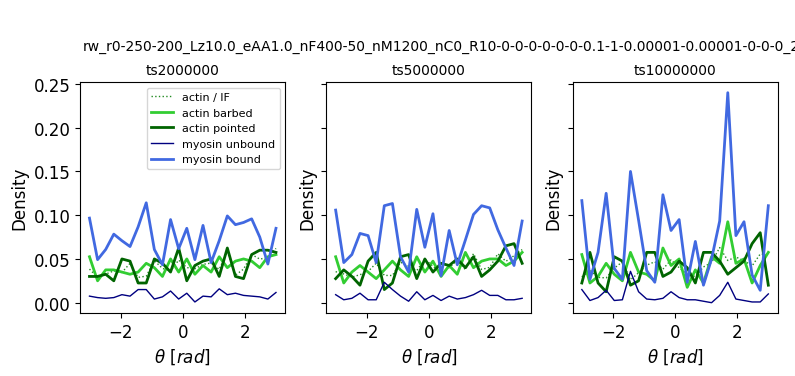

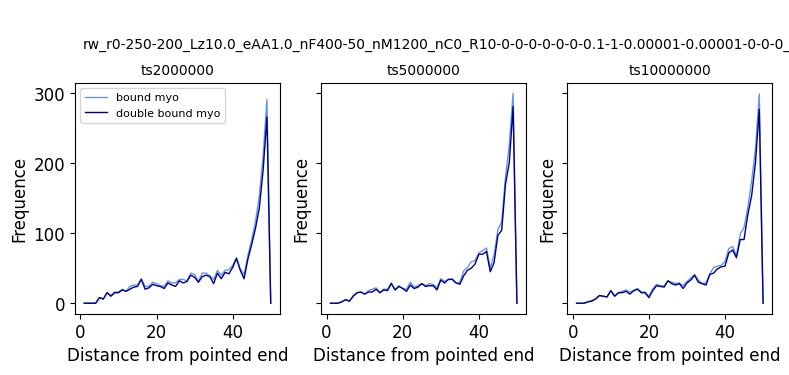

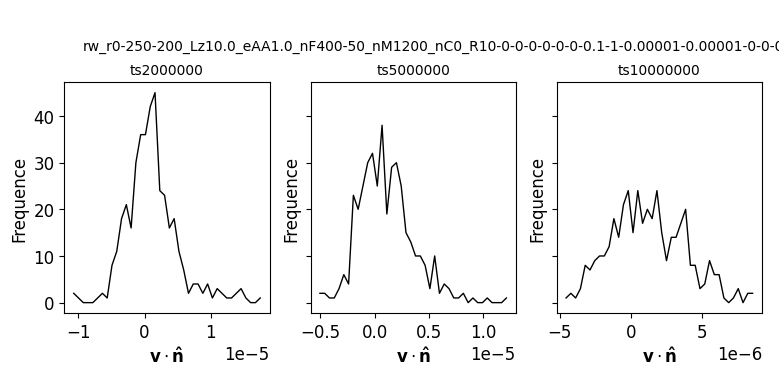

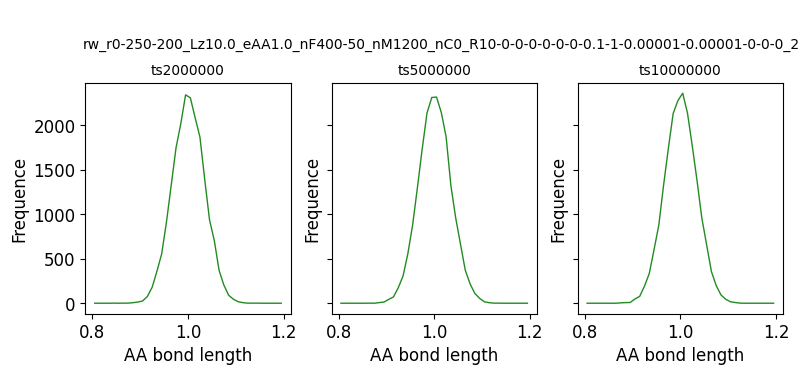

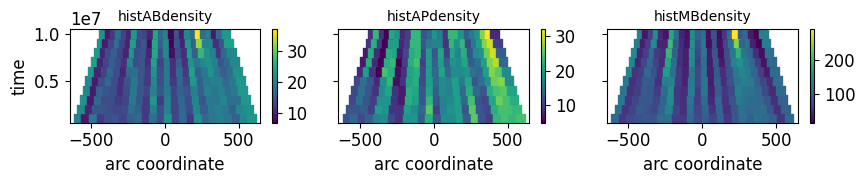

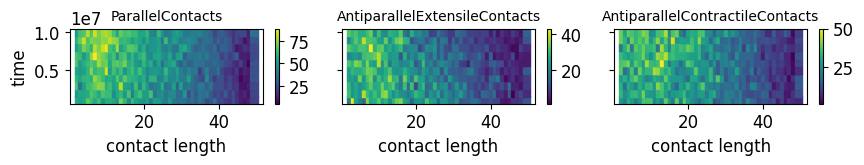

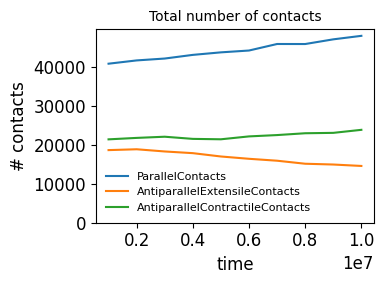

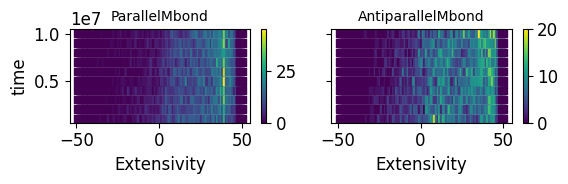

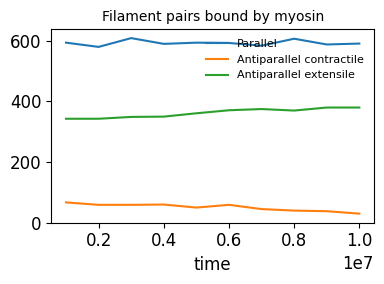

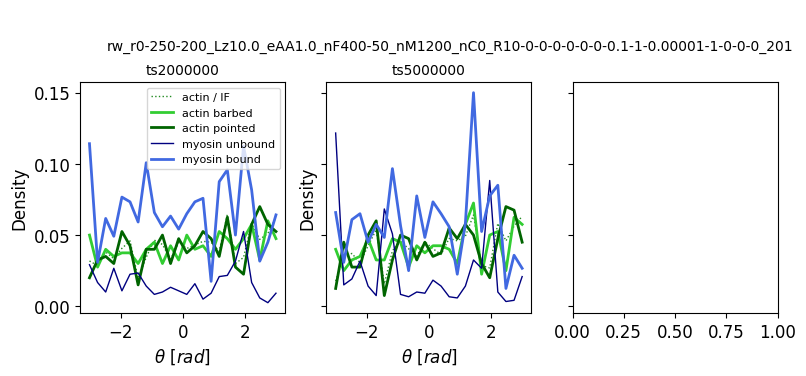

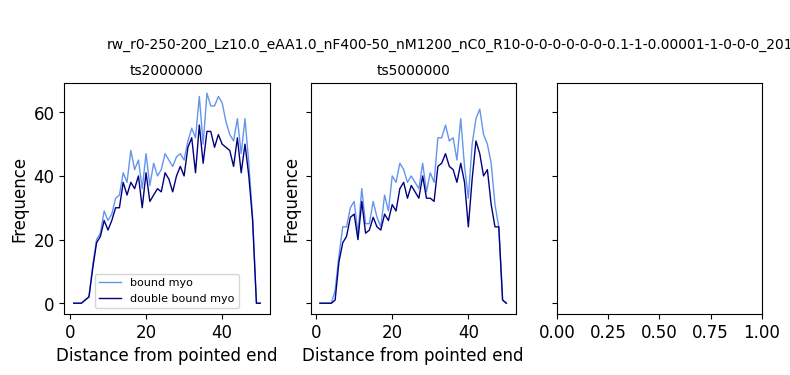

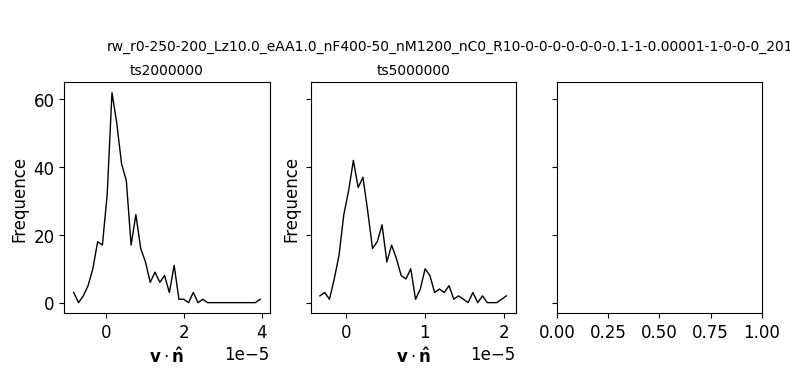

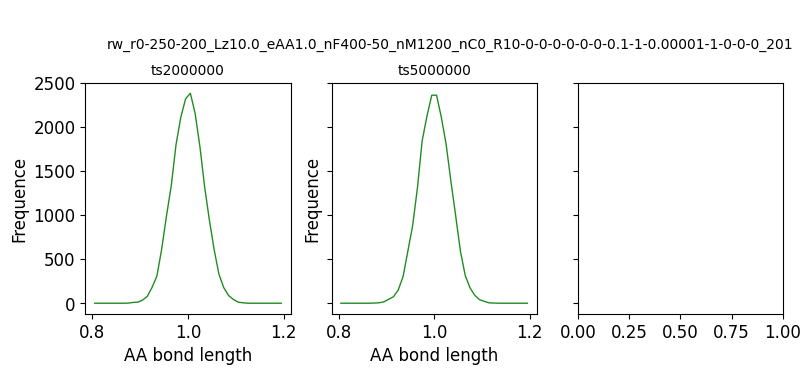

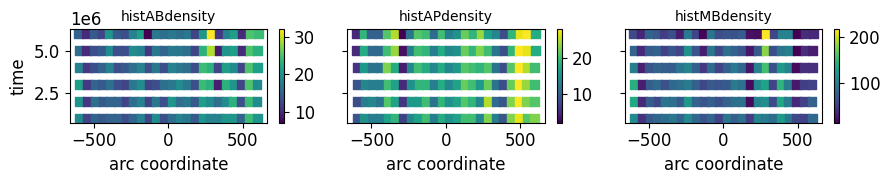

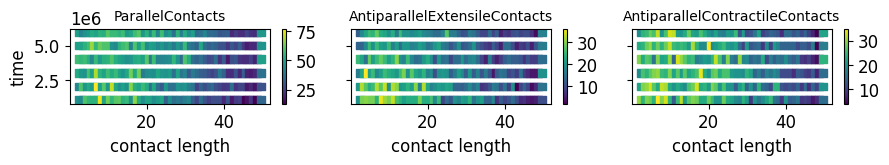

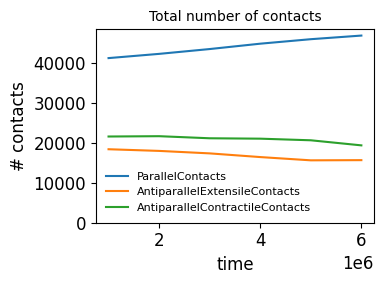

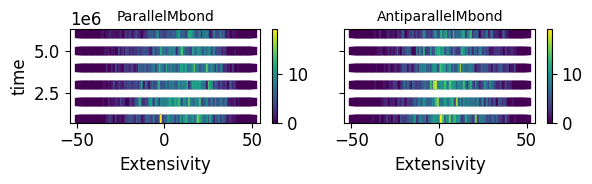

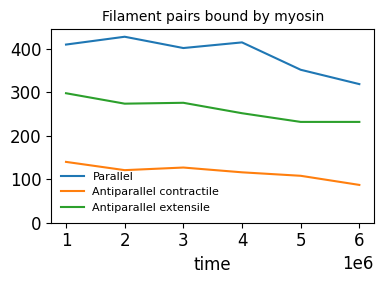

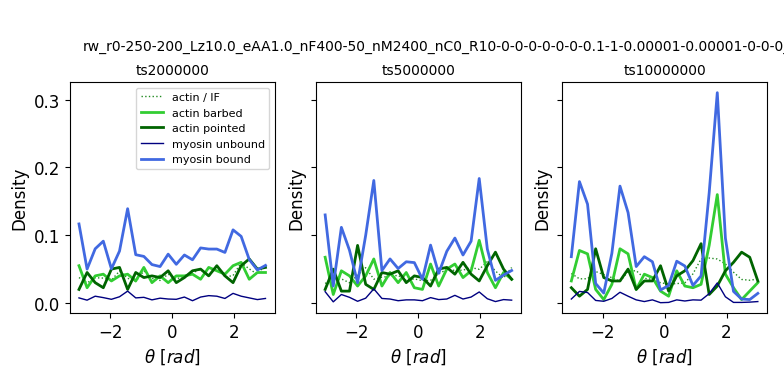

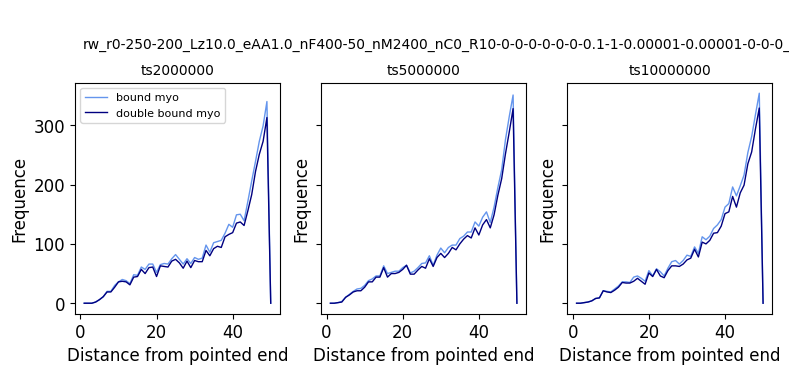

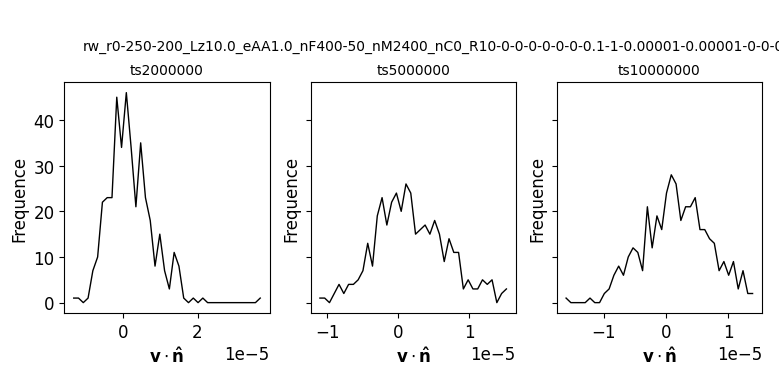

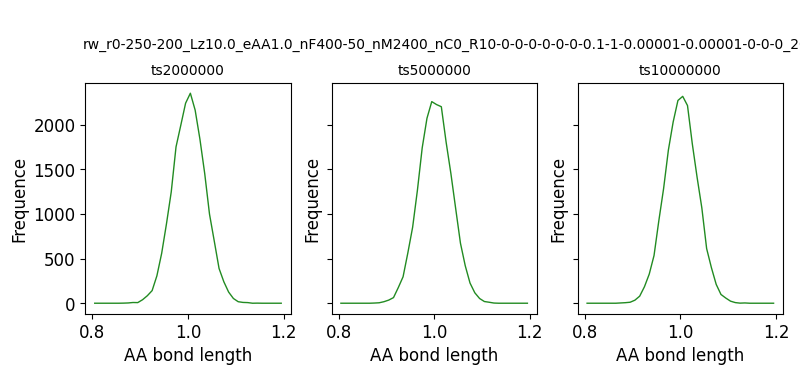

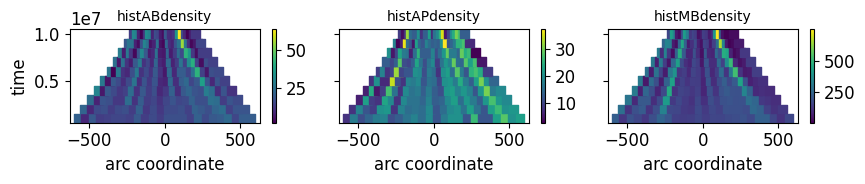

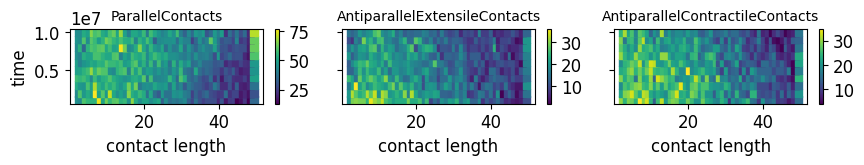

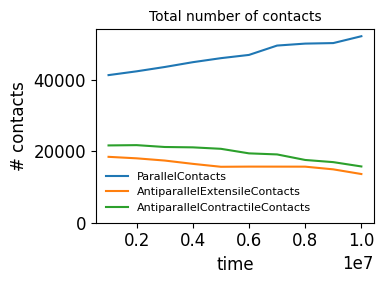

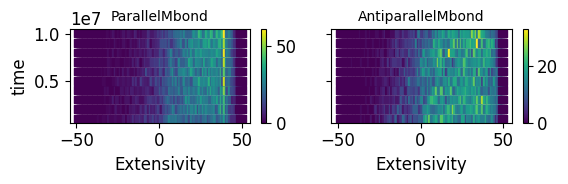

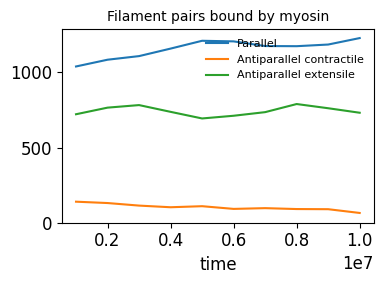

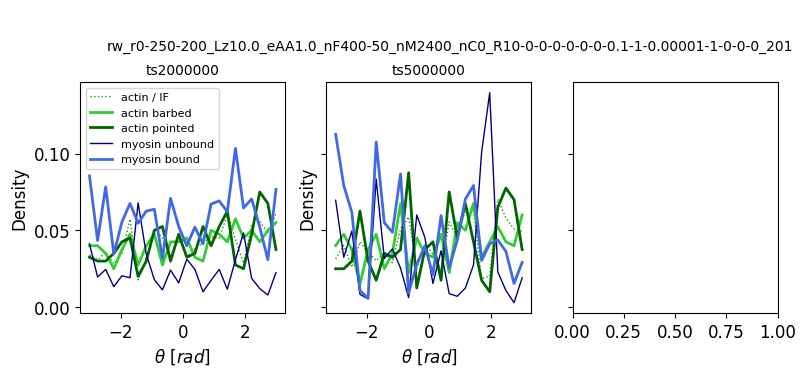

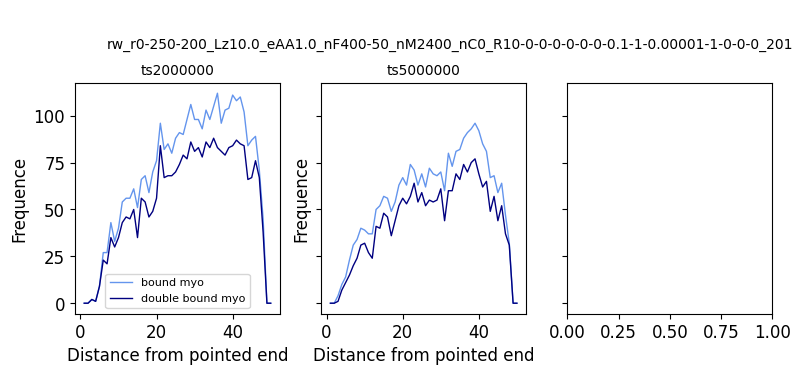

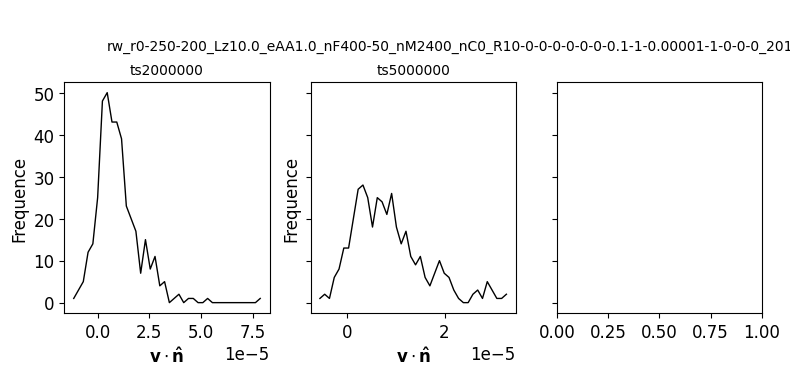

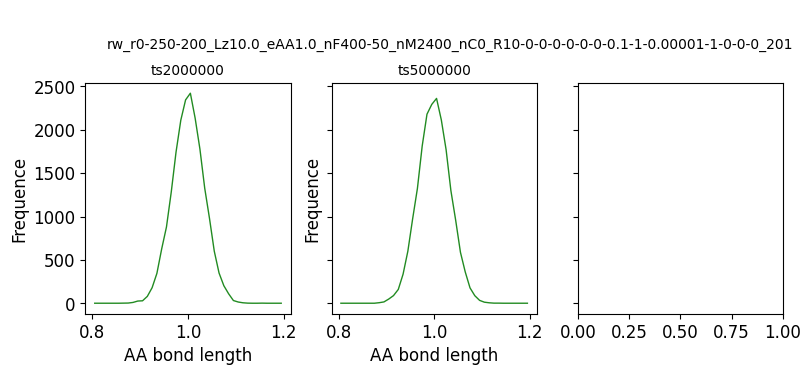

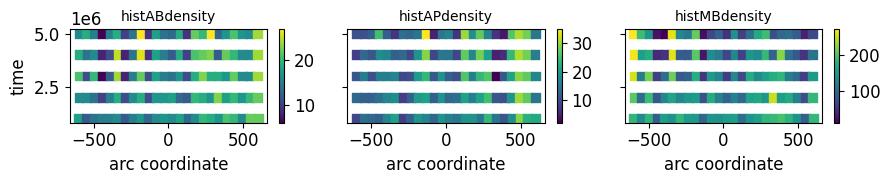

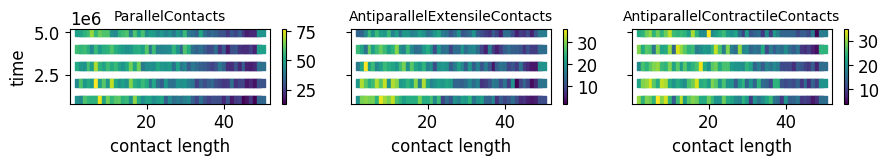

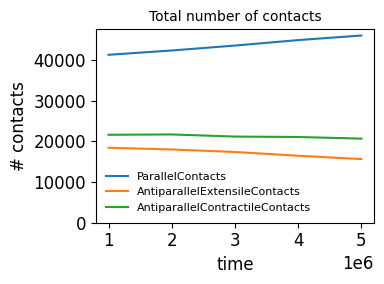

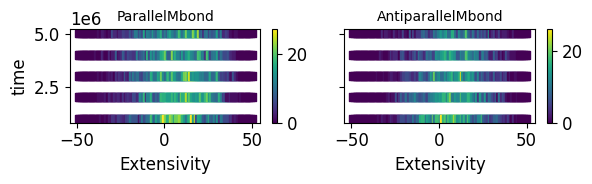

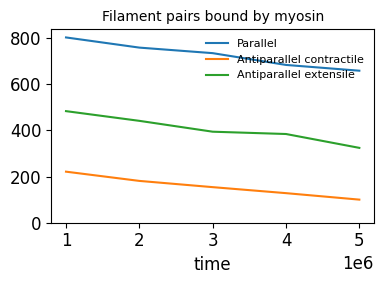

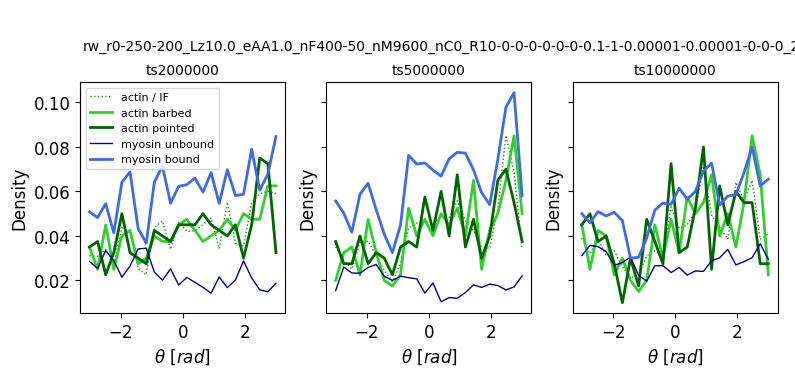

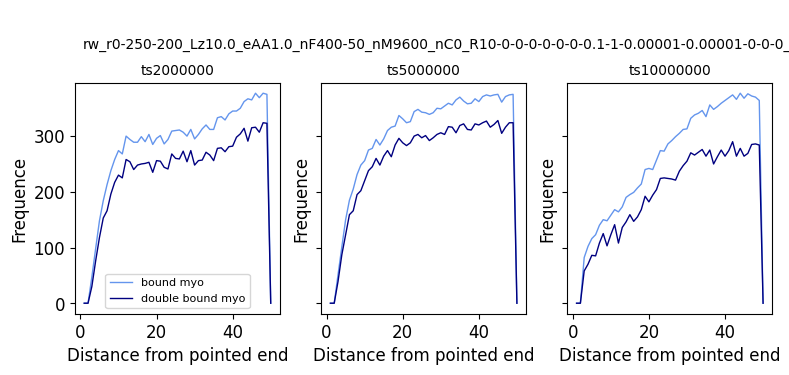

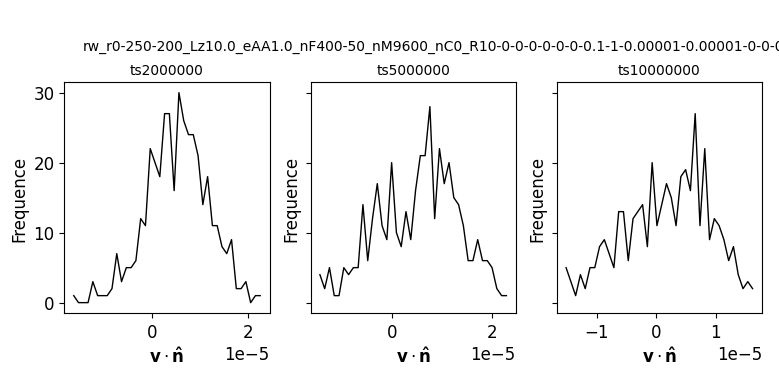

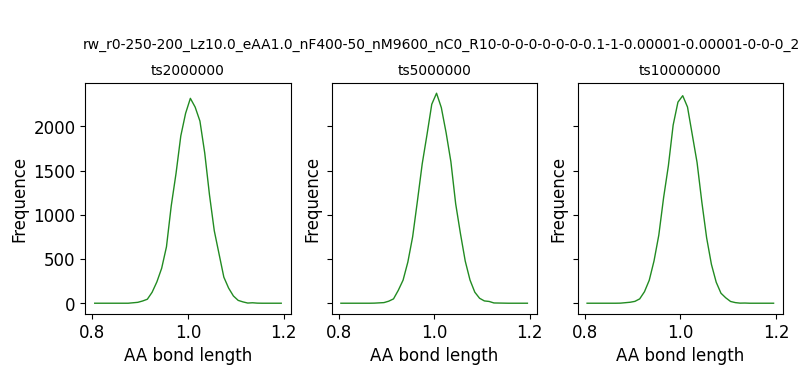

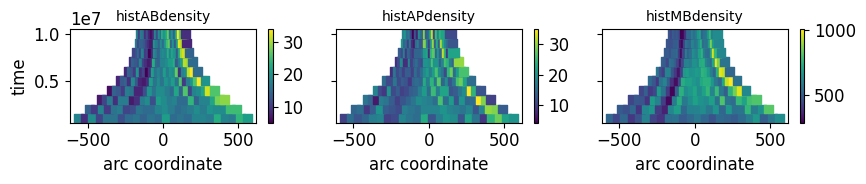

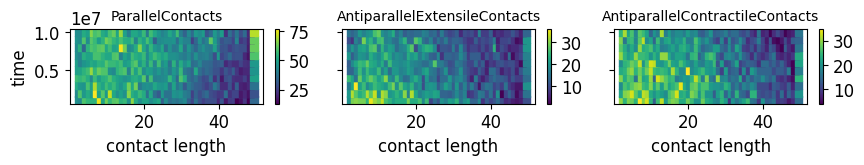

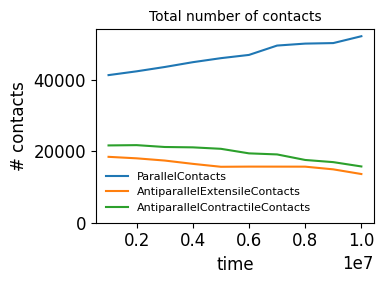

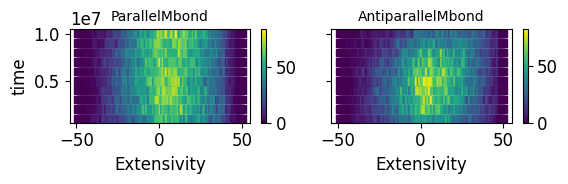

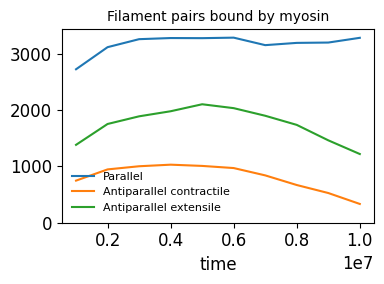

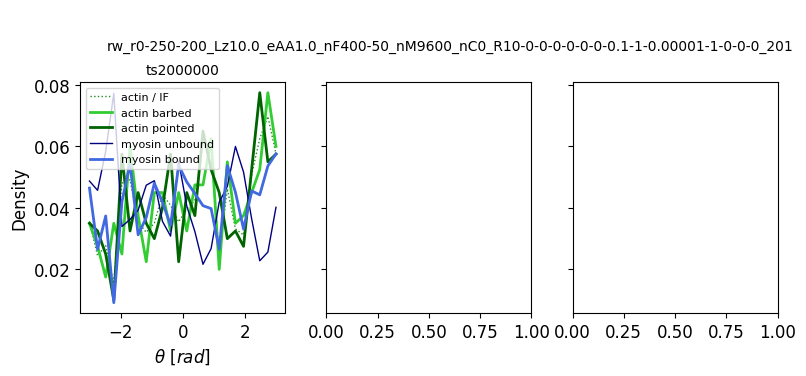

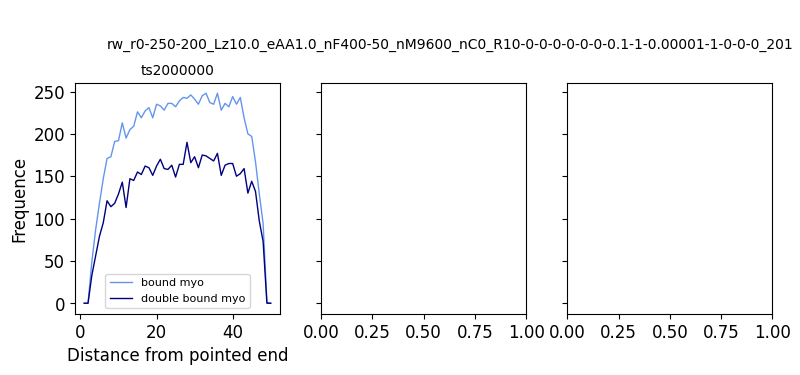

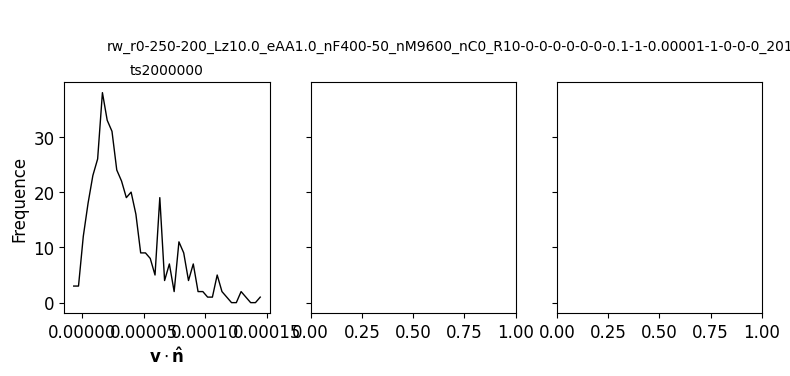

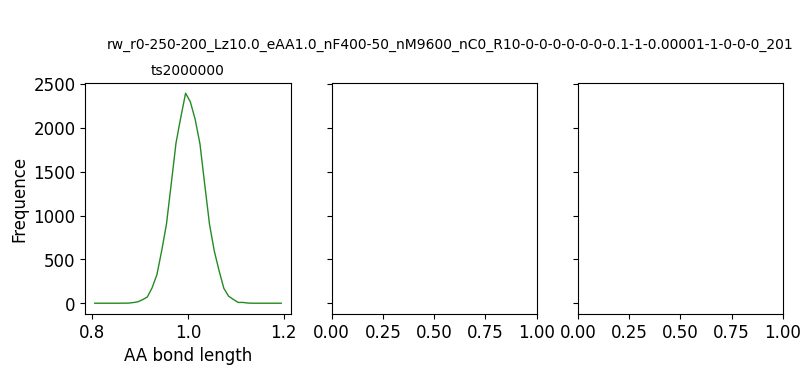

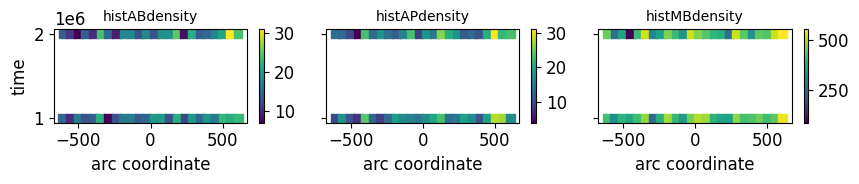

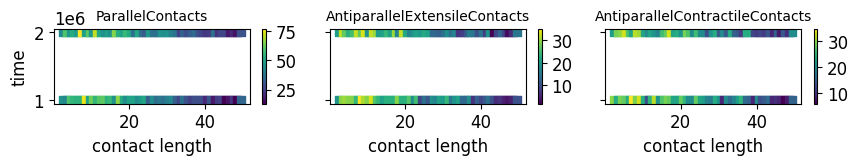

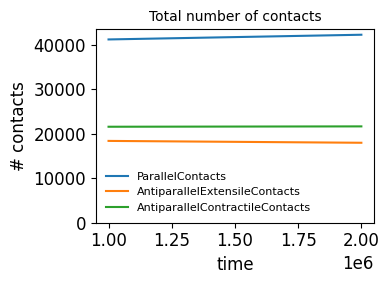

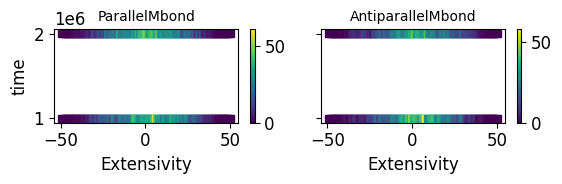

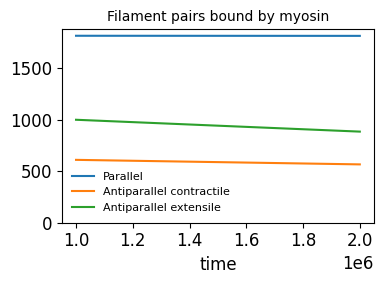

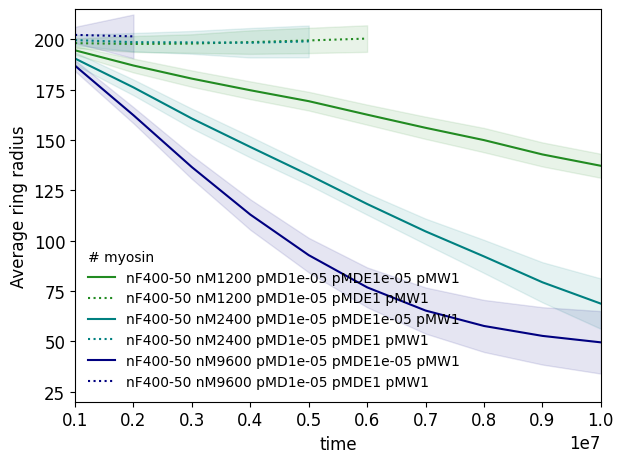

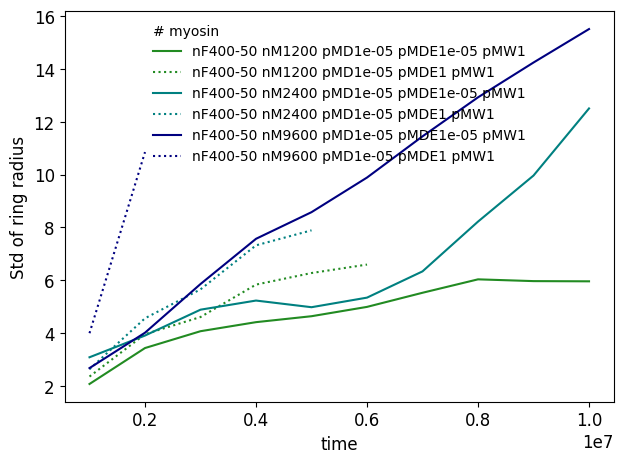

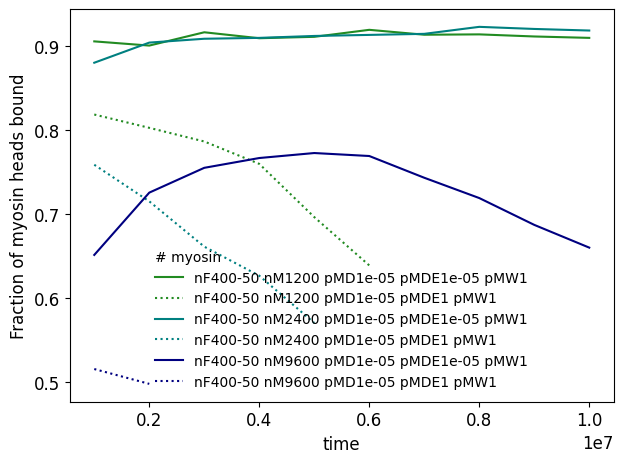

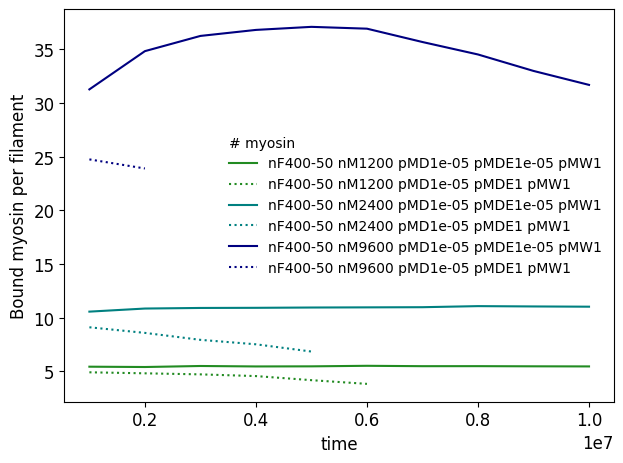

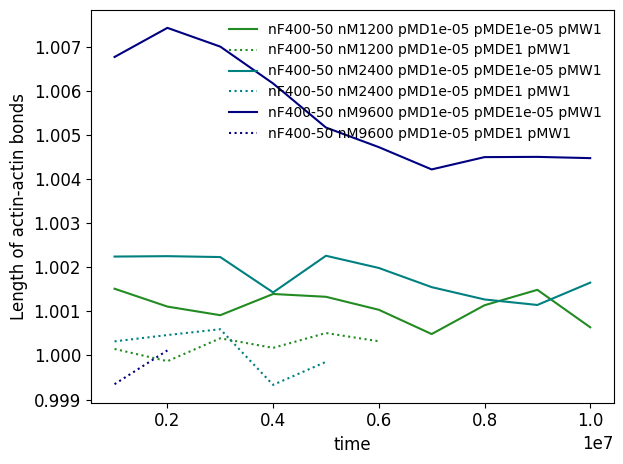

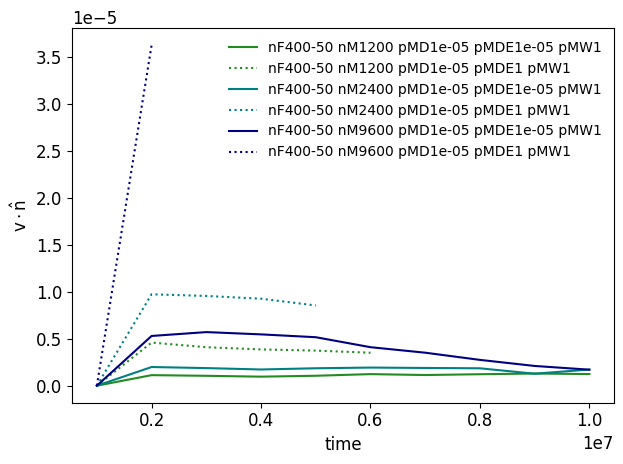

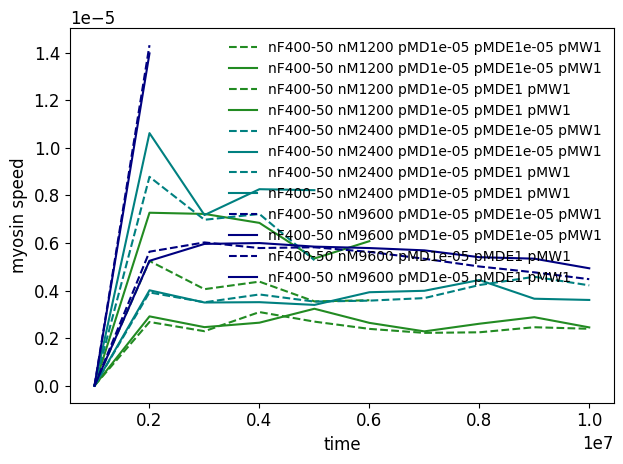

In [411]:
keys = [k for k in dicR.keys()]
keys.sort(key=sortbyparams)

timeHistList = [2e6, 5e6, 10e6]
RringPlot = [200.0]
lFPlot= [50]
LzPlot= [10.0]
nMplot=[1200,2400,9600]
eAAplot=[1.0]
pWplot=[1]
pMDplot = [0.00001]
if len(RringPlot)==1 and len(lFPlot)==1 and len(LzPlot)==1:
    SaveFigFlag=True
else:
    SaveFigFlag=False
SaveFigFlagIndividual=True

counter=0

for i,key in enumerate(keys):    
    dffull = dicR[key]
    par = getparams(key)
    Lz=par['Lz']
    Rcylout=par['Rcylout']
    lF=par['lF']
    nF=par['nF']
    nM=par['nM']
    eAA = par['eAA']
    
    if par['pMDE']==0:
        fmt = '--'
    elif par['pMDE']<=par['pMD']:
        fmt = '-'
    else:
        fmt = ':'
    label="nF{:d}-{:d} nM{:d} pMD{:g} pMDE{:g} pMW{:g}".format(par['nF'],par['lF'],par['nM'],par['pMD'],par['pMDE'],par['pMW'])
    
    if not ((par['Rring'] in RringPlot) and (Lz in LzPlot) and (lF in lFPlot) and (nM in nMplot) and (eAA in eAAplot) and (par['pMW'] in pWplot) and\
            (par['geom']=='rw') and (par['nF']==400) and (par['pMD'] in pMDplot) and (par['pMDE'] in [par['pMD'],1])  ):
        continue
    print(key)
    counter+=1
        
    plt.figure(1)
    df = dffull[dffull.RingIntactFlag==1]
    plt.plot(df.time, df.Ravg,fmt, color=nM2color(nM), label=label)
    plt.fill_between(df.time, df.Ravg-df.Rstd, df.Ravg+df.Rstd, color=nM2color(nM), alpha=0.1)
    #dfbroken = dffull[dffull.RingIntactFlag==0]
    #if len(dfbroken)>0:
    #    plt.plot(dfbroken.iloc[0].time, dfbroken.iloc[0].Ravg, 'x', color=nM2color(nM), label=None, ms=10)

    plt.figure(2)
    plt.plot(df.time, df.Rstd, fmt, color=nM2color(nM), label=label)

    plt.figure(3)
    FractionMB = np.array([x[1].sum() for x in df.histMBdensity.values])/(2*nM)
    plt.plot(df.time, FractionMB, fmt, color=nM2color(nM), label=label )
    
    plt.figure(4)
    FractionMB = np.array([x[1].sum() for x in df.histMBdensity.values])/(nF)
    plt.plot(df.time, FractionMB, fmt, color=nM2color(nM), label=label )
    
    plt.figure(5)
    plt.plot(df.time, df.ActinStrainAvg, fmt, color=nM2color(nM), label=label )
    
    plt.figure(6)
    plt.plot(df.time, df.vdotnActinAvg, fmt, color=nM2color(nM), label=label )
    
    plt.figure(7)
    plt.plot(df.time, df.MSpeedAntiparallelAvg, '--', color=nM2color(nM), label=label )
    plt.plot(df.time, df.MSpeedParallelAvg, '-', color=nM2color(nM), label=label )
    
    
    # AP, AB and M distribution around ring
    fig100,axs=plt.subplots(1,len(timeHistList),sharey=True, figsize=(3*len(timeHistList),3))
    plt.annotate(key, (0.5,1.1), fontsize=10, va='center', ha='center', xycoords='figure fraction')
    for i,timeHist in enumerate(timeHistList):
        plt.sca(axs[i])
        if len(df[df.time==timeHist])==0:
            continue
        plt.ylabel('Density')
        plt.xlabel(r'$\theta\ [rad]$')
        plt.title('ts{:.0f}'.format(timeHist), fontsize=10)

        histAdensity = df[df.time==timeHist].histAdensity.iloc[0]
        Ravg = df[df.time==timeHist].Ravg.iloc[0]
        #plt.stairs(histAdensity[1]/lF, edges=histAdensity[0], lw=2, label='actin / lF', color='forestgreen')
        plt.plot(bin2midpoint(histAdensity[0]), histAdensity[1]/(lF*nF), ':', color='forestgreen', label='actin / lF', lw=1)

        histABdensity = df[df.time==timeHist].histABdensity.iloc[0]
        #plt.stairs(histABdensity[1], edges=histABdensity[0], lw=2, label='actin barbed', color='limegreen')
        plt.plot(bin2midpoint(histABdensity[0]), histABdensity[1]/nF, color='limegreen', label='actin barbed', lw=2)

        histAPdensity = df[df.time==timeHist].histAPdensity.iloc[0]
        #plt.stairs(histAPdensity[1], edges=histAPdensity[0], lw=2, label='actin pointed', color='darkgreen')
        plt.plot(bin2midpoint(histAPdensity[0]), histAPdensity[1]/nF, color='darkgreen', label='actin pointed', lw=2)

        histMUdensity = df[df.time==timeHist].histMUdensity.iloc[0]
        #plt.stairs(histMUdensity[1], edges=histMUdensity[0], lw=2, label='myosin unbound', color='navy')
        plt.plot(bin2midpoint(histMUdensity[0]), histMUdensity[1]/nM, color='navy', label='myosin unbound', lw=1)

        histMBdensity = df[df.time==timeHist].histMBdensity.iloc[0]
        #plt.stairs(histMBdensity[1], edges=histMBdensity[0], lw=2, label='myosin bound', color='royalblue')
        plt.plot(bin2midpoint(histMBdensity[0]), histMBdensity[1]/nM, color='royalblue', label='myosin bound', lw=2)
        
        if i==0:
            plt.legend(fontsize=8)

            
    # Myosin distribution along filament        
    fig120,axs=plt.subplots(1,len(timeHistList),sharey=True, figsize=(3*len(timeHistList),3))
    plt.annotate(key, (0.5,1.1), fontsize=10, va='center', ha='center', xycoords='figure fraction')
    for i,timeHist in enumerate(timeHistList):
        plt.sca(axs[i])
        if len(df[df.time==timeHist])==0:
            continue
        plt.ylabel('Frequence')
        plt.xlabel(r'Distance from pointed end')
        plt.title('ts{:.0f}'.format(timeHist), fontsize=10)

        histMDistrAlongActin = df[df.time==timeHist].histMDistrAlongActin.iloc[0]
        plt.plot(bin2midpoint(histMDistrAlongActin[0]), histMDistrAlongActin[1], color='cornflowerblue', label='bound myo', lw=1)
        histDoubleBoundMDistrAlongActin = df[df.time==timeHist].histDoubleBoundMDistrAlongActin.iloc[0]
        plt.plot(bin2midpoint(histDoubleBoundMDistrAlongActin[0]), histDoubleBoundMDistrAlongActin[1], color='navy', label='double bound myo', lw=1)
        if i==0:
            plt.legend(fontsize=8)
            
    # vdotn        
    fig121,axs=plt.subplots(1,len(timeHistList),sharey=True, figsize=(3*len(timeHistList),3))
    plt.annotate(key, (0.5,1.1), fontsize=10, va='center', ha='center', xycoords='figure fraction')
    for i,timeHist in enumerate(timeHistList):
        plt.sca(axs[i])
        if len(df[df.time==timeHist])==0:
            continue
        plt.ylabel('Frequence')
        plt.xlabel(r'$\mathbf{v}\cdot \mathbf{\hat{n}}$')
        plt.title('ts{:.0f}'.format(timeHist), fontsize=10)

        histvdotnActinDistr = df[df.time==timeHist].histvdotnActinDistr.iloc[0]
        plt.plot(bin2midpoint(histvdotnActinDistr[0]), histvdotnActinDistr[1], color='k', label='', lw=1)

    # Actin strain        
    fig122,axs=plt.subplots(1,len(timeHistList),sharey=True, figsize=(3*len(timeHistList),3))
    plt.annotate(key, (0.5,1.1), fontsize=10, va='center', ha='center', xycoords='figure fraction')
    for i,timeHist in enumerate(timeHistList):
        plt.sca(axs[i])
        if len(df[df.time==timeHist])==0:
            continue
        plt.ylabel('Frequence')
        plt.xlabel(r'AA bond length')
        plt.title('ts{:.0f}'.format(timeHist), fontsize=10)

        histActinStrainDistr = df[df.time==timeHist].histActinStrainDistr.iloc[0]
        plt.plot(bin2midpoint(histActinStrainDistr[0]), histActinStrainDistr[1], color='forestgreen', label='', lw=1)

            
    fig101,axs=plt.subplots(1,3,sharey=True, figsize=(3*3,2))
    for j, s in enumerate(['histABdensity', 'histAPdensity', 'histMBdensity']):
        if s not in df:
            continue
        plt.sca(axs[j])
        data = []
        for i,dfline in df.iterrows():
            Ravg = dfline.Ravg
            time = dfline.time
            midpoints = bin2midpoint( dfline[s][0]*Ravg )
            hist = dfline[s][1]
            for i in range(len(hist)):
                data.append( [midpoints[i], time, hist[i]] )
        if len(data)==0:
            continue
        data = np.array(data)
        plt.scatter(data[:,0], data[:,1], c=data[:,2], s=40, marker='s')
        plt.colorbar()
        plt.xlabel('arc coordinate')
        if j==0:
            plt.ylabel('time')
        plt.title(s, fontsize=10)
    plt.tight_layout()
    if SaveFigFlagIndividual: plt.savefig('{:s}/Analysis/Graphs/HistAB-AP-MB_{:s}.pdf'.format(folder,key))
    #plt.show()
    #plt.close(fig101)
    
    fig102,axs=plt.subplots(1,3,sharey=True, figsize=(3*3,2))
    for j, s in enumerate(['histParallelContacts','histAntiparallelExtensileContacts', 'histAntiparallelContractileContacts']):
        plt.sca(axs[j])
        data = []
        for i,dfline in df.iterrows():
            if len(dfline[s])==0:
                continue
            time = dfline.time
            midpoints = bin2midpoint( dfline[s][0] )
            hist = dfline[s][1]
            for i in range(2,len(hist)):
                data.append( [midpoints[i], time, hist[i] ] )
        data = np.array(data)
        plt.scatter(data[:,0], data[:,1], c=data[:,2], s=30, marker='s')
        plt.colorbar()
        plt.xlabel('contact length')
        if j==0:
            plt.ylabel('time')
        plt.title(s[4:], fontsize=10)
    plt.tight_layout()
    if SaveFigFlagIndividual: plt.savefig('{:s}/Analysis/Graphs/HistContact_{:s}.pdf'.format(folder,key))
    #plt.show()
    #plt.close(fig102)

    fig103,axs=plt.subplots(1,1,sharey=True, figsize=(4,3))
    for j, s in enumerate(['histParallelContacts','histAntiparallelExtensileContacts', 'histAntiparallelContractileContacts']):
        data = []
        for i, dfline in df.iterrows():
            if len(dfline[s])==0:
                continue
            time = dfline.time
            hist = dfline[s][1]
            histsum = sum(hist*dfline[s][0][:-1])
            data.append([time,histsum])
        data = np.array(data)
        plt.plot(data[:,0], data[:,1], label=s[4:])
    plt.ylabel('# contacts')
    plt.xlabel('time')
    plt.title('Total number of contacts', fontsize=10)
    plt.legend(frameon=False, fontsize=8)
    plt.ylim(0,None)
    plt.tight_layout()
    if SaveFigFlagIndividual: plt.savefig('{:s}/Analysis/Graphs/ContactsvsTime_{:s}.pdf'.format(folder,key))
    #plt.show()
    #plt.close(fig103)

    fig104,axs=plt.subplots(1,2,sharey=True, figsize=(6,2))
    for j, s in enumerate(['histParallelMbond','histAntiparallelMbond']):
        plt.sca(axs[j])
        data = []
        for i,dfline in df.iterrows():
            if len(dfline[s])==0:
                continue
            time = dfline.time
            midpoints = bin2midpoint( dfline[s][0] )
            hist = dfline[s][1]
            for i in range(1,len(hist)):
                data.append( [midpoints[i], time, hist[i] ] )
        data = np.array(data)
        plt.scatter(data[:,0], data[:,1], c=data[:,2], s=30, marker='s')
        plt.colorbar()
        plt.xlabel('Extensivity')
        if j==0:
            plt.ylabel('time')
        plt.title(s[4:], fontsize=10)
    plt.tight_layout()
    if SaveFigFlagIndividual: plt.savefig('{:s}/Analysis/Graphs/HistMbonds_{:s}.pdf'.format(folder,key))
    #plt.show()
    #plt.close(fig104)

    # MBonds
    fig105,axs=plt.subplots(1,1,sharey=True, figsize=(4,3))
    times, histsumParallel, histsumContractile, histsumExtensile = [],[],[],[]
    for i, dfline in df.iterrows():
        times.append(dfline.time)
        assert (dfline['histParallelMbond'][0]==dfline['histAntiparallelMbond'][0]).all()
        s = 'histParallelMbond'
        midpoints = bin2midpoint( dfline[s][0] )
        counts = dfline[s][1]
        histsumParallel.append(sum(counts))
        s = 'histAntiparallelMbond'
        midpoints = bin2midpoint( dfline[s][0] )
        counts = dfline[s][1]
        assert len(counts[0:lF])==len(counts[lF+1:])
        histsumContractile.append(sum(counts[0:lF]))
        histsumExtensile.append(sum(counts[lF+1:]))
    plt.plot(times, histsumParallel, label='Parallel')
    plt.plot(times, histsumContractile, label='Antiparallel contractile')
    plt.plot(times, histsumExtensile, label='Antiparallel extensile')
    #plt.ylabel('# double-bound Myo')
    plt.xlabel('time')
    plt.title('Filament pairs bound by myosin', fontsize=10)
    plt.legend(frameon=False, fontsize=8)
    plt.ylim(0,None)
    plt.tight_layout()
    if SaveFigFlagIndividual: plt.savefig('{:s}/Analysis/Graphs/MbondsvsTime_{:s}.pdf'.format(folder,key))
    #plt.show()
    #plt.close(fig105)
    

if counter>=1:

    assert len(lFPlot)==1
    assert len(RringPlot)==1
    assert len(LzPlot)==1
    assert len(pMWplot)==1
    assert len(pMDplot)==1
    assert len(pMDEplot)==1
    
    stringname = 'Rring{:.0f}_Lz{:.0f}_nF{:d}_pMW{:g}_pMD{:g}_pMDE{:g}'.format(RringPlot[0],LzPlot[0],lFPlot[0],pMWplot[0], pMDplot[0],pMDEplot[0])
    
    plt.figure(1)
    #for timeHist in timeHistList:
    #    plt.plot([timeHist,timeHist],[max(RcyloutPlot)-50, max(RcyloutPlot)],':',lw=0.2,color='k')
    plt.ylabel('Average ring radius')
    plt.xlabel('time')
    plt.ylim((20,215))
    plt.xlim((1e6,10e6))
    plt.legend(fontsize=10,frameon=False,title='# myosin',title_fontsize=10,alignment='left')
    plt.tight_layout()
    if SaveFigFlag: plt.savefig('{:s}/Analysis/Graphs/RingRadius_{:s}.pdf'.format(folder,stringname), metadata = {'Subject':UsedKeysString})

    plt.figure(2)
    plt.ylabel('Std of ring radius')
    plt.xlabel('time')
    plt.legend(fontsize=10,frameon=False,title='# myosin',title_fontsize=10,alignment='left')
    plt.tight_layout()
    if SaveFigFlag: plt.savefig('{:s}/Analysis/Graphs/RingRadiusStd_{:s}.pdf'.format(folder,stringname), metadata = {'Subject':UsedKeysString})

    plt.figure(3)
    plt.ylabel('Fraction of myosin heads bound')
    plt.xlabel('time')
    plt.legend(fontsize=10,frameon=False,title='# myosin',title_fontsize=10,alignment='left')
    plt.tight_layout()
    if SaveFigFlag: plt.savefig('{:s}/Analysis/Graphs/MyosinBoundFraction_{:s}.pdf'.format(folder,stringname), metadata = {'Subject':UsedKeysString})

    plt.figure(4)
    plt.ylabel('Bound myosin per filament') #'Myosin-actin bonds per actin filament')
    plt.xlabel('time')
    plt.legend(fontsize=10,frameon=False,title='# myosin',title_fontsize=10,alignment='left')
    plt.tight_layout()
    if SaveFigFlag: plt.savefig('{:s}/Analysis/Graphs/MyosinBoundFraction_{:s}.pdf'.format(folder,stringname), metadata = {'Subject':UsedKeysString})

    plt.figure(5)
    plt.ylabel('Length of actin-actin bonds') #'Myosin-actin bonds per actin filament')
    plt.xlabel('time')
    plt.legend(fontsize=10,frameon=False,alignment='left')
    plt.tight_layout()
    if SaveFigFlag: plt.savefig('{:s}/Analysis/Graphs/ActinStrainAvg_{:s}.pdf'.format(folder,stringname), metadata = {'Subject':UsedKeysString})

    plt.figure(6)
    plt.ylabel(r'$\mathrm{v}\cdot\mathrm{\hat{n}}$') #'Myosin-actin bonds per actin filament')
    plt.xlabel('time')
    plt.legend(fontsize=10,frameon=False,alignment='left')
    plt.tight_layout()
    if SaveFigFlag: plt.savefig('{:s}/Analysis/Graphs/vdotnActinAvg_{:s}.pdf'.format(folder,stringname), metadata = {'Subject':UsedKeysString})

    plt.figure(7)
    plt.ylabel(r'myosin speed') #'Myosin-actin bonds per actin filament')
    plt.xlabel('time')
    plt.legend(fontsize=10,frameon=False,alignment='left')
    plt.tight_layout()
    if SaveFigFlag: plt.savefig('{:s}/Analysis/Graphs/MyoSpeed_{:s}.pdf'.format(folder,stringname), metadata = {'Subject':UsedKeysString})


In [ ]:
    '''
    fig105,axs=plt.subplots(1,1,figsize=(4,3))
    plt.annotate(key, (0.5,1.1), fontsize=10, va='center', ha='center', xycoords='figure fraction')
    colors = ['k','b','g','orange','y','r']
    timesPlot = [1000000, 1100000, 1200000, 1300000, 1400000, 1500000]
    for i,timeHist in enumerate(timesPlot):
        dfline = df[df.time==timeHist].iloc[0]
        if len(dfline.DeltaExtensivityRef)==0:
            continue
        plt.ylabel('Delta Extensivity')
        plt.xlabel('Initial Extensivity')
        label = 'ts{:d}'.format(timeHist)
        InitialExtensivity = dfline.DeltaExtensivityRef.InitialExtensivity
        DeltaSum = dfline.DeltaExtensivityRef.DeltaSum
        #DeltaStd = dfline.DeltaExtensivityRef.DeltaStd
        plt.plot(InitialExtensivity, DeltaSum, '-', color=colors[i], label=label, lw=1)
        #plt.fill_between(InitialExtensivity, DeltaMean-DeltaStd, DeltaMean+DeltaStd, color=colors[i], alpha=0.2)
    plt.legend(fontsize=8)
    plt.title('# steps forward in 1e5 ts, before first detachment', fontsize=10)
    plt.ylim(0,None)
    if SaveFigFlagIndividual: plt.savefig('{:s}/Analysis/Graphs/DeltaExtensivityRef_{:d}ts_{:s}.pdf'.format(folder,len(timesPlot),key))
    
    fig106,axs=plt.subplots(1,1, figsize=(4,2))
    data = []
    for i, dfline in df.iterrows():
        if len(dfline.DeltaExtensivityRef)==0:
            continue
        time = dfline.time
        InitialExtensivity = dfline.DeltaExtensivityRef.InitialExtensivity
        DeltaSum = dfline.DeltaExtensivityRef.DeltaSum
        for i in range(1,len(hist)):
            data.append( [InitialExtensivity[i], time, DeltaSum[i] ] )
    data = np.array(data)
    plt.scatter(data[:,0], data[:,1], c=data[:,2], s=10, marker='s')
    plt.colorbar()
    plt.xlabel('Initial Extensivity')
    if j==0:
        plt.ylabel('time')
    plt.title('# steps forward in 1e5 ts, before first detachment', fontsize=10)
    plt.tight_layout()
    if SaveFigFlagIndividual: plt.savefig('{:s}/Analysis/Graphs/HistDeltaExtensivityRef_{:s}.pdf'.format(folder,key))
    

    fig107,axs=plt.subplots(1,1,figsize=(4,3))
    plt.annotate(key, (0.5,1.1), fontsize=10, va='center', ha='center', xycoords='figure fraction')
    colors = ['k','b','g','y','r']
    timesPlot = [1000000, 2000000, 3000000, 4000000]
    for i,timeHist in enumerate(timesPlot):
        dfline = df[df.time==timeHist].iloc[0]
        if len(dfline.DeltaExtensivityCont)==0:
            continue
        plt.ylabel('Delta Extensivity')
        plt.xlabel('Previous Extensivity')
        label = 'ts{:d}'.format(timeHist)
        InitialExtensivity = dfline.DeltaExtensivityCont.PreviousExtensivity
        DeltaSum = dfline.DeltaExtensivityCont.DeltaSum
        #DeltaStd = dfline.DeltaExtensivityCont.DeltaStd
        plt.plot(InitialExtensivity, DeltaSum, '-', color=colors[i], label=label, lw=1)
        #plt.fill_between(InitialExtensivity, DeltaMean-DeltaStd, DeltaMean+DeltaStd, color=colors[i], alpha=0.2)
        plt.title('# steps forward in 1e5 ts, for all Myos', fontsize=10)
        plt.legend(fontsize=8)
        plt.ylim(0,None)
    if SaveFigFlagIndividual: plt.savefig('{:s}/Analysis/Graphs/DeltaExtensivityCont_{:s}.pdf'.format(folder,key))
    
    fig108,axs=plt.subplots(1,1, figsize=(4,3))
    data = []
    for i, dfline in df.iterrows():
        if len(dfline.DeltaExtensivityCont)==0:
            continue
        time = dfline.time
        InitialExtensivity = dfline.DeltaExtensivityCont.PreviousExtensivity
        DeltaSum = dfline.DeltaExtensivityCont.DeltaSum
        for i in range(1,len(hist)):
            data.append( [InitialExtensivity[i], time, DeltaSum[i] ] )
    data = np.array(data)
    plt.scatter(data[:,0], data[:,1], c=data[:,2], s=5, marker='s')
    plt.colorbar()
    plt.xlabel('Previous Extensivity')
    if j==0:
        plt.ylabel('time')
    plt.title('# steps forward in 1e5 ts, for all Myos', fontsize=10)
    plt.tight_layout()
    if SaveFigFlagIndividual: plt.savefig('{:s}/Analysis/Graphs/HistDeltaExtensivityCont_{:s}.pdf'.format(folder,key))
    '''


### Paper

In [91]:
nM2colorDic = {}
colors=['#184093','cornflowerblue','mediumturquoise','#e36d7d','#b077b8','#d19fd6','#9fd6af'] #'powderblue','darkcyan',
nMList = [19200, 9600, 4800, 2400, 1200, 600] 
for i,nM in enumerate(nMList):
    nM2colorDic[nM] = colors[i]
    
string2titleDic = {'histABdensity':'Barbed end density', 'histAPdensity':'Pointed end density', 'histMBdensity':'Bound myosin density'}

rw_r0-250-200_Lz10.0_eAA1.0_nF400-50_nM1200_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-1-0-0-0_201
rw_r0-250-200_Lz10.0_eAA1.0_nF400-50_nM2400_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-1-0-0-0_201
rw_r0-250-200_Lz10.0_eAA1.0_nF400-50_nM9600_nC0_R10-0-0-0-0-0-0-0.1-1-0.00001-1-0-0-0_201


/var/folders/r9/smk0v8f53xz3gxjck33br70w0000gn/T/ipykernel_70998/1452006861.py:343: UserWarning: Unknown infodict keyword: 'Comment'. Must be one of {'Creator', 'ModDate', 'Author', 'Subject', 'Title', 'CreationDate', 'Trapped', 'Keywords', 'Producer'}.
  if SaveFigFlag: plt.savefig('{:s}/Analysis/Graphs/Paper/RingRadius_{:s}.pdf'.format(folder,stringname), metadata = {'Comment':UsedKeysString})
/var/folders/r9/smk0v8f53xz3gxjck33br70w0000gn/T/ipykernel_70998/1452006861.py:350: UserWarning: Unknown infodict keyword: 'Comment'. Must be one of {'Creator', 'ModDate', 'Author', 'Subject', 'Title', 'CreationDate', 'Trapped', 'Keywords', 'Producer'}.
  if SaveFigFlag: plt.savefig('{:s}/Analysis/Graphs/Paper/RingRadiusStd_{:s}.pdf'.format(folder,stringname), metadata = {'Comment':UsedKeysString})
/var/folders/r9/smk0v8f53xz3gxjck33br70w0000gn/T/ipykernel_70998/1452006861.py:357: UserWarning: Unknown infodict keyword: 'Comment'. Must be one of {'Creator', 'ModDate', 'Author', 'Subject', 'Title

"\nplt.ylabel('Actin')\n#plt.xlabel('Arc of ring')\nplt.xlabel(r'$\theta\\ [rad]$')\nplt.legend(fontsize=8)\n\nplt.figure(11)\nplt.ylabel('Actin barbed end')\nplt.xlabel(r'$\theta\\ [rad]$')\nplt.legend(fontsize=8)\n\nplt.figure(12)\nplt.ylabel('Actin pointed end')\nplt.xlabel(r'$\theta\\ [rad]$')\nplt.legend(fontsize=8)\n\nplt.figure(20)\nplt.ylabel('Unbound myosin')\n#plt.xlabel('Arc of ring')\nplt.xlabel(r'$\theta\\ [rad]$')\nplt.legend(fontsize=8)\n             \nplt.figure(21)\nplt.ylabel('Bound myosin')\n#plt.xlabel('Arc of ring')\nplt.xlabel(r'$\theta\\ [rad]$')\nplt.legend(fontsize=8)\n"

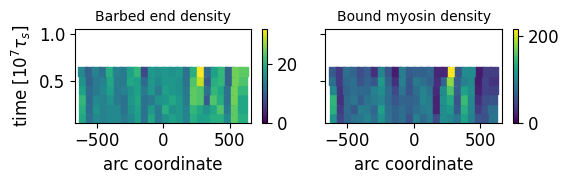

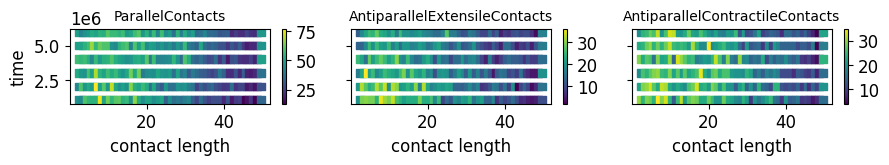

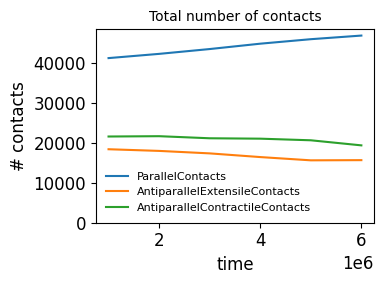

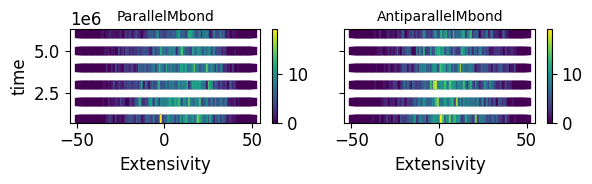

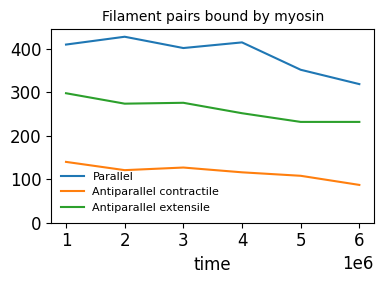

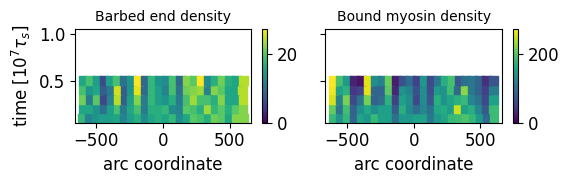

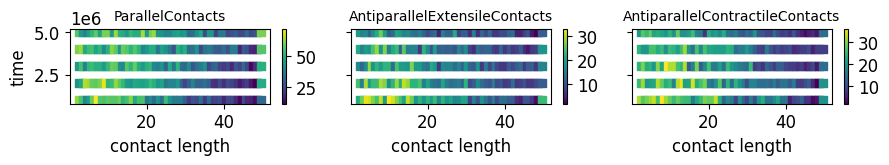

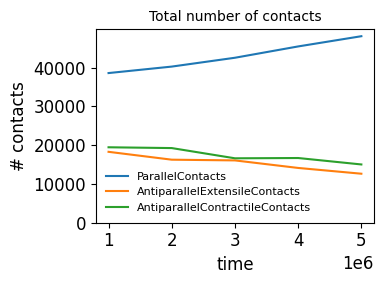

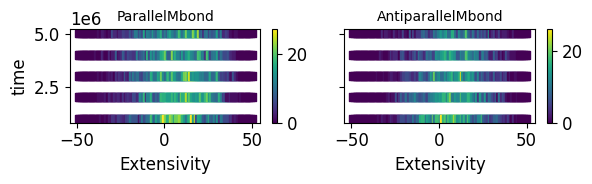

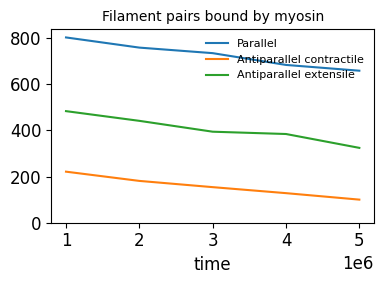

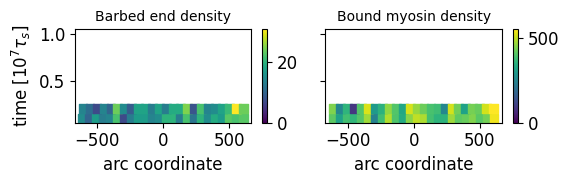

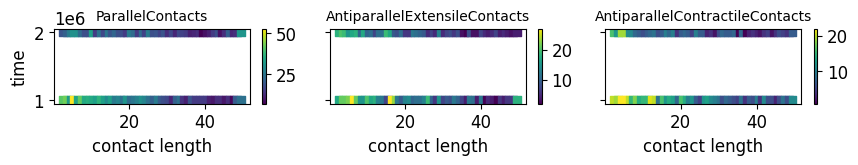

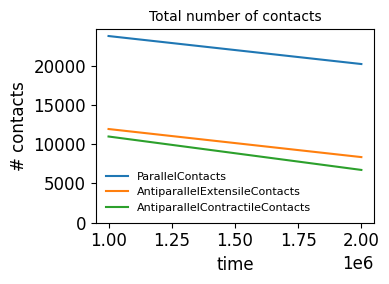

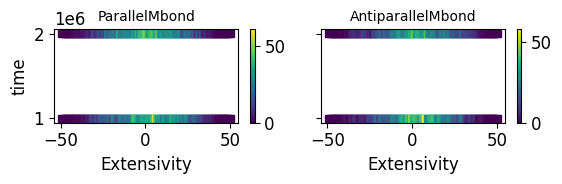

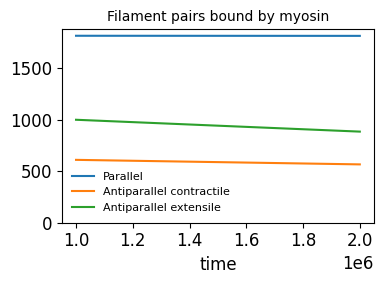

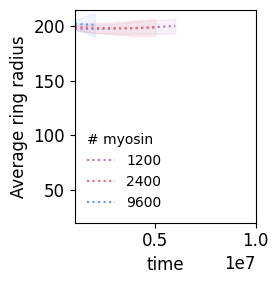

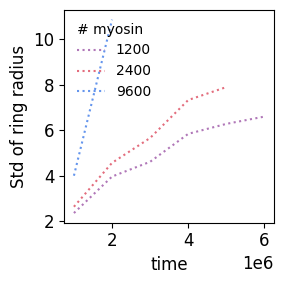

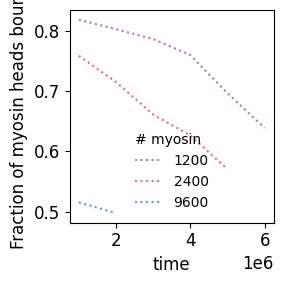

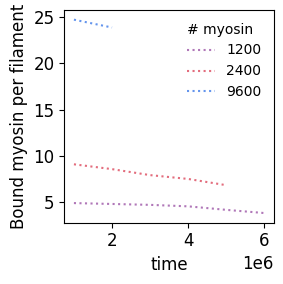

In [96]:
keys = [k for k in dicR.keys()]
keys.sort(key=sortbyparams)

timeHistList = [1e6, 5e6, 10e6]
RringPlot = [200.0]
lFPlot= [50]

LzPlot= [10.0]
nMplot=[1200,2400,4800,9600]
eAAplot=[1.0]
pMWplot=[1]
pMDplot  = [0.00001]
pMDEplot = [1]

SaveFigFlag=True
SaveFigFlagIndividual=True

counter=0
UsedKeysString = ''

for i,key in enumerate(keys):    
    dffull = dicR[key]
    par = getparams(key)
    Lz=par['Lz']
    Rcylout=par['Rcylout']
    lF=par['lF']
    nF=par['nF']
    nM=par['nM']
    eAA = par['eAA']
    
    if par['pMDE']==0:
        fmt = '--'
    elif par['pMDE']<=par['pMD']:
        fmt = '-'
    else:
        fmt = ':'
    
    if not ((par['Rring'] in RringPlot) and (Lz in LzPlot) and (lF in lFPlot) and (nM in nMplot) and (eAA in eAAplot) and (par['pMW'] in pMWplot) and\
            (par['geom']=='rw') and (par['nF']==400) and (par['pMD'] in pMDplot) and (par['pMDE'] in pMDEplot)  ):
        continue
    print(key)
    counter+=1
    
    UsedKeysString += key if UsedKeysString=='' else (', '+key)
    
    #label="nF{:d}-{:d} nM{:d} pMD{:g} pMDE{:g} pMW{:g}".format(par['nF'],par['lF'],par['nM'],par['pMD'],par['pMDE'],par['pMW'])
    label='{:d}'.format(nM)
        
    plt.figure(1, figsize=(3,3))
    df = dffull[dffull.RingIntactFlag==1]
    plt.plot(df.time, df.Ravg,fmt, color=nM2colorDic[nM], label=label)
    plt.fill_between(df.time, df.Ravg-df.Rstd, df.Ravg+df.Rstd, color=nM2colorDic[nM], alpha=0.1)
    #dfbroken = dffull[dffull.RingIntactFlag==0]
    #if len(dfbroken)>0:
    #    plt.plot(dfbroken.iloc[0].time, dfbroken.iloc[0].Ravg, 'x', color=nM2colorDic[nM], label=None, ms=10)

    plt.figure(2, figsize=(3,3))
    plt.plot(df.time, df.Rstd, fmt, color=nM2colorDic[nM], label=label)

    plt.figure(3, figsize=(3,3))
    FractionMB = np.array([x[1].sum() for x in df.histMBdensity.values])/(2*nM)
    plt.plot(df.time, FractionMB, fmt, color=nM2colorDic[nM], label=label )
    
    plt.figure(4, figsize=(3,3))
    FractionMB = np.array([x[1].sum() for x in df.histMBdensity.values])/(nF)
    plt.plot(df.time, FractionMB, fmt, color=nM2colorDic[nM], label=label )
    
    '''
    #plt.figure(1000+i)
    fig100,axs=plt.subplots(1,len(timeHistList),sharey=True, figsize=(3*len(timeHistList),3))
    plt.annotate(key, (0.5,1.1), fontsize=10, va='center', ha='center', xycoords='figure fraction')
    for i,timeHist in enumerate(timeHistList):
        plt.sca(axs[i])
        if len(df[df.time==timeHist])==0:
            continue
        plt.ylabel('Density')
        plt.xlabel(r'$\theta\ [rad]$')
        plt.title('ts{:.0f}'.format(timeHist), fontsize=10)

        histAdensity = df[df.time==timeHist].histAdensity.iloc[0]
        Ravg = df[df.time==timeHist].Ravg.iloc[0]
        #plt.stairs(histAdensity[1]/lF, edges=histAdensity[0], lw=2, label='actin / lF', color='forestgreen')
        plt.plot(bin2midpoint(histAdensity[0]), histAdensity[1]/(lF*nF), ':', color='forestgreen', label='actin / lF', lw=1)

        histABdensity = df[df.time==timeHist].histABdensity.iloc[0]
        #plt.stairs(histABdensity[1], edges=histABdensity[0], lw=2, label='actin barbed', color='limegreen')
        plt.plot(bin2midpoint(histABdensity[0]), histABdensity[1]/nF, color='limegreen', label='actin barbed', lw=2)

        histAPdensity = df[df.time==timeHist].histAPdensity.iloc[0]
        #plt.stairs(histAPdensity[1], edges=histAPdensity[0], lw=2, label='actin pointed', color='darkgreen')
        plt.plot(bin2midpoint(histAPdensity[0]), histAPdensity[1]/nF, color='darkgreen', label='actin pointed', lw=2)

        histMUdensity = df[df.time==timeHist].histMUdensity.iloc[0]
        #plt.stairs(histMUdensity[1], edges=histMUdensity[0], lw=2, label='myosin unbound', color='navy')
        plt.plot(bin2midpoint(histMUdensity[0]), histMUdensity[1]/nM, color='navy', label='myosin unbound', lw=1)

        histMBdensity = df[df.time==timeHist].histMBdensity.iloc[0]
        #plt.stairs(histMBdensity[1], edges=histMBdensity[0], lw=2, label='myosin bound', color='royalblue')
        plt.plot(bin2midpoint(histMBdensity[0]), histMBdensity[1]/nM, color='royalblue', label='myosin bound', lw=2)
        
        if i==0:
            plt.legend(fontsize=8)

    '''        
    
    plotList = ['histABdensity', 'histMBdensity'] # 'histAPdensity'
    fig101,axs=plt.subplots(1,len(plotList),sharey=True, figsize=(3*len(plotList),2))
    for j, s in enumerate(plotList): 
        if s not in df:
            continue
        plt.sca(axs[j])
        data = []
        for i,dfline in df.iterrows():
            Ravg = dfline.Ravg
            time = dfline.time / 1e7
            midpoints = bin2midpoint( dfline[s][0]*Ravg )
            hist = dfline[s][1]
            for i in range(len(hist)):
                data.append( [midpoints[i], time, hist[i]] )
        if len(data)==0:
            continue
        data = np.array(data)
        plt.scatter(data[:,0], data[:,1], c=data[:,2], s=40, marker='s', vmin=0)
        plt.colorbar()
        plt.xlabel('arc coordinate')
        if j==0:
            plt.ylabel(r'time [$10^7 \tau_s$]')
        plt.title(string2titleDic[s], fontsize=10)
    plt.ylim((0.05,1.05))
    plt.tight_layout()
    if SaveFigFlagIndividual: plt.savefig('{:s}/Analysis/Graphs/Paper/HistAB-AP-MB_{:s}.pdf'.format(folder,key))
    #plt.show()
    #plt.close(fig101)
    
    
    fig102,axs=plt.subplots(1,3,sharey=True, figsize=(3*3,2))
    for j, s in enumerate(['histParallelContacts','histAntiparallelExtensileContacts', 'histAntiparallelContractileContacts']):
        plt.sca(axs[j])
        data = []
        for i,dfline in df.iterrows():
            if len(dfline[s])==0:
                continue
            time = dfline.time
            midpoints = bin2midpoint( dfline[s][0] )
            hist = dfline[s][1]
            for i in range(2,len(hist)):
                data.append( [midpoints[i], time, hist[i] ] )
        data = np.array(data)
        plt.scatter(data[:,0], data[:,1], c=data[:,2], s=30, marker='s')
        plt.colorbar()
        plt.xlabel('contact length')
        if j==0:
            plt.ylabel('time')
        plt.title(s[4:], fontsize=10)
    plt.tight_layout()
    if SaveFigFlagIndividual: plt.savefig('{:s}/Analysis/Graphs/Paper/HistContact_{:s}.pdf'.format(folder,key))
    #plt.show()
    #plt.close(fig102)

    fig103,axs=plt.subplots(1,1,sharey=True, figsize=(4,3))
    for j, s in enumerate(['histParallelContacts','histAntiparallelExtensileContacts', 'histAntiparallelContractileContacts']):
        data = []
        for i, dfline in df.iterrows():
            if len(dfline[s])==0:
                continue
            time = dfline.time
            hist = dfline[s][1]
            histsum = sum(hist*dfline[s][0][:-1])
            data.append([time,histsum])
        data = np.array(data)
        plt.plot(data[:,0], data[:,1], label=s[4:])
    plt.ylabel('# contacts')
    plt.xlabel('time')
    plt.title('Total number of contacts', fontsize=10)
    plt.legend(frameon=False, fontsize=8)
    plt.ylim(0,None)
    plt.tight_layout()
    if SaveFigFlagIndividual: plt.savefig('{:s}/Analysis/Graphs/Paper/ContactsvsTime_{:s}.pdf'.format(folder,key))
    #plt.show()
    #plt.close(fig103)

    fig104,axs=plt.subplots(1,2,sharey=True, figsize=(6,2))
    for j, s in enumerate(['histParallelMbond','histAntiparallelMbond']):
        plt.sca(axs[j])
        data = []
        for i,dfline in df.iterrows():
            if len(dfline[s])==0:
                continue
            time = dfline.time
            midpoints = bin2midpoint( dfline[s][0] )
            hist = dfline[s][1]
            for i in range(1,len(hist)):
                data.append( [midpoints[i], time, hist[i] ] )
        data = np.array(data)
        plt.scatter(data[:,0], data[:,1], c=data[:,2], s=30, marker='s')
        plt.colorbar()
        plt.xlabel('Extensivity')
        if j==0:
            plt.ylabel('time')
        plt.title(s[4:], fontsize=10)
    plt.tight_layout()
    if SaveFigFlagIndividual: plt.savefig('{:s}/Analysis/Graphs/Paper/HistMbonds_{:s}.pdf'.format(folder,key))
    #plt.show()
    #plt.close(fig104)

    # MBonds
    fig105,axs=plt.subplots(1,1,sharey=True, figsize=(4,3))
    times, histsumParallel, histsumContractile, histsumExtensile = [],[],[],[]
    for i, dfline in df.iterrows():
        times.append(dfline.time)
        assert (dfline['histParallelMbond'][0]==dfline['histAntiparallelMbond'][0]).all()
        s = 'histParallelMbond'
        midpoints = bin2midpoint( dfline[s][0] )
        counts = dfline[s][1]
        histsumParallel.append(sum(counts))
        s = 'histAntiparallelMbond'
        midpoints = bin2midpoint( dfline[s][0] )
        counts = dfline[s][1]
        assert len(counts[0:lF])==len(counts[lF+1:])
        histsumContractile.append(sum(counts[0:lF]))
        histsumExtensile.append(sum(counts[lF+1:]))
    plt.plot(times, histsumParallel, label='Parallel')
    plt.plot(times, histsumContractile, label='Antiparallel contractile')
    plt.plot(times, histsumExtensile, label='Antiparallel extensile')
    #plt.ylabel('# double-bound Myo')
    plt.xlabel('time')
    plt.title('Filament pairs bound by myosin', fontsize=10)
    plt.legend(frameon=False, fontsize=8)
    plt.ylim(0,None)
    plt.tight_layout()
    if SaveFigFlagIndividual: plt.savefig('{:s}/Analysis/Graphs/Paper/MbondsvsTime_{:s}.pdf'.format(folder,key))
    #plt.show()
    #plt.close(fig105)
    
    '''
    fig105,axs=plt.subplots(1,1,figsize=(4,3))
    plt.annotate(key, (0.5,1.1), fontsize=10, va='center', ha='center', xycoords='figure fraction')
    colors = ['k','b','g','orange','y','r']
    timesPlot = [1000000, 1100000, 1200000, 1300000, 1400000, 1500000]
    for i,timeHist in enumerate(timesPlot):
        dfline = df[df.time==timeHist].iloc[0]
        if len(dfline.DeltaExtensivityRef)==0:
            continue
        plt.ylabel('Delta Extensivity')
        plt.xlabel('Initial Extensivity')
        label = 'ts{:d}'.format(timeHist)
        InitialExtensivity = dfline.DeltaExtensivityRef.InitialExtensivity
        DeltaSum = dfline.DeltaExtensivityRef.DeltaSum
        #DeltaStd = dfline.DeltaExtensivityRef.DeltaStd
        plt.plot(InitialExtensivity, DeltaSum, '-', color=colors[i], label=label, lw=1)
        #plt.fill_between(InitialExtensivity, DeltaMean-DeltaStd, DeltaMean+DeltaStd, color=colors[i], alpha=0.2)
    plt.legend(fontsize=8)
    plt.title('# steps forward in 1e5 ts, before first detachment', fontsize=10)
    plt.ylim(0,None)
    if SaveFigFlagIndividual: plt.savefig('{:s}/Analysis/Graphs/Paper/DeltaExtensivityRef_{:d}ts_{:s}.pdf'.format(folder,len(timesPlot),key))
    
    fig106,axs=plt.subplots(1,1, figsize=(4,2))
    data = []
    for i, dfline in df.iterrows():
        if len(dfline.DeltaExtensivityRef)==0:
            continue
        time = dfline.time
        InitialExtensivity = dfline.DeltaExtensivityRef.InitialExtensivity
        DeltaSum = dfline.DeltaExtensivityRef.DeltaSum
        for i in range(1,len(hist)):
            data.append( [InitialExtensivity[i], time, DeltaSum[i] ] )
    data = np.array(data)
    plt.scatter(data[:,0], data[:,1], c=data[:,2], s=10, marker='s')
    plt.colorbar()
    plt.xlabel('Initial Extensivity')
    if j==0:
        plt.ylabel('time')
    plt.title('# steps forward in 1e5 ts, before first detachment', fontsize=10)
    plt.tight_layout()
    if SaveFigFlagIndividual: plt.savefig('{:s}/Analysis/Graphs/Paper/HistDeltaExtensivityRef_{:s}.pdf'.format(folder,key))
    

    fig107,axs=plt.subplots(1,1,figsize=(4,3))
    plt.annotate(key, (0.5,1.1), fontsize=10, va='center', ha='center', xycoords='figure fraction')
    colors = ['k','b','g','y','r']
    timesPlot = [1000000, 2000000, 3000000, 4000000]
    for i,timeHist in enumerate(timesPlot):
        dfline = df[df.time==timeHist].iloc[0]
        if len(dfline.DeltaExtensivityCont)==0:
            continue
        plt.ylabel('Delta Extensivity')
        plt.xlabel('Previous Extensivity')
        label = 'ts{:d}'.format(timeHist)
        InitialExtensivity = dfline.DeltaExtensivityCont.PreviousExtensivity
        DeltaSum = dfline.DeltaExtensivityCont.DeltaSum
        #DeltaStd = dfline.DeltaExtensivityCont.DeltaStd
        plt.plot(InitialExtensivity, DeltaSum, '-', color=colors[i], label=label, lw=1)
        #plt.fill_between(InitialExtensivity, DeltaMean-DeltaStd, DeltaMean+DeltaStd, color=colors[i], alpha=0.2)
        plt.title('# steps forward in 1e5 ts, for all Myos', fontsize=10)
        plt.legend(fontsize=8)
        plt.ylim(0,None)
    if SaveFigFlagIndividual: plt.savefig('{:s}/Analysis/Graphs/Paper/DeltaExtensivityCont_{:s}.pdf'.format(folder,key))
    
    fig108,axs=plt.subplots(1,1, figsize=(4,3))
    data = []
    for i, dfline in df.iterrows():
        if len(dfline.DeltaExtensivityCont)==0:
            continue
        time = dfline.time
        InitialExtensivity = dfline.DeltaExtensivityCont.PreviousExtensivity
        DeltaSum = dfline.DeltaExtensivityCont.DeltaSum
        for i in range(1,len(hist)):
            data.append( [InitialExtensivity[i], time, DeltaSum[i] ] )
    data = np.array(data)
    plt.scatter(data[:,0], data[:,1], c=data[:,2], s=5, marker='s')
    plt.colorbar()
    plt.xlabel('Previous Extensivity')
    if j==0:
        plt.ylabel('time')
    plt.title('# steps forward in 1e5 ts, for all Myos', fontsize=10)
    plt.tight_layout()
    if SaveFigFlagIndividual: plt.savefig('{:s}/Analysis/Graphs/Paper/HistDeltaExtensivityCont_{:s}.pdf'.format(folder,key))
    '''




if counter>=1:

    assert len(lFPlot)==1
    assert len(RringPlot)==1
    assert len(LzPlot)==1
    assert len(pMWplot)==1
    assert len(pMDplot)==1
    assert len(pMDEplot)==1
    
    stringname = 'Rring{:.0f}_Lz{:.0f}_nF{:d}_pMW{:g}_pMD{:g}_pMDE{:g}'.format(RringPlot[0],LzPlot[0],lFPlot[0],pMWplot[0], pMDplot[0],pMDEplot[0])
    
    plt.figure(1)
    #for timeHist in timeHistList:
    #    plt.plot([timeHist,timeHist],[max(RcyloutPlot)-50, max(RcyloutPlot)],':',lw=0.2,color='k')
    plt.ylabel('Average ring radius')
    plt.xlabel('time')
    plt.ylim((20,215))
    plt.xlim((1e6,10e6))
    plt.legend(fontsize=10,frameon=False,title='# myosin',title_fontsize=10,alignment='left')
    plt.tight_layout()
    if SaveFigFlag: plt.savefig('{:s}/Analysis/Graphs/Paper/RingRadius_{:s}.pdf'.format(folder,stringname), metadata = {'Comment':UsedKeysString})

    plt.figure(2)
    plt.ylabel('Std of ring radius')
    plt.xlabel('time')
    plt.legend(fontsize=10,frameon=False,title='# myosin',title_fontsize=10,alignment='left')
    plt.tight_layout()
    if SaveFigFlag: plt.savefig('{:s}/Analysis/Graphs/Paper/RingRadiusStd_{:s}.pdf'.format(folder,stringname), metadata = {'Comment':UsedKeysString})

    plt.figure(3)
    plt.ylabel('Fraction of myosin heads bound')
    plt.xlabel('time')
    plt.legend(fontsize=10,frameon=False,title='# myosin',title_fontsize=10,alignment='left')
    plt.tight_layout()
    if SaveFigFlag: plt.savefig('{:s}/Analysis/Graphs/Paper/MyosinBoundFraction_{:s}.pdf'.format(folder,stringname), metadata = {'Comment':UsedKeysString})

    plt.figure(4)
    plt.ylabel('Bound myosin per filament') #'Myosin-actin bonds per actin filament')
    plt.xlabel('time')
    plt.legend(fontsize=10,frameon=False,title='# myosin',title_fontsize=10,alignment='left')
    plt.tight_layout()
    if SaveFigFlag: plt.savefig('{:s}/Analysis/Graphs/Paper/MyosinBoundFraction_{:s}.pdf'.format(folder,stringname), metadata = {'Comment':UsedKeysString})



## Plots cw

cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM1200_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-1-0.1-0.0001-0_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM1200_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-1-0.1-0.0001-1_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM2400_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-1-0.1-0.0001-0_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM2400_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-1-0.1-0.0001-1_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM4800_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-1-0.1-0.0001-0_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM4800_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-1-0.1-0.0001-1_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM9600_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-1-0.1-0.0001-0_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM9600_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-1-0.1-0.0001-1_110
        0.0
4800.0  0.0
2400.0  0.0
1200.0  0.0


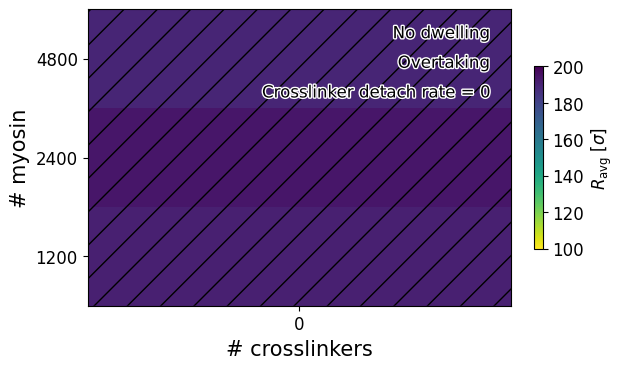

cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM1200_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-1-0.1-0.0001-0_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM1200_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-1-0.1-0.0001-1_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM2400_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-1-0.1-0.0001-0_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM2400_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-1-0.1-0.0001-1_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM4800_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-1-0.1-0.0001-0_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM4800_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-1-0.1-0.0001-1_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM9600_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-1-0.1-0.0001-0_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM9600_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-1-0.1-0.0001-1_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM1200_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-1-0.1-0.0001-1_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM2400_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-1-0.1-0.0001-1_110
cw_r100.0-200.0_Lz10

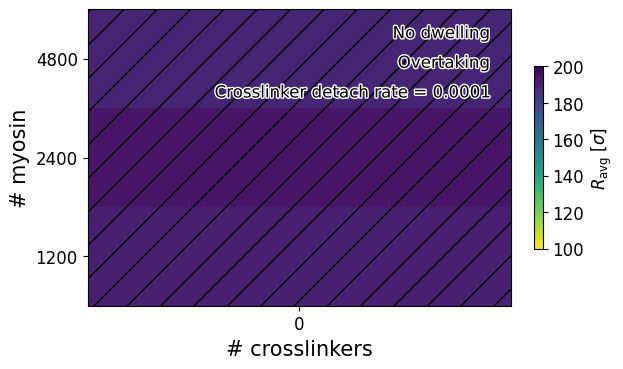

cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM1200_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-1-0.1-0.0001-0_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM1200_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-1-0.1-0.0001-1_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM2400_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-1-0.1-0.0001-0_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM2400_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-1-0.1-0.0001-1_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM4800_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-1-0.1-0.0001-0_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM4800_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-1-0.1-0.0001-1_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM9600_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-1-0.1-0.0001-0_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM9600_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-1-0.1-0.0001-1_110
        0.0
4800.0  0.0
2400.0  0.0
1200.0  0.0


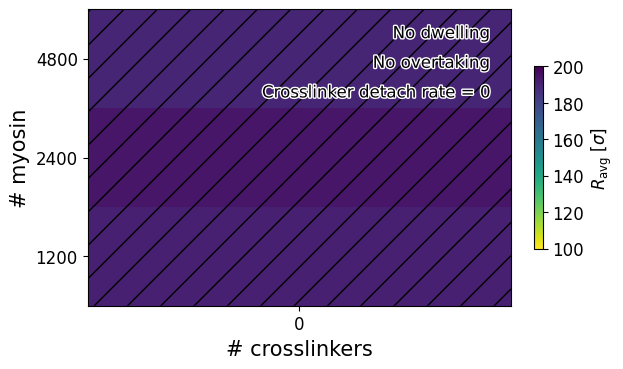

cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM1200_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-1-0.1-0.0001-0_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM1200_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-1-0.1-0.0001-1_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM2400_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-1-0.1-0.0001-0_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM2400_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-1-0.1-0.0001-1_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM4800_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-1-0.1-0.0001-0_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM4800_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-1-0.1-0.0001-1_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM9600_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-1-0.1-0.0001-0_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM9600_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-1-0.1-0.0001-1_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM1200_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-1-0.1-0.0001-0_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM2400_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-1-0.1-0.0001-0_110
cw_r100.0-200.0_Lz10

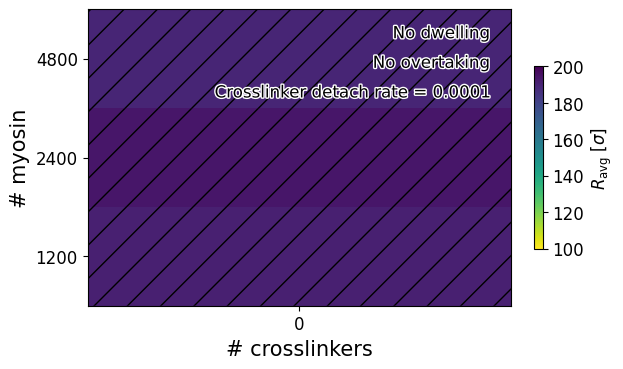

cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM1200_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-0.0001-0.1-0.0001-0_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM1200_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-0.0001-0.1-0.0001-1_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM2400_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-0.0001-0.1-0.0001-0_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM2400_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-0.0001-0.1-0.0001-1_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM4800_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-0.0001-0.1-0.0001-0_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM4800_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-0.0001-0.1-0.0001-1_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM9600_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-0.0001-0.1-0.0001-0_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM9600_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-0.0001-0.1-0.0001-1_110
        0.0
9600.0  1.0
4800.0  0.0
2400.0  0.0
1200.0  0.0


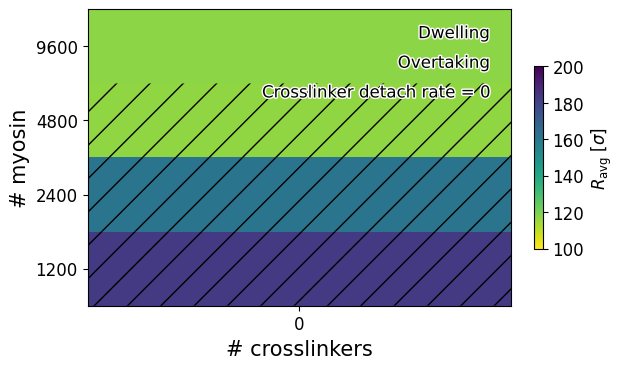

cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM1200_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-0.0001-0.1-0.0001-0_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM1200_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-0.0001-0.1-0.0001-1_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM2400_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-0.0001-0.1-0.0001-0_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM2400_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-0.0001-0.1-0.0001-1_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM4800_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-0.0001-0.1-0.0001-0_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM4800_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-0.0001-0.1-0.0001-1_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM9600_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-0.0001-0.1-0.0001-0_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM9600_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-0.0001-0.1-0.0001-1_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM1200_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-0.0001-0.1-0.0001-1_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM2400_nC0_R10-0-0-0-0-0-0-0.1-1-0

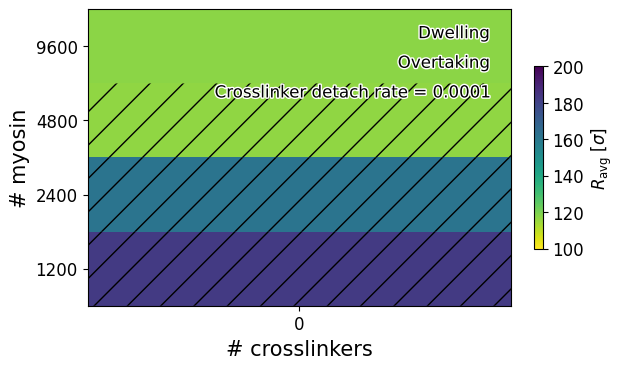

cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM1200_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-0.0001-0.1-0.0001-0_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM1200_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-0.0001-0.1-0.0001-1_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM2400_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-0.0001-0.1-0.0001-0_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM2400_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-0.0001-0.1-0.0001-1_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM4800_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-0.0001-0.1-0.0001-0_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM4800_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-0.0001-0.1-0.0001-1_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM9600_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-0.0001-0.1-0.0001-0_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM9600_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-0.0001-0.1-0.0001-1_110
        0.0
9600.0  1.0
4800.0  0.0
2400.0  0.0
1200.0  0.0


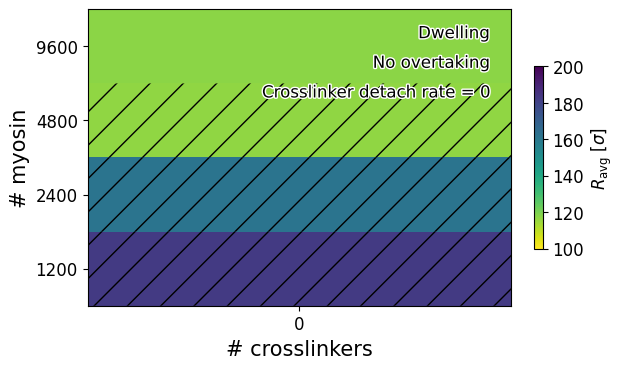

cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM1200_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-0.0001-0.1-0.0001-0_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM1200_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-0.0001-0.1-0.0001-1_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM2400_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-0.0001-0.1-0.0001-0_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM2400_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-0.0001-0.1-0.0001-1_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM4800_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-0.0001-0.1-0.0001-0_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM4800_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-0.0001-0.1-0.0001-1_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM9600_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-0.0001-0.1-0.0001-0_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM9600_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-0.0001-0.1-0.0001-1_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM1200_nC0_R10-0-0-0-0-0-0-0.1-1-0.0001-0.0001-0.1-0.0001-0_110
cw_r100.0-200.0_Lz10.0_eAA1.0_nF400-50_nM2400_nC0_R10-0-0-0-0-0-0-0.1-1-0

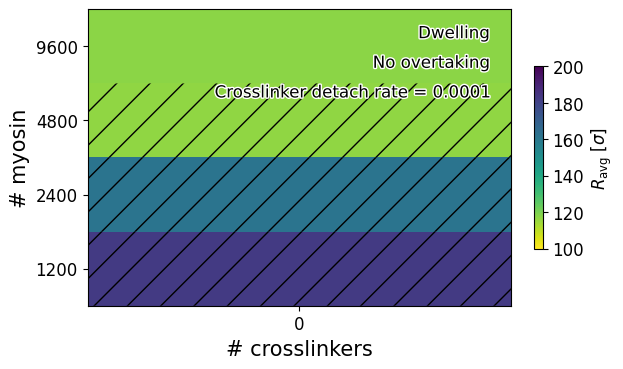

In [33]:
# Plots cw

TimestepThreshold = 7500000 # Only consider files going beyond this timestep

for pMDplot in [0.0001, 0.00001]:
    for pMDEplot in [1,pMDplot]:
        for pMOCplot in [1,0]:
            for pCDplot in [0, pMDplot]:

                data = []
                # get first column for nC=0
                for filestring in dicR.keys():
                    par = getparams(filestring)
                    if par['pMDE']==pMDEplot and par['nC']==0 and par['pMD']==pMDplot:
                        print(filestring)
                        Df = dicR[filestring]
                        if Df.iloc[-1].time<TimestepThreshold:
                            continue
                        its = Df.index[Df['time']==TimestepThreshold].tolist()[0] + 1
                        Ravg = (Df['Ravg'].iloc[its-10:its]).mean()
                        RingIntactFlag = True if Df.RingIntactFlag.iloc[-10:].mean()>0.5 else False
                        data.append([par['nM'],par['nC'],Ravg,RingIntactFlag])
                #get rest
                for filestring in dicR.keys():
                    par = getparams(filestring)
                    if par['pMDE']==pMDEplot  and par['pMOC']==pMOCplot and par['pCD']==pCDplot and par['pMD']==pMDplot:
                        print(filestring)
                        Df = dicR[filestring]
                        if Df.iloc[-1].time<TimestepThreshold:
                            continue
                        its = Df.index[Df['time']==TimestepThreshold].tolist()[0] + 1
                        Ravg = (Df['Ravg'].iloc[its-10:its]).mean()
                        RingIntactFlag = True if Df.RingIntactFlag.iloc[-10:].mean()>0.5 else False
                        data.append([par['nM'],par['nC'],Ravg,RingIntactFlag])
                data = np.array(data)
                if len(data)==0:
                    continue
                #plt.scatter(data[:,0], data[:,1], c=data[:,2], s=1000, marker='s')
                #plt.colorbar()
                
                
                nMlist, nClist, datadfplt = [],[],[]
                nMlist = np.unique(data[:,0]).tolist()
                nClist = np.unique(data[:,1]).tolist()
                dataRavg = np.NaN*np.ones((len(nMlist), len(nClist)))
                dataRingIntactFlag = np.NaN*np.ones((len(nMlist), len(nClist)))
                for x in data:
                    i = nMlist.index(x[0])
                    c = nClist.index(x[1])
                    dataRavg[i,c] = x[2]
                    dataRingIntactFlag[i,c] = x[3]
                dfRavg = pd.DataFrame(dataRavg, index=nMlist, columns=nClist)
                dfRavg = dfRavg.sort_index(ascending=False)
                dfRingIntactFlag = pd.DataFrame(dataRingIntactFlag, index=nMlist, columns=nClist)
                dfRingIntactFlag = dfRingIntactFlag.sort_index(ascending=False)

                # Ravg
                fig1 = plt.figure()
                #plt.imshow(dfPercolatedFlag, alpha=0.1)
                plt.imshow(dfRavg, vmin=par['Rcylin'], vmax=par['Rcylout'], cmap='viridis_r', aspect=len(dfRavg.columns)/len(dfRavg.index)*0.7 )
                ax = plt.gca()
                ax.set_yticks(np.arange(len(dfRavg.index)), labels=[int(x) for x in dfRavg.index])
                ax.set_xticks(np.arange(len(dfRavg.columns)), labels=[int(x) for x in dfRavg.columns])
                plt.ylabel('# myosin', size=15)
                plt.xlabel('# crosslinkers',size=15)
                colorbar = plt.colorbar(ax=ax,fraction=0.02,label=r'$R_\mathrm{avg}\ [\sigma$]')
                #plt.pcolor(np.arange(len(dfglobalDotprod.columns)), np.arange(len(dfglobalDotprod.index)), dfPercolatedFlag, hatch='/', alpha=0.5)
                #plt.contourf(dfPercolatedFlag, 1, hatches=['', '//'], alpha=0.5, colors=None)
                print(dfRingIntactFlag)
                y, x = np.mgrid[slice(0-0.5, len(dfRingIntactFlag.index) + 1-0.5, 1), slice(-0.5, len(dfRingIntactFlag.columns) + 1-0.5, 1)]
                zm = np.ma.masked_greater(np.array(dfRingIntactFlag), 0.5)
                plt.pcolor(x, y, zm, hatch='/', alpha=0.)  # hashed means PercolatedFlag<0.5, i.e. more than 1 cluster in sims
                
                if pMDEplot==pMDplot:
                    textDwelling = 'Dwelling'
                elif pMDEplot==1:
                    textDwelling = 'No dwelling'
                else:
                    textDwelling = 'Partial dwelling {:g}'.format(pMDEplot)
                
                if pMOCplot==1:
                    textOvertaking = 'Overtaking'
                elif pMOCplot==0:
                    textOvertaking = 'No overtaking'
                else:
                    textOvertaking = 'Partial overtaking ({:g})'.format(pMOCplot)
                    
                textpCD = 'Crosslinker detach rate = {:g}'.format(pCDplot)
                plt.annotate(textDwelling, xy=(0.95,0.95), xycoords='axes fraction', ha='right', va='top', size=12, path_effects=[pe.withStroke(linewidth=2, foreground="white")])
                plt.annotate(textOvertaking, xy=(0.95,0.85), xycoords='axes fraction', ha='right', va='top', size=12, path_effects=[pe.withStroke(linewidth=2, foreground="white")])
                plt.annotate(textpCD, xy=(0.95,0.75), xycoords='axes fraction', ha='right', va='top', size=12, path_effects=[pe.withStroke(linewidth=2, foreground="white")])
                plt.tight_layout()

                plt.savefig('{:s}/Analysis/Graphs/Ravg_pMD{:g}_pMDE{:g}_pCD{:g}_pMOC{:g}.pdf'.format(folder,pMDplot,pMDEplot,pCDplot,pMOCplot))
                plt.savefig('{:s}/Analysis/Graphs/Ravg_pMD{:g}_pMDE{:g}_pCD{:g}_pMOC{:g}.pdf'.format(folder,pMDplot,pMDEplot,pCDplot,pMOCplot),transparent=True)
                plt.show()
                plt.close()

    

In [ ]:
keys = [k for k in dicR.keys()]
keys.sort(key=sortbyparams)

timeHistList = [5e4, 5e5, 4e6]
RcyloutPlot = [200.0]
lFPlot= [50]
LzPlot= [20.0]
pMWOPlot = [0]
if len(RcyloutPlot)==1 and len(lFPlot)==1 and len(LzPlot)==1 and len(pMWOPlot)==1:
    SaveFigFlag=True
else:
    SaveFigFlag=False
SaveFigFlagIndividual=True

counter=0

for i,key in enumerate(keys):
    dffull = dicR[key]
    par = getparams(key)
    Lz=par['Lz']
    Rcylout=par['Rcylout']
    lF=par['lF']
    nF=par['nF']
    nM=par['nM']
    pMWO=par['pMWO']
    
    fmt = '-' if pMWO<0.5 else '--'
    label="nF{:d}-{:d} nM{:d} pMWO{:.1f}".format(par['nF'],par['lF'],par['nM'],par['pMWO'])
    
    if not ((Rcylout in RcyloutPlot) and (Lz in LzPlot) and (lF in lFPlot) and (pMWO in pMWOPlot)):
        continue
    counter+=1
        
    plt.figure(1)
    df = dffull[dffull.RingIntactFlag==1]
    plt.plot(df.time, df.Ravg,fmt, color=nM2color(nM), label=label)
    plt.fill_between(df.time, df.Ravg-df.Rstd, df.Ravg+df.Rstd, color=nM2color(nM), alpha=0.1)
    dfbroken = dffull[dffull.RingIntactFlag==0]
    if len(dfbroken)>0:
        plt.plot(dfbroken.iloc[0].time, dfbroken.iloc[0].Ravg, 'x', color=nM2color(nM), label=None, ms=10)

    plt.figure(2)
    plt.plot(df.time, df.Rstd, fmt, color=nM2color(nM), label=label)

    plt.figure(3)
    FractionMB = np.array([x[1].sum() for x in df.histMBdensity.values])/(2*nM)
    plt.plot(df.time, FractionMB, fmt, color=nM2color(nM), label=label )
    
    plt.figure(4)
    FractionMB = np.array([x[1].sum() for x in df.histMBdensity.values])/(nF)
    plt.plot(df.time, FractionMB, fmt, color=nM2color(nM), label=label )
    
    #plt.figure(1000+i)
    fig100,axs=plt.subplots(1,len(timeHistList),sharey=True, figsize=(3*len(timeHistList),3))
    plt.annotate(key, (0.5,1.1), fontsize=10, va='center', ha='center', xycoords='figure fraction')
    for i,timeHist in enumerate(timeHistList):
        plt.sca(axs[i])
        if len(df[df.time==timeHist])==0:
            continue
        plt.ylabel('Density')
        plt.xlabel(r'$\theta\ [rad]$')
        plt.title('ts{:.0f}'.format(timeHist), fontsize=10)

        histAdensity = df[df.time==timeHist].histAdensity.iloc[0]
        Ravg = df[df.time==timeHist].Ravg.iloc[0]
        #plt.stairs(histAdensity[1]/lF, edges=histAdensity[0], lw=2, label='actin / lF', color='forestgreen')
        plt.plot(bin2midpoint(histAdensity[0]), histAdensity[1]/(lF*nF), ':', color='forestgreen', label='actin / lF', lw=1)

        histABdensity = df[df.time==timeHist].histABdensity.iloc[0]
        #plt.stairs(histABdensity[1], edges=histABdensity[0], lw=2, label='actin barbed', color='limegreen')
        plt.plot(bin2midpoint(histABdensity[0]), histABdensity[1]/nF, color='limegreen', label='actin barbed', lw=2)

        histAPdensity = df[df.time==timeHist].histAPdensity.iloc[0]
        #plt.stairs(histAPdensity[1], edges=histAPdensity[0], lw=2, label='actin pointed', color='darkgreen')
        plt.plot(bin2midpoint(histAPdensity[0]), histAPdensity[1]/nF, color='darkgreen', label='actin pointed', lw=2)

        histMUdensity = df[df.time==timeHist].histMUdensity.iloc[0]
        #plt.stairs(histMUdensity[1], edges=histMUdensity[0], lw=2, label='myosin unbound', color='navy')
        plt.plot(bin2midpoint(histMUdensity[0]), histMUdensity[1]/nM, color='navy', label='myosin unbound', lw=1)

        histMBdensity = df[df.time==timeHist].histMBdensity.iloc[0]
        #plt.stairs(histMBdensity[1], edges=histMBdensity[0], lw=2, label='myosin bound', color='royalblue')
        plt.plot(bin2midpoint(histMBdensity[0]), histMBdensity[1]/nM, color='royalblue', label='myosin bound', lw=2)
        
        if i==0:
            plt.legend(fontsize=8)

            
    fig101,axs=plt.subplots(1,3,sharey=True, figsize=(3*3,3))
    for j, s in enumerate(['histABdensity', 'histAPdensity', 'histMBdensity']):
        if s not in df:
            continue
        plt.sca(axs[j])
        data = []
        for i,dfline in df.iterrows():
            Ravg = dfline.Ravg
            time = dfline.time
            midpoints = bin2midpoint( dfline[s][0]*Ravg )
            hist = dfline[s][1]
            for i in range(len(hist)):
                data.append( [midpoints[i], time, hist[i]] )
        data = np.array(data)
        plt.scatter(data[:,0], data[:,1], c=data[:,2], s=20, marker='s')
        plt.colorbar()
        plt.xlabel('arc coordinate')
        if j==0:
            plt.ylabel('time')
        plt.title(s, fontsize=10)
    plt.tight_layout()
    if SaveFigFlagIndividual: plt.savefig('{:s}/Analysis/Graphs/HistAB-AP-MB_{:s}.pdf'.format(folder,key))
    #plt.show()
    #plt.close(fig101)
    
    fig102,axs=plt.subplots(1,3,sharey=True, figsize=(3*3,3))
    for j, s in enumerate(['histParallelContacts','histAntiparallelExtensileContacts', 'histAntiparallelContractileContacts']):
        plt.sca(axs[j])
        data = []
        for i,dfline in df.iterrows():
            if len(dfline[s])==0:
                continue
            time = dfline.time
            midpoints = bin2midpoint( dfline[s][0] )
            hist = dfline[s][1]
            for i in range(2,len(hist)):
                data.append( [midpoints[i], time, hist[i] ] )
        data = np.array(data)
        plt.scatter(data[:,0], data[:,1], c=data[:,2], s=5, marker='s')
        plt.colorbar()
        plt.xlabel('contact length')
        if j==0:
            plt.ylabel('time')
        plt.title(s[4:], fontsize=10)
    plt.tight_layout()
    if SaveFigFlagIndividual: plt.savefig('{:s}/Analysis/Graphs/HistContact_{:s}.pdf'.format(folder,key))
    #plt.show()
    #plt.close(fig102)

    fig103,axs=plt.subplots(1,1,sharey=True, figsize=(4,3))
    for j, s in enumerate(['histParallelContacts','histAntiparallelExtensileContacts', 'histAntiparallelContractileContacts']):
        data = []
        for i, dfline in df.iterrows():
            if len(dfline[s])==0:
                continue
            time = dfline.time
            hist = dfline[s][1]
            histsum = sum(hist*dfline[s][0][:-1])
            data.append([time,histsum])
        data = np.array(data)
        plt.plot(data[:,0], data[:,1], label=s[4:])
    plt.ylabel('# contacts')
    plt.xlabel('time')
    plt.title('Total number of contacts', fontsize=10)
    plt.legend(frameon=False, fontsize=8)
    plt.ylim(0,None)
    plt.tight_layout()
    if SaveFigFlagIndividual: plt.savefig('{:s}/Analysis/Graphs/ContactsvsTime_{:s}.pdf'.format(folder,key))
    #plt.show()
    #plt.close(fig103)

    fig104,axs=plt.subplots(1,2,sharey=True, figsize=(6,3))
    for j, s in enumerate(['histParallelMbond','histAntiparallelMbond']):
        plt.sca(axs[j])
        data = []
        for i,dfline in df.iterrows():
            if len(dfline[s])==0:
                continue
            time = dfline.time
            midpoints = bin2midpoint( dfline[s][0] )
            hist = dfline[s][1]
            for i in range(1,len(hist)):
                data.append( [midpoints[i], time, hist[i] ] )
        data = np.array(data)
        plt.scatter(data[:,0], data[:,1], c=data[:,2], s=2, marker='s')
        plt.colorbar()
        plt.xlabel('Extensivity')
        if j==0:
            plt.ylabel('time')
        plt.title(s[4:], fontsize=10)
    plt.tight_layout()
    if SaveFigFlagIndividual: plt.savefig('{:s}/Analysis/Graphs/HistMbonds_{:s}.pdf'.format(folder,key))
    #plt.show()
    #plt.close(fig104)

    fig105,axs=plt.subplots(1,1,sharey=True, figsize=(4,3))
    times, histsumParallel, histsumContractile, histsumExtensile = [],[],[],[]
    for i, dfline in df.iterrows():
        times.append(dfline.time)
        assert (dfline['histParallelMbond'][0]==dfline['histAntiparallelMbond'][0]).all()
        s = 'histParallelMbond'
        midpoints = bin2midpoint( dfline[s][0] )
        counts = dfline[s][1]
        histsumParallel.append(sum(counts))
        s = 'histAntiparallelMbond'
        midpoints = bin2midpoint( dfline[s][0] )
        counts = dfline[s][1]
        assert len(counts[0:lF])==len(counts[lF+1:])
        histsumContractile.append(sum(counts[0:lF]))
        histsumExtensile.append(sum(counts[lF+1:]))
    plt.plot(times, histsumParallel, label='Parallel Mbonds')
    plt.plot(times, histsumContractile, label='Antiparallel contractile Mbonds')
    plt.plot(times, histsumExtensile, label='Antiparallel extensile Mbonds')
    plt.ylabel('# double-bound Myo')
    plt.xlabel('time')
    plt.title('Myo bonds', fontsize=10)
    plt.legend(frameon=False, fontsize=8)
    plt.ylim(0,None)
    plt.tight_layout()
    if SaveFigFlagIndividual: plt.savefig('{:s}/Analysis/Graphs/MbondsvsTime_{:s}.pdf'.format(folder,key))
    #plt.show()
    #plt.close(fig105)
    
    fig105,axs=plt.subplots(1,1,figsize=(4,3))
    plt.annotate(key, (0.5,1.1), fontsize=10, va='center', ha='center', xycoords='figure fraction')
    colors = ['k','b','g','orange','y','r']
    timesPlot = [1000000, 1100000, 1200000, 1300000, 1400000, 1500000]
    for i,timeHist in enumerate(timesPlot):
        dfline = df[df.time==timeHist].iloc[0]
        if len(dfline.DeltaExtensivityRef)==0:
            continue
        plt.ylabel('Delta Extensivity')
        plt.xlabel('Initial Extensivity')
        label = 'ts{:d}'.format(timeHist)
        InitialExtensivity = dfline.DeltaExtensivityRef.InitialExtensivity
        DeltaSum = dfline.DeltaExtensivityRef.DeltaSum
        #DeltaStd = dfline.DeltaExtensivityRef.DeltaStd
        plt.plot(InitialExtensivity, DeltaSum, '-', color=colors[i], label=label, lw=1)
        #plt.fill_between(InitialExtensivity, DeltaMean-DeltaStd, DeltaMean+DeltaStd, color=colors[i], alpha=0.2)
    plt.legend(fontsize=8)
    plt.title('# steps forward in 1e5 ts, before first detachment', fontsize=10)
    plt.ylim(0,None)
    if SaveFigFlagIndividual: plt.savefig('{:s}/Analysis/Graphs/DeltaExtensivityRef_{:d}ts_{:s}.pdf'.format(folder,len(timesPlot),key))
    
    fig106,axs=plt.subplots(1,1, figsize=(4,2))
    data = []
    for i, dfline in df.iterrows():
        if len(dfline.DeltaExtensivityRef)==0:
            continue
        time = dfline.time
        InitialExtensivity = dfline.DeltaExtensivityRef.InitialExtensivity
        DeltaSum = dfline.DeltaExtensivityRef.DeltaSum
        for i in range(1,len(hist)):
            data.append( [InitialExtensivity[i], time, DeltaSum[i] ] )
    data = np.array(data)
    plt.scatter(data[:,0], data[:,1], c=data[:,2], s=10, marker='s')
    plt.colorbar()
    plt.xlabel('Initial Extensivity')
    if j==0:
        plt.ylabel('time')
    plt.title('# steps forward in 1e5 ts, before first detachment', fontsize=10)
    plt.tight_layout()
    if SaveFigFlagIndividual: plt.savefig('{:s}/Analysis/Graphs/HistDeltaExtensivityRef_{:s}.pdf'.format(folder,key))
    

    fig107,axs=plt.subplots(1,1,figsize=(4,3))
    plt.annotate(key, (0.5,1.1), fontsize=10, va='center', ha='center', xycoords='figure fraction')
    colors = ['k','b','g','y','r']
    timesPlot = [1000000, 2000000, 3000000, 4000000]
    for i,timeHist in enumerate(timesPlot):
        dfline = df[df.time==timeHist].iloc[0]
        if len(dfline.DeltaExtensivityCont)==0:
            continue
        plt.ylabel('Delta Extensivity')
        plt.xlabel('Previous Extensivity')
        label = 'ts{:d}'.format(timeHist)
        InitialExtensivity = dfline.DeltaExtensivityCont.PreviousExtensivity
        DeltaSum = dfline.DeltaExtensivityCont.DeltaSum
        #DeltaStd = dfline.DeltaExtensivityCont.DeltaStd
        plt.plot(InitialExtensivity, DeltaSum, '-', color=colors[i], label=label, lw=1)
        #plt.fill_between(InitialExtensivity, DeltaMean-DeltaStd, DeltaMean+DeltaStd, color=colors[i], alpha=0.2)
        plt.title('# steps forward in 1e5 ts, for all Myos', fontsize=10)
        plt.legend(fontsize=8)
        plt.ylim(0,None)
    if SaveFigFlagIndividual: plt.savefig('{:s}/Analysis/Graphs/DeltaExtensivityCont_{:s}.pdf'.format(folder,key))
    
    fig108,axs=plt.subplots(1,1, figsize=(4,3))
    data = []
    for i, dfline in df.iterrows():
        if len(dfline.DeltaExtensivityCont)==0:
            continue
        time = dfline.time
        InitialExtensivity = dfline.DeltaExtensivityCont.PreviousExtensivity
        DeltaSum = dfline.DeltaExtensivityCont.DeltaSum
        for i in range(1,len(hist)):
            data.append( [InitialExtensivity[i], time, DeltaSum[i] ] )
    data = np.array(data)
    plt.scatter(data[:,0], data[:,1], c=data[:,2], s=5, marker='s')
    plt.colorbar()
    plt.xlabel('Previous Extensivity')
    if j==0:
        plt.ylabel('time')
    plt.title('# steps forward in 1e5 ts, for all Myos', fontsize=10)
    plt.tight_layout()
    if SaveFigFlagIndividual: plt.savefig('{:s}/Analysis/Graphs/HistDeltaExtensivityCont_{:s}.pdf'.format(folder,key))
    




if counter>=1:

    plt.figure(1)
    for timeHist in timeHistList:
        plt.plot([timeHist,timeHist],[max(RcyloutPlot)-50, max(RcyloutPlot)],':',lw=0.2,color='k')
    plt.ylabel('Average ring radius')
    plt.xlabel('time')
    plt.legend(fontsize=8)
    plt.tight_layout()
    if SaveFigFlag: plt.savefig('{:s}/Analysis/Graphs/RingRadius_lF{:d}_Rcylout{:.1f}_Lz{:.1f}_pMWO{:.1f}.pdf'.format(folder,lFPlot[0],RcyloutPlot[0],LzPlot[0],pMWOPlot[0]))

    plt.figure(2)
    plt.ylabel('Std of ring radius')
    plt.xlabel('time')
    plt.legend(fontsize=8)
    plt.tight_layout()
    if SaveFigFlag: plt.savefig('{:s}/Analysis/Graphs/RingRadiusStd_lF{:d}_Rcylout{:.1f}_Lz{:.1f}_pMWO{:.1f}.pdf'.format(folder,lFPlot[0],RcyloutPlot[0],LzPlot[0],pMWOPlot[0]))

    plt.figure(3)
    plt.ylabel('Fraction of myosin heads bound')
    plt.xlabel('time')
    plt.legend(fontsize=8)
    plt.tight_layout()
    if SaveFigFlag: plt.savefig('{:s}/Analysis/Graphs/MyosinBoundFraction_lF{:d}_Rcylout{:.1f}_Lz{:.1f}_pMWO{:.1f}.pdf'.format(folder,lFPlot[0],RcyloutPlot[0],LzPlot[0],pMWOPlot[0]))

    plt.figure(4)
    plt.ylabel('Myosin-actin bonds per actin filament')
    plt.xlabel('time')
    plt.legend(fontsize=8)
    plt.tight_layout()
    if SaveFigFlag: plt.savefig('{:s}/Analysis/Graphs/MyosinBoundFraction_lF{:d}_Rcylout{:.1f}_Lz{:.1f}_pMWO{:.1f}.pdf'.format(folder,lFPlot[0],RcyloutPlot[0],LzPlot[0],pMWOPlot[0]))


    
'''
plt.ylabel('Actin')
#plt.xlabel('Arc of ring')
plt.xlabel(r'$\theta\ [rad]$')
plt.legend(fontsize=8)

plt.figure(11)
plt.ylabel('Actin barbed end')
plt.xlabel(r'$\theta\ [rad]$')
plt.legend(fontsize=8)

plt.figure(12)
plt.ylabel('Actin pointed end')
plt.xlabel(r'$\theta\ [rad]$')
plt.legend(fontsize=8)

plt.figure(20)
plt.ylabel('Unbound myosin')
#plt.xlabel('Arc of ring')
plt.xlabel(r'$\theta\ [rad]$')
plt.legend(fontsize=8)
             
plt.figure(21)
plt.ylabel('Bound myosin')
#plt.xlabel('Arc of ring')
plt.xlabel(r'$\theta\ [rad]$')
plt.legend(fontsize=8)
'''

KeyError: 'pMWO'

In [158]:
dic

NameError: name 'data' is not defined